In [1]:
import cv2
import mediapipe as mp
import numpy as np
from numpy import asarray
from numpy import save

In [2]:
# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils

# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence = 0.5)

In [3]:
# Getting the input video for pose estimation

#cap = cv2.VideoCapture('1_3-1.mp4')
#cap = cv2.VideoCapture('v1_3-3.mp4')
cap = cv2.VideoCapture('2v_3-1.mp4')
#cap = cv2.VideoCapture('2_3-1.mp4')

# Number to convert the real world coordinate from meters to milimeters
num = 1000

In [4]:
# Landmarks dictionary to define body segments landmarks according to BlazePose Topology

landmarks_coordinates = {}

thigh_segments = {"Left Thigh": [23, 25], "Right Thigh": [24, 26]}

upperarm_segments = {"Left Upper Arm": [11, 13], "Right Upper Arm": [12, 14]}

forearm_segments = {"Left Fore Arm": [13, 15], "Right Fore Arm": [14, 16]}

leg_segments = {"Left Leg": [25, 27], "Right Leg": [26, 28]}

foot_segments = {"Left foot": [27, 31], "Right foot": [28, 32]}

hands_segments = {"Left hand": [15, 19], "Right hand": [16, 20]}

shoulder_segment = {"Shoulder": [12, 11]}

hips_segment = {"Hips": [24, 23]}

trunk_segment = {"trunk": [34, 33]}

In [5]:
# Function to calculate CoM coordinates for segments defined in the dictionary

def calculate_foot_CoM(x_i, x_j, y_i, y_j, z_i, z_j):
    x1 = (x_i + x_j) * 0.5
    y1 = (y_i + y_j) * 0.5
    z1 = (z_i + z_j) * 0.5

    return x1, y1, z1

def calculate_Leg_CoM(x_g, x_h, y_g, y_h, z_g, z_h):
    x2 = x_g + 0.433 * (x_h - x_g)
    y2 = y_g - 0.433 * (y_g - y_h)
    z2 = z_g - 0.433 * (z_g - z_h)

    return x2, y2, z2


def calculate_thigh_CoM(x_a, x_b, y_a, y_b, z_a, z_b):
    x3 = x_a + 0.433 * (x_b - x_a)
    y3 = y_a - 0.433 * (y_a - y_b)
    z3 = z_a - 0.433 * (z_a - z_b)

    return x3, y3, z3


def calculate_UpperArm_CoM(x_c, x_d, y_c, y_d, z_c, z_d):
    x4 = x_c + 0.436 * (x_d - x_c)
    y4 = y_c - 0.436 * (y_c - y_d)
    z4 = z_c - 0.436 * (z_c - z_d)

    return x4, y4, z4


def calculate_ForeArm_CoM(x_e, x_f, y_e, y_f, z_e, z_f):
    x5 = x_e + 0.430 * (x_f - x_e)
    y5 = y_e - 0.430 * (y_e - y_f)
    z5 = z_e - 0.430 * (z_e - z_f)

    return x5, y5, z5


def calculate_hands_CoM(x_o, x_p, y_o, y_p, z_o, z_p):
    x6 = x_o + 0.506 * (x_p - x_o)
    y6 = y_o - 0.506 * (y_o - y_p)
    z6 = z_o - 0.506 * (z_o - z_p)

    return x6, y6, z6


def calculate_trunk_CoM(x_q, x_r, y_q, y_r, z_q, z_r):
    x7 = x_q - 0.66 * (x_q - x_r)
    y7 = y_q - 0.66 * (y_q - y_r)
    z7 = z_q - 0.66 * (z_q - z_r)    

    return x7, y7, z7


def calculate_average(x_l, x_r, y_l, y_r, z_l, z_r):
    x = (x_l + x_r) * 0.5
    y = (y_l + y_r) * 0.5
    z = (z_l + z_r) * 0.5
    
    return x, y, z

In [6]:
### Pose estimation for one individual in a video

# While the video is running, perform pose detection 
while True:
    success, image = cap.read()
    results = pose.process(image)
    
    # Defining a variable to calculate the whole body CoM in the end, by getting
    # all the segment´s CoM coordinates values
    com_body = 0
    
    # Check if any landmarks are found.
    if results.pose_world_landmarks:
        # draw the connections between joint landmarks
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 ) 
        # Enumerate each landmark according to BlazePose Topology 
        for idx, lm in enumerate(results.pose_landmarks.landmark):
            h, w, c = image.shape
            cx, cy = int(lm.x * w), int(lm.y * h)
            #cv2.circle(image, (cx, cy), 2, (0, 0, 255), cv2.FILLED)
            #if idx == 29:
                #print(idx, lm.x, lm.y, lm.z)
                #print("[%s, %s, %s],\n" % (str(lm.x), str(lm.y), str(lm.z)))
            landmarks_coordinates[idx] = {"x": lm.x, "y": lm.y, "z": lm.z}

       # Calculating trunk CoM coordinates by defining the average point in the shoulder and
        # hips segment
        x_left_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][1]]["x"]
        y_left_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][1]]["y"]
        z_left_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][1]]["z"]
        x_right_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][0]]["x"]
        y_right_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][0]]["y"]
        z_right_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][0]]["z"]
        x_average_shoulder, y_average_shoulder, z_average_shoulder = calculate_average(
            x_left_shoulder, x_right_shoulder, y_left_shoulder, y_right_shoulder, z_left_shoulder, z_right_shoulder
        )

        landmarks_coordinates[33] = {"x": x_average_shoulder, "y": y_average_shoulder, "z": z_average_shoulder}

        x_left_hips = landmarks_coordinates[hips_segment["Hips"][1]]["x"]
        y_left_hips = landmarks_coordinates[hips_segment["Hips"][1]]["y"]
        z_left_hips = landmarks_coordinates[hips_segment["Hips"][1]]["z"]
        x_right_hips = landmarks_coordinates[hips_segment["Hips"][0]]["x"]
        y_right_hips = landmarks_coordinates[hips_segment["Hips"][0]]["y"]
        z_right_hips = landmarks_coordinates[hips_segment["Hips"][0]]["y"]
        x_average_hips, y_average_hips, z_average_hips = calculate_average(
            x_left_hips, x_right_hips, y_left_hips, y_right_hips, z_left_hips, z_right_hips
        )

        landmarks_coordinates[34] = {"x": x_average_hips, "y": y_average_hips, "z": z_average_hips}

    # Calculate Body segments CoM

    foot_com_x = 0
    foot_com_y = 0
    foot_com_z = 0
    for segment in foot_segments:
        # print("%s COM:" % segment)
        x_i = landmarks_coordinates[foot_segments[segment][0]]["x"]
        x_j = landmarks_coordinates[foot_segments[segment][1]]["x"]
        y_i = landmarks_coordinates[foot_segments[segment][0]]["y"]
        y_j = landmarks_coordinates[foot_segments[segment][1]]["y"]
        z_i = landmarks_coordinates[foot_segments[segment][0]]["z"]
        z_j = landmarks_coordinates[foot_segments[segment][1]]["z"]
        
        x1, y1, z1 = calculate_foot_CoM(x_i, x_j, y_i, y_j, z_i, z_j)
        #print("x: %s, y: %s\n" % (str(x1), str(y1)))
        #print("[%s, %s],\n" % (str(x1), str(y1)))
        #print("[%s, %s],\n" % (str(y_i), str(y_j)))

        #h, w, c = image.shape
        cx, cy = int(x1*w), int(y1*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        foot_com_x += x1
        foot_com_y += y1
        foot_com_z += z1

    leg_com_x = 0
    leg_com_y = 0
    leg_com_z = 0
    for segment in leg_segments:
        # print("%s COM:" % segment)
        x_g = landmarks_coordinates[leg_segments[segment][0]]["x"]
        x_h = landmarks_coordinates[leg_segments[segment][1]]["x"]
        y_g = landmarks_coordinates[leg_segments[segment][0]]["y"]
        y_h = landmarks_coordinates[leg_segments[segment][1]]["y"]
        z_g = landmarks_coordinates[leg_segments[segment][0]]["z"]
        z_h = landmarks_coordinates[leg_segments[segment][1]]["z"]
        
        x2, y2, z2 = calculate_Leg_CoM(x_g, x_h, y_g, y_h, z_g, z_h)
        # print("x: %s, y: %s\n" % (str(x2), str(y2)))

        #h, w, c = image.shape
        cx, cy = int(x2*w), int(y2*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        leg_com_x += x2
        leg_com_y += y2
        leg_com_z += z2
        
    thigh_com_x = 0
    thigh_com_y = 0
    thigh_com_z = 0
    for segment in thigh_segments:
        # print("%s COM:" % segment)
        x_a = landmarks_coordinates[thigh_segments[segment][0]]["x"]
        x_b = landmarks_coordinates[thigh_segments[segment][1]]["x"]
        y_a = landmarks_coordinates[thigh_segments[segment][0]]["y"]
        y_b = landmarks_coordinates[thigh_segments[segment][1]]["y"]
        z_a = landmarks_coordinates[thigh_segments[segment][0]]["z"]
        z_b = landmarks_coordinates[thigh_segments[segment][1]]["z"]
        
        x3, y3, z3 = calculate_thigh_CoM(x_a, x_b, y_a, y_b, z_a, z_b)
        #print("x: %s, y: %s\n" % (str(x3), str(y3)))

        #h, w, c = image.shape
        cx, cy = int(x3*w), int(y3*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        thigh_com_x += x3
        thigh_com_y += y3
        thigh_com_z += z3

    upperarm_com_x = 0
    upperarm_com_y = 0
    upperarm_com_z = 0
    for segment in upperarm_segments:
        # print("%s COM:" % segment)
        x_c = landmarks_coordinates[upperarm_segments[segment][0]]["x"]
        x_d = landmarks_coordinates[upperarm_segments[segment][1]]["x"]
        y_c = landmarks_coordinates[upperarm_segments[segment][0]]["y"]
        y_d = landmarks_coordinates[upperarm_segments[segment][1]]["y"]
        z_c = landmarks_coordinates[upperarm_segments[segment][0]]["z"]
        z_d = landmarks_coordinates[upperarm_segments[segment][1]]["z"]
        
        x4, y4, z4 = calculate_UpperArm_CoM(x_c, x_d, y_c, y_d, z_c, z_d)
        # print("x: %s, y: %s\n" % (str(x4), str(y4)))

        #h, w, c = image.shape
        cx, cy = int(x4*w), int(y4*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)
        upperarm_com_x += x4
        upperarm_com_y += y4
        upperarm_com_z += z4

    forearm_com_x = 0
    forearm_com_y = 0
    forearm_com_z = 0
    for segment in forearm_segments:
        # print("%s COM:" % segment)
        x_e = landmarks_coordinates[forearm_segments[segment][0]]["x"]
        x_f = landmarks_coordinates[forearm_segments[segment][1]]["x"]
        y_e = landmarks_coordinates[forearm_segments[segment][0]]["y"]
        y_f = landmarks_coordinates[forearm_segments[segment][1]]["y"]
        z_e = landmarks_coordinates[forearm_segments[segment][0]]["z"]
        z_f = landmarks_coordinates[forearm_segments[segment][1]]["z"]
        
        x5, y5, z5 = calculate_ForeArm_CoM(x_e, x_f, y_e, y_f, z_e, z_f)
        # print("x: %s, y: %s\n" % (str(x5), str(y5)))

        #h, w, c = image.shape
        cx, cy = int(x5*w), int(y5*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)
        forearm_com_x += x5
        forearm_com_y += y5
        forearm_com_z += z5

    hands_com_x = 0
    hands_com_y = 0
    hands_com_z = 0
    for segment in hands_segments:
        # print("%s COM:" % segment)
        x_o = landmarks_coordinates[hands_segments[segment][0]]["x"]
        x_p = landmarks_coordinates[hands_segments[segment][1]]["x"]
        y_o = landmarks_coordinates[hands_segments[segment][0]]["y"]
        y_p = landmarks_coordinates[hands_segments[segment][1]]["y"]
        z_o = landmarks_coordinates[hands_segments[segment][0]]["z"]
        z_p = landmarks_coordinates[hands_segments[segment][1]]["z"]
        
        x6, y6, z6 = calculate_hands_CoM(x_o, x_p, y_o, y_p, z_o, z_p)
        # print("x: %s, y: %s\n" % (str(x6), str(y6)))

        #h, w, c = image.shape
        cx, cy = int(x6*w), int(y6*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        hands_com_x += x6
        hands_com_y += y6

    trunk_com_x = 0
    trunk_com_y = 0
    trunk_com_z = 0
    for segment in trunk_segment:
        # print("%s COM:" % segment)
        x_q = landmarks_coordinates[trunk_segment[segment][0]]["x"]
        x_r = landmarks_coordinates[trunk_segment[segment][1]]["x"]
        y_q = landmarks_coordinates[trunk_segment[segment][0]]["y"]
        y_r = landmarks_coordinates[trunk_segment[segment][1]]["y"]
        z_q = landmarks_coordinates[trunk_segment[segment][0]]["z"]
        z_r = landmarks_coordinates[trunk_segment[segment][1]]["z"]
        
        x7, y7, z7 = calculate_trunk_CoM(x_q, x_r, y_q, y_r, z_q, z_r)
        #print("x: %s, y: %s\n" % (str(x7), str(y7)))

        #h, w, c = image.shape
        cx, cy = int(x7*w), int(y7*h)
        #  cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        trunk_com_x += x7
        trunk_com_y += y7
        trunk_com_z += z7

    # Calculate the whole body CoM
    body_com_x = (0.0145 * foot_com_x + 0.0465 * leg_com_x + 0.1 * thigh_com_x + 0.578 * trunk_com_x + 0.006 * hands_com_x + 0.028 * upperarm_com_x + 0.016 * forearm_com_x)
    body_com_y = (0.0145 * foot_com_y + 0.0465 * leg_com_y + 0.1 * thigh_com_y + 0.578 * trunk_com_y + 0.006 * hands_com_y + 0.028 * upperarm_com_y + 0.016 * forearm_com_y)
    body_com_z = (0.0145 * foot_com_z + 0.0465 * leg_com_z + 0.1 * thigh_com_z + 0.578 * trunk_com_z + 0.006 * hands_com_z + 0.028 * upperarm_com_z + 0.016 * forearm_com_z)
    
    cx, cy = int(body_com_x * w), int(body_com_y * h)
    cv2.circle(image, (cx, cy), 5, (0, 255, 255), cv2.FILLED)
    print("[ %s,  %s, %s],\n" % (str(body_com_x), str(body_com_y), str(body_com_z)))
    
    # Show the output image with the pose estimation and the CoM plotted
    #cv2.imshow("Video", image)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


KeyError: 27

Teste 1-1

In [34]:
foot29 = np.array([[0.48583656549453735, 0.5125409364700317, 0.09191194921731949],

[0.4858957827091217, 0.5125612616539001, 0.06634268909692764],

[0.4859125018119812, 0.5131064653396606, 0.07579044252634048],

[0.4860767722129822, 0.5131617188453674, 0.07834968715906143],

[0.486176073551178, 0.5133896470069885, 0.0777660384774208],

[0.48623642325401306, 0.5134669542312622, 0.07598963379859924],

[0.48623937368392944, 0.5137912631034851, 0.07345478981733322],

[0.486253023147583, 0.5139471292495728, 0.0731988325715065],

[0.4862837791442871, 0.5144733786582947, 0.07252377271652222],

[0.4863225817680359, 0.5146510601043701, 0.07213184237480164],

[0.486368328332901, 0.5148202776908875, 0.0728331133723259],

[0.48641151189804077, 0.5149909853935242, 0.06942687928676605],

[0.48642319440841675, 0.5150596499443054, 0.06839518249034882],

[0.48642730712890625, 0.5151650905609131, 0.06821310520172119],

[0.48642855882644653, 0.5153233408927917, 0.06866427510976791],

[0.4864295423030853, 0.5154479146003723, 0.06864556670188904],

[0.4864298403263092, 0.5154561400413513, 0.06994929909706116],

[0.48643064498901367, 0.5154332518577576, 0.07172492146492004],

[0.4864300787448883, 0.5153846144676208, 0.07223183661699295],

[0.4864305853843689, 0.5152639746665955, 0.07427234947681427],

[0.48643192648887634, 0.5152419805526733, 0.07411552965641022],

[0.4864344596862793, 0.5151445865631104, 0.07485860586166382],

[0.48643797636032104, 0.5149423480033875, 0.07600922882556915],

[0.4864533841609955, 0.5146401524543762, 0.07592788338661194],

[0.4864780902862549, 0.5145331621170044, 0.07573110610246658],

[0.4864829480648041, 0.5144148468971252, 0.07595064491033554],

[0.4864842891693115, 0.5145522356033325, 0.07535029947757721],

[0.48651236295700073, 0.5148342847824097, 0.07178051769733429],

[0.4866720736026764, 0.5152655839920044, 0.06479274481534958],

[0.48687833547592163, 0.5152769088745117, 0.060430485755205154],

[0.48702019453048706, 0.5152735114097595, 0.06167531758546829],

[0.487093061208725, 0.5153232216835022, 0.06141374260187149],

[0.4871167540550232, 0.515387773513794, 0.06306837499141693],

[0.48712849617004395, 0.5154997110366821, 0.06412187218666077],

[0.4871130883693695, 0.5156925916671753, 0.06771480292081833],

[0.4871109127998352, 0.515913724899292, 0.06864206492900848],

[0.4870432913303375, 0.5160377025604248, 0.07329980283975601],

[0.48701372742652893, 0.5160879492759705, 0.07247503101825714],

[0.4869747757911682, 0.5162996053695679, 0.07272659987211227],

[0.4869743883609772, 0.5163296461105347, 0.07267652451992035],

[0.4869913160800934, 0.5158921480178833, 0.0775124803185463],

[0.48700442910194397, 0.5144550204277039, 0.0845278948545456],

[0.4870821535587311, 0.5144593715667725, 0.08350036293268204],

[0.48751458525657654, 0.5137425065040588, 0.08760210126638412],

[0.48780593276023865, 0.5135725140571594, 0.09091413766145706],

[0.4879732131958008, 0.5122898817062378, 0.09637299925088882],

[0.48870235681533813, 0.5072879791259766, 0.10107652842998505],

[0.4897894859313965, 0.49973922967910767, 0.1104946956038475],

[0.4900239109992981, 0.4953184425830841, 0.11986219882965088],

[0.4899505078792572, 0.4958305060863495, 0.11752498149871826],

[0.48983103036880493, 0.49834632873535156, 0.11915764957666397],

[0.4894371032714844, 0.5041673183441162, 0.11460494995117188],

[0.48903805017471313, 0.5139930248260498, 0.11108813434839249],

[0.4889596402645111, 0.5221964716911316, 0.09735307842493057],

[0.48909395933151245, 0.5269809365272522, 0.08928178250789642],

[0.48941415548324585, 0.5337366461753845, 0.08441067487001419],

[0.48958516120910645, 0.5377482771873474, 0.0759521871805191],

[0.489814817905426, 0.5397666692733765, 0.06965316087007523],

[0.49022912979125977, 0.5403072237968445, 0.06303803622722626],

[0.49049538373947144, 0.538357675075531, 0.07389382272958755],

[0.49103179574012756, 0.539401650428772, 0.07676345854997635],

[0.4911741614341736, 0.5441173911094666, 0.0692855566740036],

[0.49099308252334595, 0.5466116666793823, 0.06379429996013641],

[0.4906327724456787, 0.5462924242019653, 0.0626181811094284],

[0.4906264841556549, 0.5491839647293091, 0.05354355648159981],

[0.4907204210758209, 0.5500441789627075, 0.052190810441970825],

[0.49078255891799927, 0.5499255657196045, 0.06495342403650284],

[0.49014243483543396, 0.5497011542320251, 0.0746898353099823],

[0.48977193236351013, 0.5486674904823303, 0.08426009863615036],

[0.48952898383140564, 0.546481192111969, 0.08886609226465225],

[0.4891085624694824, 0.5460653901100159, 0.08401903510093689],

[0.48866352438926697, 0.5480846166610718, 0.0823112279176712],

[0.48832646012306213, 0.548200249671936, 0.0869002565741539],

[0.4878386855125427, 0.5509244203567505, 0.08542287349700928],

[0.487251341342926, 0.552212119102478, 0.0839700773358345],

[0.48672738671302795, 0.5523192286491394, 0.08665267378091812],

[0.486335426568985, 0.5521090626716614, 0.0904182568192482],

[0.4858895242214203, 0.5531424283981323, 0.08886058628559113],

[0.4856158196926117, 0.5533021092414856, 0.09185183793306351],

[0.48571768403053284, 0.5529924035072327, 0.10618923604488373],

[0.4861021041870117, 0.5528764724731445, 0.11428223550319672],

[0.48692893981933594, 0.5520362854003906, 0.11817598342895508],

[0.4873349070549011, 0.5487396717071533, 0.11653636395931244],

[0.48787006735801697, 0.5418574213981628, 0.12054158747196198],

[0.4889901280403137, 0.5337967276573181, 0.12238991260528564],

[0.4895905554294586, 0.5335538983345032, 0.12433271110057831],

[0.49059754610061646, 0.535188615322113, 0.1237860769033432],

[0.49087443947792053, 0.5420040488243103, 0.10818332433700562],

[0.4907466471195221, 0.5569390058517456, 0.08770187199115753],

[0.4908975660800934, 0.5679999589920044, 0.07895912230014801],

[0.49082526564598083, 0.5759068727493286, 0.06566658616065979],

[0.4907723367214203, 0.5850086808204651, 0.040983982384204865],

[0.4907732605934143, 0.5884391069412231, 0.03596388176083565],

[0.4908106327056885, 0.5886576771736145, 0.03129802644252777],

[0.4906081557273865, 0.5904847979545593, 0.00966618862003088],

[0.4904743731021881, 0.5914316773414612, 0.006437073461711407],

[0.48931413888931274, 0.590838611125946, 0.02864181436598301],

[0.4870729446411133, 0.5930566787719727, 0.033424012362957],

[0.48611608147621155, 0.592432975769043, 0.042134545743465424],

[0.4858735203742981, 0.5935145616531372, 0.03670874610543251],

[0.48422449827194214, 0.5919941067695618, 0.04336865618824959],

[0.482544481754303, 0.5914233326911926, 0.05862116813659668],

[0.48257455229759216, 0.5913398265838623, 0.07063834369182587],

[0.4830191135406494, 0.5905230045318604, 0.06930873543024063],

[0.48342880606651306, 0.5881611108779907, 0.09076210856437683],

[0.48364630341529846, 0.5879468321800232, 0.08658183366060257],

[0.48375874757766724, 0.589812695980072, 0.0834367424249649],

[0.48379626870155334, 0.5949178338050842, 0.06728886067867279],

[0.4838399291038513, 0.5972058176994324, 0.06396659463644028],

[0.4837181568145752, 0.5987873673439026, 0.06589966267347336],

[0.4835358262062073, 0.5975193381309509, 0.077692911028862],

[0.48344358801841736, 0.5971897840499878, 0.07558070123195648],

[0.4834986627101898, 0.5966916084289551, 0.08200808614492416],

[0.4835250973701477, 0.5966500043869019, 0.10401509702205658],

[0.4835526943206787, 0.5957968235015869, 0.1299804151058197],

[0.483625590801239, 0.5957102179527283, 0.10790754854679108],

[0.48451632261276245, 0.5942186713218689, 0.11450616270303726],

[0.4851267337799072, 0.5900479555130005, 0.1511562317609787],

[0.48537835478782654, 0.5901325941085815, 0.1360112428665161],

[0.48576682806015015, 0.5855238437652588, 0.14504064619541168],

[0.48683446645736694, 0.5745470523834229, 0.17274394631385803],

[0.48732680082321167, 0.5707706212997437, 0.17257407307624817],

[0.48724356293678284, 0.5741311311721802, 0.1538245677947998],

[0.48719802498817444, 0.5783023834228516, 0.14027301967144012],

[0.4877658486366272, 0.5921948552131653, 0.13213038444519043],

[0.4879087805747986, 0.600829541683197, 0.12415830045938492],

[0.4878500998020172, 0.6089575290679932, 0.10753433406352997],

[0.48806658387184143, 0.6123234033584595, 0.09969031810760498],

[0.48890066146850586, 0.6145908236503601, 0.09915276616811752],

[0.48955780267715454, 0.6163718104362488, 0.0859922394156456],

[0.4897763729095459, 0.6166011095046997, 0.08285801112651825],

[0.4897058606147766, 0.6155835390090942, 0.0699983760714531],

[0.4896760582923889, 0.6178256273269653, 0.06397481262683868],

[0.48923832178115845, 0.619773805141449, 0.056762032210826874],

[0.48917919397354126, 0.6188620924949646, 0.06208362430334091],

[0.48916929960250854, 0.6185586452484131, 0.06124366447329521],

[0.4892055094242096, 0.6185570359230042, 0.04933425411581993],

[0.4894673824310303, 0.6175116896629333, 0.039232078939676285],

[0.4896765649318695, 0.6128581166267395, 0.042036138474941254],

[0.48971396684646606, 0.611441433429718, 0.0383397713303566],

[0.48976626992225647, 0.6092743277549744, 0.04754634201526642],

[0.4897529184818268, 0.6076002717018127, 0.059688009321689606],

[0.48973578214645386, 0.6068440079689026, 0.06869634240865707],

[0.4894431531429291, 0.6069862842559814, 0.0733674168586731],

[0.48932990431785583, 0.6067766547203064, 0.07042450457811356],

[0.48908179998397827, 0.6052330732345581, 0.06953319907188416],

[0.489046573638916, 0.6016682982444763, 0.08222449570894241],

[0.4890390932559967, 0.5999540686607361, 0.09511619806289673],

[0.48903852701187134, 0.5973331332206726, 0.10254906117916107],

[0.48905014991760254, 0.5928850769996643, 0.12057030200958252],

[0.4894329905509949, 0.5875574946403503, 0.1395317167043686],

[0.4897562563419342, 0.5836583375930786, 0.11330150067806244],

[0.49008315801620483, 0.5836129188537598, 0.08970950543880463],

[0.4903290271759033, 0.5831968188285828, 0.07656897604465485],

[0.4909246563911438, 0.5796406865119934, 0.11904547363519669],

[0.4915688633918762, 0.5768715739250183, 0.1402074545621872],

[0.4919920563697815, 0.5764200687408447, 0.11941583454608917],

[0.4920579791069031, 0.578780472278595, 0.09097215533256531],

[0.49199527502059937, 0.58058100938797, 0.07442034780979156],

[0.4915379583835602, 0.596828281879425, 0.08158868551254272],

[0.49122923612594604, 0.6082993745803833, 0.07562389224767685],

[0.49088960886001587, 0.6176386475563049, 0.05392294004559517],

[0.4908398687839508, 0.6269448399543762, 0.04552867263555527],

[0.49087363481521606, 0.6346164345741272, 0.01134384237229824],

[0.49159473180770874, 0.6406293511390686, 0.006957294885069132],

[0.4918702244758606, 0.639971911907196, 0.00903952494263649],

[0.49250030517578125, 0.6437890529632568, -0.0038794144056737423],

[0.4930935800075531, 0.6480461359024048, 0.0023256056010723114],

[0.49391135573387146, 0.65770024061203, -0.00041774188866838813],

[0.4939200282096863, 0.6517592668533325, 0.032169368118047714],

[0.49406570196151733, 0.6503586173057556, 0.04637359455227852],

[0.49405592679977417, 0.6505320072174072, 0.057731397449970245],

[0.49405017495155334, 0.6504620313644409, 0.04915998503565788],

[0.49400538206100464, 0.6520636677742004, 0.054586898535490036],

[0.49400457739830017, 0.6531556844711304, 0.06332208961248398],

[0.4939919114112854, 0.6517230272293091, 0.06930099427700043],

[0.49335727095603943, 0.6516088843345642, 0.07700426876544952],

[0.49280232191085815, 0.6530027985572815, 0.07844149321317673],

[0.492266982793808, 0.6552719473838806, 0.09163084626197815],

[0.4916752874851227, 0.6584228277206421, 0.0945531576871872],

[0.49114251136779785, 0.65745609998703, 0.10893981158733368],

[0.4906530976295471, 0.6565093398094177, 0.11889338493347168],

[0.49055996537208557, 0.6559187769889832, 0.12851274013519287],

[0.49027830362319946, 0.6555600762367249, 0.1352732628583908],

[0.4901861250400543, 0.6553059816360474, 0.15613052248954773],

[0.4902150630950928, 0.6529291868209839, 0.149789497256279],

[0.4904109537601471, 0.6498335003852844, 0.07525968551635742],

[0.4904361367225647, 0.646930456161499, 0.07493918389081955],

[0.49054569005966187, 0.6421118974685669, 0.026493143290281296],

[0.490771621465683, 0.6430939435958862, 0.14031469821929932],

[0.4914349615573883, 0.642857551574707, 0.18604446947574615],

[0.49184221029281616, 0.641808807849884, 0.23764534294605255],

[0.49237775802612305, 0.6446179747581482, 0.1947719156742096],

[0.4924514889717102, 0.6466209292411804, 0.1310441792011261],

[0.4924430251121521, 0.6596317887306213, 0.17854326963424683],

[0.49243372678756714, 0.6763665080070496, 0.17216768860816956],

[0.4924717843532562, 0.6943408846855164, 0.1636682152748108],

[0.4926091134548187, 0.7087146043777466, 0.1318005621433258],

[0.49297723174095154, 0.7220537066459656, 0.10629936307668686],

[0.4946603775024414, 0.7313058376312256, 0.08084096759557724],

[0.49635210633277893, 0.743975043296814, 0.061281848698854446],

[0.4981001019477844, 0.758988618850708, 0.04464704170823097],

[0.4986956715583801, 0.76640385389328, 0.048915963619947433],

[0.49823397397994995, 0.765152633190155, 0.047789957374334335],

[0.49797067046165466, 0.7798659205436707, 0.01359606720507145],

[0.497772753238678, 0.7900876402854919, -0.009519626386463642],

[0.49709010124206543, 0.7999953627586365, -0.022838424891233444],

[0.49663886427879333, 0.7986640334129333, 0.02136215940117836],

[0.49621129035949707, 0.7983823418617249, 0.06138210371136665],

[0.4955049157142639, 0.7986409664154053, 0.07945036888122559],

[0.49431926012039185, 0.7968946099281311, 0.09860457479953766],

[0.49412912130355835, 0.797188401222229, 0.10246819257736206],

[0.4939015805721283, 0.7958258986473083, 0.09339907020330429],

[0.4938963055610657, 0.7924352288246155, 0.09270083159208298],

[0.49266546964645386, 0.7911593317985535, 0.11426134407520294],

[0.49202078580856323, 0.7900171279907227, 0.10800397396087646],

[0.4917451739311218, 0.7890452146530151, 0.11398331820964813],

[0.4912215769290924, 0.7919108271598816, 0.12836319208145142],

[0.4903496205806732, 0.7954107522964478, 0.12453757226467133],

[0.49002042412757874, 0.7966986894607544, 0.14424771070480347],

[0.4899049699306488, 0.7970907688140869, 0.14537136256694794],

[0.48997944593429565, 0.7963363528251648, 0.1566334366798401],

[0.49003738164901733, 0.7957789897918701, 0.1472655087709427],

[0.4900810718536377, 0.7954782247543335, 0.1252242624759674],

[0.4901495575904846, 0.7952172160148621, 0.12280242145061493],

[0.49016809463500977, 0.7950649857521057, 0.11975530534982681],

[0.490197092294693, 0.7942049503326416, 0.11594007164239883],

[0.4902224540710449, 0.7938513159751892, 0.11684292554855347],

[0.4902347922325134, 0.793574333190918, 0.11711826175451279],

[0.4902430474758148, 0.7926539182662964, 0.12616226077079773],

[0.49028047919273376, 0.792344331741333, 0.13686367869377136],

[0.4902989864349365, 0.7921140789985657, 0.1575617492198944],

[0.4903152883052826, 0.7920997738838196, 0.17481502890586853]])


foot30 = np.array([[0.4749165177345276, 0.5123554468154907, 0.1612149477005005],

[0.47483187913894653, 0.5130655765533447, 0.07253921031951904],

[0.47472113370895386, 0.5132206082344055, 0.08506140857934952],

[0.47461366653442383, 0.5133792161941528, 0.08458314836025238],

[0.47461453080177307, 0.5137002468109131, 0.08546553552150726],

[0.4746229648590088, 0.5142274498939514, 0.08117169141769409],

[0.47466158866882324, 0.5143613815307617, 0.08025707304477692],

[0.4746645390987396, 0.5145027041435242, 0.07848967611789703],

[0.4746653139591217, 0.5147767663002014, 0.07798876613378525],

[0.4746699333190918, 0.5149335861206055, 0.0780075266957283],

[0.47466859221458435, 0.5150431394577026, 0.07860715687274933],

[0.4746693968772888, 0.5151944756507874, 0.07627785205841064],

[0.4746699333190918, 0.5152124762535095, 0.07613728940486908],

[0.47466832399368286, 0.5152193903923035, 0.0763542428612709],

[0.4746543765068054, 0.5152472853660583, 0.076487697660923],

[0.47464719414711, 0.5152722597122192, 0.07600469887256622],

[0.4746463894844055, 0.515268087387085, 0.07767407596111298],

[0.47464051842689514, 0.515241801738739, 0.07854477316141129],

[0.4746379852294922, 0.5152406692504883, 0.07886754721403122],

[0.47463259100914, 0.5152348279953003, 0.07889960706233978],

[0.47462186217308044, 0.5152416229248047, 0.0791403204202652],

[0.4746178686618805, 0.5152377486228943, 0.07948891073465347],

[0.47461432218551636, 0.5152403712272644, 0.08010667562484741],

[0.47462835907936096, 0.5151538848876953, 0.08141873776912689],

[0.4746614098548889, 0.5151529908180237, 0.08166808634996414],

[0.47469598054885864, 0.5150979161262512, 0.08195928484201431],

[0.4750363826751709, 0.5151215195655823, 0.0820201113820076],

[0.4762283265590668, 0.5151216983795166, 0.08370043337345123],

[0.47758299112319946, 0.5155947804450989, 0.08393345773220062],

[0.4783710539340973, 0.5155985355377197, 0.08340919762849808],

[0.47863903641700745, 0.5155408382415771, 0.08404780924320221],

[0.4788455367088318, 0.5155754089355469, 0.08535649627447128],

[0.4788994789123535, 0.515978217124939, 0.08541293442249298],

[0.4787936210632324, 0.5174623131752014, 0.08526880294084549],

[0.47869938611984253, 0.5189852118492126, 0.08148626238107681],

[0.47864317893981934, 0.5209394693374634, 0.07977211475372314],

[0.47862911224365234, 0.5214830636978149, 0.08016412705183029],

[0.47847357392311096, 0.5225176215171814, 0.07903695851564407],

[0.4784134030342102, 0.5229684710502625, 0.07937175035476685],

[0.478372722864151, 0.523469865322113, 0.07879526168107986],

[0.4783547520637512, 0.5240653157234192, 0.07947532832622528],

[0.4783262610435486, 0.5247921347618103, 0.08254800736904144],

[0.4787887930870056, 0.5261673927307129, 0.08314359933137894],

[0.47916531562805176, 0.5269175171852112, 0.0866687223315239],

[0.47928157448768616, 0.5271592140197754, 0.08820141106843948],

[0.479387104511261, 0.5270500779151917, 0.09170234948396683],

[0.4795896112918854, 0.5269076228141785, 0.09362630546092987],

[0.4795664846897125, 0.5267782211303711, 0.09183649718761444],

[0.4794462323188782, 0.5267828702926636, 0.0886782631278038],

[0.47932013869285583, 0.5267724990844727, 0.08906042575836182],

[0.47921934723854065, 0.5267147421836853, 0.091057687997818],

[0.47921690344810486, 0.5277902483940125, 0.09368227422237396],

[0.47928929328918457, 0.5291364192962646, 0.09438246488571167],

[0.4797002673149109, 0.5304421186447144, 0.09351162612438202],

[0.48033571243286133, 0.5315279364585876, 0.09864477813243866],

[0.4807144105434418, 0.5349957346916199, 0.09725145995616913],

[0.48072949051856995, 0.5356730818748474, 0.1017613559961319],

[0.48089727759361267, 0.5351154208183289, 0.11018292605876923],

[0.48136764764785767, 0.534850537776947, 0.11954180896282196],

[0.4821275770664215, 0.534129798412323, 0.12713700532913208],

[0.48294392228126526, 0.533673107624054, 0.12868961691856384],

[0.4829098582267761, 0.5325627326965332, 0.1410781443119049],

[0.4828515648841858, 0.5312222838401794, 0.14667628705501556],

[0.4824554920196533, 0.5284212231636047, 0.15516908466815948],

[0.4823635220527649, 0.5253757238388062, 0.17881065607070923],

[0.4822506010532379, 0.5216185450553894, 0.18098805844783783],

[0.48194146156311035, 0.5139304399490356, 0.19302919507026672],

[0.48182806372642517, 0.5105111598968506, 0.20882129669189453],

[0.48150497674942017, 0.511921763420105, 0.1944647878408432],

[0.4809810519218445, 0.5137617588043213, 0.18044885993003845],

[0.4799466133117676, 0.5231049656867981, 0.14742620289325714],

[0.4790624976158142, 0.53580242395401, 0.11701568216085434],

[0.47883814573287964, 0.5438796877861023, 0.10612660646438599],

[0.47856250405311584, 0.5532428026199341, 0.09547223150730133],

[0.47800740599632263, 0.559286892414093, 0.08197225630283356],

[0.47732013463974, 0.5607556700706482, 0.0820004791021347],

[0.47724103927612305, 0.5615425705909729, 0.08499742299318314],

[0.4772924780845642, 0.5621048212051392, 0.07891803234815598],

[0.4771459102630615, 0.564685583114624, 0.07380762696266174],

[0.47776341438293457, 0.5697923898696899, 0.04511645808815956],

[0.4785189628601074, 0.5741878151893616, 0.05410314351320267],

[0.4787997603416443, 0.5740066766738892, 0.0720040574669838],

[0.47879108786582947, 0.571883499622345, 0.07600334286689758],

[0.47878044843673706, 0.56971275806427, 0.07861407101154327],

[0.47864317893981934, 0.569961428642273, 0.07881122827529907],

[0.47857800126075745, 0.5709527730941772, 0.07996566593647003],

[0.4785934388637543, 0.5711418390274048, 0.08016427606344223],

[0.478614866733551, 0.5721326470375061, 0.10064991563558578],

[0.4787288308143616, 0.5735859274864197, 0.10894141346216202],

[0.4797585606575012, 0.574508547782898, 0.11681463569402695],

[0.4800644814968109, 0.5764760375022888, 0.11326602846384048],

[0.4801960587501526, 0.580254316329956, 0.11049915850162506],

[0.48036274313926697, 0.5805234313011169, 0.11707566678524017],

[0.4808681607246399, 0.5796734690666199, 0.1266389787197113],

[0.48179563879966736, 0.578497588634491, 0.14911258220672607],

[0.48233479261398315, 0.5781748294830322, 0.14123357832431793],

[0.4826555848121643, 0.5778999924659729, 0.14610257744789124],

[0.48260298371315, 0.5769189596176147, 0.16232478618621826],

[0.4825401306152344, 0.5755255222320557, 0.16962109506130219],

[0.48253288865089417, 0.5737009644508362, 0.18444809317588806],

[0.4817824363708496, 0.568578839302063, 0.18913638591766357],

[0.4805123805999756, 0.5588479042053223, 0.19485901296138763],

[0.4787050783634186, 0.5536825656890869, 0.21430900692939758],

[0.4781227111816406, 0.5520031452178955, 0.22069258987903595],

[0.47807472944259644, 0.5544806718826294, 0.20236797630786896],

[0.47751274704933167, 0.5610199570655823, 0.1889307051897049],

[0.476468563079834, 0.5739641785621643, 0.1465413123369217],

[0.47522878646850586, 0.5870054364204407, 0.11461295187473297],

[0.4746624827384949, 0.595232367515564, 0.09900642931461334],

[0.4737565517425537, 0.6016330718994141, 0.09226666390895844],

[0.47198766469955444, 0.6057112216949463, 0.08765598386526108],

[0.4713302552700043, 0.6093208193778992, 0.08254963159561157],

[0.4715019762516022, 0.6108792424201965, 0.07441352307796478],

[0.4713955819606781, 0.6117380857467651, 0.07285415381193161],

[0.4714442193508148, 0.6149929165840149, 0.05521344020962715],

[0.4719136357307434, 0.6174248456954956, 0.0652371421456337],

[0.472819983959198, 0.617468535900116, 0.06742607802152634],

[0.47353872656822205, 0.6191449761390686, 0.07822555303573608],

[0.47362178564071655, 0.6191220283508301, 0.09889014810323715],

[0.47363343834877014, 0.6173515915870667, 0.1026378720998764],

[0.4739195704460144, 0.616186797618866, 0.10252269357442856],

[0.4745277464389801, 0.6159036755561829, 0.10448084026575089],

[0.4749850630760193, 0.6148360371589661, 0.11917996406555176],

[0.47594180703163147, 0.6144778728485107, 0.12537866830825806],

[0.47763437032699585, 0.6143937706947327, 0.13398274779319763],

[0.47821569442749023, 0.6134302020072937, 0.1299707591533661],

[0.4790533185005188, 0.6132538318634033, 0.12451618909835815],

[0.4792713522911072, 0.6122481822967529, 0.12559807300567627],

[0.47969990968704224, 0.6108008623123169, 0.1392984241247177],

[0.48033076524734497, 0.6096146702766418, 0.13646253943443298],

[0.48085445165634155, 0.6079366207122803, 0.14080078899860382],

[0.48084768652915955, 0.6045112013816833, 0.1510145515203476],

[0.4810320734977722, 0.6022089719772339, 0.14773677289485931],

[0.4809439182281494, 0.5997484922409058, 0.15560661256313324],

[0.48087278008461, 0.5987244844436646, 0.1646997332572937],

[0.4808289408683777, 0.5953824520111084, 0.18327754735946655],

[0.4807892441749573, 0.5888739824295044, 0.20113690197467804],

[0.4807572364807129, 0.5824691653251648, 0.20399849116802216],

[0.48072075843811035, 0.5777267217636108, 0.1987687051296234],

[0.48069652915000916, 0.5757817029953003, 0.20528018474578857],

[0.48068147897720337, 0.5792336463928223, 0.1931808739900589],

[0.48067301511764526, 0.581316351890564, 0.18799486756324768],

[0.4807050824165344, 0.5888617038726807, 0.1429213583469391],

[0.4806953966617584, 0.600220263004303, 0.09255392849445343],

[0.4807215631008148, 0.6071785688400269, 0.07576076686382294],

[0.48071855306625366, 0.6119744777679443, 0.06776265054941177],

[0.48068419098854065, 0.613757848739624, 0.07396416366100311],

[0.48050111532211304, 0.6174594163894653, 0.0490860752761364],

[0.4802365303039551, 0.6187810301780701, 0.028870264068245888],

[0.4799923896789551, 0.6198050379753113, 0.013913869857788086],

[0.4799792170524597, 0.6205929517745972, 0.011887699365615845],

[0.48044195771217346, 0.6207954287528992, 0.015465594828128815],

[0.4807855188846588, 0.6198310256004333, 0.019870001822710037],

[0.4808952212333679, 0.62093186378479, 0.020426832139492035],

[0.4811984598636627, 0.6214494109153748, 0.02767646685242653],

[0.4814888834953308, 0.6222404837608337, 0.02759389951825142],

[0.4817562997341156, 0.62394118309021, 0.033020030707120895],

[0.48180022835731506, 0.623784065246582, 0.035320840775966644],

[0.48177939653396606, 0.6231117248535156, 0.06006322056055069],

[0.4818362593650818, 0.6226463913917542, 0.0843852311372757],

[0.48192280530929565, 0.6223780512809753, 0.09031039476394653],

[0.4822874665260315, 0.6224060654640198, 0.08371283113956451],

[0.48267459869384766, 0.6227079629898071, 0.08824743330478668],

[0.48352861404418945, 0.6234018206596375, 0.10983709245920181],

[0.4842456877231598, 0.6235424280166626, 0.13724246621131897],

[0.4848577380180359, 0.623429000377655, 0.1539808064699173],

[0.48481273651123047, 0.6233707666397095, 0.16427157819271088],

[0.4849430024623871, 0.6230547428131104, 0.18400464951992035],

[0.4849097728729248, 0.6228361129760742, 0.19909030199050903],

[0.4848412573337555, 0.6219503879547119, 0.19666138291358948],

[0.4851441979408264, 0.6202932000160217, 0.1998884379863739],

[0.4851846694946289, 0.6164454221725464, 0.20029589533805847],

[0.4851549565792084, 0.6128119230270386, 0.20390132069587708],

[0.48513826727867126, 0.6120896339416504, 0.21044225990772247],

[0.4849114418029785, 0.6129676103591919, 0.21087884902954102],

[0.48466363549232483, 0.6174830794334412, 0.20323343575000763],

[0.48418718576431274, 0.6278982162475586, 0.1740727424621582],

[0.4836633801460266, 0.6398867964744568, 0.1254202276468277],

[0.48336347937583923, 0.6508365273475647, 0.11470987647771835],

[0.4829621911048889, 0.6606386303901672, 0.11252714693546295],

[0.48190945386886597, 0.665830135345459, 0.11545674502849579],

[0.4808785319328308, 0.6718262434005737, 0.09742677956819534],

[0.48032131791114807, 0.6800364255905151, 0.05321648716926575],

[0.48008719086647034, 0.6839879155158997, 0.03640999272465706],

[0.4802059531211853, 0.6905713677406311, 0.028583228588104248],

[0.48031067848205566, 0.6998872756958008, 0.016121044754981995],

[0.4807871878147125, 0.7036391496658325, 0.031560905277729034],

[0.4815468192100525, 0.7051761746406555, 0.04625896364450455],

[0.4820575714111328, 0.7067241072654724, 0.05476408079266548],

[0.48209530115127563, 0.7099379301071167, 0.06115959212183952],

[0.4819413125514984, 0.7110682725906372, 0.0670495554804802],

[0.4818804860115051, 0.7117156982421875, 0.04766915366053581],

[0.48172062635421753, 0.7114388942718506, 0.08579321205615997],

[0.4816465973854065, 0.7129663228988647, 0.1169242262840271],

[0.4815196394920349, 0.7102345824241638, 0.1517157256603241],

[0.48152318596839905, 0.7082251906394958, 0.16436582803726196],

[0.4822533130645752, 0.7082729935646057, 0.16562800109386444],

[0.48272615671157837, 0.7108485698699951, 0.15890765190124512],

[0.4829753339290619, 0.7120034098625183, 0.17378094792366028],

[0.4833756387233734, 0.7132843732833862, 0.20432813465595245],

[0.48378199338912964, 0.7124796509742737, 0.25105738639831543],

[0.48408597707748413, 0.7124047875404358, 0.2795935571193695],

[0.4843258261680603, 0.7117905616760254, 0.30497410893440247],

[0.48476219177246094, 0.7080761194229126, 0.30694907903671265],

[0.48594245314598083, 0.704844057559967, 0.34213781356811523],

[0.4864808917045593, 0.7005850076675415, 0.3311966359615326],

[0.4867134690284729, 0.6967872977256775, 0.33999747037887573],

[0.48685723543167114, 0.6943886876106262, 0.3163732886314392],

[0.4868083596229553, 0.6943220496177673, 0.29878345131874084],

[0.48672428727149963, 0.693712055683136, 0.3078705966472626],

[0.4863309860229492, 0.6939471960067749, 0.29915857315063477],

[0.4859769940376282, 0.6956285238265991, 0.30154725909233093],

[0.48558130860328674, 0.7041095495223999, 0.31387969851493835],

[0.4846056401729584, 0.7161334753036499, 0.3230409026145935],

[0.4830978512763977, 0.7348171472549438, 0.29582077264785767],

[0.48121732473373413, 0.7572131752967834, 0.2526760697364807],

[0.4795086979866028, 0.7721863389015198, 0.2141995131969452],

[0.4773445725440979, 0.7892252802848816, 0.16890394687652588],

[0.47544121742248535, 0.7979970574378967, 0.15208721160888672],

[0.4736672341823578, 0.8011255264282227, 0.1590811312198639],

[0.4733083248138428, 0.8014182448387146, 0.15868696570396423],

[0.473137766122818, 0.7998113632202148, 0.1664736568927765],

[0.47331586480140686, 0.7996010780334473, 0.1621299684047699],

[0.4732503890991211, 0.7998661398887634, 0.13922293484210968],

[0.47336095571517944, 0.8001347184181213, 0.13746286928653717],

[0.4733290672302246, 0.7995482683181763, 0.1355854570865631],

[0.47295212745666504, 0.7992001175880432, 0.12929467856884003],

[0.4727476239204407, 0.7988014221191406, 0.1347912847995758],

[0.47265592217445374, 0.7983807921409607, 0.13655945658683777],

[0.47260695695877075, 0.7981316447257996, 0.1429809033870697],

[0.4726318418979645, 0.7981151342391968, 0.14383623003959656],

[0.47263917326927185, 0.7981005311012268, 0.164742574095726],

[0.4726678431034088, 0.7981061935424805, 0.17680802941322327]])


foot31 = np.array([[0.48644131422042847, 0.5350898504257202, 0.02121921256184578],

[0.4868089556694031, 0.5350600481033325, -0.003873347071930766],

[0.48679834604263306, 0.5352469682693481, 0.005162438843399286],

[0.4868340492248535, 0.5352750420570374, 0.007718896958976984],

[0.48683643341064453, 0.5352693200111389, 0.007043780293315649],

[0.4868435859680176, 0.5352687239646912, 0.005616678856313229],

[0.486826092004776, 0.5352145433425903, 0.003499095793813467],

[0.48680955171585083, 0.5348706245422363, 0.003265308914706111],

[0.4868081212043762, 0.5348726511001587, 0.0022788927890360355],

[0.4868297576904297, 0.5348706841468811, 0.002441244199872017],

[0.4868346154689789, 0.5348736047744751, 0.003171107266098261],

[0.4868375360965729, 0.5348730087280273, 0.00018132850527763367],

[0.48684391379356384, 0.5348731279373169, -0.000724951911251992],

[0.48684439063072205, 0.534870982170105, -0.001079585519619286],

[0.4868454933166504, 0.534896731376648, -0.0007461141212843359],

[0.48686283826828003, 0.5349077582359314, -0.0007929850253276527],

[0.4868646562099457, 0.5349127054214478, 0.0007876958698034286],

[0.48685747385025024, 0.5349111557006836, 0.002820828929543495],

[0.48681744933128357, 0.5349108576774597, 0.003264931496232748],

[0.48675185441970825, 0.5349006056785583, 0.0053458972834050655],

[0.48662933707237244, 0.534899115562439, 0.005352749954909086],

[0.4864997863769531, 0.5348853468894958, 0.00753156328573823],

[0.4863932728767395, 0.5348852872848511, 0.008295749314129353],

[0.486328125, 0.5349098443984985, 0.007734772749245167],

[0.48631054162979126, 0.5349343419075012, 0.0074470252729952335],

[0.48631104826927185, 0.5349431037902832, 0.007327868603169918],

[0.48631301522254944, 0.535167932510376, 0.006673148833215237],

[0.4862971901893616, 0.5351794362068176, 0.003509802045300603],

[0.4863012731075287, 0.5351348519325256, -0.002448341576382518],

[0.4863210618495941, 0.5347745418548584, -0.007874972186982632],

[0.4865017831325531, 0.5347535610198975, -0.007912750355899334],

[0.48655104637145996, 0.5347597599029541, -0.0087413489818573],

[0.48662981390953064, 0.535195529460907, -0.006998164113610983],

[0.48676666617393494, 0.5363826155662537, -0.006544794887304306],

[0.48689699172973633, 0.5377242565155029, -0.003424692200496793],

[0.4869738519191742, 0.5381079912185669, -0.0021159753669053316],

[0.48699069023132324, 0.5381821990013123, 0.0028167555574327707],

[0.4870077669620514, 0.5381518006324768, 0.0023040599189698696],

[0.48700761795043945, 0.5381388068199158, 0.002953618299216032],

[0.4869908392429352, 0.5378020405769348, 0.0031495424918830395],

[0.4869888722896576, 0.536960244178772, 0.009038673713803291],

[0.48700928688049316, 0.536126434803009, 0.018009664490818977],

[0.48682403564453125, 0.5343458652496338, 0.01719449646770954],

[0.48682475090026855, 0.5342168807983398, 0.0214739628136158],

[0.4868029057979584, 0.5341188311576843, 0.025036662817001343],

[0.48677363991737366, 0.5338483452796936, 0.030712828040122986],

[0.48679739236831665, 0.5326926112174988, 0.03879821300506592],

[0.4878421723842621, 0.5303660035133362, 0.05282074213027954],

[0.48906344175338745, 0.5290953516960144, 0.06693623960018158],

[0.48983675241470337, 0.5292510390281677, 0.0643855631351471],

[0.4905392527580261, 0.5301132202148438, 0.06455980241298676],

[0.49112480878829956, 0.53487628698349, 0.05694787576794624],

[0.4914444386959076, 0.5403333306312561, 0.05314693599939346],

[0.49168744683265686, 0.5448132753372192, 0.03156827762722969],

[0.49184679985046387, 0.5510267019271851, 0.022835228592157364],

[0.4917575418949127, 0.5547330975532532, 0.015662262216210365],

[0.49042338132858276, 0.5576289892196655, 0.00571781862527132],

[0.4875045418739319, 0.5588441491127014, 4.02426921937149e-05],

[0.4858929514884949, 0.5586787462234497, -0.0064104050397872925],

[0.48633676767349243, 0.560550332069397, 0.006686575710773468],

[0.4866141676902771, 0.5625848770141602, 0.009890609420835972],

[0.48676031827926636, 0.5637778639793396, 0.00020994097576476634],

[0.48679429292678833, 0.565348207950592, -0.0059724776074290276],

[0.48682212829589844, 0.5675238966941833, -0.0077566951513290405],

[0.4869109094142914, 0.5714358687400818, -0.019132809713482857],

[0.4871569275856018, 0.5724228620529175, -0.02163304202258587],

[0.4870838522911072, 0.5710172653198242, -0.006775328423827887],

[0.4870458245277405, 0.5706802606582642, 0.004254435654729605],

[0.48706525564193726, 0.5709356069564819, 0.014674423262476921],

[0.4870831072330475, 0.57070392370224, 0.019783487543463707],

[0.4871152937412262, 0.5728047490119934, 0.014262700453400612],

[0.4872276186943054, 0.5744839310646057, 0.008932872675359249],

[0.48727816343307495, 0.574291467666626, 0.011693761684000492],

[0.48724421858787537, 0.5752133727073669, 0.010772442445158958],

[0.48736634850502014, 0.5757363438606262, 0.010403824970126152],

[0.4875406324863434, 0.5759869813919067, 0.01175851933658123],

[0.48777467012405396, 0.5757943987846375, 0.015631597489118576],

[0.4877767562866211, 0.5755683183670044, 0.015014255419373512],

[0.4880220890045166, 0.5759548544883728, 0.02122611366212368],

[0.4881700575351715, 0.575920045375824, 0.03983161598443985],

[0.4884766638278961, 0.5759843587875366, 0.048484038561582565],

[0.48854511976242065, 0.5766118168830872, 0.049994491040706635],

[0.4885624349117279, 0.577245831489563, 0.04989849776029587],

[0.48854860663414, 0.5771318078041077, 0.058032721281051636],

[0.4885424077510834, 0.5769402980804443, 0.06736553460359573],

[0.4887760281562805, 0.5768235325813293, 0.07110611349344254],

[0.4900025427341461, 0.5775041580200195, 0.06686685979366302],

[0.49078187346458435, 0.5803905725479126, 0.04374026879668236],

[0.49087342619895935, 0.5869203209877014, 0.016341300681233406],

[0.49125275015830994, 0.5946420431137085, 0.004541648551821709],

[0.4916698932647705, 0.6045977473258972, -0.00917995534837246],

[0.4915892481803894, 0.6089255213737488, -0.03761431574821472],

[0.49003514647483826, 0.6122795343399048, -0.04474334046244621],

[0.4853901267051697, 0.6101024746894836, -0.051180385053157806],

[0.4820593297481537, 0.6100258231163025, -0.07318062335252762],

[0.48153576254844666, 0.6105425357818604, -0.0738939717411995],

[0.48085278272628784, 0.6105358600616455, -0.04788574203848839],

[0.48025935888290405, 0.6131597757339478, -0.04392050951719284],

[0.48012423515319824, 0.6140041947364807, -0.03619186952710152],

[0.48026615381240845, 0.6160658001899719, -0.042251862585544586],

[0.4802098870277405, 0.6166205406188965, -0.03352576494216919],

[0.4801933765411377, 0.615693986415863, -0.01468076091259718],

[0.4804155230522156, 0.6167255640029907, -0.0043713306076824665],

[0.48053550720214844, 0.617430567741394, -0.006447067949920893],

[0.4804258942604065, 0.6173125505447388, 0.020944178104400635],

[0.4803497791290283, 0.6175711750984192, 0.017054546624422073],

[0.4804113507270813, 0.617407500743866, 0.009078956209123135],

[0.4806399345397949, 0.6188603043556213, -0.005997053813189268],

[0.4806710183620453, 0.6208086013793945, -0.011177342385053635],

[0.480779230594635, 0.6245144009590149, -0.00973148550838232],

[0.4818883538246155, 0.6247454285621643, -0.0003596464521251619],

[0.4826166033744812, 0.6247689723968506, -0.002253770362585783],

[0.4837802052497864, 0.6242416501045227, 0.0017698121955618262],

[0.48435550928115845, 0.6240249872207642, 0.024684365838766098],

[0.4848812222480774, 0.6237856149673462, 0.05234254151582718],

[0.48489856719970703, 0.6226908564567566, 0.02942948043346405],

[0.48517361283302307, 0.6223691701889038, 0.035736728459596634],

[0.48518577218055725, 0.6206175684928894, 0.08146580308675766],

[0.48514312505722046, 0.6207175254821777, 0.059549618512392044],

[0.48514652252197266, 0.6192796230316162, 0.07078154385089874],

[0.4858670234680176, 0.6123164892196655, 0.10809018462896347],

[0.48686766624450684, 0.6096214056015015, 0.10868006944656372],

[0.48686546087265015, 0.6108441948890686, 0.09678079187870026],

[0.48701268434524536, 0.6143184304237366, 0.07433663308620453],

[0.4880465567111969, 0.6211841702461243, 0.05816808342933655],

[0.4889961779117584, 0.6280708909034729, 0.048364996910095215],

[0.4893001616001129, 0.633962869644165, 0.031756941229104996],

[0.48950639367103577, 0.6406280994415283, 0.02327815443277359],

[0.4894644618034363, 0.6421130895614624, 0.02384934388101101],

[0.48865175247192383, 0.6431288719177246, 0.012331981211900711],

[0.48642072081565857, 0.6421860456466675, 0.006873676087707281],

[0.48538631200790405, 0.6424278616905212, -0.005868428852409124],

[0.4852662682533264, 0.6436557769775391, -0.0107860853895545],

[0.48534417152404785, 0.6441787481307983, -0.017207007855176926],

[0.48555484414100647, 0.6450620889663696, -0.010922415181994438],

[0.4858517646789551, 0.6444290280342102, -0.010255750268697739],

[0.48624539375305176, 0.6438698768615723, -0.020902343094348907],

[0.4865030348300934, 0.6428197622299194, -0.02920614182949066],

[0.48661667108535767, 0.6405639052391052, -0.025824347510933876],

[0.48662233352661133, 0.6385303735733032, -0.029184188693761826],

[0.48662710189819336, 0.6361356377601624, -0.01318397931754589],

[0.486630380153656, 0.6338538527488708, -0.002074634190648794],

[0.4869019091129303, 0.632566511631012, 0.003254082752391696],

[0.48794347047805786, 0.6314449906349182, 0.00926122535020113],

[0.48874402046203613, 0.6311188340187073, 0.006167492363601923],

[0.4893173277378082, 0.6290767192840576, 0.007013979367911816],

[0.4900279641151428, 0.6263059973716736, 0.02146083302795887],

[0.4902161657810211, 0.6217198967933655, 0.03835967183113098],

[0.4907224774360657, 0.6174766421318054, 0.048769865185022354],

[0.49141764640808105, 0.6133478879928589, 0.07017303258180618],

[0.49194401502609253, 0.6093211770057678, 0.09383990615606308],

[0.49212855100631714, 0.605933666229248, 0.06599688529968262],

[0.4920175075531006, 0.6070396900177002, 0.06432746350765228],

[0.49193549156188965, 0.6076595187187195, 0.04182915762066841],

[0.4919227659702301, 0.6064909100532532, 0.08482953906059265],

[0.4919511675834656, 0.6052351593971252, 0.10625477135181427],

[0.49198704957962036, 0.6055644750595093, 0.0799504891037941],

[0.4919629693031311, 0.6060552597045898, 0.062169916927814484],

[0.491957426071167, 0.6109683513641357, 0.04039011895656586],

[0.4920216202735901, 0.6231813430786133, 0.038525231182575226],

[0.49201130867004395, 0.633102297782898, 0.02354080229997635],

[0.4918290674686432, 0.6414701342582703, -0.00211297906935215],

[0.4918130338191986, 0.651435375213623, -0.011230189353227615],

[0.49168866872787476, 0.657658576965332, -0.049108780920505524],

[0.489937961101532, 0.6613793969154358, -0.0571804940700531],

[0.4884386658668518, 0.6604066491127014, -0.05732979252934456],

[0.4882897436618805, 0.6631003618240356, -0.07385946065187454],

[0.4881981909275055, 0.6651923656463623, -0.06731759011745453],

[0.48848193883895874, 0.6739737391471863, -0.07181645929813385],

[0.4887346625328064, 0.6771908402442932, -0.04227858781814575],

[0.4887521266937256, 0.6776990294456482, -0.022402774542570114],

[0.4887676239013672, 0.6787243485450745, -0.008059689775109291],

[0.4887910485267639, 0.6781160235404968, -0.01620269939303398],

[0.48874640464782715, 0.6784007549285889, -0.012474991381168365],

[0.4889882206916809, 0.6788537502288818, -0.0026409500278532505],

[0.4889923930168152, 0.6788787245750427, 0.0029413560405373573],

[0.4890076518058777, 0.679633617401123, 0.011599274352192879],

[0.4890432357788086, 0.6806179285049438, 0.011782124638557434],

[0.4891027808189392, 0.6827757954597473, 0.023881252855062485],

[0.4890310764312744, 0.6851025223731995, 0.02156822942197323],

[0.4890787601470947, 0.6855074763298035, 0.03498179465532303],

[0.49025020003318787, 0.6845359206199646, 0.04807668551802635],

[0.4914776384830475, 0.6838124990463257, 0.06289711594581604],

[0.49193841218948364, 0.6835659742355347, 0.07166028022766113],

[0.49222463369369507, 0.683496356010437, 0.09277813136577606],

[0.49306249618530273, 0.6782545447349548, 0.08898063749074936],

[0.4935477375984192, 0.6748809814453125, 0.012492256239056587],

[0.4937673509120941, 0.6733300089836121, 0.014632349833846092],

[0.4936840534210205, 0.6712656021118164, -0.03404597193002701],

[0.49362868070602417, 0.6733906865119934, 0.08735501021146774],

[0.49360841512680054, 0.6771109104156494, 0.13246183097362518],

[0.49354562163352966, 0.6781940460205078, 0.1841963529586792],

[0.4936097264289856, 0.6855310797691345, 0.13952189683914185],

[0.49361151456832886, 0.690536379814148, 0.07737323641777039],

[0.493783563375473, 0.7017984390258789, 0.11820776760578156],

[0.49397706985473633, 0.7158029079437256, 0.10652150958776474],

[0.49395298957824707, 0.7312692403793335, 0.07435407489538193],

[0.49388766288757324, 0.7451051473617554, 0.046507954597473145],

[0.49397578835487366, 0.7594489455223083, 0.02513386867940426],

[0.4942045211791992, 0.7671261429786682, -0.004792510997503996],

[0.49454188346862793, 0.7731770873069763, -0.03163953498005867],

[0.49451953172683716, 0.7786104083061218, -0.051306791603565216],

[0.4933781623840332, 0.7844109535217285, -0.04981997236609459],

[0.4931659698486328, 0.795423150062561, -0.04869789630174637],

[0.49204373359680176, 0.8024529218673706, -0.08966998755931854],

[0.49075454473495483, 0.8143789768218994, -0.10970120131969452],

[0.48958149552345276, 0.8241281509399414, -0.12199564278125763],

[0.4893336892127991, 0.833433985710144, -0.07081841677427292],

[0.48940104246139526, 0.8384191989898682, -0.024553684517741203],

[0.48924359679222107, 0.8405699133872986, -0.0065021878108382225],

[0.4886394441127777, 0.8420006632804871, 0.014306170865893364],

[0.4883459210395813, 0.8417969346046448, 0.01564343459904194],

[0.48768773674964905, 0.8414971828460693, 0.005220568738877773],

[0.48756664991378784, 0.8418104648590088, 0.0031284454744309187],

[0.4870073199272156, 0.8401318788528442, 0.021216684952378273],

[0.4867473542690277, 0.8402299880981445, 0.008879043161869049],

[0.4868362843990326, 0.841923713684082, 0.010592188686132431],

[0.4868967533111572, 0.84392911195755, 0.01574898511171341],

[0.4869193136692047, 0.8451164960861206, 0.012552360072731972],

[0.486964613199234, 0.8457492589950562, 0.025193821638822556],

[0.4869917333126068, 0.8466233015060425, 0.02633611299097538],

[0.4870607852935791, 0.8459815382957458, 0.03912007063627243],

[0.48721688985824585, 0.8456169366836548, 0.03150685876607895],

[0.48736125230789185, 0.8453221917152405, 0.014310762286186218],

[0.4873994290828705, 0.8450415730476379, 0.011439604684710503],

[0.4874207079410553, 0.8449074029922485, 0.006486015859991312],

[0.4874722957611084, 0.8447393774986267, 0.003848880995064974],

[0.4874792993068695, 0.8446442484855652, 0.005616413429379463],

[0.4875294268131256, 0.8446195721626282, 0.006228114943951368],

[0.4875642657279968, 0.8445661067962646, 0.01782901957631111],

[0.48771563172340393, 0.8445542454719543, 0.030680503696203232],

[0.4877292215824127, 0.8445297479629517, 0.04944150149822235],

[0.4877554476261139, 0.8444948196411133, 0.06243666261434555]])


foot32 = np.array([[0.4740024507045746, 0.5333182215690613, 0.0952155590057373],

[0.4738827645778656, 0.5341887474060059, 0.003213863354176283],

[0.47335487604141235, 0.534214973449707, 0.01661413162946701],

[0.4732907712459564, 0.5341920852661133, 0.01556966919451952],

[0.4732073247432709, 0.5339846014976501, 0.016952550038695335],

[0.47308096289634705, 0.5339776873588562, 0.012757641263306141],

[0.47278904914855957, 0.5339093804359436, 0.012539006769657135],

[0.47273245453834534, 0.5338478684425354, 0.010425463318824768],

[0.4727347493171692, 0.533787727355957, 0.009653307497501373],

[0.4727354645729065, 0.5337120294570923, 0.010265838354825974],

[0.47273674607276917, 0.5336936116218567, 0.010665224865078926],

[0.472709983587265, 0.5336682200431824, 0.009022800251841545],

[0.47269225120544434, 0.5336407423019409, 0.00912132952362299],

[0.4726497530937195, 0.5336366891860962, 0.009274154901504517],

[0.4726167321205139, 0.5336499810218811, 0.009133225306868553],

[0.47261476516723633, 0.533675491809845, 0.008437540382146835],

[0.4726143479347229, 0.5336850881576538, 0.010097161866724491],

[0.47261375188827515, 0.5336860418319702, 0.010970507748425007],

[0.47261351346969604, 0.5336956977844238, 0.011253184638917446],

[0.472613662481308, 0.533717691898346, 0.011451788246631622],

[0.4726122319698334, 0.5337597131729126, 0.011715728789567947],

[0.4726127088069916, 0.5337601900100708, 0.013160467147827148],

[0.47262996435165405, 0.5337790846824646, 0.013488464057445526],

[0.4726327955722809, 0.5337854027748108, 0.014549022540450096],

[0.47264987230300903, 0.5338048338890076, 0.01469445414841175],

[0.4726848006248474, 0.5338175296783447, 0.014797652140259743],

[0.47272104024887085, 0.5340074300765991, 0.01510367076843977],

[0.4726554751396179, 0.5340114831924438, 0.018434014171361923],

[0.47235116362571716, 0.5340532064437866, 0.020144252106547356],

[0.47205057740211487, 0.5340344309806824, 0.019330769777297974],

[0.4720107913017273, 0.5341165065765381, 0.019427087157964706],

[0.4719279408454895, 0.5344699621200562, 0.020452184602618217],

[0.4719415605068207, 0.5354764461517334, 0.020015381276607513],

[0.4722071588039398, 0.5375242233276367, 0.018192650750279427],

[0.47304868698120117, 0.5393677353858948, 0.012047141790390015],

[0.4735182225704193, 0.5408660173416138, 0.010623331181704998],

[0.4740447998046875, 0.5413973927497864, 0.01138285268098116],

[0.4746306538581848, 0.5414441227912903, 0.009950922802090645],

[0.47494086623191833, 0.5412800908088684, 0.01063583791255951],

[0.4754110872745514, 0.5410895347595215, 0.009833824820816517],

[0.47583746910095215, 0.5409532189369202, 0.010027926415205002],

[0.4760943055152893, 0.5408651828765869, 0.013572007417678833],

[0.476064532995224, 0.5412179231643677, 0.014461681246757507],

[0.4759063124656677, 0.5428285598754883, 0.01807856187224388],

[0.47574734687805176, 0.5435405969619751, 0.01958293840289116],

[0.4757336974143982, 0.5444571375846863, 0.02262343280017376],

[0.4756662845611572, 0.5446984767913818, 0.02592981420457363],

[0.476018488407135, 0.5447129011154175, 0.023640498518943787],

[0.47614941000938416, 0.5456175208091736, 0.023317638784646988],

[0.4762187898159027, 0.5457407236099243, 0.0234712865203619],

[0.47640714049339294, 0.5461409091949463, 0.024973712861537933],

[0.47624486684799194, 0.5473827123641968, 0.026466786861419678],

[0.4760318398475647, 0.5492820143699646, 0.026254156604409218],

[0.475637823343277, 0.5502011179924011, 0.025795888155698776],

[0.47503089904785156, 0.5510875582695007, 0.03323528915643692],

[0.4749332070350647, 0.5527004599571228, 0.030524959787726402],

[0.47455543279647827, 0.5534433722496033, 0.03545108810067177],

[0.47429513931274414, 0.5535405278205872, 0.04648797959089279],

[0.4741019308567047, 0.5531773567199707, 0.058461762964725494],

[0.47409501671791077, 0.5529695749282837, 0.06735043227672577],

[0.4741019308567047, 0.552954375743866, 0.07070029526948929],

[0.4741063714027405, 0.552893877029419, 0.08419324457645416],

[0.4741933345794678, 0.5528264045715332, 0.09101839363574982],

[0.4742753505706787, 0.5527365803718567, 0.0999382883310318],

[0.4745573103427887, 0.5526622533798218, 0.12596967816352844],

[0.4747404158115387, 0.5522231459617615, 0.12756358087062836],

[0.47479137778282166, 0.5490598678588867, 0.14381569623947144],

[0.4746416211128235, 0.5472204089164734, 0.16172444820404053],

[0.47399258613586426, 0.5472177863121033, 0.1450539529323578],

[0.47375860810279846, 0.5494817495346069, 0.12888450920581818],

[0.47289031744003296, 0.5564454793930054, 0.08860202878713608],

[0.4720233082771301, 0.5643532276153564, 0.04917492717504501],

[0.4716271460056305, 0.5710449814796448, 0.0334903821349144],

[0.47153058648109436, 0.5782510638237, 0.020558040589094162],

[0.4720793664455414, 0.5828709006309509, 0.00499771861359477],

[0.4740685820579529, 0.5836322903633118, 0.002934655174612999],

[0.4751611649990082, 0.5826208591461182, 0.005694891791790724],

[0.47617021203041077, 0.5808055996894836, 2.8860647944384255e-05],

[0.47757086157798767, 0.5816941857337952, -0.0036401357501745224],

[0.4772375524044037, 0.5849789381027222, -0.03463424742221832],

[0.47705793380737305, 0.5915018320083618, -0.025534266605973244],

[0.4769168496131897, 0.5940367579460144, -0.005687639582902193],

[0.4768509864807129, 0.5951477289199829, 0.00126845040358603],

[0.4768294394016266, 0.5943974256515503, 0.003445609239861369],

[0.47648829221725464, 0.5944531559944153, 0.01129553560167551],

[0.4762967526912689, 0.5957181453704834, 0.011693203821778297],

[0.47622671723365784, 0.596333384513855, 0.011559159494936466],

[0.4758731424808502, 0.5967258214950562, 0.03132112696766853],

[0.47563689947128296, 0.5979434251785278, 0.03958617523312569],

[0.4750685691833496, 0.5991925597190857, 0.04973134025931358],

[0.47465673089027405, 0.6010565757751465, 0.04714684188365936],

[0.4739726483821869, 0.6015876531600952, 0.044098321348428726],

[0.47394871711730957, 0.6028997898101807, 0.05138826370239258],

[0.4729576110839844, 0.6023228764533997, 0.0609985888004303],

[0.4724436402320862, 0.6018122434616089, 0.09095995128154755],

[0.472041517496109, 0.6015510559082031, 0.08225877583026886],

[0.47211089730262756, 0.6013138890266418, 0.09128902852535248],

[0.47235187888145447, 0.6016104221343994, 0.11014529317617416],

[0.47257867455482483, 0.6015107035636902, 0.11757407337427139],

[0.47308605909347534, 0.6013608574867249, 0.13528147339820862],

[0.4735942780971527, 0.6001602411270142, 0.14266327023506165],

[0.4740140438079834, 0.5945253372192383, 0.15164928138256073],

[0.4738835394382477, 0.5917233824729919, 0.16939498484134674],

[0.4724713861942291, 0.5917270183563232, 0.1768740862607956],

[0.47048240900039673, 0.5926606059074402, 0.15742136538028717],

[0.4690532684326172, 0.5989510416984558, 0.14253266155719757],

[0.4674224257469177, 0.6063331365585327, 0.08948322385549545],

[0.46626120805740356, 0.6136489510536194, 0.05004451796412468],

[0.46544066071510315, 0.6221264600753784, 0.028761234134435654],

[0.4656499922275543, 0.6293165683746338, 0.019824190065264702],

[0.4660988748073578, 0.6332913041114807, 0.008554991334676743],

[0.4663761556148529, 0.6347078680992126, 0.0024199639447033405],

[0.46644800901412964, 0.6360063552856445, -0.010746020823717117],

[0.46738401055336, 0.636394202709198, -0.014071784913539886],

[0.46888160705566406, 0.6366695761680603, -0.03573344647884369],

[0.4693404734134674, 0.6376069784164429, -0.02380659617483616],

[0.4699780344963074, 0.6395434737205505, -0.002020478481426835],

[0.4700877070426941, 0.6417039036750793, -0.0046042874455451965],

[0.4707217812538147, 0.6411205530166626, 0.011096011847257614],

[0.47152453660964966, 0.639762818813324, 0.015733223408460617],

[0.47288697957992554, 0.6394071578979492, 0.014343388378620148],

[0.4734625816345215, 0.6382428407669067, 0.021359175443649292],

[0.4733430743217468, 0.6377516984939575, 0.03833810240030289],

[0.4732743203639984, 0.6375638246536255, 0.04499824717640877],

[0.47317662835121155, 0.6361302137374878, 0.05682099610567093],

[0.4732145667076111, 0.6349177360534668, 0.05343141406774521],

[0.4731925129890442, 0.6348452568054199, 0.04863154515624046],

[0.47288545966148376, 0.6348139643669128, 0.05210430175065994],

[0.473069429397583, 0.6343516707420349, 0.06956334412097931],

[0.4731326103210449, 0.6337907314300537, 0.06844110786914825],

[0.47311776876449585, 0.6330256462097168, 0.07448597252368927],

[0.4731101393699646, 0.6306394934654236, 0.08791382610797882],

[0.4733794629573822, 0.6280149817466736, 0.08560021221637726],

[0.47410234808921814, 0.6247037649154663, 0.09699710458517075],

[0.4746020436286926, 0.6242748498916626, 0.10744887590408325],

[0.47532281279563904, 0.6224191188812256, 0.13033971190452576],

[0.4756375253200531, 0.6174044609069824, 0.15275315940380096],

[0.4759365916252136, 0.6134763360023499, 0.1581222116947174],

[0.4760352075099945, 0.6103895306587219, 0.15292581915855408],

[0.47598305344581604, 0.6093209385871887, 0.16109007596969604],

[0.4757607877254486, 0.6109016537666321, 0.14473114907741547],

[0.4754977822303772, 0.6121536493301392, 0.13769160211086273],

[0.4752849042415619, 0.616499662399292, 0.08541913330554962],

[0.4752320647239685, 0.623656690120697, 0.029015591368079185],

[0.4752262532711029, 0.630485475063324, 0.009995550848543644],

[0.4753738045692444, 0.6356353759765625, 0.001804813975468278],

[0.4757426381111145, 0.6385674476623535, 0.006754138506948948],

[0.4759545922279358, 0.6380985975265503, -0.01885080523788929],

[0.476165771484375, 0.6369128823280334, -0.03975362330675125],

[0.4766889214515686, 0.6358531713485718, -0.05576201528310776],

[0.4774945378303528, 0.6350130438804626, -0.05456789210438728],

[0.4774765968322754, 0.6349141597747803, -0.04706025868654251],

[0.4778308868408203, 0.6347734928131104, -0.038193363696336746],

[0.4778575897216797, 0.6360113024711609, -0.03525656834244728],

[0.4778844714164734, 0.6371092796325684, -0.029502123594284058],

[0.4778532385826111, 0.6377689242362976, -0.030006757006049156],

[0.47783976793289185, 0.6382978558540344, -0.02684778906404972],

[0.4777910113334656, 0.6384134888648987, -0.011787458322942257],

[0.4777463972568512, 0.6389378309249878, 0.011845679022371769],

[0.47764691710472107, 0.6405772566795349, 0.03098686970770359],

[0.47762569785118103, 0.6417667269706726, 0.03436547890305519],

[0.47746148705482483, 0.6425908207893372, 0.028247127309441566],

[0.47702306509017944, 0.6439533829689026, 0.034545473754405975],

[0.4769937992095947, 0.6439935564994812, 0.06047237664461136],

[0.47662490606307983, 0.6444488763809204, 0.08997516334056854],

[0.47637200355529785, 0.6442503333091736, 0.10680631548166275],

[0.4761722981929779, 0.6447277665138245, 0.11611036211252213],

[0.47590264678001404, 0.6449861526489258, 0.13996808230876923],

[0.4757522642612457, 0.6451752185821533, 0.15699061751365662],

[0.47575250267982483, 0.6452849507331848, 0.15585088729858398],

[0.47580283880233765, 0.6453657150268555, 0.16010716557502747],

[0.4758080840110779, 0.6452971696853638, 0.16213908791542053],

[0.47581976652145386, 0.6446859836578369, 0.16564607620239258],

[0.4758235812187195, 0.6446586847305298, 0.1710064858198166],

[0.475860059261322, 0.6456029415130615, 0.17150643467903137],

[0.47586482763290405, 0.6515258550643921, 0.16070552170276642],

[0.4758591651916504, 0.6599188446998596, 0.12499755620956421],

[0.47567638754844666, 0.6694496870040894, 0.06780736148357391],

[0.47511759400367737, 0.6791098117828369, 0.052010975778102875],

[0.47438502311706543, 0.6894045472145081, 0.04113626480102539],

[0.4743858277797699, 0.6980134844779968, 0.03999878466129303],

[0.47446173429489136, 0.7037405371665955, 0.018096165731549263],

[0.47476011514663696, 0.7087859511375427, -0.02908133901655674],

[0.4763331413269043, 0.7076526880264282, -0.04667026549577713],

[0.4772188663482666, 0.7097510099411011, -0.05837734416127205],

[0.47843989729881287, 0.7149364948272705, -0.07061867415904999],

[0.47882914543151855, 0.7203618288040161, -0.0502229705452919],

[0.47907787561416626, 0.7257270812988281, -0.03455071896314621],

[0.4789655804634094, 0.7299258708953857, -0.024466950446367264],

[0.4788786470890045, 0.7334104180335999, -0.01878111995756626],

[0.47880131006240845, 0.7349793314933777, -0.0145651800557971],

[0.47873353958129883, 0.7380445003509521, -0.040452372282743454],

[0.4786430895328522, 0.7392698526382446, 0.0005087351892143488],

[0.4782755970954895, 0.7394648194313049, 0.03956250473856926],

[0.4782528281211853, 0.7378535866737366, 0.07388059794902802],

[0.4781716465950012, 0.7383378148078918, 0.08503462374210358],

[0.4778327941894531, 0.7398262023925781, 0.08540172129869461],

[0.47706323862075806, 0.7424227595329285, 0.08044521510601044],

[0.47564998269081116, 0.7430219650268555, 0.10346385091543198],

[0.4752081334590912, 0.7425644993782043, 0.13711121678352356],

[0.4749404788017273, 0.7424367070198059, 0.18706773221492767],

[0.47462576627731323, 0.7426774501800537, 0.22045958042144775],

[0.4735596776008606, 0.7424198389053345, 0.2471281737089157],

[0.47360143065452576, 0.7420998215675354, 0.2542407512664795],

[0.47363513708114624, 0.7392417788505554, 0.2895708680152893],

[0.4737369120121002, 0.7375723719596863, 0.28466469049453735],

[0.4737991392612457, 0.7392197251319885, 0.297586590051651],

[0.4738939702510834, 0.742060661315918, 0.2722405195236206],

[0.4741933345794678, 0.7437599301338196, 0.25612154603004456],

[0.4746336042881012, 0.7442363500595093, 0.2672014832496643],

[0.47464507818222046, 0.7448905110359192, 0.2564535439014435],

[0.4736013412475586, 0.7516756057739258, 0.25895360112190247],

[0.4715910851955414, 0.758858323097229, 0.2673296332359314],

[0.469576895236969, 0.7663477659225464, 0.2753412127494812],

[0.46779918670654297, 0.7832454442977905, 0.2381611168384552],

[0.4664686322212219, 0.8044486045837402, 0.1773856282234192],

[0.46679121255874634, 0.8219194412231445, 0.13153329491615295],

[0.46663951873779297, 0.8343076705932617, 0.06485217809677124],

[0.4662770628929138, 0.8402029871940613, 0.04490964114665985],

[0.4661525785923004, 0.8440588116645813, 0.044318780303001404],

[0.4661596715450287, 0.8457208275794983, 0.04540015757083893],

[0.46621137857437134, 0.8456567525863647, 0.05491650849580765],

[0.4661282002925873, 0.8450299501419067, 0.05276629328727722],

[0.4661775231361389, 0.8449574112892151, 0.03676258400082588],

[0.46614018082618713, 0.8446199893951416, 0.03370220214128494],

[0.4661112427711487, 0.8447480797767639, 0.03110564313828945],

[0.4660806655883789, 0.8450429439544678, 0.026487022638320923],

[0.4660099446773529, 0.8451650738716125, 0.03446824103593826],

[0.46583062410354614, 0.8449620604515076, 0.038355398923158646],

[0.46576476097106934, 0.8449757099151611, 0.043582525104284286],

[0.46578431129455566, 0.845130980014801, 0.04416777938604355],

[0.46579593420028687, 0.8452649712562561, 0.06116325780749321],

[0.46584653854370117, 0.84520024061203, 0.06627596914768219]])


body_com = np.array([[ 0.48266111910277604,  0.3245601732511222, 0.0018858821931495304],

[ 0.4826592850349546,  0.31887348989045616, -0.009148777585083624],

[ 0.48259855849276484,  0.3185083045507222, -0.006651186327998071],

[ 0.4825394964302778,  0.3185894448973537, -0.006629614961497032],

[ 0.4825085627657324,  0.3186082327906936, -0.007718521598609978],

[ 0.4824710936687142,  0.31871605279438203, -0.008053236735459853],

[ 0.48240058332450686,  0.31875904533526295, -0.010141703555048542],

[ 0.48235330660057063,  0.3188601039318443, -0.011003960495423008],

[ 0.4823339408266693,  0.3190109039955437, -0.010603217390576621],

[ 0.4823149729171395,  0.3191398720722496, -0.010336632302612213],

[ 0.482301858587712,  0.31925181516526635, -0.010032007047803836],

[ 0.4823004519922286,  0.3192734046399296, -0.010253780996041996],

[ 0.4822998379777223,  0.3192873888742476, -0.010603688030811945],

[ 0.4823033982917518,  0.31937124795286354, -0.010783594652323748],

[ 0.4823193640177101,  0.3193844328504354, -0.010693104513886529],

[ 0.4823268254650831,  0.31940522881135347, -0.010884989003647733],

[ 0.4823428854805976,  0.3194313404905796, -0.010370251827760725],

[ 0.4823634153011292,  0.3194570747155249, -0.010181877448477296],

[ 0.48242933698664603,  0.31950289921572805, -0.01006818700328578],

[ 0.48254701433221997,  0.31957905683906385, -0.010882698675451254],

[ 0.48269343985652924,  0.3196969362248778, -0.011403184088118554],

[ 0.48289114486838874,  0.3199597470187247, -0.010459570454425245],

[ 0.4831227856789678,  0.32015127728098636, -0.010783511025423218],

[ 0.48341354037545625,  0.3201603823321313, -0.01259893638942677],

[ 0.4837363076579422,  0.32017306657271083, -0.01254069194101596],

[ 0.4840526282315254,  0.3201742202562689, -0.012261506694933989],

[ 0.48432539696525034,  0.32019300086106356, -0.010322356412808072],

[ 0.4846337008202672,  0.32031589108203357, -0.010254024314195382],

[ 0.48486214785273374,  0.32038485073760153, -0.008851991386412648],

[ 0.48506118981871005,  0.3202767927019596, -0.0103729824870173],

[ 0.485252978045553,  0.32026216097277405, -0.01428504683539365],

[ 0.48540658069363235,  0.32023357033945615, -0.015477100759455003],

[ 0.4855271916141361,  0.3202662847963422, -0.01624171720493586],

[ 0.4856207309151739,  0.3204237047408074, -0.017099941937173246],

[ 0.4857053124272078,  0.3205612253078521, -0.016603501000770144],

[ 0.4857368039274812,  0.32081574637666344, -0.01685161264525395],

[ 0.48576215307676784,  0.32134894075424975, -0.018560092178761374],

[ 0.485779042111516,  0.3221649927862436, -0.019574747905787303],

[ 0.4857459144322425,  0.322693229342252, -0.02119336531758783],

[ 0.4856963164071739,  0.32315326116745163, -0.02172470138339096],

[ 0.48556486688958106,  0.32339463274477426, -0.02197828563547434],

[ 0.48537320806385575,  0.3237360821720958, -0.020583874503336704],

[ 0.4850971304030716,  0.32401916827380656, -0.017657639720188606],

[ 0.4847718259589225,  0.3242043287128955, -0.015278320884423678],

[ 0.48428566107492144,  0.3241655528588741, -0.014684015492734166],

[ 0.48378210913433134,  0.3240323463060558, -0.009301695261643261],

[ 0.483295759497866,  0.3237203029157072, -0.0069986024757992295],

[ 0.48284099899894,  0.32345472673235837, -0.0037566249654308274],

[ 0.48249320603327456,  0.3232460892108232, -0.003562573802659757],

[ 0.4821617515947223,  0.3229365654540807, -0.0019882869607441562],

[ 0.48192720000381767,  0.3229061918426901, -0.0014397545741382089],

[ 0.48169934036238493,  0.3229118000285774, 5.057096939487145e-05],

[ 0.48152151089729367,  0.3232255915590376, 0.0022010629272423638],

[ 0.4814044507348388,  0.3233708388983458, 0.0004885506291121711],

[ 0.48135891969990735,  0.3237702434058637, -0.0008364269567288111],

[ 0.48137942718337473,  0.3243550318649709, -0.003661435490527197],

[ 0.4813495229246765,  0.3248451131344437, -0.009150650201410988],

[ 0.4813672859519124,  0.32537169802811733, -0.008558255390203136],

[ 0.4814166030129641,  0.3258545244513004, -0.008874810614405204],

[ 0.48153129364651437,  0.32681174140672387, -0.009498911208602601],

[ 0.48174179914204773,  0.3273206719041616, -0.006758338055972474],

[ 0.48229123220698533,  0.3277394395971148, -0.008096236862862196],

[ 0.48312084506672615,  0.32793713434833294, -0.010000218023136269],

[ 0.48383424227476113,  0.32789327306954563, -0.015120657950547529],

[ 0.48447804382832343,  0.32777404129199683, -0.015485497607697744],

[ 0.4849118191218227,  0.3271668356963099, -0.014807414393775177],

[ 0.48517201006771626,  0.3264168462079168, -0.01119187255212759],

[ 0.4853979960034937,  0.32561406279650335, -0.008262012219250665],

[ 0.48555976432573794,  0.324729120707512, -0.006180407446555326],

[ 0.4857329730918705,  0.3242492246692925, -0.004504836061249632],

[ 0.4858065232455135,  0.32419982587671275, -0.005300257206767576],

[ 0.4858448513584882,  0.32390895950961107, -0.010344567353896538],

[ 0.48589040624678137,  0.32394710157465934, -0.01433718461590564],

[ 0.48594645455344015,  0.32449835682475575, -0.01717844449866121],

[ 0.48601635169409213,  0.32467665132987494, -0.017220431079207697],

[ 0.48601133517244455,  0.3251121998107731, -0.020343140291657763],

[ 0.48604278224937614,  0.32548949593903126, -0.020529176063165303],

[ 0.4859181346335411,  0.32608685617475214, -0.019241277783174957],

[ 0.48575606711770597,  0.32721111254413426, -0.012007600484926259],

[ 0.48534524483877417,  0.328834260625124, -0.010768704888642306],

[ 0.48496386403262615,  0.3301753797710687, -0.010261202768224521],

[ 0.48421802867740393,  0.33047888334137204, -0.015062189399896661],

[ 0.48353027023373546,  0.3302709471811355, -0.014534026242285504],

[ 0.48315164666545385,  0.32949986100092526, -0.015066482319848614],

[ 0.4827903318019361,  0.3289267281793654, -0.011979397989261438],

[ 0.4823711402834207,  0.32842226510071754, -0.00972126723461692],

[ 0.4820290685346573,  0.32779913079312445, -0.010548455960494932],

[ 0.48186531825344264,  0.32767600007379055, -0.012446665615048048],

[ 0.48175947358317667,  0.32793397065509855, -0.009311504264205468],

[ 0.4816933789564818,  0.32824836777694516, -0.007268795462680524],

[ 0.4814827467211931,  0.3283267485908419, -0.007744466808622708],

[ 0.48142190644404287,  0.32864627701421084, -0.010035991376246332],

[ 0.4812269334813058,  0.3292263038493097, -0.008154690782524648],

[ 0.48091226691073174,  0.32929067878326773, -0.0046542669653482725],

[ 0.4806977347316444,  0.329803523705557, -0.004103032181628052],

[ 0.4806412311800718,  0.3303524580616057, -0.0027615436035846397],

[ 0.4808225084434896,  0.33135784487897163, 0.002099576230321069],

[ 0.48107619076436753,  0.33360779621630904, 0.002329627365960731],

[ 0.4813880165110975,  0.33530701785250006, 0.001557729487095017],

[ 0.48165458258964106,  0.3368063125746549, 0.0005096097751073414],

[ 0.4819415510807782,  0.3364498983989358, -0.0006008256406011062],

[ 0.48222342199319596,  0.33607155963109436, -0.004272747495192568],

[ 0.48243892550481854,  0.33654616161322587, -0.007877558221642395],

[ 0.4825393623005301,  0.3373499574687034, -0.007469291146969433],

[ 0.4827753655381948,  0.3377841247846485, -0.005694959286415956],

[ 0.48291860014194243,  0.33878440030141177, -0.0026220410319864724],

[ 0.48288137563702466,  0.33956211280272897, -0.00541797615749482],

[ 0.4827713137047738,  0.34090559388987723, -0.009435382754199216],

[ 0.48281921868154404,  0.34223888016664983, -0.009693394149922777],

[ 0.4829470363539755,  0.3438044713700711, -0.010258251795104714],

[ 0.4829377166338115,  0.3464422797703296, -0.015674984061905997],

[ 0.4828086485859454,  0.34845064098046724, -0.017367873991569503],

[ 0.4827267729926258,  0.3510047996371537, -0.026881959975555782],

[ 0.4825061283979267,  0.35453190133801105, -0.025473778034824885],

[ 0.48232000049234924,  0.35779523356240983, -0.027289449561565194],

[ 0.4820804200282246,  0.36053832691723103, -0.027037467176802457],

[ 0.4817609423445314,  0.36268056083019073, -0.02854398476911941],

[ 0.4812864411811382,  0.36523637242981793, -0.02324001494221763],

[ 0.4809307954097092,  0.3669309397829771, -0.021263181796226653],

[ 0.4804729494332969,  0.3675869443497956, -0.01900477615579404],

[ 0.480223623178035,  0.36816025232228633, -0.015055140510784467],

[ 0.4800956873196066,  0.36936501123315096, -0.013032644819992608],

[ 0.4800912079373896,  0.3710304276876748, -0.014435085205541005],

[ 0.4800355513453633,  0.3718031220440268, -0.015819459269429154],

[ 0.48010879981924587,  0.3745559486633836, -0.013473719732806784],

[ 0.48012777795168754,  0.3768358191993535, -0.012095025227330159],

[ 0.48022930646608775,  0.37883925922232853, -0.011087529208751404],

[ 0.48027266010370845,  0.38071825582030416, -0.01077452999976837],

[ 0.4804430059217214,  0.3840478950655163, -0.0010891774465204341],

[ 0.48062581519544123,  0.38703267702594396, 0.0037108073821142218],

[ 0.48091666613517703,  0.3895114654532075, 0.0065230281404508265],

[ 0.4812401041238904,  0.3902601860533059, 0.00386930181041546],

[ 0.4816748499245197,  0.3926347229073047, 0.005528459687211542],

[ 0.4824777924481184,  0.3939337669256031, 0.005738776991527517],

[ 0.48298653100924194,  0.3959676073666513, 0.006568839105811889],

[ 0.4835220892414451,  0.39743788231709604, 0.007998286316531945],

[ 0.48420389652174706,  0.3985575801800191, 0.006893084925337571],

[ 0.4847448705064506,  0.3995465844638347, 0.00540448226071452],

[ 0.4850265216810703,  0.3996604059512615, 0.0026888101767937747],

[ 0.4854944366692006,  0.4005514242162705, 0.0021942400314145477],

[ 0.4858154126633704,  0.4012706980453134, 0.0025854976429138194],

[ 0.48602933273026344,  0.4023395287784934, 0.004599123862777831],

[ 0.4863455041555315,  0.40377984868079414, -0.0018713127124216473],

[ 0.48662941820089517,  0.4053285573376119, -0.0007391356483800377],

[ 0.4868864351511747,  0.40759317991918315, -0.0016847992480485728],

[ 0.4872231159493029,  0.4103023439822495, -0.0023875786776262234],

[ 0.487497977525875,  0.4131982009678781, -0.00270381256159989],

[ 0.48762481365160637,  0.4159936119962633, 0.0018738675555222328],

[ 0.4877370595358312,  0.4188025680115819, 0.0014760180905097962],

[ 0.4877050931892842,  0.4212072973186373, -0.0023548700675987714],

[ 0.4876334006864131,  0.42364707522407175, 0.003932363997472908],

[ 0.4875339221125096,  0.42555985667538637, 0.001053094598976889],

[ 0.48733413647751506,  0.426369887650609, 0.0030149876686595355],

[ 0.4870799218861609,  0.42640329513365033, 0.0017850684869009877],

[ 0.486633752086848,  0.4268394699819982, 0.005158024717226159],

[ 0.4860755601000487,  0.42662485503068565, 0.006502007584551079],

[ 0.4855968808075487,  0.42622574944660063, 0.0033848504679384528],

[ 0.4851940554015637,  0.42582618799787764, 0.0035615465164272986],

[ 0.48492016562145945,  0.42572522430548065, 0.0035298183848443037],

[ 0.48461939157472556,  0.42663024135929345, 0.004611560351861409],

[ 0.4844395725300758,  0.4272040556062758, 0.0020380731385867],

[ 0.48429472893458597,  0.42740840315011147, -0.0011767404497673379],

[ 0.48426506444719436,  0.4282159924122691, 0.0003223024291386738],

[ 0.4842907287582308,  0.4298330682904422, 0.0034891029701935978],

[ 0.48433146187734605,  0.4310507501419485, 0.002896385756705424],

[ 0.48442557033342115,  0.43198444269895553, 0.0013717497099535489],

[ 0.4845702022960633,  0.43312708330956096, 0.0013270635847656424],

[ 0.48486189961448317,  0.43405268310639256, 0.004123828579201478],

[ 0.48524507437773046,  0.4351051891131401, 0.005207803263331607],

[ 0.4857309373921454,  0.43575408631554235, 0.002945775759435247],

[ 0.48633979804369804,  0.4358249081915319, 0.003205046467818316],

[ 0.486846325035423,  0.4358463942183256, 0.004733510660251604],

[ 0.4873101596737504,  0.43506134752148395, 0.004060323178387236],

[ 0.487760192755267,  0.43478283334836365, 0.004223924265777693],

[ 0.48801935398362567,  0.4344085821435153, 0.0036233485615542126],

[ 0.48817760341003535,  0.4339841344439983, -0.0024907489476218027],

[ 0.4884140194104314,  0.4335810284148454, -0.002155849685248231],

[ 0.4885713397038728,  0.4330826163707375, -0.0005169949602121574],

[ 0.48867180398891863,  0.43317564962366223, 0.000858735189974761],

[ 0.4888337875473499,  0.43378240084058045, -0.0009086680499211393],

[ 0.48884045719672736,  0.43452403178286547, -0.001828346977392219],

[ 0.4888864416385591,  0.43523248835489153, -0.0028930287625038792],

[ 0.48898070142583544,  0.4361272606712282, -0.004405420944820638],

[ 0.4889924608546198,  0.43686082526573544, -0.003975098263511203],

[ 0.4889294800710976,  0.43809713903117176, -0.008823408065096947],

[ 0.4887154378429949,  0.44001517623144387, -0.009781478133248405],

[ 0.48841091662572317,  0.4408641284864545, -0.012971618260649038],

[ 0.4880183820800185,  0.4420521659430265, -0.01150788060220611],

[ 0.4873977903919071,  0.4432049374547899, -0.015066083696425429],

[ 0.4867356228801458,  0.44422643656152483, -0.008738117196114278],

[ 0.48611126770240065,  0.4447875765583813, 0.0002298510422110529],

[ 0.48562398600308593,  0.4451282371721565, 0.002860295905458277],

[ 0.48512165110081434,  0.44535489737814665, 0.0020592106711766036],

[ 0.48470827221496404,  0.44441386504110697, -0.0025352129326828925],

[ 0.484380472026512,  0.4442995082258582, 0.0010408026754567283],

[ 0.4839717086514533,  0.44472786952164767, -0.0009209165472267309],

[ 0.4837936445796936,  0.44510779187956445, -0.0010079008757588543],

[ 0.48369063174360993,  0.4456370245870054, -0.004595856159332205],

[ 0.48372700493331255,  0.44653632732877135, -0.004314579156398786],

[ 0.48374255230827634,  0.4471034306180477, -0.00367666517936626],

[ 0.4837585853328556,  0.44948747903054953, 7.595015044137114e-05],

[ 0.48382453409878917,  0.4521929319692552, 0.0008253598710857325],

[ 0.4838839888908416,  0.45387321400010583, -0.0020388925384692913],

[ 0.4839235093557983,  0.4560107584893107, -0.0065526179853454235],

[ 0.4842108247422725,  0.4593974642185867, -0.007176732256589921],

[ 0.4844185104383677,  0.4625421909136474, 0.007188839863766907],

[ 0.4849976671565175,  0.46577795858591786, 0.021664057643206783],

[ 0.4855708197393268,  0.46662458888465164, 0.015130781953856346],

[ 0.4860874254078567,  0.465978294857502, 0.009667746927149579],

[ 0.4861574309709668,  0.46608562790164354, 0.006802225268755097],

[ 0.4863487500010133,  0.4656683762837649, 0.006664497946192508],

[ 0.48649140130807456,  0.46483867919909955, 0.0016281386411203897],

[ 0.4866020882986188,  0.4635754644028246, 0.0013724861311698307],

[ 0.48648212977595623,  0.46196632593852277, 0.0001477455678679995],

[ 0.4862990166785716,  0.45962282745614647, -0.006373316155294431],

[ 0.48595270473468305,  0.4575460195012092, -0.018736474302115915],

[ 0.48550082615759965,  0.4569897832573056, -0.013103042116893227],

[ 0.4850359049803018,  0.456879900840491, -0.021490430892317103],

[ 0.484628103579849,  0.4564934732903242, -0.024985567453953247],

[ 0.48399312278164924,  0.4550487307244837, -0.02712621663100468],

[ 0.48336234087608754,  0.45441482023292784, -0.028520006390838192],

[ 0.48256438088004294,  0.4534706601914168, -0.02261678247394019],

[ 0.48201888187102976,  0.4531775161813795, -0.023671814357180625],

[ 0.4814927184372693,  0.45316207031095024, -0.001410169562398224],

[ 0.48128100329975787,  0.4526758260256052, -0.0005864868976830054],

[ 0.48093565553686024,  0.45298674313127996, 2.9454823145336553e-05],

[ 0.48058242766001813,  0.45329526294752953, 0.0037520263993435],

[ 0.480350673720941,  0.45383317603412265, 0.0032144586066340406],

[ 0.4801625028252602,  0.454038385995984, -0.0007795852260936557],

[ 0.4799419453920722,  0.4543543002691269, -0.005936289836568303],

[ 0.47988705540022253,  0.45513427547103164, -0.00973854074471096],

[ 0.4796624780355692,  0.4565534493240118, -0.01096984659292504],

[ 0.47955569093655054,  0.4572799061800241, -0.01694961524965009]])

Teste 1v-1

In [47]:
foot29 = np.array([[0.5428683757781982, 0.49985820055007935, 0.31239715218544006],

[0.542102575302124, 0.49701687693595886, 0.20692013204097748],

[0.54178786277771, 0.4960498511791229, 0.2213524729013443],

[0.541580080986023, 0.4955293536186218, 0.23456227779388428],

[0.5415807366371155, 0.4950302243232727, 0.21659128367900848],

[0.5416298508644104, 0.4952015280723572, 0.2266143262386322],

[0.5416246652603149, 0.4952594041824341, 0.23264142870903015],

[0.5415538549423218, 0.495510458946228, 0.23345927894115448],

[0.5414779782295227, 0.4956859350204468, 0.228462353348732],

[0.5414209365844727, 0.49577802419662476, 0.23324327170848846],

[0.5414057970046997, 0.49590927362442017, 0.23497898876667023],

[0.5413926839828491, 0.49639958143234253, 0.22948089241981506],

[0.5413317084312439, 0.4969627261161804, 0.23033902049064636],

[0.5411936044692993, 0.49735429883003235, 0.2508438527584076],

[0.541236937046051, 0.4975125193595886, 0.2683776021003723],

[0.5414705872535706, 0.49745357036590576, 0.2626184821128845],

[0.541588544845581, 0.49739953875541687, 0.2573922276496887],

[0.5415869951248169, 0.49742212891578674, 0.2497778981924057],

[0.5413655638694763, 0.49742570519447327, 0.2383805513381958],

[0.5412684679031372, 0.49723243713378906, 0.2234828621149063],

[0.5413902401924133, 0.49696341156959534, 0.212280735373497],

[0.541393518447876, 0.49691998958587646, 0.21839351952075958],

[0.5413843393325806, 0.4968873858451843, 0.2208285629749298],

[0.541700541973114, 0.49687328934669495, 0.2225680649280548],

[0.5424327254295349, 0.49684789776802063, 0.22287419438362122],

[0.5425822138786316, 0.49706658720970154, 0.2234538495540619],

[0.5425168871879578, 0.4977426826953888, 0.22817407548427582],

[0.5423970818519592, 0.49777254462242126, 0.22367998957633972],

[0.5423963665962219, 0.49705246090888977, 0.22349858283996582],

[0.5423956513404846, 0.4963800311088562, 0.22588126361370087],

[0.5423943400382996, 0.4959809184074402, 0.22607453167438507],

[0.5424308180809021, 0.495688259601593, 0.2279452085494995],

[0.5423980951309204, 0.4956679046154022, 0.23716524243354797],

[0.5424641370773315, 0.4957271218299866, 0.2551804184913635],

[0.5426163673400879, 0.49603956937789917, 0.25616931915283203],

[0.54280024766922, 0.4958973824977875, 0.26248300075531006],

[0.5424356460571289, 0.4965455234050751, 0.27462711930274963],

[0.5416082739830017, 0.4964427649974823, 0.2750866115093231],

[0.5410035252571106, 0.4965634346008301, 0.2788912355899811],

[0.5405722260475159, 0.4967447519302368, 0.28809240460395813],

[0.5402083992958069, 0.49864494800567627, 0.33147093653678894],

[0.5400625467300415, 0.5017753839492798, 0.33251816034317017],

[0.5400853753089905, 0.5052988529205322, 0.34871408343315125],

[0.540084958076477, 0.509989321231842, 0.37717172503471375],

[0.5396352410316467, 0.5098874568939209, 0.357394814491272],

[0.5395671725273132, 0.5101867318153381, 0.3677087426185608],

[0.539452850818634, 0.5097669959068298, 0.3555484414100647],

[0.5396965742111206, 0.5032945275306702, 0.3365517556667328],

[0.5406336188316345, 0.4939194321632385, 0.3082643449306488],

[0.5411540865898132, 0.48875874280929565, 0.28728947043418884],

[0.5414102077484131, 0.48260724544525146, 0.2590086758136749],

[0.5412397384643555, 0.47846683859825134, 0.2286553978919983],

[0.5406392812728882, 0.4738091826438904, 0.20418548583984375],

[0.5403825044631958, 0.47405001521110535, 0.23398882150650024],

[0.5392523407936096, 0.4720068871974945, 0.17463195323944092],

[0.5392168164253235, 0.4730056822299957, 0.2099272757768631],

[0.5393322706222534, 0.4712068736553192, 0.22007356584072113],

[0.5402553677558899, 0.46842697262763977, 0.18635237216949463],

[0.540582537651062, 0.4686504602432251, 0.20230743288993835],

[0.5411934852600098, 0.46898648142814636, 0.20773863792419434],

[0.5415319204330444, 0.47006550431251526, 0.24596764147281647],

[0.5417636036872864, 0.470831036567688, 0.23265555500984192],

[0.5425156354904175, 0.47167250514030457, 0.24966171383857727],

[0.5425833463668823, 0.4720763564109802, 0.24921691417694092],

[0.5425719022750854, 0.4721055030822754, 0.2876289486885071],

[0.5443962216377258, 0.47173354029655457, 0.2723487913608551],

[0.5444629788398743, 0.4698300063610077, 0.26746034622192383],

[0.5445297360420227, 0.46728435158729553, 0.28239771723747253],

[0.545263409614563, 0.4607078433036804, 0.2739430069923401],

[0.5469110608100891, 0.4597473740577698, 0.2557108700275421],

[0.5480552315711975, 0.4586386978626251, 0.25456374883651733],

[0.5494120121002197, 0.4587758779525757, 0.26341676712036133],

[0.5523926615715027, 0.45984938740730286, 0.3020879626274109],

[0.5523255467414856, 0.46006906032562256, 0.32103025913238525],

[0.5524366497993469, 0.4622163474559784, 0.3786875605583191],

[0.5522907972335815, 0.4651448130607605, 0.43548116087913513],

[0.5522233247756958, 0.46825042366981506, 0.48975762724876404],

[0.5521538853645325, 0.4709433317184448, 0.47634655237197876],

[0.5520728230476379, 0.47606202960014343, 0.5273586511611938],

[0.5528579354286194, 0.48107972741127014, 0.583625078201294],

[0.5562052130699158, 0.482173353433609, 0.5896883606910706],

[0.5614267587661743, 0.4804650843143463, 0.5716467499732971],

[0.5659669041633606, 0.4746098518371582, 0.5667363405227661],

[0.5689171552658081, 0.46158409118652344, 0.4326057434082031],

[0.5741922855377197, 0.4474014341831207, 0.38062599301338196],

[0.5763473510742188, 0.4393528699874878, 0.3540017902851105],

[0.5777887105941772, 0.43154847621917725, 0.2921066880226135],

[0.5760939717292786, 0.4277748465538025, 0.2945994436740875],

[0.5751431584358215, 0.4241458773612976, 0.2573001980781555],

[0.5744199752807617, 0.42558541893959045, 0.3014651834964752],

[0.5738954544067383, 0.42480096220970154, 0.3178841471672058],

[0.5736920237541199, 0.42255231738090515, 0.3092884421348572],

[0.5734869241714478, 0.42123740911483765, 0.2916923463344574],

[0.5720019936561584, 0.42379581928253174, 0.2967216372489929],

[0.569612979888916, 0.4246286153793335, 0.28692930936813354],

[0.5676223635673523, 0.4258415997028351, 0.35299888253211975],

[0.5667968392372131, 0.42646658420562744, 0.34885263442993164],

[0.5659239888191223, 0.425077885389328, 0.34028318524360657],

[0.5659331679344177, 0.42389625310897827, 0.32448333501815796],

[0.5674367547035217, 0.41543102264404297, 0.3045511245727539],

[0.567433774471283, 0.4082583487033844, 0.24445393681526184],

[0.5672273635864258, 0.4070949852466583, 0.24596603214740753],

[0.5672197341918945, 0.4071957767009735, 0.2599288821220398],

[0.5672165751457214, 0.40766265988349915, 0.2681039273738861],

[0.5729663968086243, 0.40351736545562744, 0.2618595063686371],

[0.573038637638092, 0.40564024448394775, 0.2669236958026886],

[0.5729868412017822, 0.40602192282676697, 0.301408588886261],

[0.567943274974823, 0.4225103259086609, 0.46620091795921326],

[0.5631812810897827, 0.42975008487701416, 0.6125162839889526],

[0.5599648356437683, 0.42759180068969727, 0.5885241627693176],

[0.5586281418800354, 0.4321819245815277, 0.545129656791687],

[0.5486798882484436, 0.43528690934181213, 0.5963060855865479],

[0.5426191687583923, 0.43364036083221436, 0.6078124642372131],

[0.5338670015335083, 0.4135172665119171, 0.3591182231903076],

[0.5291620492935181, 0.39743128418922424, 0.21094200015068054],

[0.5253137946128845, 0.38933876156806946, 0.21449746191501617],

[0.5284859538078308, 0.3785805106163025, 0.0841509997844696],

[0.5275344848632812, 0.373529851436615, 0.058728963136672974],

[0.5292084217071533, 0.37164297699928284, 0.07300260663032532],

[0.5293951034545898, 0.37450844049453735, 0.022257696837186813],

[0.5330134034156799, 0.37363848090171814, 0.047561828047037125],

[0.5377093553543091, 0.36885640025138855, 0.005229606293141842],

[0.5396363139152527, 0.3708901107311249, 0.08155793696641922],

[0.5428388714790344, 0.3725588917732239, 0.04862004145979881],

[0.5432468056678772, 0.3731691539287567, 0.11676395684480667],

[0.5433180928230286, 0.3744911551475525, 0.14298367500305176],

[0.5405224561691284, 0.37466755509376526, 0.25704821944236755],

[0.5393078923225403, 0.3775382936000824, 0.243080273270607],

[0.5380105376243591, 0.3847653567790985, 0.3028514087200165],

[0.5376428961753845, 0.3858901858329773, 0.2780563235282898],

[0.5376936197280884, 0.38554975390434265, 0.22254325449466705],

[0.5377377271652222, 0.38523930311203003, 0.22007131576538086],

[0.5388691425323486, 0.3852895498275757, 0.21990375220775604],

[0.5389626622200012, 0.38706129789352417, 0.22979260981082916],

[0.5389323830604553, 0.390091210603714, 0.36429616808891296],

[0.5384173393249512, 0.3932174742221832, 0.3514634072780609],

[0.5383155941963196, 0.39690449833869934, 0.4539473354816437],

[0.5383403897285461, 0.3970504701137543, 0.39232325553894043],

[0.5391634702682495, 0.3988852798938751, 0.4096865653991699],

[0.5376617312431335, 0.4056614935398102, 0.4896290600299835],

[0.5331590175628662, 0.4130391478538513, 0.49620574712753296],

[0.5326418280601501, 0.4163751006126404, 0.4839703142642975],

[0.5311160683631897, 0.4230247437953949, 0.633683443069458],

[0.5306059122085571, 0.4210784137248993, 0.5486464500427246],

[0.5297022461891174, 0.42116087675094604, 0.515055239200592],

[0.5281047821044922, 0.4200408160686493, 0.3746565282344818],

[0.5272610783576965, 0.4073818624019623, 0.319771409034729],

[0.5266205668449402, 0.3979526162147522, 0.26163825392723083],

[0.526610791683197, 0.3893846571445465, 0.2387031614780426],

[0.5262561440467834, 0.3863958716392517, 0.19170624017715454],

[0.5263550877571106, 0.380959689617157, 0.14976084232330322],

[0.5264085531234741, 0.3793010413646698, 0.1608240306377411],

[0.5260834693908691, 0.37400737404823303, 0.13011491298675537],

[0.5261145234107971, 0.3716994524002075, 0.14445140957832336],

[0.5267518758773804, 0.3694475591182709, 0.12009438127279282],

[0.529607355594635, 0.36955147981643677, 0.13639861345291138],

[0.5321404337882996, 0.37255772948265076, 0.1697918176651001],

[0.5343658924102783, 0.36800605058670044, 0.1131887212395668],

[0.5343878865242004, 0.3660982549190521, 0.108372263610363],

[0.534209668636322, 0.36685237288475037, 0.13851657509803772],

[0.5340737700462341, 0.36785417795181274, 0.14848990738391876],

[0.5330111980438232, 0.36783644556999207, 0.13911090791225433],

[0.531888484954834, 0.3666371703147888, 0.12337563186883926],

[0.5307602286338806, 0.3667771518230438, 0.20827996730804443],

[0.5304073691368103, 0.3662286400794983, 0.13541719317436218],

[0.5304019451141357, 0.3648546636104584, 0.19047611951828003],

[0.5304505228996277, 0.3649918735027313, 0.18250256776809692],

[0.5306835174560547, 0.36452290415763855, 0.23033598065376282],

[0.5309686064720154, 0.3634304106235504, 0.26622241735458374],

[0.5317433476448059, 0.3604140877723694, 0.2366630882024765],

[0.5318927764892578, 0.35835710167884827, 0.2596786916255951],

[0.5328825116157532, 0.3556864857673645, 0.2589239478111267],

[0.533673107624054, 0.35555189847946167, 0.2808295786380768],

[0.533983588218689, 0.35594090819358826, 0.27047955989837646],

[0.5368635654449463, 0.34884113073349, 0.18999488651752472],

[0.5372130870819092, 0.3470088541507721, 0.19626407325267792],

[0.5371037125587463, 0.3491506278514862, 0.41718384623527527],

[0.5370844006538391, 0.35393619537353516, 0.3417999744415283],

[0.5364103317260742, 0.37219756841659546, 0.2974618375301361],

[0.5381206274032593, 0.37180769443511963, 0.28909778594970703],

[0.5380849242210388, 0.3731127977371216, 0.08945458382368088],

[0.5385149121284485, 0.3717407286167145, 0.42780470848083496],

[0.5347020030021667, 0.37298762798309326, 0.41878947615623474],

[0.5295630097389221, 0.37177351117134094, 0.4705699384212494],

[0.5226587653160095, 0.36673209071159363, 0.43845468759536743],

[0.5153238773345947, 0.35892999172210693, 0.4054677486419678],

[0.5112017393112183, 0.3473512530326843, 0.3844471871852875],

[0.5084385275840759, 0.3360794186592102, 0.33076706528663635],

[0.5070784687995911, 0.3251279592514038, 0.21009932458400726],

[0.5047483444213867, 0.32177022099494934, 0.22154930233955383],

[0.5063378214836121, 0.31385132670402527, 0.2069668471813202],

[0.507564127445221, 0.30946195125579834, 0.17913071811199188],

[0.5078551769256592, 0.30873459577560425, 0.1973990499973297],

[0.510867714881897, 0.30350932478904724, 0.15621094405651093],

[0.5127208232879639, 0.3014390170574188, 0.13913263380527496],

[0.5170135498046875, 0.2998959720134735, 0.1715177297592163],

[0.5247582197189331, 0.296025812625885, 0.18542657792568207],

[0.529535174369812, 0.2944057583808899, 0.19372908771038055],

[0.531420886516571, 0.2936236262321472, 0.1872183084487915],

[0.5326534509658813, 0.29437294602394104, 0.1485222429037094],

[0.5329031944274902, 0.29596444964408875, 0.1821432262659073],

[0.5322344303131104, 0.2958436608314514, 0.21695126593112946],

[0.5318202972412109, 0.2964983284473419, 0.2056286484003067],

[0.5314704775810242, 0.2949928641319275, 0.26822325587272644],

[0.5315032601356506, 0.2954370081424713, 0.30650976300239563],

[0.5314134955406189, 0.29506537318229675, 0.28275826573371887],

[0.5312544703483582, 0.2953498065471649, 0.3118237555027008],

[0.531137228012085, 0.29725727438926697, 0.3270873725414276],

[0.5320025682449341, 0.2973408102989197, 0.3158625066280365],

[0.5324457883834839, 0.2948075532913208, 0.30471450090408325],

[0.5337530970573425, 0.2879847586154938, 0.3005963861942291],

[0.5345597267150879, 0.28517264127731323, 0.31909653544425964],

[0.5356165766716003, 0.28356310725212097, 0.24947552382946014],

[0.5366030931472778, 0.28518936038017273, 0.30687275528907776],

[0.5374722480773926, 0.28614741563796997, 0.3778475224971771],

[0.5384742021560669, 0.2867509722709656, 0.4050600230693817],

[0.5386282801628113, 0.2868198752403259, 0.5266175866127014],

[0.5385494828224182, 0.2853413224220276, 0.43805330991744995],

[0.5384838581085205, 0.2850496172904968, 0.4067098796367645],

[0.5376306176185608, 0.2852305769920349, 0.3922421634197235],

[0.5351126790046692, 0.2870766818523407, 0.44691741466522217],

[0.5355903506278992, 0.2854514420032501, 0.44210681319236755],

[0.5361325740814209, 0.2855795919895172, 0.48671841621398926],

[0.5370545387268066, 0.28945842385292053, 0.46054917573928833],

[0.5381702184677124, 0.29233795404434204, 0.5338503122329712],

[0.5385488867759705, 0.2901614308357239, 0.4875395596027374],

[0.5382694005966187, 0.2923109233379364, 0.515223503112793],

[0.5382927060127258, 0.28797653317451477, 0.49273353815078735],

[0.5383461117744446, 0.2877655327320099, 0.49143773317337036],

[0.5392867922782898, 0.28308212757110596, 0.4749014973640442],

[0.5456019639968872, 0.26865342259407043, 0.43460801243782043],

[0.5467252731323242, 0.2560421824455261, 0.4128148853778839],

[0.549845278263092, 0.2480187714099884, 0.4107554852962494],

[0.5553290247917175, 0.23767989873886108, 0.23493832349777222],

[0.5571850538253784, 0.23252224922180176, 0.28712573647499084],

[0.5603507161140442, 0.22993943095207214, 0.24448111653327942]])


foot30 = np.array([[0.5810492038726807, 0.49865540862083435, 0.2933823764324188],

[0.580828845500946, 0.4962007701396942, 0.1961621344089508],

[0.5807763934135437, 0.49541568756103516, 0.20340533554553986],

[0.5807151794433594, 0.49510863423347473, 0.2136736363172531],

[0.5806703567504883, 0.49485740065574646, 0.19790145754814148],

[0.5806347727775574, 0.49476081132888794, 0.20290666818618774],

[0.5806317925453186, 0.4947142004966736, 0.2081754058599472],

[0.5806266665458679, 0.4947468042373657, 0.20734110474586487],

[0.5804800391197205, 0.4947530925273895, 0.2082253396511078],

[0.5804782509803772, 0.49477773904800415, 0.21233105659484863],

[0.5804653167724609, 0.4947998821735382, 0.2133994847536087],

[0.5804620385169983, 0.4948488473892212, 0.21033485233783722],

[0.5804593563079834, 0.49501752853393555, 0.21444684267044067],

[0.5803969502449036, 0.4951789081096649, 0.23113858699798584],

[0.5803951025009155, 0.495459645986557, 0.24745811522006989],

[0.5804089307785034, 0.49546968936920166, 0.24331410229206085],

[0.5801971554756165, 0.4954778552055359, 0.2407745122909546],

[0.5797364711761475, 0.4954829514026642, 0.23925869166851044],

[0.579079806804657, 0.4955407381057739, 0.23813897371292114],

[0.578444242477417, 0.49549368023872375, 0.23111404478549957],

[0.5780898928642273, 0.4955093562602997, 0.22768700122833252],

[0.576600968837738, 0.4956076741218567, 0.22773580253124237],

[0.5748419165611267, 0.49611929059028625, 0.2335413545370102],

[0.5741455554962158, 0.4968399405479431, 0.23401479423046112],

[0.5719408988952637, 0.4979631006717682, 0.25516051054000854],

[0.5703084468841553, 0.499091774225235, 0.26795604825019836],

[0.5683355927467346, 0.4999358057975769, 0.27321335673332214],

[0.5677613019943237, 0.49981534481048584, 0.2650999128818512],

[0.5676555633544922, 0.49800342321395874, 0.2597762644290924],

[0.5678790211677551, 0.4955235719680786, 0.25360533595085144],

[0.5679565668106079, 0.49256256222724915, 0.24787063896656036],

[0.5680559873580933, 0.49013787508010864, 0.23742416501045227],

[0.5685105919837952, 0.4880373775959015, 0.23115131258964539],

[0.5698788166046143, 0.48720782995224, 0.22753660380840302],

[0.5706056952476501, 0.4872950613498688, 0.2290249466896057],

[0.5719216465950012, 0.48595374822616577, 0.23051860928535461],

[0.5720386505126953, 0.48529237508773804, 0.24550241231918335],

[0.5718458890914917, 0.48379993438720703, 0.25800567865371704],

[0.5715445876121521, 0.4829598367214203, 0.25929367542266846],

[0.5713540315628052, 0.48204556107521057, 0.24988262355327606],

[0.5716041326522827, 0.48177167773246765, 0.25873157382011414],

[0.5720123052597046, 0.4820168614387512, 0.26149722933769226],

[0.573484480381012, 0.48297974467277527, 0.26143404841423035],

[0.5735781788825989, 0.4836325943470001, 0.2699832022190094],

[0.5735568404197693, 0.4837489426136017, 0.2781303822994232],

[0.5733979344367981, 0.4838257431983948, 0.29629218578338623],

[0.572512686252594, 0.4837375581264496, 0.2956699728965759],

[0.572324275970459, 0.4839789569377899, 0.31469443440437317],

[0.5722545385360718, 0.48401108384132385, 0.30468499660491943],

[0.571829080581665, 0.48358386754989624, 0.3035237491130829],

[0.5712273716926575, 0.48292067646980286, 0.30515915155410767],

[0.5695223808288574, 0.4821019768714905, 0.30184710025787354],

[0.5684763193130493, 0.48038992285728455, 0.3045569956302643],

[0.5673314332962036, 0.48052850365638733, 0.35173726081848145],

[0.5656031966209412, 0.4806584119796753, 0.38152334094047546],

[0.5653252601623535, 0.48254045844078064, 0.38398221135139465],

[0.5649576187133789, 0.48280829191207886, 0.4013459086418152],

[0.5650136470794678, 0.4822377562522888, 0.40293511748313904],

[0.5648981332778931, 0.4826447069644928, 0.4717603921890259],

[0.5649389624595642, 0.48547589778900146, 0.49860844016075134],

[0.5653707385063171, 0.4890981614589691, 0.5313122272491455],

[0.565798282623291, 0.49254825711250305, 0.5664560198783875],

[0.5659762024879456, 0.4951974153518677, 0.5724524259567261],

[0.566096842288971, 0.49657079577445984, 0.6187308430671692],

[0.5661827921867371, 0.49631956219673157, 0.6109791398048401],

[0.5672672390937805, 0.4960901141166687, 0.5644744038581848],

[0.5684309005737305, 0.4859275817871094, 0.46069416403770447],

[0.5702792406082153, 0.47522789239883423, 0.3454354703426361],

[0.5735183358192444, 0.46277663111686707, 0.28601181507110596],

[0.5782172083854675, 0.45922473073005676, 0.25353217124938965],

[0.5830158591270447, 0.45134076476097107, 0.22068384289741516],

[0.5883805155754089, 0.4492451548576355, 0.2303045392036438],

[0.5926588773727417, 0.44999945163726807, 0.2532927691936493],

[0.5993695855140686, 0.44806402921676636, 0.2548248767852783],

[0.6049516201019287, 0.4464554786682129, 0.2177620530128479],

[0.6052049398422241, 0.44332459568977356, 0.19839246571063995],

[0.6041401624679565, 0.44159895181655884, 0.17610208690166473],

[0.6049494743347168, 0.4414237439632416, 0.19022613763809204],

[0.6057883501052856, 0.4421372413635254, 0.2104155719280243],

[0.6085129976272583, 0.44207847118377686, 0.17611061036586761],

[0.6108521223068237, 0.4424595832824707, 0.1809152513742447],

[0.6102840900421143, 0.4424059987068176, 0.2733500301837921],

[0.6094210743904114, 0.4429395794868469, 0.37581944465637207],

[0.6089966893196106, 0.44151821732521057, 0.34821265935897827],

[0.6085799336433411, 0.4396117329597473, 0.35406067967414856],

[0.6083314418792725, 0.43861573934555054, 0.3486504554748535],

[0.6080915331840515, 0.4365095794200897, 0.3174482583999634],

[0.6039836406707764, 0.4368056058883667, 0.41570308804512024],

[0.601806640625, 0.437033087015152, 0.3885391652584076],

[0.5997281670570374, 0.43767595291137695, 0.4371647834777832],

[0.5985703468322754, 0.4385482668876648, 0.48560136556625366],

[0.5985962152481079, 0.4398207664489746, 0.5267518758773804],

[0.5986859798431396, 0.4414380192756653, 0.5303611755371094],

[0.5985563397407532, 0.44275951385498047, 0.5095601677894592],

[0.5981297492980957, 0.45520612597465515, 0.6729685068130493],

[0.5974288582801819, 0.460683137178421, 0.6863069534301758],

[0.595643937587738, 0.4604220390319824, 0.6844120621681213],

[0.5945736765861511, 0.4580741822719574, 0.6435509920120239],

[0.5929151773452759, 0.44540154933929443, 0.5657097697257996],

[0.5953542590141296, 0.42735010385513306, 0.38087475299835205],

[0.5971165299415588, 0.4109606146812439, 0.2689763009548187],

[0.5971243381500244, 0.40204375982284546, 0.25916746258735657],

[0.5957150459289551, 0.3968653380870819, 0.2605002522468567],

[0.594078004360199, 0.39351511001586914, 0.24942751228809357],

[0.5964803695678711, 0.3907465934753418, 0.2145431488752365],

[0.5917555093765259, 0.3910365402698517, 0.24073098599910736],

[0.5793384313583374, 0.38842514157295227, 0.20711809396743774],

[0.5700538754463196, 0.3852640986442566, 0.09043317288160324],

[0.5679396986961365, 0.3865295946598053, -0.03238265961408615],

[0.5629910230636597, 0.3879034221172333, -0.002785642631351948],

[0.5632423162460327, 0.3902944028377533, 0.051350224763154984],

[0.5614621639251709, 0.3885068893432617, 0.07710753381252289],

[0.5628918409347534, 0.3846362829208374, 0.09471854567527771],

[0.5641497373580933, 0.3860023319721222, 0.21853898465633392],

[0.5642295479774475, 0.3843636214733124, 0.20825186371803284],

[0.5625223517417908, 0.3854691684246063, 0.2717657685279846],

[0.5628817081451416, 0.3852580189704895, 0.1821771264076233],

[0.5598004460334778, 0.3844347894191742, 0.14703579246997833],

[0.5567800998687744, 0.3844841420650482, 0.2123854011297226],

[0.5544075965881348, 0.3862813413143158, 0.21034927666187286],

[0.552664577960968, 0.3868911564350128, 0.229937344789505],

[0.5535929203033447, 0.3870549201965332, 0.2172066867351532],

[0.5540302991867065, 0.39385876059532166, 0.29883936047554016],

[0.5544223189353943, 0.4087182283401489, 0.4196091890335083],

[0.5545938611030579, 0.40926843881607056, 0.4914399981498718],

[0.555943489074707, 0.4158315360546112, 0.642973780632019],

[0.5619675517082214, 0.4146434962749481, 0.6190382242202759],

[0.5667014718055725, 0.4121793210506439, 0.510307788848877],

[0.5706026554107666, 0.40814444422721863, 0.4469939172267914],

[0.5699141025543213, 0.3986278772354126, 0.3605034649372101],

[0.5704737901687622, 0.38595277070999146, 0.23644927144050598],

[0.570624828338623, 0.37989693880081177, 0.2370115965604782],

[0.5733833909034729, 0.3757980465888977, 0.20636175572872162],

[0.5764800310134888, 0.37352079153060913, 0.1988452672958374],

[0.5826061964035034, 0.37201401591300964, 0.22850407660007477],

[0.5811870694160461, 0.371437668800354, 0.1559857279062271],

[0.5805332064628601, 0.3689269423484802, 0.021496839821338654],

[0.5746109485626221, 0.37057727575302124, 0.09845427423715591],

[0.5705506801605225, 0.3722018003463745, 0.09329155087471008],

[0.5670444369316101, 0.3743738532066345, 0.06654324382543564],

[0.5654265284538269, 0.37588074803352356, 0.11443623900413513],

[0.5614680051803589, 0.37956783175468445, 0.08378250896930695],

[0.5599589943885803, 0.38474324345588684, -0.023472657427191734],

[0.558921217918396, 0.3883903920650482, 0.02151576802134514],

[0.5578622221946716, 0.39038559794425964, 0.08500593155622482],

[0.5555567145347595, 0.39165762066841125, 0.1805182248353958],

[0.5539093613624573, 0.3913387358188629, 0.22550733387470245],

[0.5536515116691589, 0.3905216157436371, 0.2525302767753601],

[0.5534761548042297, 0.3903285264968872, 0.2618180513381958],

[0.5528746843338013, 0.3900160491466522, 0.2455349713563919],

[0.5518819689750671, 0.3885882496833801, 0.26291489601135254],

[0.5518255233764648, 0.38809600472450256, 0.28793954849243164],

[0.5508112907409668, 0.3868848979473114, 0.2840201258659363],

[0.5505994558334351, 0.386297345161438, 0.29050105810165405],

[0.5495302677154541, 0.38561105728149414, 0.3072143495082855],

[0.5503377318382263, 0.38589420914649963, 0.29825857281684875],

[0.5503957867622375, 0.3862524628639221, 0.33323219418525696],

[0.5515116453170776, 0.3862403333187103, 0.35168763995170593],

[0.5524892210960388, 0.3865342140197754, 0.3574620187282562],

[0.5525169968605042, 0.38734909892082214, 0.3803237974643707],

[0.5533949732780457, 0.387923926115036, 0.41579121351242065],

[0.5534026622772217, 0.38824546337127686, 0.47037914395332336],

[0.5544472932815552, 0.3926324248313904, 0.5379866361618042],

[0.5548751950263977, 0.3937133848667145, 0.5235885977745056],

[0.5553715825080872, 0.393522709608078, 0.4742417633533478],

[0.5557082295417786, 0.3879479169845581, 0.3848452866077423],

[0.5562548637390137, 0.3830566108226776, 0.32130950689315796],

[0.5576837658882141, 0.3744402229785919, 0.34962135553359985],

[0.5599947571754456, 0.36657950282096863, 0.3163094222545624],

[0.5617505311965942, 0.3584039807319641, 0.25602832436561584],

[0.5635997653007507, 0.3507945239543915, 0.2704765796661377],

[0.5648263692855835, 0.3462100923061371, 0.22752073407173157],

[0.5648265480995178, 0.3425000309944153, 0.2540019452571869],

[0.5610598921775818, 0.3413747251033783, 0.22754275798797607],

[0.5554819107055664, 0.3351723849773407, 0.20048421621322632],

[0.5440856218338013, 0.3308414816856384, 0.18867990374565125],

[0.5393539667129517, 0.3272627890110016, 0.10321732610464096],

[0.5391362309455872, 0.3244742453098297, 0.08389240503311157],

[0.538777768611908, 0.32286185026168823, 0.1563669592142105],

[0.5402916669845581, 0.32357025146484375, 0.18834877014160156],

[0.5409547686576843, 0.3248146176338196, 0.30682024359703064],

[0.5416261553764343, 0.32557472586631775, 0.3280082643032074],

[0.5411480069160461, 0.32474663853645325, 0.30902400612831116],

[0.5412799715995789, 0.3256845772266388, 0.29448118805885315],

[0.5415316820144653, 0.32655569911003113, 0.2977192997932434],

[0.5417036414146423, 0.3270984888076782, 0.3357256352901459],

[0.5418585538864136, 0.3263009786605835, 0.37826353311538696],

[0.5409356951713562, 0.3231510519981384, 0.3785557746887207],

[0.5406135320663452, 0.32011598348617554, 0.3483794331550598],

[0.5387727618217468, 0.31916046142578125, 0.34851154685020447],

[0.5382221937179565, 0.3173728585243225, 0.3745577037334442],

[0.5380807518959045, 0.31790387630462646, 0.45361897349357605],

[0.5376006364822388, 0.3185291290283203, 0.45685771107673645],

[0.5374995470046997, 0.31851956248283386, 0.5021396279335022],

[0.5369682312011719, 0.31756648421287537, 0.5405659079551697],

[0.5367974638938904, 0.31710943579673767, 0.535043478012085],

[0.5384740233421326, 0.31740862131118774, 0.5777473449707031],

[0.5394583940505981, 0.3176291286945343, 0.6422916650772095],

[0.5394926071166992, 0.31727829575538635, 0.6991038918495178],

[0.5395044088363647, 0.32090499997138977, 0.7766551971435547],

[0.5417890548706055, 0.3283078372478485, 0.7190480828285217],

[0.5419233441352844, 0.331482470035553, 0.7350254058837891],

[0.5420870780944824, 0.3342593014240265, 0.7131782174110413],

[0.5425378084182739, 0.33508649468421936, 0.7242453098297119],

[0.5446521043777466, 0.3336239159107208, 0.7116978168487549],

[0.5467990636825562, 0.3329998850822449, 0.7265648245811462],

[0.5488993525505066, 0.33283481001853943, 0.7117129564285278],

[0.5529225468635559, 0.32946306467056274, 0.6455835700035095],

[0.5622996091842651, 0.31901079416275024, 0.5323624610900879],

[0.5655505061149597, 0.30636724829673767, 0.3782977759838104],

[0.5681982040405273, 0.2936345934867859, 0.38121944665908813],

[0.5699670314788818, 0.2837490737438202, 0.3766038417816162],

[0.5733522176742554, 0.2768896222114563, 0.2646961212158203],

[0.5799270272254944, 0.2700733244419098, 0.3046186864376068],

[0.5870508551597595, 0.2655583918094635, 0.3181237280368805],

[0.5933239459991455, 0.2615523934364319, 0.3126973807811737],

[0.6032711267471313, 0.2534216344356537, 0.308771014213562],

[0.6071070432662964, 0.24697215855121613, 0.1447228491306305],

[0.6080862283706665, 0.24402353167533875, 0.10084986686706543],

[0.6083629727363586, 0.2405664026737213, 0.13645322620868683],

[0.6078318953514099, 0.23640373349189758, 0.11004425585269928],

[0.6090327501296997, 0.23701785504817963, 0.1658688634634018],

[0.6119231581687927, 0.23828931152820587, 0.17432920634746552],

[0.6157216429710388, 0.2369782030582428, 0.20118585228919983],

[0.6158740520477295, 0.23631630837917328, 0.30660170316696167],

[0.6149342656135559, 0.23695774376392365, 0.31148913502693176],

[0.6144182682037354, 0.236871138215065, 0.3694918751716614],

[0.6140270233154297, 0.2355521321296692, 0.3440931737422943],

[0.614242672920227, 0.23474760353565216, 0.3865310251712799],

[0.6138966679573059, 0.23385180532932281, 0.37523382902145386],

[0.6113899350166321, 0.23466940224170685, 0.41105782985687256],

[0.6069522500038147, 0.23515139520168304, 0.45440784096717834],

[0.6033985614776611, 0.23410214483737946, 0.46013274788856506],

[0.6017321348190308, 0.23232297599315643, 0.364835262298584],

[0.5997363328933716, 0.2327730804681778, 0.4195394217967987],

[0.5991913080215454, 0.2324865311384201, 0.40524226427078247]])


foot31 = np.array([[0.5359739065170288, 0.47548186779022217, 0.09145334362983704],

[0.5355420112609863, 0.475527822971344, -0.012723926454782486],

[0.5355338454246521, 0.47546637058258057, -0.00016110099386423826],

[0.5356082916259766, 0.47546619176864624, 0.01039391290396452],

[0.5355964303016663, 0.4754805266857147, -0.0073840501718223095],

[0.5355905890464783, 0.4755428731441498, 0.005263188388198614],

[0.5355809330940247, 0.47570517659187317, 0.012770337983965874],

[0.535586953163147, 0.4758240282535553, 0.011990873143076897],

[0.5357941389083862, 0.47589370608329773, 0.00898690428584814],

[0.5357970595359802, 0.47600623965263367, 0.013161370530724525],

[0.5358030796051025, 0.47606053948402405, 0.014193563722074032],

[0.5357969999313354, 0.4761938154697418, 0.011281117796897888],

[0.5357927083969116, 0.4763162434101105, 0.015541447326540947],

[0.5360827445983887, 0.47632041573524475, 0.03723832964897156],

[0.5361887812614441, 0.47627630829811096, 0.052854545414447784],

[0.5370104312896729, 0.4760953485965729, 0.04620238021016121],

[0.537701427936554, 0.47611042857170105, 0.04023172706365585],

[0.5377540588378906, 0.47639018297195435, 0.03280334547162056],

[0.5377495288848877, 0.47665223479270935, 0.022379646077752113],

[0.5376781821250916, 0.47672781348228455, 0.008805488236248493],

[0.5376042127609253, 0.47673195600509644, -0.003424731781706214],

[0.5375993251800537, 0.47677093744277954, 0.0031259977258741856],

[0.5375859141349792, 0.4767976999282837, 0.003377682762220502],

[0.5373870730400085, 0.47681596875190735, 0.006445554085075855],

[0.5374637246131897, 0.47678476572036743, 0.007538254838436842],

[0.5376362800598145, 0.4766913950443268, 0.008428558707237244],

[0.537883460521698, 0.476752907037735, 0.012087550014257431],

[0.5378800630569458, 0.477015882730484, 0.007788955699652433],

[0.5380492806434631, 0.47663387656211853, 0.006971718277782202],

[0.5380853414535522, 0.4760492444038391, 0.00758035434409976],

[0.5381823182106018, 0.4757438600063324, 0.00806016381829977],

[0.5382477641105652, 0.4756658375263214, 0.008912516757845879],

[0.5376917719841003, 0.47567301988601685, 0.021316511556506157],

[0.5368696451187134, 0.4758448600769043, 0.04582151770591736],

[0.5368763208389282, 0.4759434759616852, 0.04529198259115219],

[0.5368133783340454, 0.47594529390335083, 0.05312678962945938],

[0.5370468497276306, 0.4759688377380371, 0.06705661863088608],

[0.537861704826355, 0.4759767949581146, 0.0675145611166954],

[0.5389094352722168, 0.47598034143447876, 0.06969890743494034],

[0.539276659488678, 0.4764307737350464, 0.0860198363661766],

[0.5392704010009766, 0.4771517813205719, 0.13654738664627075],

[0.5392668843269348, 0.4780130386352539, 0.1377810686826706],

[0.5393209457397461, 0.4786345064640045, 0.15181969106197357],

[0.5391265153884888, 0.47995054721832275, 0.19479086995124817],

[0.5390001535415649, 0.479948490858078, 0.17609910666942596],

[0.5387073755264282, 0.4799240231513977, 0.19518549740314484],

[0.5376551747322083, 0.4771047532558441, 0.16617810726165771],

[0.5372053384780884, 0.4736916422843933, 0.13895179331302643],

[0.5369770526885986, 0.4682115912437439, 0.09411662071943283],

[0.5367583632469177, 0.46349576115608215, 0.06915603578090668],

[0.5362281203269958, 0.4590020477771759, 0.041712068021297455],

[0.5360304713249207, 0.4557199776172638, 0.007847159169614315],

[0.5382384061813354, 0.45293664932250977, -0.025023343041539192],

[0.5447843074798584, 0.452601820230484, 0.01140447799116373],

[0.5458821654319763, 0.451598584651947, -0.05395922809839249],

[0.5465443134307861, 0.45002564787864685, -0.01159754116088152],

[0.5475609302520752, 0.44922691583633423, 0.000313785916659981],

[0.5484901666641235, 0.44885918498039246, -0.036323901265859604],

[0.5489140748977661, 0.44572755694389343, -0.026083488017320633],

[0.5487167239189148, 0.4440350830554962, -0.01847645826637745],

[0.5486470460891724, 0.44487711787223816, 0.01879649981856346],

[0.5484932661056519, 0.44433721899986267, -0.00021246352116577327],

[0.5486569404602051, 0.44359561800956726, 0.02613748610019684],

[0.5487763285636902, 0.4429782032966614, 0.023966727778315544],

[0.5496124029159546, 0.442832350730896, 0.06062779575586319],

[0.5511566996574402, 0.44220292568206787, 0.028499143198132515],

[0.5510562658309937, 0.44086015224456787, 0.02979039028286934],

[0.5507532358169556, 0.43889638781547546, 0.04761340096592903],

[0.550609827041626, 0.43750616908073425, 0.034345224499702454],

[0.5483185648918152, 0.43730628490448, 0.020883098244667053],

[0.548098087310791, 0.4364396333694458, 0.020465215668082237],

[0.5476246476173401, 0.4366210699081421, 0.032561369240283966],

[0.5477791428565979, 0.4370191693305969, 0.0741833746433258],

[0.5478929281234741, 0.4372149109840393, 0.09481614083051682],

[0.5480756163597107, 0.43747439980506897, 0.15263111889362335],

[0.5474728941917419, 0.4379056394100189, 0.21655753254890442],

[0.5474132299423218, 0.43870824575424194, 0.2957425117492676],

[0.5461286306381226, 0.4387316107749939, 0.27009162306785583],

[0.5439808964729309, 0.4392622113227844, 0.33827677369117737],

[0.5440183877944946, 0.4405239224433899, 0.4064834415912628],

[0.5469359755516052, 0.4409317374229431, 0.40759357810020447],

[0.5521721243858337, 0.4392990171909332, 0.3797195553779602],

[0.5563908815383911, 0.43508923053741455, 0.36562442779541016],

[0.5578824877738953, 0.4276377558708191, 0.21132692694664001],

[0.5621167421340942, 0.4190008044242859, 0.13769415020942688],

[0.5611459016799927, 0.4116780161857605, 0.11289919167757034],

[0.5619089007377625, 0.40636900067329407, 0.04895315319299698],

[0.5673189163208008, 0.4012342691421509, 0.04586402326822281],

[0.569951057434082, 0.3975587785243988, 0.0037513822317123413],

[0.5734257698059082, 0.3960616886615753, 0.052106134593486786],

[0.5738919377326965, 0.3941485583782196, 0.0687088891863823],

[0.5731067657470703, 0.39084523916244507, 0.05703974887728691],

[0.5742817521095276, 0.3897593319416046, 0.042482174932956696],

[0.5745755434036255, 0.3895229697227478, 0.04988222196698189],

[0.5767618417739868, 0.38934215903282166, 0.03612674027681351],

[0.5764517188072205, 0.3893168568611145, 0.09950273483991623],

[0.5768048763275146, 0.389223575592041, 0.09717364609241486],

[0.5764871835708618, 0.38734400272369385, 0.09178192168474197],

[0.5766357779502869, 0.3845463991165161, 0.07451681792736053],

[0.5764578580856323, 0.38454973697662354, 0.038488488644361496],

[0.5764074921607971, 0.38233450055122375, -0.04425497353076935],

[0.5763285756111145, 0.38199570775032043, -0.044042281806468964],

[0.5764046907424927, 0.3826252222061157, -0.03049531951546669],

[0.5760133862495422, 0.3818446099758148, -0.017392534762620926],

[0.5759803056716919, 0.3772073984146118, -0.017958691343665123],

[0.5762989521026611, 0.3754391372203827, -0.01007529441267252],

[0.5723199248313904, 0.3763355314731598, 0.04913025721907616],

[0.5595521330833435, 0.3903806507587433, 0.25485149025917053],

[0.5562408566474915, 0.3992113769054413, 0.41200006008148193],

[0.5578005313873291, 0.396914005279541, 0.37974098324775696],

[0.5479477047920227, 0.39643076062202454, 0.34018900990486145],

[0.5410245060920715, 0.39590728282928467, 0.39011263847351074],

[0.5336894989013672, 0.38786762952804565, 0.40199679136276245],

[0.5246651768684387, 0.37434878945350647, 0.1116919293999672],

[0.5188624262809753, 0.3651590645313263, -0.04025280848145485],

[0.5202323794364929, 0.35667815804481506, -0.06085659936070442],

[0.522144079208374, 0.34945374727249146, -0.17941701412200928],

[0.5242133140563965, 0.34585297107696533, -0.1877417266368866],

[0.5290054678916931, 0.3431873023509979, -0.17736601829528809],

[0.5467597842216492, 0.3449998199939728, -0.21330353617668152],

[0.5507146716117859, 0.3450797200202942, -0.18945667147636414],

[0.5513830780982971, 0.34394657611846924, -0.22200734913349152],

[0.5532379746437073, 0.3453938663005829, -0.15288415551185608],

[0.5535807609558105, 0.3456617295742035, -0.17065182328224182],

[0.5529329180717468, 0.34623461961746216, -0.11023422330617905],

[0.5531337261199951, 0.34692105650901794, -0.09533008933067322],

[0.5529778003692627, 0.34810253977775574, 0.018595749512314796],

[0.5527463555335999, 0.34966421127319336, 0.001857656636275351],

[0.5525952577590942, 0.3508082330226898, 0.05553038790822029],

[0.5522640943527222, 0.3525277376174927, 0.02297956496477127],

[0.5502030253410339, 0.35581085085868835, -0.03815540298819542],

[0.5479923486709595, 0.3573976457118988, -0.023564573377370834],

[0.5464136004447937, 0.35883471369743347, -0.017116941511631012],

[0.5446059703826904, 0.360959529876709, 0.0005726822419092059],

[0.5423977375030518, 0.3623223900794983, 0.13886868953704834],

[0.542140781879425, 0.36518293619155884, 0.1261076033115387],

[0.5406495332717896, 0.37026914954185486, 0.24710600078105927],

[0.5410691499710083, 0.36986252665519714, 0.17211700975894928],

[0.5411447882652283, 0.37387457489967346, 0.21265271306037903],

[0.5423188805580139, 0.377681702375412, 0.3032439649105072],

[0.5382457375526428, 0.3866392970085144, 0.33284908533096313],

[0.5385245680809021, 0.38952627778053284, 0.3244389593601227],

[0.5333282351493835, 0.3961069881916046, 0.49030524492263794],

[0.5233771204948425, 0.3963579833507538, 0.4087150990962982],

[0.5206471085548401, 0.39392244815826416, 0.34493598341941833],

[0.5195944905281067, 0.39337971806526184, 0.20871201157569885],

[0.5209109783172607, 0.3859594762325287, 0.13449163734912872],

[0.5222421288490295, 0.37664568424224854, 0.06687498092651367],

[0.5230818390846252, 0.37008702754974365, 0.03680767863988876],

[0.5232052803039551, 0.3626108169555664, -0.011241888627409935],

[0.5272132754325867, 0.3588089048862457, -0.05517394840717316],

[0.5332807302474976, 0.35679587721824646, -0.04675048217177391],

[0.5395764708518982, 0.3547566533088684, -0.07960407435894012],

[0.5429448485374451, 0.3528590798377991, -0.06401851773262024],

[0.543540358543396, 0.350005179643631, -0.0870826467871666],

[0.5431150794029236, 0.35001271963119507, -0.06229117885231972],

[0.5431905388832092, 0.3516741394996643, -0.028352340683341026],

[0.5431833267211914, 0.3463275134563446, -0.09254840761423111],

[0.5428434014320374, 0.34314781427383423, -0.09410058706998825],

[0.5425043106079102, 0.3428179621696472, -0.0636838972568512],

[0.5423524379730225, 0.3411100506782532, -0.052562978118658066],

[0.5411126017570496, 0.33998262882232666, -0.0771012082695961],

[0.5396310687065125, 0.3386715352535248, -0.08331523835659027],

[0.5395793318748474, 0.33814191818237305, 0.009286899119615555],

[0.5395463705062866, 0.33802950382232666, -0.089252769947052],

[0.5387940406799316, 0.33607882261276245, -0.033041760325431824],

[0.5387850999832153, 0.3360283672809601, -0.031461626291275024],

[0.5389126539230347, 0.3348368704319, 0.007693368475884199],

[0.5406579375267029, 0.3344954252243042, 0.0384245440363884],

[0.5409041047096252, 0.3344117999076843, 0.012800022959709167],

[0.5399845242500305, 0.3344239294528961, 0.03267146646976471],

[0.5391943454742432, 0.3331802487373352, 0.029019132256507874],

[0.5382947325706482, 0.33277803659439087, 0.04525843262672424],

[0.5359769463539124, 0.33358630537986755, 0.03409680724143982],

[0.5390791893005371, 0.3303563892841339, -0.050705261528491974],

[0.5389857888221741, 0.32981374859809875, -0.01697256788611412],

[0.5349593758583069, 0.33314526081085205, 0.2321777641773224],

[0.5319857001304626, 0.333229124546051, 0.14751116931438446],

[0.5276379585266113, 0.34115374088287354, 0.10900680720806122],

[0.52834552526474, 0.3413991928100586, 0.08938843011856079],

[0.5290784239768982, 0.3414851129055023, -0.1431119292974472],

[0.5306746363639832, 0.336532324552536, 0.22701086103916168],

[0.5286206603050232, 0.3364493250846863, 0.226621612906456],

[0.5236403346061707, 0.3355540931224823, 0.2817690968513489],

[0.5117340683937073, 0.3318484127521515, 0.23928791284561157],

[0.5023699998855591, 0.3223576247692108, 0.21233192086219788],

[0.5005037188529968, 0.313657283782959, 0.19738797843456268],

[0.49969589710235596, 0.3049047589302063, 0.08247176557779312],

[0.5027775764465332, 0.29515689611434937, -0.05146457999944687],

[0.5042172074317932, 0.2889750897884369, -0.045643992722034454],

[0.5134239196777344, 0.2834843099117279, -0.053638339042663574],

[0.528749406337738, 0.2799403965473175, -0.08564678579568863],

[0.5378221273422241, 0.2797287106513977, -0.05997996777296066],

[0.54166579246521, 0.27765971422195435, -0.09733975678682327],

[0.5428705215454102, 0.27455297112464905, -0.12896274030208588],

[0.544436514377594, 0.27246198058128357, -0.08448212593793869],

[0.5437598824501038, 0.2666857838630676, -0.07434391975402832],

[0.5438214540481567, 0.26598232984542847, -0.06581481546163559],

[0.546915590763092, 0.2674347460269928, -0.07869921624660492],

[0.5469359755516052, 0.2669003903865814, -0.12009242177009583],

[0.545950710773468, 0.266455739736557, -0.10957679152488708],

[0.5453082323074341, 0.2656517028808594, -0.05814434587955475],

[0.5448606610298157, 0.2635297179222107, -0.05936002358794212],

[0.5445918440818787, 0.2609701454639435, 0.024704663082957268],

[0.5438235402107239, 0.25954774022102356, 0.05453421548008919],

[0.5436694025993347, 0.25707241892814636, 0.026711732149124146],

[0.5436086058616638, 0.25440722703933716, 0.06048521772027016],

[0.5447289347648621, 0.25626203417778015, 0.08251014351844788],

[0.5447986125946045, 0.25622043013572693, 0.06830857694149017],

[0.5447880029678345, 0.25284793972969055, 0.0517357774078846],

[0.5447583198547363, 0.24899441003799438, 0.04893728345632553],

[0.5434859395027161, 0.24677051603794098, 0.0501202791929245],

[0.5433769822120667, 0.24666757881641388, -0.03149057924747467],

[0.544045090675354, 0.24800440669059753, 0.050204724073410034],

[0.5434466004371643, 0.24883933365345, 0.13343264162540436],

[0.542955756187439, 0.2491878867149353, 0.15049321949481964],

[0.5428621172904968, 0.24912036955356598, 0.2727241516113281],

[0.5425587892532349, 0.24772343039512634, 0.21024611592292786],

[0.5409931540489197, 0.24778366088867188, 0.19320592284202576],

[0.5408304929733276, 0.24792128801345825, 0.17253944277763367],

[0.540221095085144, 0.24861471354961395, 0.2666686773300171],

[0.5395122170448303, 0.24836793541908264, 0.23807969689369202],

[0.5397008061408997, 0.24693651497364044, 0.2883080840110779],

[0.5409227609634399, 0.24708648025989532, 0.2788151502609253],

[0.5413649082183838, 0.24716050922870636, 0.32962900400161743],

[0.542068362236023, 0.24485483765602112, 0.28211575746536255],

[0.5408743023872375, 0.24417003989219666, 0.3177616596221924],

[0.5404428839683533, 0.24211838841438293, 0.30590584874153137],

[0.5403039455413818, 0.2404966652393341, 0.2873937785625458],

[0.5431827902793884, 0.23496216535568237, 0.256681889295578],

[0.5482008457183838, 0.22591331601142883, 0.1737181544303894],

[0.5552135705947876, 0.21478722989559174, 0.13842883706092834],

[0.5583248734474182, 0.20427893102169037, 0.11995291709899902],

[0.5702266693115234, 0.19183449447155, -0.05525761470198631],

[0.5770125985145569, 0.18341317772865295, -0.014399738050997257],

[0.5814881324768066, 0.179489403963089, -0.045981500297784805]])


foot32 = np.array([[0.5772446393966675, 0.4759730398654938, 0.06687992066144943],

[0.5788484215736389, 0.47597771883010864, -0.02786887250840664],

[0.5791642069816589, 0.47592052817344666, -0.023633893579244614],

[0.5793535113334656, 0.47595474123954773, -0.016048597171902657],

[0.5795614123344421, 0.47595494985580444, -0.031207025051116943],

[0.580019474029541, 0.475768119096756, -0.025213992223143578],

[0.580558180809021, 0.47568389773368835, -0.018604526296257973],

[0.5808900594711304, 0.47569599747657776, -0.02155306749045849],

[0.5813353657722473, 0.47574174404144287, -0.01810459978878498],

[0.5813944935798645, 0.4757551848888397, -0.014694226905703545],

[0.5814118385314941, 0.4757424592971802, -0.014012180268764496],

[0.5814244747161865, 0.47575223445892334, -0.014314405620098114],

[0.5814331769943237, 0.47575804591178894, -0.005836494732648134],

[0.5815299153327942, 0.4757571220397949, 0.011992361396551132],

[0.5815296769142151, 0.4757647216320038, 0.02608918771147728],

[0.581560492515564, 0.4757525324821472, 0.02050265483558178],

[0.5815587043762207, 0.4759099781513214, 0.01712048053741455],

[0.58156418800354, 0.47624170780181885, 0.015171626582741737],

[0.5814873576164246, 0.4766176640987396, 0.015546920709311962],

[0.5803468227386475, 0.47677484154701233, 0.015285497531294823],

[0.5795746445655823, 0.4768962264060974, 0.015111160464584827],

[0.5791988968849182, 0.47701552510261536, 0.015714401379227638],

[0.579024076461792, 0.4772000312805176, 0.021065296605229378],

[0.5784798860549927, 0.4775477647781372, 0.021227246150374413],

[0.5783538818359375, 0.4780985414981842, 0.04714323952794075],

[0.5783534646034241, 0.4785533845424652, 0.06545831263065338],

[0.579228937625885, 0.47854000329971313, 0.06574955582618713],

[0.579741358757019, 0.478484570980072, 0.05474012345075607],

[0.5799724459648132, 0.47715744376182556, 0.04121994227170944],

[0.5806547403335571, 0.47529783844947815, 0.0288313627243042],

[0.5807800889015198, 0.4726923704147339, 0.021270301192998886],

[0.5808215141296387, 0.4711836576461792, 0.009247656911611557],

[0.580842912197113, 0.4706724286079407, 0.0024831583723425865],

[0.580910861492157, 0.47091761231422424, -9.131147089647129e-05],

[0.5814560651779175, 0.47112780809402466, 0.0031639274675399065],

[0.5815579891204834, 0.4713202714920044, 0.00651159742847085],

[0.5817110538482666, 0.47129613161087036, 0.022318031638860703],

[0.583088755607605, 0.470559298992157, 0.03715116158127785],

[0.5834900736808777, 0.46920832991600037, 0.03652765974402428],

[0.5843939781188965, 0.46836504340171814, 0.03020380809903145],

[0.5848861932754517, 0.467885285615921, 0.03879440575838089],

[0.585022509098053, 0.4677433967590332, 0.04094364121556282],

[0.5851841568946838, 0.4677508473396301, 0.038721490651369095],

[0.5851753950119019, 0.4672986567020416, 0.05017644539475441],

[0.5852193832397461, 0.4668477773666382, 0.06391654908657074],

[0.5852324366569519, 0.46613189578056335, 0.08658609539270401],

[0.5854012966156006, 0.4657037854194641, 0.08695023506879807],

[0.5857982635498047, 0.46580109000205994, 0.10453659296035767],

[0.5857479572296143, 0.46463626623153687, 0.0891241580247879],

[0.5862776637077332, 0.46299681067466736, 0.08692781627178192],

[0.5868233442306519, 0.46251538395881653, 0.09200923889875412],

[0.5870202779769897, 0.46111762523651123, 0.0873112827539444],

[0.5880018472671509, 0.46071940660476685, 0.08882922679185867],

[0.5883148312568665, 0.46073514223098755, 0.14540518820285797],

[0.5893266797065735, 0.4608668088912964, 0.18303078413009644],

[0.5887152552604675, 0.46071580052375793, 0.19092708826065063],

[0.5886995196342468, 0.46081462502479553, 0.21298807859420776],

[0.5889004468917847, 0.4607940912246704, 0.2133427858352661],

[0.5890899896621704, 0.4607427418231964, 0.28639358282089233],

[0.5886454582214355, 0.4610406458377838, 0.32861724495887756],

[0.5876480340957642, 0.461382657289505, 0.3566443920135498],

[0.5862823724746704, 0.46168115735054016, 0.39124372601509094],

[0.5862922072410583, 0.46169281005859375, 0.40839502215385437],

[0.5870416164398193, 0.46203848719596863, 0.4570334255695343],

[0.5885739922523499, 0.46200844645500183, 0.4446949362754822],

[0.5896317362785339, 0.4610167145729065, 0.3870418071746826],

[0.5907822847366333, 0.4543667733669281, 0.2585564851760864],

[0.5925126075744629, 0.44622161984443665, 0.12063975632190704],

[0.5947415232658386, 0.43968909978866577, 0.052615828812122345],

[0.5968136191368103, 0.43478912115097046, 0.015516233630478382],

[0.5977262854576111, 0.42907288670539856, -0.02650851011276245],

[0.5977948307991028, 0.4285232424736023, -0.017407067120075226],

[0.5988264679908752, 0.42929208278656006, 0.0019644189160317183],

[0.603549063205719, 0.427785724401474, 0.0019036836456507444],

[0.6071543097496033, 0.4269365966320038, -0.04536695033311844],

[0.6103925704956055, 0.42278438806533813, -0.06665188819169998],

[0.60964435338974, 0.42010927200317383, -0.08210648596286774],

[0.6092512011528015, 0.41944947838783264, -0.06882762908935547],

[0.6087172031402588, 0.4198266267776489, -0.042617056518793106],

[0.6082943081855774, 0.4199073016643524, -0.07596877962350845],

[0.6080259680747986, 0.4198331832885742, -0.056502565741539],

[0.6078279614448547, 0.41953620314598083, 0.018814122304320335],

[0.6102800965309143, 0.41870182752609253, 0.12978696823120117],

[0.610059916973114, 0.41807621717453003, 0.09541161358356476],

[0.6099133491516113, 0.4172304570674896, 0.09507250040769577],

[0.6097750067710876, 0.4162839353084564, 0.09452304244041443],

[0.6101929545402527, 0.41576090455055237, 0.06322923302650452],

[0.6112338304519653, 0.41430678963661194, 0.184146910905838],

[0.6117334365844727, 0.412477046251297, 0.15136879682540894],

[0.611643373966217, 0.4106663763523102, 0.20905451476573944],

[0.6116467714309692, 0.41093677282333374, 0.26296207308769226],

[0.611672580242157, 0.4113048315048218, 0.3125501573085785],

[0.6116365790367126, 0.411406546831131, 0.3182118833065033],

[0.6124388575553894, 0.41096532344818115, 0.2971724569797516],

[0.6136583089828491, 0.4147630035877228, 0.4951246976852417],

[0.6139538288116455, 0.41701725125312805, 0.5017795562744141],

[0.6147543787956238, 0.4169884920120239, 0.5031787753105164],

[0.6163869500160217, 0.41461142897605896, 0.46202921867370605],

[0.6167423725128174, 0.4056214690208435, 0.363716721534729],

[0.6191916465759277, 0.3965795636177063, 0.12757593393325806],

[0.6200997233390808, 0.3862699270248413, -0.02078864723443985],

[0.6209918260574341, 0.37684884667396545, -0.03734808787703514],

[0.620938777923584, 0.37443795800209045, -0.03855574503540993],

[0.613370954990387, 0.3721913993358612, -0.05214832350611687],

[0.6011010408401489, 0.3728828430175781, -0.08413951843976974],

[0.5921498537063599, 0.36919230222702026, -0.05300306901335716],

[0.5813295841217041, 0.36563482880592346, -0.08170709758996964],

[0.5814833045005798, 0.3596074879169464, -0.1962009221315384],

[0.5803182721138, 0.35895711183547974, -0.3196912705898285],

[0.5791206359863281, 0.361183762550354, -0.28898751735687256],

[0.5770873427391052, 0.3619017004966736, -0.22852662205696106],

[0.5750368237495422, 0.36187249422073364, -0.20206855237483978],

[0.5747557282447815, 0.3587237000465393, -0.1850704401731491],

[0.5759124159812927, 0.3589772582054138, -0.05070437118411064],

[0.576872706413269, 0.35867419838905334, -0.04502728581428528],

[0.5770190954208374, 0.35872235894203186, 0.01479983888566494],

[0.5772867202758789, 0.35911625623703003, -0.035626381635665894],

[0.577017068862915, 0.35751181840896606, -0.03889646381139755],

[0.5727464556694031, 0.35783809423446655, 0.006933257915079594],

[0.5731490254402161, 0.36231836676597595, 0.020171333104372025],

[0.5724999904632568, 0.3650866746902466, 0.037040431052446365],

[0.5726231336593628, 0.3662723898887634, 0.024504918605089188],

[0.57277911901474, 0.37137487530708313, 0.11618387699127197],

[0.5701218843460083, 0.3792397379875183, 0.2865581214427948],

[0.568328320980072, 0.3796582520008087, 0.33165648579597473],

[0.5686858892440796, 0.38182270526885986, 0.49917149543762207],

[0.5753452777862549, 0.38075751066207886, 0.4545988142490387],

[0.5879148244857788, 0.3805694282054901, 0.3283555507659912],

[0.5948152542114258, 0.3748546540737152, 0.21062718331813812],

[0.5974487662315369, 0.3669165074825287, 0.11895942687988281],

[0.6021113991737366, 0.3608130216598511, -0.008325023576617241],

[0.6024719476699829, 0.3543594181537628, 0.0016935491003096104],

[0.601504921913147, 0.3499378561973572, -0.037600040435791016],

[0.6007958650588989, 0.34832367300987244, -0.043946634978055954],

[0.6003941297531128, 0.34918367862701416, -0.024230189621448517],

[0.5906316637992859, 0.3507106900215149, -0.10136905312538147],

[0.5837756991386414, 0.35078877210617065, -0.24258820712566376],

[0.5784920454025269, 0.351187139749527, -0.16036799550056458],

[0.5736221671104431, 0.35172492265701294, -0.15044960379600525],

[0.570601761341095, 0.3534336984157562, -0.17428022623062134],

[0.5677059888839722, 0.35474878549575806, -0.15966428816318512],

[0.5669037103652954, 0.3566136062145233, -0.1445445418357849],

[0.5640794634819031, 0.3600923418998718, -0.25055357813835144],

[0.5620560050010681, 0.36368557810783386, -0.19220414757728577],

[0.5586215257644653, 0.36771872639656067, -0.10974612087011337],

[0.5578129291534424, 0.3690882921218872, -0.015846088528633118],

[0.5583851933479309, 0.37017834186553955, 0.020419400185346603],

[0.5593855381011963, 0.36928480863571167, 0.05081496387720108],

[0.5600178837776184, 0.3686354458332062, 0.06167951598763466],

[0.5629180669784546, 0.36827462911605835, 0.0495290532708168],

[0.5655850768089294, 0.3682277798652649, 0.07610008865594864],

[0.5682345628738403, 0.3680853247642517, 0.09719432890415192],

[0.5691266655921936, 0.3676801025867462, 0.09656011313199997],

[0.5692937970161438, 0.3668888509273529, 0.10597441345453262],

[0.5696052312850952, 0.36672243475914, 0.13329792022705078],

[0.5690947771072388, 0.36663857102394104, 0.1253032088279724],

[0.5672983527183533, 0.3667222261428833, 0.16578824818134308],

[0.5662050247192383, 0.36677634716033936, 0.19271571934223175],

[0.5661908388137817, 0.36661750078201294, 0.2000257968902588],

[0.5655422210693359, 0.36563006043434143, 0.21915559470653534],

[0.5655928254127502, 0.36463209986686707, 0.25642773509025574],

[0.5647611021995544, 0.36253470182418823, 0.31139686703681946],

[0.5647704601287842, 0.3626292943954468, 0.40098604559898376],

[0.568716824054718, 0.36262398958206177, 0.38848671317100525],

[0.5726384520530701, 0.36224132776260376, 0.32083073258399963],

[0.5777183175086975, 0.35927924513816833, 0.20898319780826569],

[0.5827153921127319, 0.3544774651527405, 0.15555338561534882],

[0.5871548056602478, 0.3476150929927826, 0.15862292051315308],

[0.5891076326370239, 0.33873251080513, 0.095854751765728],

[0.5899400115013123, 0.33221161365509033, 0.028723690658807755],

[0.5891227722167969, 0.325386106967926, 0.038231220096349716],

[0.5881713628768921, 0.3191368877887726, -0.017620371654629707],

[0.5867829322814941, 0.31586793065071106, 0.0048977830447256565],

[0.5800801515579224, 0.3171974718570709, -0.030050309374928474],

[0.5757550597190857, 0.315605103969574, -0.0506267212331295],

[0.5697498917579651, 0.3118385970592499, -0.05657810717821121],

[0.5637839436531067, 0.3095369338989258, -0.14284928143024445],

[0.5624262094497681, 0.3055971562862396, -0.16632355749607086],

[0.561404287815094, 0.3026259243488312, -0.0833902657032013],

[0.5619181394577026, 0.30091509222984314, -0.06877695024013519],

[0.5621553659439087, 0.30203506350517273, 0.048012375831604004],

[0.5620416402816772, 0.3020019829273224, 0.06974504142999649],

[0.5624386668205261, 0.30101969838142395, 0.05844465643167496],

[0.562393069267273, 0.3003405034542084, 0.04707494378089905],

[0.5600547790527344, 0.3009563684463501, 0.053417496383190155],

[0.5603460669517517, 0.3003727197647095, 0.10220889002084732],

[0.5607392191886902, 0.29907891154289246, 0.14280299842357635],

[0.5619611740112305, 0.29591104388237, 0.1372084766626358],

[0.562231183052063, 0.29453182220458984, 0.10676481574773788],

[0.5621349811553955, 0.29302605986595154, 0.10348434001207352],

[0.5646682977676392, 0.29306480288505554, 0.14088785648345947],

[0.5668529868125916, 0.2928626239299774, 0.2328503429889679],

[0.5687258243560791, 0.2935121953487396, 0.23920440673828125],

[0.570030927658081, 0.29348376393318176, 0.30113649368286133],

[0.572475790977478, 0.2929149270057678, 0.3263733983039856],

[0.5724890232086182, 0.29227399826049805, 0.33111652731895447],

[0.5746379494667053, 0.29244959354400635, 0.369478315114975],

[0.5762284994125366, 0.29436904191970825, 0.4364284873008728],

[0.5772523880004883, 0.29539719223976135, 0.500916063785553],

[0.5779713988304138, 0.2989017367362976, 0.5942475199699402],

[0.5743038654327393, 0.3006370961666107, 0.5224091410636902],

[0.5742061734199524, 0.30070894956588745, 0.5475100874900818],

[0.5730793476104736, 0.30071794986724854, 0.5333549976348877],

[0.5728264451026917, 0.30059677362442017, 0.5569167733192444],

[0.5724479556083679, 0.2974729835987091, 0.5348497629165649],

[0.5727812051773071, 0.29463836550712585, 0.5461249351501465],

[0.5784808397293091, 0.2924288809299469, 0.5301288962364197],

[0.5832883715629578, 0.28770220279693604, 0.46150434017181396],

[0.5898271799087524, 0.27918779850006104, 0.32298654317855835],

[0.5956706404685974, 0.2668807804584503, 0.13474321365356445],

[0.6013634204864502, 0.2581799626350403, 0.11736109852790833],

[0.6049944758415222, 0.24698178470134735, 0.10241024941205978],

[0.6099069118499756, 0.24029748141765594, -0.016503777354955673],

[0.6135686039924622, 0.2323746234178543, 0.02099563367664814],

[0.6172993183135986, 0.22534586489200592, 0.0351724773645401],

[0.6241722106933594, 0.22158412635326385, 0.01864190585911274],

[0.6365543007850647, 0.21867240965366364, 0.00420695636421442],

[0.6415766477584839, 0.2177487313747406, -0.12686963379383087],

[0.6464011073112488, 0.21486102044582367, -0.15743035078048706],

[0.6453877091407776, 0.21182967722415924, -0.11450867354869843],

[0.646515965461731, 0.20569871366024017, -0.14898841083049774],

[0.6447087526321411, 0.20318038761615753, -0.1006607636809349],

[0.6469048261642456, 0.199636310338974, -0.08561303466558456],

[0.6469634175300598, 0.2005414515733719, -0.06881805509328842],

[0.6494128108024597, 0.19871048629283905, 0.02616948075592518],

[0.6498426795005798, 0.19899216294288635, 0.05024333298206329],

[0.6491729617118835, 0.19954517483711243, 0.10124900937080383],

[0.6484863758087158, 0.1998099386692047, 0.07180866599082947],

[0.6498444676399231, 0.199941024184227, 0.11175692826509476],

[0.6498324275016785, 0.20003613829612732, 0.10040156543254852],

[0.6500799655914307, 0.20037934184074402, 0.1256505399942398],

[0.6502029299736023, 0.20017676055431366, 0.16837969422340393],

[0.6496940851211548, 0.1982005536556244, 0.1687137484550476],

[0.6495326161384583, 0.19536612927913666, 0.10130209475755692],

[0.6496699452400208, 0.19457779824733734, 0.14917579293251038],

[0.6503636837005615, 0.19395378232002258, 0.13841982185840607]])


body_com = np.array([[ 0.5486190375583468,  0.6972761813651024, -0.06790828877675761],

[ 0.5490383213644028,  0.6973590978354216, -0.05509957527122649],

[ 0.5491837764278948,  0.6972382318537831, -0.0559866328653542],

[ 0.5491848262805937,  0.697032081467539, -0.05269055914858077],

[ 0.549291028444767,  0.6971383458574414, -0.052033822120005284],

[ 0.5494895341292024,  0.6970280225389301, -0.05624926344833152],

[ 0.5495962025096415,  0.6968590224749446, -0.05709246109066813],

[ 0.5496406993449926,  0.6968792034495175, -0.05441032010222879],

[ 0.5496475936123729,  0.6969465923117101, -0.05588001047750656],

[ 0.5496626692430675,  0.6970117233647705, -0.056552753210920854],

[ 0.5497076300683319,  0.6969442923978865, -0.05619935813044945],

[ 0.5496947603314818,  0.6969091325683892, -0.058831318130320435],

[ 0.5497654393832386,  0.6967297700339258, -0.06199409299731068],

[ 0.5498099310107827,  0.6965567204764485, -0.05670401904369404],

[ 0.549896502563566,  0.6962926580039561, -0.05667497062674189],

[ 0.5499037991541921,  0.695901972341925, -0.057391659501706715],

[ 0.5498639631120266,  0.6957790218669773, -0.06224927392088342],

[ 0.5497603753035962,  0.6958004053125083, -0.07955380031870307],

[ 0.5495648473641872,  0.6959138989651501, -0.08389617901019567],

[ 0.5489706469884513,  0.6959481596782208, -0.09164957644352875],

[ 0.5484418002554775,  0.6961164949989915, -0.09786498463774054],

[ 0.5481025500830113,  0.6961301921830774, -0.09292976987229194],

[ 0.5477697300112843,  0.6961751446150839, -0.09068135979687753],

[ 0.5472514314365089,  0.6962495584469438, -0.08957043910644763],

[ 0.5468363267756701,  0.6962565375417769, -0.08437751370607223],

[ 0.5463361494100987,  0.6960784139863551, -0.09391482452902851],

[ 0.5459072114045321,  0.6960492206541897, -0.0988737443140191],

[ 0.545807935999006,  0.6960175072619617, -0.10448405391937753],

[ 0.5457304623989463,  0.6958156989073753, -0.10167633298344515],

[ 0.5458062159579397,  0.6956199087677897, -0.0995411812557797],

[ 0.5458604560231268,  0.6954474639479816, -0.1080594886556727],

[ 0.5458817598928809,  0.6953336324338316, -0.10685322329490923],

[ 0.546045632836312,  0.6952459242713304, -0.1035663118755106],

[ 0.5462798541176617,  0.6948785378293545, -0.08958103233983837],

[ 0.5466628517053425,  0.694443172630012, -0.10012666102148779],

[ 0.547578845931828,  0.69436808000125, -0.09864943501523046],

[ 0.5485205502108037,  0.6942799354828744, -0.08700311835614966],

[ 0.5499438939708471,  0.6938966471455097, -0.08419314159834199],

[ 0.5510371274095177,  0.6937053926121445, -0.08632895594121114],

[ 0.5531346702234744,  0.6933906268631965, -0.07930414624100662],

[ 0.5548321594872773,  0.6932657821966857, -0.08010970419471547],

[ 0.5568314579140842,  0.6933543265623301, -0.07335036229258597],

[ 0.5578158300573826,  0.6938686292513013, -0.07307068383323774],

[ 0.5591243409814536,  0.694093399415031, -0.07397448053238632],

[ 0.5601671029907167,  0.6945005529472381, -0.07308779079291691],

[ 0.5613044458362758,  0.6948316390800924, -0.06775483201324219],

[ 0.5622333914346099,  0.6946929180282503, -0.060913481790834584],

[ 0.5632112187533378,  0.6945315906900168, -0.06420657819653582],

[ 0.5640014762255847,  0.694104411109075, -0.07184459883154279],

[ 0.5645025803633034,  0.693569786746189, -0.08545956558839979],

[ 0.5651145389187933,  0.6927931277815104, -0.08841692667037529],

[ 0.5654046702222525,  0.6923110879848897, -0.09049502471367643],

[ 0.5657476359146832,  0.6917266468129902, -0.10356505657737981],

[ 0.5659732226526738,  0.690311938439116, -0.09500577673552371],

[ 0.5658752726205587,  0.689833071154356, -0.09270683930035867],

[ 0.5656357085477114,  0.68959301511693, -0.09310985427444243],

[ 0.5647523527821897,  0.6890190699851215, -0.09264610556006887],

[ 0.5637877148776055,  0.6888872144051641, -0.09060674435299076],

[ 0.5622828354477584,  0.6887087275586427, -0.1067538801115267],

[ 0.5613601934729517,  0.6887049669890851, -0.10136934579118528],

[ 0.560160988635987,  0.6890161443003864, -0.09641933008331247],

[ 0.5593072234157026,  0.6899812583511173, -0.09201242536535809],

[ 0.5588238031085728,  0.6902595824357868, -0.09308085595825036],

[ 0.5582326080186069,  0.6904285375546219, -0.09996381152107939],

[ 0.5575078702195584,  0.6909897379191519, -0.11199757637281484],

[ 0.5572167739357352,  0.6921574737193286, -0.11176826150753581],

[ 0.5572562017045617,  0.6920827012022137, -0.10978256719942672],

[ 0.5576338569377959,  0.69164143122828, -0.09512021374366202],

[ 0.5582767979834379,  0.6910703646567314, -0.08429734442858446],

[ 0.5590968794575333,  0.6908521789129078, -0.0869040742093497],

[ 0.5604945173388124,  0.6902675201425702, -0.08662830929136184],

[ 0.5617375308361948,  0.6897119763446301, -0.08480880292895623],

[ 0.5636891733508409,  0.6893172082590461, -0.08840864853425744],

[ 0.5656886785508395,  0.6888318013942243, -0.08657598936437863],

[ 0.5681657437209189,  0.688040847957462, -0.1065328454985563],

[ 0.5711258964861928,  0.6871073418593704, -0.12178392009032146],

[ 0.5745841807000637,  0.6858587390497773, -0.12168127451600505],

[ 0.5771199743857084,  0.6856885950080455, -0.11960014829388543],

[ 0.5792861719186903,  0.6855477328732609, -0.11266746965844836],

[ 0.5814664835198222,  0.6854911574849933, -0.09895300060089868],

[ 0.5835288353666067,  0.6853135324081777, -0.08548634046521594],

[ 0.584855930834502,  0.6857657056162655, -0.1004069690344604],

[ 0.586202807524085,  0.6858033974824697, -0.10467485434754378],

[ 0.5868114289127886,  0.6849281817505659, -0.10778091811238882],

[ 0.5875771079479456,  0.6841438549241423, -0.1161689280952094],

[ 0.5881372764814496,  0.6834202688511162, -0.11205651227073932],

[ 0.5886135969247221,  0.683339248252809, -0.11418071516775716],

[ 0.5887521477511525,  0.6823825219290554, -0.11032503065823447],

[ 0.5886771467789114,  0.6818536192213446, -0.11427405234432313],

[ 0.5883799870976806,  0.6818146163533627, -0.1136409666527547],

[ 0.5875836683105528,  0.6806040006169081, -0.11260693245630993],

[ 0.5861586617700459,  0.6802298866116999, -0.1261739991368223],

[ 0.5844990538738668,  0.6804886936898084, -0.12397499312975442],

[ 0.5826889142903984,  0.6812677759894877, -0.12097489595774141],

[ 0.5813400618007182,  0.6831067549701632, -0.1097925092398124],

[ 0.5798806315261721,  0.6835473165513575, -0.10167192685444558],

[ 0.5785611391783952,  0.6842135529083312, -0.09802722812604857],

[ 0.577548296854347,  0.6853057838661372, -0.09129507444514427],

[ 0.5768335273427665,  0.6854496176904142, -0.09639373750005756],

[ 0.5760028835992813,  0.6851592178289443, -0.11379157037677709],

[ 0.5749284594018758,  0.6848228308558315, -0.16642838949452715],

[ 0.5739919555330276,  0.6843937972639351, -0.1652483216234241],

[ 0.5732390673156381,  0.6837753755687475, -0.16235923458232637],

[ 0.5726523750482202,  0.6821087511015684, -0.15585811422387136],

[ 0.5712410096608697,  0.6806492017011343, -0.1448736069391896],

[ 0.5698710833541453,  0.6793859418012649, -0.14284341502973347],

[ 0.5687601073257327,  0.6756616797995567, -0.12162838699333929],

[ 0.5682847149896622,  0.6729193567055165, -0.11937635024300965],

[ 0.5678167646377981,  0.6708485244181305, -0.118401875534134],

[ 0.567396006283462,  0.6704118783520012, -0.12788305037330863],

[ 0.5670419723276198,  0.6703448352653384, -0.11960697087744256],

[ 0.566737704505086,  0.6679197780036032, -0.11108962082061175],

[ 0.5664802495379151,  0.665189762007311, -0.11177079290553181],

[ 0.5660262185098528,  0.6639917094747722, -0.11392695924989135],

[ 0.5658442521275878,  0.6618856767439543, -0.12457743198738853],

[ 0.5649518746937215,  0.6598387313288004, -0.13515180674717994],

[ 0.56440738007164,  0.6582593194373698, -0.1470604826911902],

[ 0.5634724934883119,  0.6543764678660186, -0.1298498884338923],

[ 0.5616591805059016,  0.6508878894272, -0.12732389535976946],

[ 0.560743092826724,  0.6488920236966461, -0.11589828724041071],

[ 0.559567829262346,  0.6458188994951843, -0.12005938282385004],

[ 0.5584319712144435,  0.6425937759373931, -0.11726386544982641],

[ 0.5570915653536915,  0.6382747639767379, -0.10913438689242641],

[ 0.5555002013947367,  0.6351110319907667, -0.10521221250496461],

[ 0.5542634317753911,  0.6330764499558211, -0.10435655774476288],

[ 0.5532648079335093,  0.630803080512628, -0.1136934375111293],

[ 0.5527660303541422,  0.6283016959497034, -0.11502855762073304],

[ 0.5515922526084781,  0.6292734218679815, -0.10421304800218788],

[ 0.5510674102861881,  0.6287000661739557, -0.10358230707587164],

[ 0.5503035354272127,  0.6272617967679799, -0.11251877062514332],

[ 0.5498871556889118,  0.6250090848220735, -0.114325831671363],

[ 0.549336856061399,  0.6211160627207905, -0.0850729454877498],

[ 0.5490440723128617,  0.6175217967857272, -0.0999820778442286],

[ 0.5489726370210944,  0.6153114649048746, -0.10511028212725394],

[ 0.5489889732230603,  0.6105505815144628, -0.10861419634109641],

[ 0.5485062425176799,  0.6070096441933811, -0.1293412826795038],

[ 0.5483385951785147,  0.6030860660515726, -0.12904415503093974],

[ 0.5488251819629967,  0.6000894495405554, -0.12479112648938877],

[ 0.5491705996046068,  0.596755055762112, -0.09001580875843392],

[ 0.5496577344993949,  0.5938348221380859, -0.08566644641738011],

[ 0.5488535239512622,  0.5917679853054435, -0.08124226773024351],

[ 0.548732024123788,  0.5897219835582226, -0.07993978680674921],

[ 0.5487037217501699,  0.5876400611655116, -0.0821305505132433],

[ 0.5487505900517106,  0.5850477172109932, -0.07254810670482369],

[ 0.5479527619354725,  0.5838186146020591, -0.06673195585857705],

[ 0.5481459014149904,  0.5839235554564, -0.06846651613578202],

[ 0.5482523830271065,  0.5818722771205753, -0.07421938767962251],

[ 0.5486519568600952,  0.5824657091042549, -0.07167302980549216],

[ 0.5487031185847222,  0.5825004699787796, -0.0880150662110536],

[ 0.5486511300343274,  0.5821710331593454, -0.08442256600719364],

[ 0.5483402123856843,  0.5817330430024565, -0.0849361993628554],

[ 0.5481136794562042,  0.5813862364359498, -0.08556214111867734],

[ 0.5474255647355616,  0.5813824913748205, -0.08463259334306604],

[ 0.5468408686335087,  0.580725104623735, -0.0757842602072768],

[ 0.5460240782816409,  0.5801202384000123, -0.07022965778532438],

[ 0.5451179853275717,  0.57989496232374, -0.07013559640684351],

[ 0.5441310165705383,  0.5793832190594226, -0.05666091923566258],

[ 0.542948723705858,  0.5788785961791426, -0.06593626669973603],

[ 0.5420120196782052,  0.5786949692198038, -0.06293500660436996],

[ 0.5411439679000378,  0.5784037952533065, -0.06413767832960492],

[ 0.5402721655786037,  0.578228998242408, -0.07569962994956202],

[ 0.5386672881419062,  0.5782890046909601, -0.09989248749240603],

[ 0.5378413847398459,  0.5774532634794712, -0.0817500439163521],

[ 0.5373033321088552,  0.5773393066997826, -0.03702153548904882],

[ 0.5365534498569369,  0.5777793215711714, -0.10112312409421614],

[ 0.5360568918778598,  0.5778977528914958, -0.11153846712913552],

[ 0.5351967701872289,  0.5783611390353591, -0.1069943595203273],

[ 0.534280511464238,  0.5784004538406133, -0.10357912509766269],

[ 0.5336648411836028,  0.5780952366285472, -0.0952205569108664],

[ 0.5330214680142106,  0.5773599970963001, -0.10236058924346093],

[ 0.5331815113325118,  0.5768935248038322, -0.08386201052472184],

[ 0.5325881737833321,  0.576413703698039, -0.09029777593295131],

[ 0.5323938225978911,  0.5757729031242876, -0.12845791814930402],

[ 0.5318368784294427,  0.5756500180490614, -0.1388735950447619],

[ 0.5316499350368084,  0.5750661710757762, -0.13091315418521782],

[ 0.5320106329445541,  0.5736799355563966, -0.12660377177850252],

[ 0.5320582616727948,  0.5726418101887554, -0.09325457023650784],

[ 0.5329920666357576,  0.5713262364162952, -0.11062148496055953],

[ 0.5337559661123753,  0.5697593063878417, -0.12087270272787287],

[ 0.5353861946568488,  0.5694267457377761, -0.10734057347423956],

[ 0.5368918041322231,  0.5690975650300831, -0.11554955611471085],

[ 0.5380313269542754,  0.5682521587708294, -0.0620184156093113],

[ 0.5389491416648329,  0.5678460514602065, -0.05099557288236545],

[ 0.539923282738477,  0.5676771370921582, -0.061817850222622976],

[ 0.5413943938918709,  0.5684945869293212, -0.0799980611085016],

[ 0.5423947440553307,  0.5696699863017052, -0.09565052264532446],

[ 0.5438492168316841,  0.5694899001792818, -0.09219507805740926],

[ 0.5442286656612157,  0.5694535494674742, -0.1130869371746313],

[ 0.5455533561716676,  0.5693567019899933, -0.14349567291620188],

[ 0.5466337797170282,  0.569422840659365, -0.1518532635181416],

[ 0.5470773510650992,  0.5683458742798716, -0.13999158761911282],

[ 0.5479956619212031,  0.5673855528050957, -0.14430040758853216],

[ 0.5483898048884868,  0.566178442050308, -0.12746644123556652],

[ 0.5486664264576435,  0.5648755167299955, -0.12385450756406413],

[ 0.5489188702489435,  0.5648461589420736, -0.1315217947386317],

[ 0.5490333972708584,  0.5635715650310218, -0.10401399281172828],

[ 0.5491528431934714,  0.5633354644812644, -0.10344013150548934],

[ 0.5488004130433202,  0.5621496174797564, -0.1068242047612481],

[ 0.5483900038815737,  0.5620966892842203, -0.11205794788843394],

[ 0.5479064235073625,  0.5623829501719325, -0.11465650643031301],

[ 0.5470715013512075,  0.5633145967959314, -0.11922289277261869],

[ 0.5463768822918832,  0.5641136887679249, -0.11307841896095128],

[ 0.5458639010713696,  0.5646091713641285, -0.13836761145654694],

[ 0.545190779107511,  0.5645505833650382, -0.1240203562910985],

[ 0.5445547164868713,  0.5648662189674377, -0.12221641363840882],

[ 0.5445640321473181,  0.5649491513816268, -0.12734560388492605],

[ 0.5443555145879686,  0.5647815116667151, -0.12853254582971882],

[ 0.5442456551813781,  0.5648387910099774, -0.12703471910233982],

[ 0.5444419238469005,  0.56590172637783, -0.0900494065387654],

[ 0.5446719641905726,  0.5666145780892521, -0.09015535544285039],

[ 0.5449543261362015,  0.5657764052152932, -0.13026762574007641],

[ 0.5453414617190362,  0.5651791070251763, -0.13806119871918765],

[ 0.5466870749333799,  0.5660781640728115, -0.035229032170461486],

[ 0.5485894687049985,  0.5645465283642561, -0.06552555021487176],

[ 0.5502707443829775,  0.5623730235480071, -0.08160440984619782],

[ 0.5524840108694435,  0.5616792162092925, -0.11811866712648236],

[ 0.5542993836949169,  0.5598026527251898, -0.12653332487041877],

[ 0.5571189299811423,  0.559356476028338, -0.10966300365038029],

[ 0.5612552069122195,  0.5577057339594662, -0.04456332378372364],

[ 0.5650886075806916,  0.5556585783198028, -0.04826058559386061],

[ 0.5681911901372075,  0.5545627349351347, -0.02897657060797933],

[ 0.5730620176410078,  0.5538702079147846, -0.04852827714855132],

[ 0.5761631698584259,  0.5528977755955458, -0.03500719310312626],

[ 0.5792105709185302,  0.5531134651553333, -0.04348127961442715],

[ 0.58255054876405,  0.553759781196341, -0.055371378722976906],

[ 0.5853736675879359,  0.5542246603495925, -0.06111929952244088],

[ 0.5880407105024755,  0.5543567670021654, -0.06057628413237166],

[ 0.5909464293839931,  0.5547164295632093, -0.07601899197813684],

[ 0.593698761428982,  0.5548225925596877, -0.07823731809260813],

[ 0.5964903527016938,  0.5549875715872645, -0.0983613204870529],

[ 0.5990972341267765,  0.5552756745490581, -0.10100659184412192],

[ 0.6013140973850191,  0.5552630663031637, -0.10789262460553833],

[ 0.6032041538724602,  0.5548006781642213, -0.1018322692873563],

[ 0.6037538252301812,  0.5548624714331923, -0.09301535796831081],

[ 0.6042684453968405,  0.5545867158637643, -0.08249921524045618],

[ 0.6053062844711543,  0.5553544146223813, -0.07700477498548572]])

Teste 2v-1

In [71]:
foot29 = np.array([[0.4979626536369324, 0.5183327198028564, -0.024853378534317017],

[0.5080984234809875, 0.4111732542514801, 0.2073245495557785],

[0.5051525831222534, 0.21978603303432465, 0.3085055947303772],

[0.505910336971283, 0.38162705302238464, -0.1002485603094101],

[0.5101450681686401, 0.4564476013183594, -0.032763250172138214],

[0.522790253162384, 0.3832392394542694, 0.09902826696634293],

[0.5237901210784912, 0.45575350522994995, 0.14557239413261414],

[0.5262200832366943, 0.48973819613456726, 0.02259794995188713],

[0.5226904153823853, 0.2978638708591461, -0.10877010971307755],

[0.5207076668739319, 0.2674682140350342, -0.008099711500108242],

[0.5194202661514282, 0.3479504883289337, -0.08178866654634476],

[0.5190649032592773, 0.38767173886299133, -0.1816914826631546],

[0.5186532735824585, 0.3582838177680969, -0.1676948517560959],

[0.5188007950782776, 0.327719509601593, 0.07740528136491776],

[0.5187802910804749, 0.29385846853256226, 0.18655720353126526],

[0.5174241065979004, 0.2592531740665436, 0.08270513266324997],

[0.5177643895149231, 0.5513389110565186, 0.033578310161828995],

[0.5180250406265259, 0.5536575317382812, 0.03857637941837311],

[0.517774224281311, 0.5634914636611938, -0.009530546143651009],

[0.5177167654037476, 0.5641258955001831, 0.00905885361135006],

[0.5177117586135864, 0.5663561820983887, -0.003099486231803894],

[0.5179513692855835, 0.5645825266838074, 0.022169584408402443],

[0.5202572345733643, 0.5596568584442139, 0.062088459730148315],

[0.5214093327522278, 0.55409836769104, 0.08359924703836441],

[0.5236253142356873, 0.5505344271659851, 0.08187980949878693],

[0.5249383449554443, 0.5446183681488037, 0.1173570305109024],

[0.5248258113861084, 0.540488064289093, 0.10210259258747101],

[0.5249257683753967, 0.5359742641448975, 0.10077255964279175],

[0.525672435760498, 0.5305810570716858, 0.16815859079360962],

[0.5265411138534546, 0.5313926935195923, 0.17218205332756042],

[0.52839195728302, 0.5315370559692383, 0.15958188474178314],

[0.5297800898551941, 0.536264955997467, 0.08207213133573532],

[0.5301488637924194, 0.5505093932151794, 0.03940616175532341],

[0.5307045578956604, 0.5645812749862671, -0.048902545124292374],

[0.5321232080459595, 0.5735602378845215, -0.03093815967440605],

[0.5342862010002136, 0.5757321119308472, -0.04730403423309326],

[0.537059485912323, 0.5857237577438354, -0.0806693583726883],

[0.538857102394104, 0.5925082564353943, -0.06700282543897629],

[0.5397331118583679, 0.5943657755851746, -0.07589034736156464],

[0.539513111114502, 0.5923682451248169, -0.0461835153400898],

[0.5388340950012207, 0.5974071025848389, -0.05982170253992081],

[0.538459062576294, 0.6021751761436462, -0.09240972995758057],

[0.5382775068283081, 0.60120689868927, -0.056220848113298416],

[0.5382939577102661, 0.6004518270492554, -0.04823562130331993],

[0.5387704372406006, 0.599965512752533, -0.05803942680358887],

[0.5408629179000854, 0.5984807014465332, -0.013145972974598408],

[0.5422834157943726, 0.597578227519989, -0.0866628959774971],

[0.5426476001739502, 0.5944998860359192, -0.01558436919003725],

[0.5422387719154358, 0.5943830013275146, 0.0001822176855057478],

[0.5421082377433777, 0.5950982570648193, 0.0550551638007164],

[0.5419418811798096, 0.5952276587486267, 0.04688521847128868],

[0.5417969226837158, 0.5998335480690002, 0.06688040494918823],

[0.5415586233139038, 0.6003247499465942, 0.05492309480905533],

[0.5403655767440796, 0.6041120886802673, 0.053406499326229095],

[0.5401058793067932, 0.6042680144309998, 0.048420969396829605],

[0.5394394993782043, 0.6091897487640381, 0.04230538010597229],

[0.5394530892372131, 0.6101266145706177, 0.04437994211912155],

[0.5406144857406616, 0.614827036857605, 0.044735655188560486],

[0.5411481857299805, 0.6203951239585876, 0.04811074212193489],

[0.5417546033859253, 0.6198782324790955, 0.0666155070066452],

[0.5434861183166504, 0.6192449331283569, 0.0878598541021347],

[0.5434571504592896, 0.6190138459205627, 0.1065613180398941],

[0.5442811846733093, 0.6127559542655945, 0.10199113935232162],

[0.5451366901397705, 0.5986839532852173, 0.1424105018377304],

[0.5453343391418457, 0.5879241228103638, 0.14729025959968567],

[0.5494697690010071, 0.5839771032333374, 0.1404131054878235],

[0.5535672903060913, 0.5812206268310547, 0.13795481622219086],

[0.5577880144119263, 0.5767607092857361, 0.1671108454465866],

[0.5590156316757202, 0.5796034336090088, 0.17261438071727753],

[0.5607995986938477, 0.5886625647544861, 0.17685306072235107],

[0.5645771026611328, 0.6102016568183899, 0.1017380952835083],

[0.5691199898719788, 0.6251440644264221, 0.07536764442920685],

[0.5742594599723816, 0.6339734196662903, 0.04951132461428642],

[0.5788906812667847, 0.6436222195625305, 0.02519368566572666],

[0.5843881368637085, 0.6488022208213806, 0.022242017090320587],

[0.5888501405715942, 0.6533696055412292, 0.005331908352673054],

[0.5878217220306396, 0.6548596024513245, -0.028008511289954185],

[0.5889796018600464, 0.654629111289978, -0.03266213461756706],

[0.588769257068634, 0.6581072211265564, -0.02423425018787384],

[0.5873395204544067, 0.6594036817550659, -0.003659062786027789],

[0.5869652032852173, 0.6569759845733643, -0.027851570397615433],

[0.5883309245109558, 0.6596799492835999, -0.005864618346095085],

[0.5892301797866821, 0.6574219465255737, -0.03066171333193779],

[0.5897177457809448, 0.655642032623291, -0.013382697477936745],

[0.5891123414039612, 0.6563483476638794, -0.023914745077490807],

[0.5887457132339478, 0.6573609113693237, -0.01632041670382023],

[0.5884830951690674, 0.6580480337142944, 0.03784409910440445],

[0.5882037281990051, 0.6587626338005066, 0.04215172305703163],

[0.5880229473114014, 0.6641533374786377, 0.027910318225622177],

[0.5874233245849609, 0.6661661863327026, 0.025187557563185692],

[0.5868968367576599, 0.6663886308670044, 0.021508535370230675],

[0.5861149430274963, 0.6668758988380432, 0.02027314528822899],

[0.5860127210617065, 0.6688255071640015, 0.03370874375104904],

[0.5854148864746094, 0.6683229207992554, 0.07614295184612274],

[0.5851333141326904, 0.6679558753967285, 0.09307478368282318],

[0.5848631858825684, 0.6659363508224487, 0.1471199095249176],

[0.5848404169082642, 0.665018618106842, 0.13636885583400726],

[0.5847635269165039, 0.6622941493988037, 0.1512964367866516],

[0.5845430493354797, 0.6539992094039917, 0.1848357915878296],

[0.5833913683891296, 0.6401050090789795, 0.19783571362495422],

[0.5822045803070068, 0.6351416110992432, 0.24091096222400665],

[0.5813696980476379, 0.6344370245933533, 0.21562257409095764],

[0.5808177590370178, 0.6383068561553955, 0.1875624805688858],

[0.5804901123046875, 0.6490113735198975, 0.13340424001216888],

[0.5805972814559937, 0.664984405040741, 0.08484423905611038],

[0.5811707973480225, 0.686564564704895, -0.001752046518959105],

[0.5845901370048523, 0.7061891555786133, -0.004392771515995264],

[0.5925831198692322, 0.7203226685523987, -0.023508859798312187],

[0.5989741086959839, 0.7342044115066528, -0.05349992960691452],

[0.6065154671669006, 0.7360399961471558, -0.08106386661529541],

[0.6088550686836243, 0.7429396510124207, -0.05735357478260994],

[0.607528567314148, 0.7445749044418335, -0.06868783384561539],

[0.6080631017684937, 0.7456419467926025, -0.07632432132959366],

[0.6079844832420349, 0.7444456219673157, -0.06533457338809967],

[0.6083293557167053, 0.7441821694374084, -0.003701138077303767],

[0.6083764433860779, 0.7450177669525146, -0.00041980072273872793],

[0.6092873215675354, 0.7434164881706238, -0.024329181760549545],

[0.6108852624893188, 0.7431640625, 0.023247908800840378],

[0.6104980707168579, 0.7446545958518982, 0.06319115310907364],

[0.6111952066421509, 0.7437083721160889, 0.09487210959196091],

[0.6106675863265991, 0.7439221143722534, 0.10380790382623672],

[0.6104179620742798, 0.7438743710517883, 0.12138225883245468],

[0.6101747751235962, 0.7433798313140869, 0.12085918337106705],

[0.6098037362098694, 0.74701988697052, 0.11335836350917816],

[0.6100815534591675, 0.749043881893158, 0.12393699586391449],

[0.6102545857429504, 0.7576960325241089, 0.14269185066223145],

[0.6113798022270203, 0.7611073851585388, 0.12801213562488556],

[0.6132813096046448, 0.7626073956489563, 0.11890335381031036],

[0.6153296828269958, 0.7621098160743713, 0.12073097378015518],

[0.6161145567893982, 0.762873649597168, 0.1608535349369049],

[0.6156309843063354, 0.7624951004981995, 0.20611806213855743],

[0.6149343252182007, 0.7574097514152527, 0.2638464868068695],

[0.6136348843574524, 0.7427734136581421, 0.2931441366672516],

[0.613536536693573, 0.7313147783279419, 0.31547823548316956],

[0.613304615020752, 0.7181500792503357, 0.31816524267196655],

[0.6131376624107361, 0.7045292854309082, 0.32107239961624146],

[0.6133486032485962, 0.7016751766204834, 0.29168620705604553],

[0.6134712100028992, 0.7024565935134888, 0.2661063075065613],

[0.6134394407272339, 0.703197181224823, 0.28371790051460266],

[0.6133418679237366, 0.706682562828064, 0.21208152174949646],

[0.6136935949325562, 0.7353762984275818, 0.11639585345983505],

[0.6134907603263855, 0.747503399848938, 0.1166808009147644],

[0.6136229634284973, 0.7575197815895081, 0.0829777792096138],

[0.6100476980209351, 0.7588526606559753, 0.09571477025747299],

[0.6102110147476196, 0.7608821392059326, 0.06135181337594986],

[0.6080880761146545, 0.755964994430542, 0.07808677852153778],

[0.6042102575302124, 0.7538030743598938, 0.05712541192770004],

[0.6019662618637085, 0.7522042989730835, 0.07248954474925995],

[0.5992109179496765, 0.7462202310562134, 0.08204571902751923],

[0.5970100164413452, 0.738307774066925, 0.08611815422773361],

[0.5932733416557312, 0.7298983335494995, 0.07380811125040054],

[0.5902568101882935, 0.7203680872917175, 0.052254218608140945],

[0.5899345278739929, 0.716528058052063, 0.013050995767116547],

[0.588850200176239, 0.7100089192390442, 0.02035178802907467],

[0.5873078107833862, 0.7032474279403687, 0.031910043209791183],

[0.5849355459213257, 0.6941182613372803, 0.05571187287569046],

[0.5821208953857422, 0.6915056109428406, 0.06883477419614792],

[0.580197811126709, 0.6844338774681091, 0.08315558731555939],

[0.5774718523025513, 0.682124137878418, 0.08410194516181946],

[0.5748845934867859, 0.6823959946632385, 0.0887187123298645],

[0.5740252733230591, 0.6852160096168518, 0.10979156196117401],

[0.5753033757209778, 0.6866548657417297, 0.1123652458190918],

[0.576148271560669, 0.6837518215179443, 0.11503857374191284],

[0.5765160918235779, 0.6833264827728271, 0.12528060376644135],

[0.576946496963501, 0.683742105960846, 0.1389666646718979],

[0.5772978067398071, 0.6830364465713501, 0.14364850521087646],

[0.5773797035217285, 0.682354211807251, 0.15879285335540771],

[0.5771210193634033, 0.6818956732749939, 0.16209158301353455],

[0.5769200921058655, 0.6812489628791809, 0.16120757162570953],

[0.5770366787910461, 0.676676869392395, 0.1567610800266266],

[0.5776839256286621, 0.6712642908096313, 0.1661457121372223],

[0.5808289647102356, 0.6700274348258972, 0.1707359403371811],

[0.5832194089889526, 0.6719022393226624, 0.16015829145908356],

[0.5878154039382935, 0.6791144609451294, 0.11959054321050644],

[0.5939987897872925, 0.6890676021575928, 0.13004249334335327],

[0.6001490354537964, 0.7021119594573975, 0.12720969319343567],

[0.6071018576622009, 0.7173683047294617, 0.10703041404485703],

[0.6156120300292969, 0.7270638942718506, 0.088621124625206],

[0.6224125623703003, 0.7389048933982849, 0.05599042773246765],

[0.6270081996917725, 0.7418511509895325, 0.08870471268892288],

[0.5784429311752319, 0.7307673692703247, 0.09492981433868408],

[0.5786947011947632, 0.7336143255233765, 0.09971986711025238],

[0.6211126446723938, 0.747960090637207, 0.08709332346916199],

[0.6113775968551636, 0.7403551936149597, 0.09296680241823196],

[0.6279720664024353, 0.7471330165863037, 0.07817414402961731],

[0.629226803779602, 0.7488712072372437, 0.0785699337720871],

[0.6286667585372925, 0.7514772415161133, 0.08340828865766525],

[0.6279370784759521, 0.7514396905899048, 0.08618594706058502],

[0.6278116106987, 0.7520625591278076, 0.08390437811613083],

[0.6279743909835815, 0.7523918747901917, 0.09633959829807281],

[0.6286979913711548, 0.7516804933547974, 0.09192602336406708],

[0.6279960870742798, 0.7509614825248718, 0.10880565643310547],

[0.6274136304855347, 0.7504900693893433, 0.12426775693893433],

[0.6267662644386292, 0.7501293420791626, 0.1374523937702179],

[0.626663088798523, 0.7500290870666504, 0.16184109449386597],

[0.6264266967773438, 0.7496777772903442, 0.18010881543159485]])


foot30 = np.array([[0.5047093033790588, 0.21745434403419495, -0.0005185549380257726],

[0.49223533272743225, 0.2512330412864685, 0.33179590106010437],

[0.4825085997581482, 0.459653377532959, -0.01964777149260044],

[0.49700719118118286, 0.2155936062335968, 0.2280186116695404],

[0.5069707632064819, 0.1971668004989624, 0.29230934381484985],

[0.5099277496337891, 0.19368265569210052, 0.3799614906311035],

[0.5130356550216675, 0.19462870061397552, 0.3529907763004303],

[0.5124844908714294, 0.19833670556545258, 0.3213372826576233],

[0.5123447179794312, 0.22763392329216003, 0.1988077610731125],

[0.511091411113739, 0.293048620223999, 0.2365494966506958],

[0.510884165763855, 0.27584540843963623, 0.3013187050819397],

[0.5144776105880737, 0.23742009699344635, 0.26094529032707214],

[0.5112593770027161, 0.2456144392490387, 0.3393336236476898],

[0.5110566020011902, 0.2192537933588028, 0.3358531594276428],

[0.5109530687332153, 0.21776928007602692, 0.3598155081272125],

[0.5097800493240356, 0.2261209487915039, 0.34590238332748413],

[0.5082935690879822, 0.5562257170677185, 0.013859877362847328],

[0.5094666481018066, 0.558225154876709, -0.015172596089541912],

[0.5157592296600342, 0.5682786703109741, -0.07102999836206436],

[0.5175693035125732, 0.5697541832923889, -0.051625609397888184],

[0.5179018974304199, 0.5717829465866089, -0.04579826816916466],

[0.5172191858291626, 0.5716664791107178, -0.025105485692620277],

[0.5165029764175415, 0.5710976719856262, -0.0010496058966964483],

[0.5163902640342712, 0.5710785984992981, -0.005564185790717602],

[0.5164867639541626, 0.572882354259491, -0.03596753999590874],

[0.5166051387786865, 0.5730735063552856, -0.032432325184345245],

[0.5169066190719604, 0.5742870569229126, -0.04065674543380737],

[0.5184952020645142, 0.5765582323074341, -0.04359010234475136],

[0.5182194709777832, 0.576296329498291, -0.040154099464416504],

[0.5181551575660706, 0.5781470537185669, -0.043360915035009384],

[0.5179499387741089, 0.5806127190589905, -0.02341889962553978],

[0.5178433656692505, 0.5802216529846191, -0.009860917925834656],

[0.5175062417984009, 0.5808693766593933, -0.013964444398880005],

[0.5167409181594849, 0.58104008436203, -0.03040369786322117],

[0.5166584849357605, 0.5814120769500732, -0.022623810917139053],

[0.5162997245788574, 0.5817400813102722, -0.03030347265303135],

[0.51588374376297, 0.5851259827613831, -0.06994527578353882],

[0.5152814984321594, 0.586797297000885, -0.06039968132972717],

[0.5149058103561401, 0.587736964225769, -0.05703442171216011],

[0.5149130821228027, 0.58720862865448, -0.039240512996912],

[0.5150573253631592, 0.5883047580718994, -0.04180488735437393],

[0.5150505900382996, 0.5889078378677368, -0.04591752961277962],

[0.514354944229126, 0.5884581804275513, 0.012637972831726074],

[0.5139175653457642, 0.5868554711341858, 0.043566714972257614],

[0.513752281665802, 0.5795304775238037, 0.1260206699371338],

[0.5145155191421509, 0.5584186911582947, 0.23384955525398254],

[0.5161756277084351, 0.5572941899299622, 0.22846436500549316],

[0.5183446407318115, 0.5550111532211304, 0.23416689038276672],

[0.5193302035331726, 0.5599361658096313, 0.18202757835388184],

[0.5196574330329895, 0.5685582756996155, 0.04111148789525032],

[0.520395040512085, 0.5886446237564087, -0.004449802450835705],

[0.5214903354644775, 0.6035951375961304, 0.015812169760465622],

[0.5222237706184387, 0.6135939359664917, 0.018858836963772774],

[0.5235204100608826, 0.6176093220710754, 0.025620047003030777],

[0.5290207266807556, 0.6148369312286377, 0.009365788660943508],

[0.533882737159729, 0.617716372013092, -0.004306703340262175],

[0.5386065244674683, 0.619321346282959, -0.012300310656428337],

[0.5440458655357361, 0.6227906942367554, -0.005371473729610443],

[0.5456310510635376, 0.6290846467018127, -0.024754751473665237],

[0.5459200143814087, 0.6289699673652649, -0.009412234649062157],

[0.5462759137153625, 0.62900310754776, -0.00036576559068635106],

[0.5461862683296204, 0.6288558840751648, -0.00524650514125824],

[0.5462083220481873, 0.6266602277755737, 0.004542505368590355],

[0.5457414388656616, 0.6281248927116394, 0.011340497992932796],

[0.5454544425010681, 0.6313047409057617, 0.004926225170493126],

[0.5447482466697693, 0.629689633846283, 0.005013813730329275],

[0.5450695753097534, 0.6295037865638733, 0.01581452414393425],

[0.5457198023796082, 0.6285715699195862, 0.025808140635490417],

[0.5455711483955383, 0.6288163661956787, 0.005460876040160656],

[0.5456035733222961, 0.6310466527938843, -0.005437568761408329],

[0.5462899804115295, 0.6331638097763062, 0.009914496913552284],

[0.5481780767440796, 0.6354707479476929, 0.03133968263864517],

[0.5499784350395203, 0.6352661848068237, 0.05256059020757675],

[0.5504318475723267, 0.639717161655426, 0.039518050849437714],

[0.5506819486618042, 0.6399689316749573, 0.041320063173770905],

[0.5502599477767944, 0.6416575312614441, 0.025309529155492783],

[0.550094485282898, 0.6414939165115356, 0.013263191096484661],

[0.5498918294906616, 0.6407451033592224, 0.051173627376556396],

[0.549306333065033, 0.6405355334281921, 0.05614222213625908],

[0.5492166876792908, 0.639960527420044, 0.10212822258472443],

[0.5493521094322205, 0.6388118267059326, 0.12311603128910065],

[0.5483834147453308, 0.6379267573356628, 0.14555495977401733],

[0.5503939390182495, 0.626473605632782, 0.1740243285894394],

[0.5539610981941223, 0.6207417249679565, 0.1533467173576355],

[0.5584912300109863, 0.621688187122345, 0.143327534198761],

[0.5607474446296692, 0.6221625804901123, 0.1309928297996521],

[0.5611239671707153, 0.6366793513298035, 0.10684098303318024],

[0.562114953994751, 0.6450645327568054, 0.07103227823972702],

[0.5620147585868835, 0.6630651354789734, 0.03289688378572464],

[0.5613980889320374, 0.672243595123291, 0.016512099653482437],

[0.5608714818954468, 0.679022490978241, 0.011586847715079784],

[0.5607042908668518, 0.6833001971244812, 0.002925360342487693],

[0.5595988035202026, 0.686828076839447, 0.0025147716514766216],

[0.5588854551315308, 0.6879412531852722, 0.0074242837727069855],

[0.5586942434310913, 0.6883413791656494, 0.0033077853731811047],

[0.5585328340530396, 0.6882599592208862, 0.017382226884365082],

[0.5583916306495667, 0.6898958683013916, -0.006835536099970341],

[0.5579301118850708, 0.693227231502533, 0.007393506355583668],

[0.5578113794326782, 0.6921159625053406, -0.006194093730300665],

[0.5569377541542053, 0.692656397819519, 0.024378560483455658],

[0.5558773279190063, 0.6935064792633057, 0.02540128491818905],

[0.5555858016014099, 0.6936667561531067, 0.01763475127518177],

[0.5553206205368042, 0.693439781665802, 0.03761141747236252],

[0.5553262233734131, 0.6939178705215454, 0.06314020603895187],

[0.5554643869400024, 0.6945676803588867, 0.061669908463954926],

[0.5568558573722839, 0.6993040442466736, -0.004537634551525116],

[0.5590649843215942, 0.7041341066360474, -0.021576713770627975],

[0.560452401638031, 0.7050602436065674, -0.010422686114907265],

[0.5601586103439331, 0.7046014666557312, -0.006029687821865082],

[0.5600250363349915, 0.7050278782844543, 0.010430533438920975],

[0.5582652688026428, 0.706486701965332, 0.014056396670639515],

[0.5582021474838257, 0.710237443447113, 0.007733421865850687],

[0.5588704943656921, 0.7103240489959717, 0.03877898305654526],

[0.557087779045105, 0.7141835689544678, 0.06727651506662369],

[0.5570062398910522, 0.7132411599159241, 0.11404982954263687],

[0.557803213596344, 0.7109426259994507, 0.21682283282279968],

[0.5655221939086914, 0.6889421343803406, 0.3113868534564972],

[0.5710685849189758, 0.6779472231864929, 0.29662612080574036],

[0.5765489339828491, 0.6819615364074707, 0.2503145635128021],

[0.579144299030304, 0.6823578476905823, 0.19489917159080505],

[0.5833913683891296, 0.7047663927078247, 0.10997173935174942],

[0.5876681804656982, 0.7226278781890869, 0.12939639389514923],

[0.5902074575424194, 0.7384392619132996, 0.10573703050613403],

[0.593246579170227, 0.7516798973083496, 0.08268307149410248],

[0.5973458886146545, 0.7612232565879822, 0.08708730340003967],

[0.6037776470184326, 0.77181077003479, 0.06943929940462112],

[0.6063562631607056, 0.7792829871177673, 0.0443883016705513],

[0.6093524694442749, 0.7803785800933838, 0.029112745076417923],

[0.6135109066963196, 0.7852461934089661, 0.03464118018746376],

[0.6148503422737122, 0.7898139357566833, 0.045607488602399826],

[0.6125767827033997, 0.7874414920806885, 0.042648110538721085],

[0.6115432381629944, 0.7853630185127258, 0.051297854632139206],

[0.6099972724914551, 0.7818565368652344, 0.09909436106681824],

[0.6091557741165161, 0.782640814781189, 0.0901324599981308],

[0.6085289716720581, 0.7806971073150635, 0.08955608308315277],

[0.607930600643158, 0.776903510093689, 0.10455795377492905],

[0.6076232194900513, 0.772009551525116, 0.12140370905399323],

[0.6070197224617004, 0.7607628703117371, 0.1658678948879242],

[0.6036332845687866, 0.7549675703048706, 0.17212438583374023],

[0.5988556146621704, 0.7549432516098022, 0.15480268001556396],

[0.5963283181190491, 0.7563185095787048, 0.07421264797449112],

[0.5940678715705872, 0.7508854269981384, 0.10888762772083282],

[0.5919333696365356, 0.7447991371154785, 0.09974178671836853],

[0.5930343866348267, 0.74409419298172, 0.09383897483348846],

[0.5891624093055725, 0.728861391544342, 0.1280217468738556],

[0.5880544185638428, 0.7244031429290771, 0.1528235673904419],

[0.5875632762908936, 0.728293776512146, 0.12471447139978409],

[0.5835133194923401, 0.7286879420280457, 0.1439189612865448],

[0.5817866325378418, 0.7187009453773499, 0.16606828570365906],

[0.5742578506469727, 0.7080730199813843, 0.1489117443561554],

[0.5710610151290894, 0.6946583390235901, 0.14568199217319489],

[0.571755051612854, 0.6927592158317566, 0.11531870067119598],

[0.5698840618133545, 0.689376950263977, 0.11814218759536743],

[0.5679188370704651, 0.6784685850143433, 0.1342872679233551],

[0.5660356283187866, 0.6629838943481445, 0.15135063230991364],

[0.5645879507064819, 0.651414155960083, 0.155737966299057],

[0.562703013420105, 0.6557702422142029, 0.13857348263263702],

[0.5612881779670715, 0.6604774594306946, 0.12441816180944443],

[0.5602951049804688, 0.657522976398468, 0.1175248846411705],

[0.5609472990036011, 0.6600303649902344, 0.07101600617170334],

[0.5617014765739441, 0.6731951832771301, 0.057098470628261566],

[0.5631544589996338, 0.6846317052841187, 0.06015419960021973],

[0.5659881830215454, 0.6894000768661499, 0.049069613218307495],

[0.56854647397995, 0.6975072026252747, 0.030395707115530968],

[0.5706011056900024, 0.7065157890319824, 0.01200256310403347],

[0.5720000267028809, 0.7071905136108398, 0.015845488756895065],

[0.5719814896583557, 0.7060575485229492, 0.011425667442381382],

[0.5717965960502625, 0.7054627537727356, 0.019347045570611954],

[0.5719597935676575, 0.7052189111709595, 0.029700031504034996],

[0.571718156337738, 0.7059012651443481, 0.01384079921990633],

[0.5715758800506592, 0.7046399116516113, 0.024932464584708214],

[0.5715398192405701, 0.704292356967926, 0.029325002804398537],

[0.5715466737747192, 0.7057870030403137, 0.06807079911231995],

[0.5714924335479736, 0.7079788446426392, 0.05702155828475952],

[0.5720952153205872, 0.7097595930099487, 0.06176818162202835],

[0.5733869075775146, 0.713890016078949, 0.05607643723487854],

[0.5728952884674072, 0.7124121189117432, 0.06530231237411499],

[0.5721269249916077, 0.708552896976471, 0.08226718753576279],

[0.5715473294258118, 0.7075783014297485, 0.0974043533205986],

[0.5719447135925293, 0.7140336036682129, 0.08093133568763733],

[0.6228235960006714, 0.7452362775802612, 0.023163173347711563],

[0.6017841100692749, 0.7460905909538269, 0.03142932057380676],

[0.580101490020752, 0.7457781434059143, 0.037610433995723724],

[0.6144245862960815, 0.7454161643981934, 0.03966477885842323],

[0.5822125673294067, 0.720149040222168, 0.08085167407989502],

[0.5756213665008545, 0.7106247544288635, 0.08789689838886261],

[0.5751952528953552, 0.7036470770835876, 0.08994617313146591],

[0.5763866305351257, 0.7018794417381287, 0.0855967327952385],

[0.5785164833068848, 0.6970821619033813, 0.10290728509426117],

[0.5834503769874573, 0.6998379826545715, 0.11128447204828262],

[0.5892814993858337, 0.7015989422798157, 0.11673420667648315],

[0.5936581492424011, 0.7026146650314331, 0.12472756206989288],

[0.5977798104286194, 0.7093623280525208, 0.11971171945333481],

[0.606076180934906, 0.7343677282333374, 0.06673786044120789],

[0.6129027605056763, 0.7513803839683533, 0.06286554783582687],

[0.6170068383216858, 0.7613495588302612, 0.07034773379564285]])


foot31 = np.array([[0.5119574069976807, 0.5477204918861389, -0.031460560858249664],

[0.5114514827728271, 0.42057037353515625, 0.1802912950515747],

[0.5039433240890503, 0.20585227012634277, 0.28860464692115784],

[0.5014907717704773, 0.39305323362350464, -0.13545623421669006],

[0.5002731084823608, 0.4908677041530609, -0.020737675949931145],

[0.5152028203010559, 0.3997027575969696, 0.046470701694488525],

[0.5137706398963928, 0.4951786994934082, 0.09941762685775757],

[0.5198083519935608, 0.5378531217575073, -0.03524298220872879],

[0.5209556818008423, 0.29661300778388977, -0.17311334609985352],

[0.5192816257476807, 0.2507525682449341, -0.051847003400325775],

[0.5170795321464539, 0.3539319336414337, -0.1356203258037567],

[0.5186718702316284, 0.41576850414276123, -0.24043743312358856],

[0.5198577046394348, 0.3714563250541687, -0.13013219833374023],

[0.5240047574043274, 0.3396050035953522, 0.031768396496772766],

[0.5236050486564636, 0.3031630516052246, 0.14996884763240814],

[0.5224472284317017, 0.25505775213241577, 0.03858125954866409],

[0.5265973806381226, 0.5649506449699402, -0.034907788038253784],

[0.5266231298446655, 0.5685397982597351, -0.029663553461432457],

[0.5252412557601929, 0.5693812370300293, -0.0775928720831871],

[0.5247176289558411, 0.5706914663314819, -0.05957788974046707],

[0.5240187048912048, 0.5712756514549255, -0.07241659611463547],

[0.5233604907989502, 0.5728136301040649, -0.04182852432131767],

[0.524578869342804, 0.5723276734352112, -0.0002500978880561888],

[0.5253457427024841, 0.5721215009689331, 0.02017935737967491],

[0.5273686647415161, 0.5709843635559082, 0.01663653925061226],

[0.5303245186805725, 0.5666245818138123, 0.05305515602231026],

[0.5307943224906921, 0.5642663836479187, 0.03681423142552376],

[0.530757486820221, 0.5624853372573853, 0.03684154152870178],

[0.5318658947944641, 0.5571470260620117, 0.1081508994102478],

[0.5358934998512268, 0.5558328032493591, 0.11455293744802475],

[0.535446286201477, 0.5621799230575562, 0.0644252747297287],

[0.536962628364563, 0.5656846761703491, 0.0074402205646038055],

[0.5380799770355225, 0.5731197595596313, -0.036450840532779694],

[0.5394584536552429, 0.5830475091934204, -0.13244181871414185],

[0.5407014489173889, 0.591029703617096, -0.11480966955423355],

[0.5403281450271606, 0.5923747420310974, -0.13204315304756165],

[0.5415846109390259, 0.5899630784988403, -0.16868329048156738],

[0.5419200658798218, 0.588532030582428, -0.1513841450214386],

[0.5423284769058228, 0.5892173051834106, -0.15926377475261688],

[0.5417525172233582, 0.5991195440292358, -0.1233055591583252],

[0.5414983034133911, 0.6083987951278687, -0.13763085007667542],

[0.5412811040878296, 0.6166309118270874, -0.16947677731513977],

[0.5405445098876953, 0.6192915439605713, -0.1661398708820343],

[0.5390009880065918, 0.6279377937316895, -0.15547697246074677],

[0.5385309457778931, 0.6249865293502808, -0.13708636164665222],

[0.5387707948684692, 0.6194054484367371, -0.09421706199645996],

[0.5391018390655518, 0.6167052984237671, -0.17545397579669952],

[0.53919517993927, 0.6156425476074219, -0.09432224184274673],

[0.5391902923583984, 0.615045964717865, -0.07660365849733353],

[0.5396410226821899, 0.6196807622909546, -0.023225529119372368],

[0.5400014519691467, 0.6193904876708984, -0.0302253570407629],

[0.5423074960708618, 0.6199848055839539, -0.01955014280974865],

[0.5436714887619019, 0.6205732226371765, -0.03024737909436226],

[0.5439866781234741, 0.620908260345459, -0.03184637799859047],

[0.5439069867134094, 0.6209865808486938, -0.031786657869815826],

[0.5455753207206726, 0.6211103200912476, -0.03586655110120773],

[0.5453953146934509, 0.6221466064453125, -0.033349476754665375],

[0.544347882270813, 0.6224313974380493, -0.03373263031244278],

[0.5438994765281677, 0.633908748626709, -0.02793850563466549],

[0.5438551306724548, 0.6339893937110901, -0.013417059555649757],

[0.5443259477615356, 0.6326135993003845, 0.010452182963490486],

[0.545680046081543, 0.6320207118988037, 0.031177083030343056],

[0.5471986532211304, 0.631645143032074, 0.02531856670975685],

[0.5487361550331116, 0.6299294829368591, 0.06709541380405426],

[0.5482639670372009, 0.6294816136360168, 0.07408266514539719],

[0.550210177898407, 0.6245346069335938, 0.06135987117886543],

[0.5546246767044067, 0.6157872676849365, 0.05884423851966858],

[0.5594132542610168, 0.6109989881515503, 0.09767919778823853],

[0.5670997500419617, 0.612886369228363, 0.10422410815954208],

[0.5749266147613525, 0.6203789710998535, 0.10935868322849274],

[0.5826313495635986, 0.6320754289627075, 0.028542350977659225],

[0.5879771709442139, 0.6422073245048523, -0.0013592750765383244],

[0.5905627012252808, 0.6487073302268982, -0.03126324713230133],

[0.5927196145057678, 0.656616747379303, -0.059835322201251984],

[0.5948848128318787, 0.6548012495040894, -0.06037284806370735],

[0.5934652090072632, 0.6582692265510559, -0.07348060607910156],

[0.5919524431228638, 0.6627783179283142, -0.10659781843423843],

[0.5895863771438599, 0.6681768894195557, -0.1114492416381836],

[0.5894652605056763, 0.6755648851394653, -0.10079561173915863],

[0.5905239582061768, 0.6762826442718506, -0.08363229036331177],

[0.5897576808929443, 0.6780108213424683, -0.09845031052827835],

[0.5895413160324097, 0.6750192642211914, -0.0801461860537529],

[0.5900014638900757, 0.67708420753479, -0.09186029434204102],

[0.5900019407272339, 0.6791128516197205, -0.0782269537448883],

[0.5900940299034119, 0.680367112159729, -0.08153162896633148],

[0.5898996591567993, 0.6790775060653687, -0.0782112255692482],

[0.5897650122642517, 0.6787450909614563, -0.03880757465958595],

[0.5914026498794556, 0.6808237433433533, -0.02661065198481083],

[0.5925920009613037, 0.6827767491340637, -0.04090128093957901],

[0.5930818915367126, 0.6833473443984985, -0.051640111953020096],

[0.5938974618911743, 0.685757040977478, -0.058026909828186035],

[0.5937527418136597, 0.6852598190307617, -0.06580106914043427],

[0.5935653448104858, 0.6863763928413391, -0.060371123254299164],

[0.5934808254241943, 0.6863295435905457, -0.011041284538805485],

[0.5940017104148865, 0.6871176958084106, 0.002596271689981222],

[0.5938807725906372, 0.6876000165939331, 0.060697756707668304],

[0.5938082933425903, 0.6873316764831543, 0.05413969233632088],

[0.593791127204895, 0.6872379779815674, 0.06580077111721039],

[0.5938408970832825, 0.6862372756004333, 0.11817453056573868],

[0.5938174724578857, 0.6833425164222717, 0.13161729276180267],

[0.5939303636550903, 0.6796530485153198, 0.17360888421535492],

[0.5939477682113647, 0.6792722344398499, 0.15389469265937805],

[0.5941427946090698, 0.6815935969352722, 0.12359366565942764],

[0.5947998762130737, 0.6913759112358093, 0.056268446147441864],

[0.5978010296821594, 0.7029773592948914, -0.005495262332260609],

[0.6039570569992065, 0.71258145570755, -0.10492434352636337],

[0.6115898489952087, 0.7255944013595581, -0.10680359601974487],

[0.6178344488143921, 0.7341699600219727, -0.11623761802911758],

[0.6275695562362671, 0.7437726259231567, -0.14626024663448334],

[0.628354549407959, 0.7469244003295898, -0.18602345883846283],

[0.6270014047622681, 0.7500817179679871, -0.15892168879508972],

[0.6288872957229614, 0.7607998251914978, -0.16910195350646973],

[0.6282061338424683, 0.7629494667053223, -0.182868093252182],

[0.6304600834846497, 0.7661048769950867, -0.13459713757038116],

[0.6296852827072144, 0.7644199728965759, -0.11282721906900406],

[0.6313348412513733, 0.7684402465820312, -0.1139075979590416],

[0.6329707503318787, 0.7702165246009827, -0.14567610621452332],

[0.6326567530632019, 0.7705026268959045, -0.09300699830055237],

[0.6331255435943604, 0.7694647908210754, -0.04256564378738403],

[0.6323723793029785, 0.7695689797401428, -0.008685347624123096],

[0.632452666759491, 0.7696096897125244, 0.00310978083871305],

[0.6321254968643188, 0.7703573703765869, 0.02195039950311184],

[0.6319903135299683, 0.769913375377655, 0.02254040166735649],

[0.6310974359512329, 0.7691453695297241, 0.01029734592884779],

[0.6292423605918884, 0.7695680260658264, 0.020222488790750504],

[0.6274392008781433, 0.7715377807617188, 0.04278600960969925],

[0.6274574398994446, 0.7729435563087463, 0.03034593164920807],

[0.6275664567947388, 0.7804621458053589, 0.02733256295323372],

[0.6273936033248901, 0.7838931679725647, 0.03147341310977936],

[0.6278273463249207, 0.7877611517906189, 0.07537983357906342],

[0.6287693381309509, 0.7853274941444397, 0.1243741363286972],

[0.6294244527816772, 0.7827415466308594, 0.18306398391723633],

[0.6276443004608154, 0.7824920415878296, 0.20790474116802216],

[0.6269158720970154, 0.7752974033355713, 0.23541831970214844],

[0.626310408115387, 0.7670186161994934, 0.24016551673412323],

[0.6257280111312866, 0.7557111382484436, 0.24723491072654724],

[0.6265932321548462, 0.7501598000526428, 0.19346047937870026],

[0.6299344301223755, 0.7495995163917542, 0.1877201497554779],

[0.6337639093399048, 0.7512146234512329, 0.2123129665851593],

[0.6362114548683167, 0.7525507807731628, 0.13874009251594543],

[0.6407859325408936, 0.7587756514549255, 0.04152115434408188],

[0.6402963995933533, 0.764582633972168, 0.03863899037241936],

[0.6444397568702698, 0.7655495405197144, 0.002355999546125531],

[0.6440976858139038, 0.7655041813850403, 0.016940824687480927],

[0.6441161632537842, 0.7654904127120972, -0.01606665924191475],

[0.6418380737304688, 0.7616892457008362, 0.004841275047510862],

[0.6337350606918335, 0.7548846006393433, -0.01808221824467182],

[0.6305641531944275, 0.7557427287101746, -0.00021454862144310027],

[0.6270649433135986, 0.7553123235702515, 0.013707613572478294],

[0.6242398023605347, 0.7508237361907959, 0.015872467309236526],

[0.62159264087677, 0.745239794254303, 0.019069449976086617],

[0.6169930696487427, 0.7360060811042786, 0.0023643006570637226],

[0.6152657270431519, 0.7297661900520325, -0.04240262135863304],

[0.6119828224182129, 0.7230130434036255, -0.032958053052425385],

[0.6083329916000366, 0.7160502672195435, -0.022306200116872787],

[0.6051815748214722, 0.7104395627975464, 0.012712148018181324],

[0.6033939123153687, 0.7040032148361206, 0.02863221801817417],

[0.6001238226890564, 0.6978561282157898, 0.04212659224867821],

[0.5982702970504761, 0.6947651505470276, 0.043724652379751205],

[0.5962576270103455, 0.6950753927230835, 0.047133058309555054],

[0.595718502998352, 0.696239173412323, 0.06552352011203766],

[0.5956891775131226, 0.6970579624176025, 0.07029227167367935],

[0.5956765413284302, 0.698307991027832, 0.07581523060798645],

[0.5954993963241577, 0.6989923119544983, 0.08807169646024704],

[0.5956970453262329, 0.6985485553741455, 0.10323524475097656],

[0.5958683490753174, 0.6987336874008179, 0.10580863058567047],

[0.5954371690750122, 0.6992815732955933, 0.12099073827266693],

[0.5954371690750122, 0.6994751691818237, 0.12056759744882584],

[0.5952644944190979, 0.6997027397155762, 0.12071625143289566],

[0.5955599546432495, 0.6983080506324768, 0.11697757244110107],

[0.5966261625289917, 0.6965622305870056, 0.13068696856498718],

[0.599936842918396, 0.6966989040374756, 0.13485802710056305],

[0.6048784255981445, 0.6997707486152649, 0.12145771086215973],

[0.6112425327301025, 0.7066142559051514, 0.076496422290802],

[0.6188377141952515, 0.7145036458969116, 0.08265606313943863],

[0.627471387386322, 0.7222877740859985, 0.07551358640193939],

[0.6365852355957031, 0.7321693301200867, 0.05080182105302811],

[0.6441594362258911, 0.7420750260353088, 0.027999645099043846],

[0.6492593288421631, 0.7479314208030701, -0.007746266666799784],

[0.6482936143875122, 0.7443122863769531, 0.03285744786262512],

[0.6016589403152466, 0.739964485168457, 0.05345432087779045],

[0.6070767641067505, 0.7404614090919495, 0.059992335736751556],

[0.639907956123352, 0.7429991960525513, 0.04657610505819321],

[0.6319373250007629, 0.7420257329940796, 0.06104465201497078],

[0.653083860874176, 0.7543830275535583, 0.028703516349196434],

[0.6532922387123108, 0.7592207193374634, 0.024936137720942497],

[0.6547719240188599, 0.7605338096618652, 0.03093542531132698],

[0.6554687023162842, 0.7598596215248108, 0.036047399044036865],

[0.6549856662750244, 0.7613561749458313, 0.035608820617198944],

[0.6544983386993408, 0.7618759274482727, 0.04555194452404976],

[0.6536593437194824, 0.7627567052841187, 0.03765149787068367],

[0.6530919671058655, 0.7636845707893372, 0.05836791545152664],

[0.6532388925552368, 0.7639024257659912, 0.07890217006206512],

[0.6529585123062134, 0.7643135786056519, 0.0941825658082962],

[0.6524046659469604, 0.7634323239326477, 0.11663250625133514],

[0.6521589756011963, 0.7629659175872803, 0.14208263158798218]])


foot32 = np.array([[0.5090213418006897, 0.20247048139572144, -0.015423801727592945],

[0.4924449026584625, 0.23278649151325226, 0.3041903078556061],

[0.49683135747909546, 0.49248555302619934, -0.06454518437385559],

[0.5014797449111938, 0.19372592866420746, 0.20027971267700195],

[0.5074049234390259, 0.18710549175739288, 0.25764787197113037],

[0.514330267906189, 0.16793286800384521, 0.33702918887138367],

[0.512753427028656, 0.18769600987434387, 0.31448665261268616],

[0.514220118522644, 0.17362496256828308, 0.28175756335258484],

[0.5135582089424133, 0.21424919366836548, 0.14494666457176208],

[0.5106762051582336, 0.2917516827583313, 0.20013459026813507],

[0.5111085772514343, 0.26065903902053833, 0.26286736130714417],

[0.5174975991249084, 0.2139488160610199, 0.22397908568382263],

[0.5160602927207947, 0.2284819483757019, 0.3050280213356018],

[0.5154128074645996, 0.20377355813980103, 0.2989456355571747],

[0.5146827101707458, 0.20806744694709778, 0.3296019434928894],

[0.5106779932975769, 0.2176680713891983, 0.3155011236667633],

[0.512139618396759, 0.5723755359649658, -0.061238668859004974],

[0.5129005312919617, 0.5723741054534912, -0.09249706566333771],

[0.5148360729217529, 0.572412371635437, -0.14811889827251434],

[0.5159555673599243, 0.5729717016220093, -0.13026781380176544],

[0.5156658887863159, 0.5735920667648315, -0.12273584306240082],

[0.5154820680618286, 0.578750729560852, -0.09561552852392197],

[0.5160059928894043, 0.5806366205215454, -0.0732014998793602],

[0.51661217212677, 0.5842636823654175, -0.08044559508562088],

[0.5170160531997681, 0.5858412981033325, -0.11872757971286774],

[0.5172836184501648, 0.5861257910728455, -0.1179085522890091],

[0.5181432366371155, 0.5874682068824768, -0.12858054041862488],

[0.5185133814811707, 0.5891184210777283, -0.13220790028572083],

[0.5183111429214478, 0.590177595615387, -0.12111499160528183],

[0.519156277179718, 0.5937396287918091, -0.13138030469417572],

[0.5201122164726257, 0.5969948768615723, -0.11385198682546616],

[0.5208024382591248, 0.5952175855636597, -0.09772537648677826],

[0.5209921598434448, 0.5941346287727356, -0.10412666946649551],

[0.5213466286659241, 0.5934728980064392, -0.11939386278390884],

[0.5211206674575806, 0.5961760878562927, -0.11000026762485504],

[0.5210158824920654, 0.5954536199569702, -0.11666737496852875],

[0.5209048986434937, 0.595180869102478, -0.16015611588954926],

[0.5197570323944092, 0.5927900671958923, -0.14691834151744843],

[0.5189856290817261, 0.5925723314285278, -0.1411144733428955],

[0.5201550722122192, 0.595480740070343, -0.11188991367816925],

[0.5204828381538391, 0.5974077582359314, -0.11602996289730072],

[0.5204763412475586, 0.5986416935920715, -0.11744143813848495],

[0.5186284780502319, 0.6005691289901733, -0.06442657858133316],

[0.5173500180244446, 0.6022201776504517, -0.019889337942004204],

[0.5159491300582886, 0.6006428003311157, 0.069515660405159],

[0.5148729681968689, 0.5888991951942444, 0.17844556272029877],

[0.5142714977264404, 0.5847077965736389, 0.17072419822216034],

[0.5142589211463928, 0.5845381021499634, 0.1816643327474594],

[0.5145121812820435, 0.584859311580658, 0.12463941425085068],

[0.5184891819953918, 0.5971184968948364, -0.03701017424464226],

[0.5209052562713623, 0.6149411797523499, -0.08630695939064026],

[0.52155601978302, 0.6319510340690613, -0.07695385813713074],

[0.5220009088516235, 0.6416928172111511, -0.07333386689424515],

[0.5225586295127869, 0.6420367956161499, -0.06527479737997055],

[0.5277248620986938, 0.6355664730072021, -0.0764705240726471],

[0.5349132418632507, 0.633037805557251, -0.08937472850084305],

[0.5366431474685669, 0.6338945627212524, -0.09783320128917694],

[0.53680819272995, 0.632251501083374, -0.09165702760219574],

[0.5358861684799194, 0.6354694962501526, -0.11285654455423355],

[0.539535641670227, 0.6451122164726257, -0.1004481166601181],

[0.5405535101890564, 0.6491498947143555, -0.08969336003065109],

[0.5421880483627319, 0.6472891569137573, -0.09720088541507721],

[0.5437237024307251, 0.6468097567558289, -0.0932769924402237],

[0.5440926551818848, 0.6474639177322388, -0.09017562866210938],

[0.5431081056594849, 0.6522324681282043, -0.09644107520580292],

[0.542620062828064, 0.6519848108291626, -0.09534497559070587],

[0.5425745248794556, 0.6509317755699158, -0.08922313898801804],

[0.5427560210227966, 0.6503838300704956, -0.07135497033596039],

[0.5428658127784729, 0.6498019099235535, -0.09133774042129517],

[0.543455183506012, 0.650867223739624, -0.10064522922039032],

[0.5438131093978882, 0.6516020894050598, -0.07894385606050491],

[0.5444499254226685, 0.6518577337265015, -0.05544184520840645],

[0.5442478656768799, 0.6519251465797424, -0.029347265139222145],

[0.5449754595756531, 0.6573177576065063, -0.04542282223701477],

[0.5447680354118347, 0.6564592719078064, -0.04009321331977844],

[0.5448132753372192, 0.6557765603065491, -0.04977993667125702],

[0.5447264909744263, 0.6558303236961365, -0.05305679515004158],

[0.5453717708587646, 0.656731367111206, -0.015053711831569672],

[0.5452722311019897, 0.65964674949646, -0.009050827473402023],

[0.54544597864151, 0.6593685746192932, 0.03637390211224556],

[0.5454025864601135, 0.6589769721031189, 0.07339099794626236],

[0.5431510210037231, 0.6572809219360352, 0.08837282657623291],

[0.5430303812026978, 0.6504800915718079, 0.14117082953453064],

[0.5465104579925537, 0.6506167650222778, 0.1207452192902565],

[0.5495925545692444, 0.6529726982116699, 0.10879538953304291],

[0.5529128313064575, 0.6559426784515381, 0.08847351372241974],

[0.5555795431137085, 0.6641218662261963, 0.03902479261159897],

[0.5566559433937073, 0.6737144589424133, 0.007930266670882702],

[0.5572634339332581, 0.6862691640853882, -0.0354355052113533],

[0.5580428838729858, 0.6896594762802124, -0.06056744605302811],

[0.5570708513259888, 0.7000206708908081, -0.07527439296245575],

[0.5566343069076538, 0.7035762071609497, -0.09155043214559555],

[0.5565560460090637, 0.70704185962677, -0.09588851034641266],

[0.5561384558677673, 0.707321047782898, -0.09021793305873871],

[0.5560992956161499, 0.7085237503051758, -0.1014707088470459],

[0.5558491349220276, 0.7099887132644653, -0.08362570405006409],

[0.5563013553619385, 0.7123459577560425, -0.10821441560983658],

[0.5561442971229553, 0.7149393558502197, -0.08487895131111145],

[0.5560405254364014, 0.7145580649375916, -0.09925071895122528],

[0.5562247633934021, 0.7146145105361938, -0.06895460933446884],

[0.5563690066337585, 0.7148736119270325, -0.07043971121311188],

[0.5563866496086121, 0.7147954106330872, -0.07546313107013702],

[0.5562978982925415, 0.7156163454055786, -0.051269762217998505],

[0.5562705993652344, 0.7164818644523621, -0.031301748007535934],

[0.5553196668624878, 0.7171297669410706, -0.03781360387802124],

[0.5543664693832397, 0.7195335626602173, -0.11797472089529037],

[0.5547729134559631, 0.7205434441566467, -0.13310402631759644],

[0.5568112134933472, 0.7212884426116943, -0.10727562010288239],

[0.5575698018074036, 0.7230501770973206, -0.09914083778858185],

[0.5575011968612671, 0.723747193813324, -0.08391459286212921],

[0.5574930906295776, 0.7251583337783813, -0.08025917410850525],

[0.5592750906944275, 0.7339569926261902, -0.08614911139011383],

[0.5593291521072388, 0.7329294681549072, -0.05708598345518112],

[0.5641800761222839, 0.7471510767936707, -0.038066454231739044],

[0.5633927583694458, 0.7424424886703491, 0.007519719656556845],

[0.5627828240394592, 0.7391538619995117, 0.11336113512516022],

[0.5626281499862671, 0.7292726039886475, 0.21948356926441193],

[0.565923810005188, 0.7275149822235107, 0.20831747353076935],

[0.5719932317733765, 0.7266050577163696, 0.15974101424217224],

[0.5775557160377502, 0.7293307781219482, 0.10193030536174774],

[0.5841913819313049, 0.7370965480804443, -0.0032727743964642286],

[0.5903427600860596, 0.7519863843917847, 0.020061930641531944],

[0.5975404977798462, 0.7619974613189697, -0.00776995113119483],

[0.6019170880317688, 0.7686595320701599, -0.03812285140156746],

[0.6045819520950317, 0.7788113951683044, -0.033421698957681656],

[0.6115710139274597, 0.7852020263671875, -0.05613023042678833],

[0.6163545846939087, 0.790623128414154, -0.08026270568370819],

[0.6208719611167908, 0.7949226498603821, -0.08600106835365295],

[0.6224311590194702, 0.8029387593269348, -0.08121936768293381],

[0.6261119246482849, 0.8094984292984009, -0.06924332678318024],

[0.6263810396194458, 0.8084396123886108, -0.07380860298871994],

[0.6356921792030334, 0.8146456480026245, -0.06841521710157394],

[0.6285606026649475, 0.809874415397644, -0.02506372705101967],

[0.6245816349983215, 0.8104948997497559, -0.04289325699210167],

[0.6234424114227295, 0.8111062049865723, -0.035084035247564316],

[0.6207937002182007, 0.8091322779655457, -0.014736702665686607],

[0.6200430989265442, 0.7991560101509094, 0.007802237756550312],

[0.6195815801620483, 0.7944106459617615, 0.05808497592806816],

[0.6193923950195312, 0.7897108197212219, 0.06566081941127777],

[0.6192325353622437, 0.7844059467315674, 0.050269920378923416],

[0.6200116872787476, 0.7803702354431152, -0.022693928331136703],

[0.6140812039375305, 0.771242082118988, 0.02367517724633217],

[0.6044862866401672, 0.7576338648796082, 0.018110882490873337],

[0.601966381072998, 0.7493605613708496, 0.014216514304280281],

[0.5968309044837952, 0.744459867477417, 0.052219390869140625],

[0.5970765352249146, 0.739288330078125, 0.08180831372737885],

[0.5967473387718201, 0.7333889603614807, 0.05657219886779785],

[0.5931039452552795, 0.7359155416488647, 0.07011988759040833],

[0.5908898115158081, 0.7261181473731995, 0.10196056216955185],

[0.587104082107544, 0.7190445065498352, 0.08538810908794403],

[0.5856382250785828, 0.7098859548568726, 0.09508731961250305],

[0.5819887518882751, 0.7075713872909546, 0.09337852895259857],

[0.5763038992881775, 0.7051867842674255, 0.08473408222198486],

[0.5733286142349243, 0.6991147994995117, 0.09541444480419159],

[0.5706273913383484, 0.6874874234199524, 0.10967382043600082],

[0.566720724105835, 0.6814454197883606, 0.1169378012418747],

[0.5668144226074219, 0.6804119348526001, 0.10206422954797745],

[0.5664522647857666, 0.6800512671470642, 0.08658154308795929],

[0.5643617510795593, 0.6818023920059204, 0.07937417924404144],

[0.5671187043190002, 0.6824386119842529, 0.02296558767557144],

[0.5682153701782227, 0.6872426867485046, -0.002796904416754842],

[0.5718169212341309, 0.6973338723182678, 0.0016139218350872397],

[0.576309084892273, 0.7058783769607544, -0.007648096419870853],

[0.5798625946044922, 0.7134144306182861, -0.026494761928915977],

[0.5807050466537476, 0.7215132117271423, -0.046046577394008636],

[0.5825121998786926, 0.7266789078712463, -0.044485703110694885],

[0.5830093026161194, 0.7262023091316223, -0.05093883350491524],

[0.5830679535865784, 0.7258350849151611, -0.046535611152648926],

[0.5831018090248108, 0.727528989315033, -0.03595606982707977],

[0.5830536484718323, 0.7287105321884155, -0.05696882680058479],

[0.5850382447242737, 0.7268373370170593, -0.041471756994724274],

[0.5855110883712769, 0.7277015447616577, -0.03506969287991524],

[0.5849106907844543, 0.7306035161018372, 0.001465401379391551],

[0.5851550698280334, 0.7333614826202393, -0.009107103571295738],

[0.5852359533309937, 0.7372410893440247, -0.0110810911282897],

[0.5854831337928772, 0.7381358742713928, -0.017728125676512718],

[0.5848538279533386, 0.7365463972091675, -0.0061205350793898106],

[0.5840286612510681, 0.7361588478088379, 0.012641122564673424],

[0.5840102434158325, 0.7331430315971375, 0.03210936486721039],

[0.593924343585968, 0.7433382868766785, 0.01565169170498848],

[0.6448415517807007, 0.7494392395019531, -0.017363760620355606],

[0.6248651742935181, 0.7500302791595459, -0.01581232249736786],

[0.6136021614074707, 0.7494677901268005, -0.013494187965989113],

[0.6380311250686646, 0.7486554384231567, -0.005782244261354208],

[0.5952964425086975, 0.740967333316803, 0.029881317168474197],

[0.5888397097587585, 0.7407660484313965, 0.03463904187083244],

[0.5856930017471313, 0.7409642338752747, 0.03724142163991928],

[0.5869508981704712, 0.742476761341095, 0.03548720106482506],

[0.5885322690010071, 0.7424101233482361, 0.058121662586927414],

[0.5890195965766907, 0.7447664141654968, 0.06196558475494385],

[0.5972602367401123, 0.7448909282684326, 0.063773013651371],

[0.6032361388206482, 0.7470777034759521, 0.07516497373580933],

[0.6082091927528381, 0.7569618821144104, 0.06461189687252045],

[0.6171213984489441, 0.7692925930023193, 0.006793760694563389],

[0.6427616477012634, 0.7732013463973999, -0.0033976337872445583],

[0.6502238512039185, 0.7769954204559326, 0.011453719809651375]])


body_com = np.array([[ 0.5055647983195634,  0.3205466701109782, 0.025134506929626446],

[ 0.5063472975536734,  0.32455301898977906, -0.007553371678574015],

[ 0.50632251336433,  0.3333722508193105, 0.004562483386417845],

[ 0.5091843596652895,  0.319995073586613, 0.0041265393425337915],

[ 0.5108262558565735,  0.3322405938166082, -0.021784381641822864],

[ 0.5116933489581347,  0.3254636310129836, -0.024687097778570144],

[ 0.5118826240954994,  0.33219582384987173, -0.021926983302114532],

[ 0.512537500029832,  0.3338733561403603, -0.030657266361752537],

[ 0.5129485470859707,  0.32299674792125077, -0.043421381727565087],

[ 0.5127027632796765,  0.32310200123013555, -0.03941968089071383],

[ 0.5127752797189354,  0.3268478686783165, -0.04136621712530778],

[ 0.5127864380599261,  0.33081028099057824, -0.04292228377903626],

[ 0.5125254429041445,  0.329971098016113, -0.0430992603225261],

[ 0.5128930523114501,  0.32894189799802753, -0.031026468614591407],

[ 0.5125421252164245,  0.3282887636046335, -0.02172373129597027],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.5121789826838374,  0.32730343443865323, -0.03731751559630408],

[ 0.521027520878911,  0.3376071329133361, -0.020823303399337],

[ 0.5212989347166718,  0.338402559104681, -0.018662580020332255],

[ 0.5216538029668331,  0.339789414150387, -0.024658103403169672],

[ 0.5220463793830274,  0.3407589625837654, -0.023316295473868036],

[ 0.5223042559946477,  0.34175031260864436, -0.023824514765025243],

[ 0.5224659232979715,  0.3429359960481673, -0.013320428244123234],

[ 0.5226861980010866,  0.34343445824621616, -0.009577572225018434],

[ 0.5228726493488252,  0.34419988026773923, -0.010218279330830011],

[ 0.5230921543191374,  0.3442823361388296, -0.013760641508623966],

[ 0.5232417731955051,  0.3441277185075134, -0.018792253860160712],

[ 0.5232536720556319,  0.34375693687783176, -0.02182007201056696],

[ 0.5232285536634326,  0.34324924385431405, -0.02151526458906196],

[ 0.5232776500977874,  0.34261812676265835, -0.02619276270015119],

[ 0.5234032169113159,  0.34198740454681215, -0.026572600464683037],

[ 0.5235152034109235,  0.3418829697525948, -0.02852501784382388],

[ 0.5237830556245744,  0.34136372651107605, -0.03019041550211981],

[ 0.5240486106650829,  0.3411750770639032, -0.03687739970386866],

[ 0.5243840842607915,  0.3411772928599269, -0.040884853648277],

[ 0.5248153230647146,  0.3417427821157426, -0.03845158125166037],

[ 0.5252659807058275,  0.34218418216298524, -0.033292030362260534],

[ 0.5258405204020739,  0.34333688279135527, -0.03809826364148129],

[ 0.5264389780084788,  0.34496690167963506, -0.03693773888300313],

[ 0.5273112111905813,  0.3466225766192078, -0.03638074512402201],

[ 0.5286084738915859,  0.348337417234838, -0.02740863407303626],

[ 0.5301140172760487,  0.35049799174234264, -0.028663630284965037],

[ 0.5316385843367576,  0.3514699639093727, -0.023570653909001038],

[ 0.5331673775768279,  0.3520280375645607, -0.023653281357879755],

[ 0.5345651751205623,  0.3514038628154546, -0.017193662121133893],

[ 0.5356767010563315,  0.3504239592334628, -0.008122328827048666],

[ 0.5370168628397882,  0.34902564880627396, -0.00623612012108881],

[ 0.5384643723788559,  0.347765455320105, -0.01571707280697674],

[ 0.539637696641922,  0.34642397242872414, -0.019441330499057663],

[ 0.5408852122167348,  0.3461430553518385, -0.01700873361721298],

[ 0.5420883400590122,  0.3464058269011378, -0.02427029492091016],

[ 0.5431438798124493,  0.3467000011728704, -0.025602531527179527],

[ 0.5442203282944859,  0.34713417274184527, -0.037380070119119715],

[ 0.5449361836043597,  0.34755701652112597, -0.03982745568475395],

[ 0.5457324556561411,  0.3479394116047472, -0.040121070776965015],

[ 0.5466877886718511,  0.34811317280106246, -0.03865195221611579],

[ 0.5476727115722597,  0.3493408447392285, -0.04015374751232379],

[ 0.5486167026895882,  0.35057432199861105, -0.04125193265475706],

[ 0.5494920081701875,  0.3519751832900047, -0.04251170547207399],

[ 0.5500613130348324,  0.35411089962419867, -0.042734654358867565],

[ 0.550676914494902,  0.3560243221612573, -0.041002087235402794],

[ 0.5511977121950388,  0.357068922609672, -0.037953473527085266],

[ 0.55173099236089,  0.3579000651459098, -0.036429847077906516],

[ 0.5522666389692426,  0.3576562661352306, -0.035802733048879334],

[ 0.5529896406285763,  0.3576578010866195, -0.03447714101347234],

[ 0.5537375571936964,  0.3577054229002892, -0.036883850094510465],

[ 0.5542780627816319,  0.35695307851129765, -0.04237645423529918],

[ 0.554870516498804,  0.355690362609297, -0.041199403933490635],

[ 0.5555921894572674,  0.35459528239294885, -0.039129917064978745],

[ 0.5562486183620692,  0.3540841248919964, -0.0425558824874314],

[ 0.557074636258334,  0.35372772918817397, -0.03894849022900711],

[ 0.557998191348642,  0.35411063884274663, -0.036420379384144455],

[ 0.5590284676612913,  0.35482271581944824, -0.0328037182139326],

[ 0.560121235361129,  0.3553280658574998, -0.028955551913039307],

[ 0.5612059194094539,  0.3558389627594351, -0.03363282198980079],

[ 0.5626131879476307,  0.3568612146645487, -0.03259917247438803],

[ 0.5639031139029264,  0.35920550920590755, -0.02709598083333719],

[ 0.5654629906740785,  0.3615181414954066, -0.025037765218494927],

[ 0.5670947768489123,  0.36366390661054854, -0.01885632298787684],

[ 0.5690640710954666,  0.36529602513709664, -0.01592693103775849],

[ 0.5712055100463033,  0.36590631737405055, -0.017378880830035963],

[ 0.573007414286703,  0.365985691206187, -0.019784639417980802],

[ 0.5743106556139886,  0.36528105083787443, -0.020160095917352017],

[ 0.5757827244111896,  0.3641846509405375, -0.01143367952310202],

[ 0.5768534368770123,  0.3633985778177977, -0.011988461023340934],

[ 0.5779177470453083,  0.36255824141407006, -0.01020509843024426],

[ 0.578696822050661,  0.36186257876142863, -0.01252422735282127],

[ 0.5793578133676052,  0.3618691998541951, -0.027401683606953487],

[ 0.5799641063291727,  0.36210088996386525, -0.02473271527407715],

[ 0.5806307662493289,  0.3630648902800083, -0.018701124738404525],

[ 0.5811564794797004,  0.36366143108987803, -0.022759093525097716],

[ 0.5812734515475929,  0.3643300228659808, -0.028303698972904603],

[ 0.5812825105476678,  0.3650754499250352, -0.04047797366746451],

[ 0.5813825944948792,  0.36674649169781803, -0.04719128945198132],

[ 0.5814167516984642,  0.3690936544332801, -0.041816730592455255],

[ 0.5812668777560293,  0.3704693406134546, -0.05236020291697444],

[ 0.5811124508610368,  0.3723202913845182, -0.04907523469712631],

[ 0.5806598672504723,  0.3731697362681329, -0.0473102911150232],

[ 0.5801234276948571,  0.37364817577490217, -0.045936247630831206],

[ 0.5794867597958744,  0.37344866023695467, -0.03968251790660096],

[ 0.5788927490949929,  0.3731048577364087, -0.03750449485349237],

[ 0.578522548045069,  0.3726594352543652, -0.037043292076807476],

[ 0.5783769916264414,  0.37234517032858727, -0.03422927658120403],

[ 0.5783888623166085,  0.3723809368133246, -0.029862809263622617],

[ 0.5785974591867924,  0.37233329722905156, -0.033384471602110194],

[ 0.5789852951855062,  0.37266504504281284, -0.043357615691076976],

[ 0.5795924202712476,  0.37319643558236953, -0.055445769134558495],

[ 0.580666130623579,  0.3740816815592647, -0.056328887644249266],

[ 0.5823561233967542,  0.3753056892299354, -0.04245929826730631],

[ 0.5838953294005393,  0.37662807209706306, -0.03970754894016987],

[ 0.5861037897356152,  0.37802311643004416, -0.04687633037991263],

[ 0.5883669490596354,  0.3803944021395742, -0.04119425346817821],

[ 0.5909026004387737,  0.3823549497720301, -0.03347542186587444],

[ 0.5940001269941032,  0.3836202612920999, -0.03018570314498618],

[ 0.5968629811772705,  0.38481959373426433, -0.033580355795675886],

[ 0.5993317073627711,  0.384179925044179, -0.034864514427890306],

[ 0.601865721003741,  0.38392366166898606, -0.034440475782518645],

[ 0.6041252984893025,  0.3824335869472623, -0.049373359185440474],

[ 0.6063277738297284,  0.38099514613515134, -0.04437533645824484],

[ 0.6081592888458073,  0.379190628531158, -0.027987338907228335],

[ 0.609915648334086,  0.3771387439548373, -0.010162278215953613],

[ 0.6110760000649392,  0.37705132507646083, -0.017355911016646658],

[ 0.6121328825470507,  0.3764090746088624, -0.015411890463690514],

[ 0.6131585054528117,  0.3767354559713303, -0.025251730375734967],

[ 0.6143917039744556,  0.37786503654018044, -0.04192107276172179],

[ 0.6153073082651496,  0.37876649091580505, -0.03747420075628349],

[ 0.616101746231377,  0.377909707480967, -0.040946522815739746],

[ 0.6168715319108964,  0.3784411664041877, -0.03187212175499276],

[ 0.6176346101818679,  0.3760914218665361, -0.023552401922203616],

[ 0.6183089148367346,  0.3782991617390215, -0.02142708583011572],

[ 0.618672734481901,  0.3821418286193906, -0.01996214251018877],

[ 0.6186793312450647,  0.38107703504806756, -0.01644569748015329],

[ 0.6186919363281727,  0.38843557001611584, -0.014051013518180708],

[ 0.6184105608992576,  0.3879409103417992, -0.023975903792863726],

[ 0.6183980384446979,  0.38433044282084705, -0.025189504854653037],

[ 0.6183439161969425,  0.3859208812456428, -0.02088987002343685],

[ 0.617740990508914,  0.38710784134298565, -0.021887842681750667],

[ 0.6173380883659422,  0.3889224010006189, -0.021718996135162188],

[ 0.6170292801541686,  0.39058285344541066, -0.018173354920039624],

[ 0.6161718537190853,  0.39630509536182884, 0.009073288071137843],

[ 0.6141966031961441,  0.39922892172974345, 0.007566288305079792],

[ 0.6130133803390264,  0.39969084193935994, -0.0055659268764164434],

[ 0.6100361261641383,  0.40316151533481476, -0.0010645902743949647],

[ 0.6081281921790838,  0.4068622506135702, -0.002712316509522965],

[ 0.6055375311484337,  0.41183933924767374, 0.00781872789769246],

[ 0.6043601201756894,  0.4191242843933105, 0.009633637208370027],

[ 0.6020973167602419,  0.42274404910805824, 0.008952814245893836],

[ 0.6001767693035901,  0.4257846411483884, 0.0009114661394620878],

[ 0.5983873839235306,  0.4313871208221018, -0.003196839261169473],

[ 0.5970625303743182,  0.4347789398218393, 0.0018953341293055548],

[ 0.5959859734686314,  0.4374476258818805, 0.011837980540469748],

[ 0.5949713980801701,  0.43887923316437005, 0.013162213826457266],

[ 0.5934852448053658,  0.43876684661504634, 0.016003530544326173],

[ 0.5914070981159509,  0.44068092157328126, 0.014614167527496336],

[ 0.5894734416726528,  0.44212788645178086, 0.017596891884024368],

[ 0.5879047961617707,  0.44313263685551274, 0.01214303997078747],

[ 0.5864206965808869,  0.4474518783537745, 0.010987033868675642],

[ 0.5848264696457386,  0.45104752111288904, 0.011249730842650622],

[ 0.5828232001565397,  0.45339264664134377, 0.012921431038996145],

[ 0.5819915715683102,  0.45442077308779955, 0.018188970672721974],

[ 0.5819258859059215,  0.4540376131466925, 0.017550692074338903],

[ 0.5822855992473959,  0.4541941214145423, 0.01678022307406785]])

Teste 2-1

In [62]:
foot29 = np.array([[0.478931725025177, 0.4868428111076355, 0.19412362575531006],

[0.4792933166027069, 0.4868853986263275, 0.18920834362506866],

[0.479289710521698, 0.48618391156196594, 0.1618349403142929],

[0.47688594460487366, 0.4861200451850891, 0.09527210146188736],

[0.47549867630004883, 0.4859529137611389, 0.0655764490365982],

[0.47561413049697876, 0.4860464036464691, 0.05646787956357002],

[0.4756791889667511, 0.48613327741622925, 0.05720191076397896],

[0.4757530391216278, 0.4873543977737427, 0.07483623921871185],

[0.47588253021240234, 0.4877777099609375, 0.07970059663057327],

[0.47591355443000793, 0.48782411217689514, 0.10148442536592484],

[0.47592681646347046, 0.48781368136405945, 0.1294192224740982],

[0.4759769141674042, 0.4877968430519104, 0.1441013365983963],

[0.4764249920845032, 0.4871392846107483, 0.1277473121881485],

[0.47683608531951904, 0.4868204891681671, 0.11977003514766693],

[0.4775647222995758, 0.4860578775405884, 0.09049391746520996],

[0.47843360900878906, 0.48504677414894104, 0.08348265290260315],

[0.4785439372062683, 0.4848538935184479, 0.0892915204167366],

[0.478546142578125, 0.4847521483898163, 0.058918729424476624],

[0.47850894927978516, 0.4847784638404846, 0.10397761315107346],

[0.47844886779785156, 0.4852627217769623, 0.13871678709983826],

[0.4783685803413391, 0.485688716173172, 0.14460469782352448],

[0.4781496524810791, 0.48569172620773315, 0.1462825983762741],

[0.47787028551101685, 0.4856707453727722, 0.13737957179546356],

[0.47783005237579346, 0.4857093095779419, 0.14245539903640747],

[0.4778198301792145, 0.48571163415908813, 0.13849401473999023],

[0.4775259494781494, 0.4857107102870941, 0.14099562168121338],

[0.4776618182659149, 0.48534974455833435, 0.13736656308174133],

[0.4776608645915985, 0.4854355454444885, 0.1374129056930542],

[0.47776302695274353, 0.4854165017604828, 0.1283494234085083],

[0.4781023859977722, 0.4852241277694702, 0.13472427427768707],

[0.4794878363609314, 0.4850705564022064, 0.1242908164858818],

[0.4803050756454468, 0.4853673279285431, 0.13058190047740936],

[0.48226574063301086, 0.4859381318092346, 0.1270052045583725],

[0.4875461757183075, 0.48621752858161926, 0.12703058123588562],

[0.4926448166370392, 0.4875662922859192, 0.1158626526594162],

[0.49540457129478455, 0.4868168234825134, 0.07295205444097519],

[0.49664923548698425, 0.48480862379074097, 0.05276723951101303],

[0.5012626647949219, 0.48355424404144287, 0.07433152943849564],

[0.5017330050468445, 0.4825094938278198, 0.0005974359810352325],

[0.5041861534118652, 0.4795469343662262, -0.007794342935085297],

[0.5043720006942749, 0.47805362939834595, 0.016089176759123802],

[0.5030741691589355, 0.4766467809677124, -0.02056749351322651],

[0.5023925304412842, 0.475128173828125, -0.15477299690246582],

[0.5019106268882751, 0.4731965959072113, -0.150793194770813],

[0.5006328225135803, 0.47186079621315, -0.15067879855632782],

[0.5005382299423218, 0.47202739119529724, -0.18299038708209991],

[0.5002881288528442, 0.47260916233062744, -0.19952335953712463],

[0.500159740447998, 0.47202974557876587, -0.1461910605430603],

[0.5010601282119751, 0.47175952792167664, -0.054661426693201065],

[0.5009806156158447, 0.4719512164592743, -0.06214591860771179],

[0.5010345578193665, 0.47200286388397217, 0.10827675461769104],

[0.4982686936855316, 0.47230061888694763, 0.023326484486460686],

[0.49746862053871155, 0.47247424721717834, 0.05614427104592323],

[0.49650827050209045, 0.4723643362522125, -0.04701993241906166],

[0.49420222640037537, 0.472112238407135, -0.059753354638814926],

[0.4939142167568207, 0.47222062945365906, -0.00679903756827116],

[0.49453362822532654, 0.4717513620853424, 0.12293530255556107],

[0.49586933851242065, 0.4717504680156708, 0.18169650435447693],

[0.4962826073169708, 0.47104012966156006, 0.1049637719988823],

[0.49598604440689087, 0.4701736867427826, 0.18368929624557495],

[0.49626946449279785, 0.46976375579833984, 0.18835067749023438],

[0.4966253638267517, 0.4654964506626129, 0.1293298453092575],

[0.4978339374065399, 0.46449607610702515, 0.11249423027038574],

[0.4975813627243042, 0.46376946568489075, 0.08526348322629929],

[0.4975621998310089, 0.4582706093788147, -0.10997439175844193],

[0.5008060336112976, 0.4561353921890259, -0.2369590401649475],

[0.5033121109008789, 0.4558655619621277, -0.12227991968393326],

[0.5033833980560303, 0.4560181498527527, 0.021654721349477768],

[0.503338098526001, 0.4559796452522278, 0.08310285210609436],

[0.5032201409339905, 0.45536839962005615, 0.052405230700969696],

[0.5036230087280273, 0.45352667570114136, 0.040676940232515335],

[0.5035958886146545, 0.4552302062511444, 0.0642174780368805],

[0.49909475445747375, 0.4641285240650177, 0.18445636332035065],

[0.49549436569213867, 0.4676763713359833, 0.13773837685585022],

[0.49139663577079773, 0.4769631624221802, 0.17718113958835602],

[0.4876250624656677, 0.4855317175388336, 0.3733315169811249],

[0.48407021164894104, 0.484679251909256, 0.33274269104003906],

[0.48167210817337036, 0.4794315695762634, 0.2284458726644516],

[0.4764721989631653, 0.4670887589454651, 0.2017916887998581],

[0.4731968939304352, 0.4524473249912262, 0.042176488786935806],

[0.46833667159080505, 0.44635388255119324, -0.04538785293698311],

[0.46904870867729187, 0.44132503867149353, 0.002811627695336938],

[0.46915796399116516, 0.43553444743156433, 0.048994582146406174],

[0.4715932309627533, 0.4324794411659241, 0.05842990428209305],

[0.47903305292129517, 0.43000274896621704, 0.058704569935798645],

[0.48069214820861816, 0.4279118776321411, 0.07398434728384018],

[0.48073723912239075, 0.4229665696620941, -0.03438121825456619],

[0.48198580741882324, 0.42729517817497253, 0.07407451421022415],

[0.4819628596305847, 0.42665767669677734, 0.030779534950852394],

[0.48065564036369324, 0.4288228750228882, 0.18105873465538025],

[0.4792657792568207, 0.42970797419548035, 0.17474757134914398],

[0.47835788130760193, 0.42739036679267883, 0.1713598668575287],

[0.47829189896583557, 0.4253602921962738, 0.1351519674062729],

[0.47841504216194153, 0.4233432114124298, 0.01114258635789156],

[0.47659799456596375, 0.4242244362831116, 0.09199919551610947],

[0.4771253168582916, 0.42357337474823, 0.15016569197177887],

[0.47839128971099854, 0.42421457171440125, 0.1776074767112732],

[0.48006585240364075, 0.42249223589897156, 0.14830194413661957],

[0.4831049144268036, 0.4215523898601532, 0.17603938281536102],

[0.4853927195072174, 0.41773051023483276, 0.16883161664009094],

[0.4867280125617981, 0.41621237993240356, 0.20447808504104614],

[0.4869120419025421, 0.41443121433258057, 0.21579156816005707],

[0.4871951639652252, 0.4137517511844635, 0.18564331531524658],

[0.48828640580177307, 0.4099661111831665, 0.13960179686546326],

[0.4897761046886444, 0.40668636560440063, 0.03900674358010292],

[0.4911253750324249, 0.40687063336372375, 0.1449117809534073],

[0.49096906185150146, 0.4073861241340637, 0.14356060326099396],

[0.49082303047180176, 0.40838032960891724, 0.20378915965557098],

[0.491134911775589, 0.40850552916526794, 0.18238447606563568],

[0.4912351965904236, 0.40672338008880615, 0.1342768669128418],

[0.4911652207374573, 0.40810921788215637, 0.20610861480236053],

[0.4909888803958893, 0.41267961263656616, 0.2736112177371979],

[0.49026352167129517, 0.4325326681137085, 0.45408865809440613],

[0.4842248857021332, 0.4392905831336975, 0.48710763454437256],

[0.4810194671154022, 0.4366307258605957, 0.47392114996910095],

[0.4742373526096344, 0.4246184527873993, 0.39390426874160767],

[0.474131315946579, 0.41870537400245667, 0.3815726041793823],

[0.46910449862480164, 0.4061412811279297, 0.15106771886348724],

[0.46755513548851013, 0.3938874304294586, 0.09520243853330612],

[0.46671757102012634, 0.38812142610549927, 0.06975934654474258],

[0.465742290019989, 0.3858235478401184, -0.008147899061441422],

[0.4648015797138214, 0.3770805895328522, -0.016790248453617096],

[0.4632731080055237, 0.37262868881225586, -0.03883931413292885],

[0.4594617784023285, 0.3641323149204254, -0.1038653552532196],

[0.4583340883255005, 0.36004671454429626, -0.10233645141124725],

[0.45528554916381836, 0.3594459295272827, -0.07590727508068085],

[0.4559372365474701, 0.35953909158706665, -0.1624223291873932],

[0.45639073848724365, 0.357578307390213, -0.24846689403057098],

[0.4486362636089325, 0.3609514534473419, -0.21329353749752045],

[0.4493156671524048, 0.3590432107448578, -0.15407240390777588],

[0.44855642318725586, 0.3581561744213104, -0.1334046721458435],

[0.44555386900901794, 0.35938674211502075, -0.19242283701896667],

[0.44211509823799133, 0.36017337441444397, -0.18238955736160278],

[0.44324642419815063, 0.35871896147727966, -0.06530983000993729],

[0.44041019678115845, 0.3593835234642029, -0.00010438084427732974],

[0.44246262311935425, 0.36101049184799194, 0.2686874568462372],

[0.44278430938720703, 0.3612699806690216, 0.22352701425552368],

[0.44780856370925903, 0.3597791790962219, 0.14342571794986725],

[0.44908618927001953, 0.3552016317844391, 0.08723504841327667],

[0.44930824637413025, 0.3533379137516022, 0.17173419892787933],

[0.4520646929740906, 0.35052353143692017, 0.11947032809257507],

[0.45334592461586, 0.35005566477775574, 0.25552237033843994],

[0.4571744501590729, 0.34675341844558716, 0.16873390972614288],

[0.4583091735839844, 0.34393757581710815, 0.10478624701499939],

[0.4596630334854126, 0.34436357021331787, 0.14195652306079865],

[0.4595983326435089, 0.34419822692871094, 0.16130678355693817],

[0.4596714973449707, 0.34434810280799866, 0.21042455732822418],

[0.45962032675743103, 0.3448098599910736, 0.19455081224441528],

[0.4595721364021301, 0.35695773363113403, 0.3378288447856903],

[0.4598103165626526, 0.3619139790534973, 0.4782124161720276],

[0.4597870707511902, 0.3747117221355438, 0.6040259599685669],

[0.4598653316497803, 0.3766893744468689, 0.5689913630485535],

[0.4596846401691437, 0.380100280046463, 0.47809651494026184],

[0.45789340138435364, 0.3769010901451111, 0.454536497592926],

[0.457473486661911, 0.3751668334007263, 0.36913251876831055],

[0.4575296938419342, 0.35079389810562134, 0.17951600253582],

[0.45599663257598877, 0.3294965922832489, 0.12093794345855713],

[0.4493290185928345, 0.3090934157371521, 0.019926493987441063],

[0.43981122970581055, 0.2952592968940735, -0.115726038813591],

[0.4228530824184418, 0.28467807173728943, -0.1655997335910797],

[0.4027879238128662, 0.2785753309726715, -0.2670817971229553],

[0.3910680115222931, 0.2674938142299652, -0.32266125082969666],

[0.38984009623527527, 0.26200148463249207, -0.354850172996521],

[0.3891526758670807, 0.2621496915817261, -0.41521507501602173],

[0.3904222846031189, 0.262187659740448, -0.5546738505363464],

[0.3921140432357788, 0.253901869058609, -0.5202481746673584],

[0.39450153708457947, 0.25584572553634644, -0.42568880319595337],

[0.39218267798423767, 0.26026761531829834, -0.49925220012664795],

[0.39240312576293945, 0.25540173053741455, -0.20235347747802734],

[0.39313024282455444, 0.25001078844070435, -0.2361210733652115],

[0.3936769664287567, 0.24843952059745789, -0.3482680320739746],

[0.3939719498157501, 0.24897043406963348, -0.016295872628688812],

[0.39425164461135864, 0.25185784697532654, -0.10681736469268799],

[0.3952001929283142, 0.2532079517841339, -0.07457505166530609],

[0.3956836760044098, 0.25187841057777405, -0.0031239213421940804],

[0.398401141166687, 0.24137325584888458, 0.029010813683271408],

[0.40206199884414673, 0.2416815459728241, -0.009808219969272614],

[0.4140431582927704, 0.2407296746969223, 0.0636446624994278],

[0.41459447145462036, 0.23833513259887695, 0.08578990399837494],

[0.41404926776885986, 0.2371358573436737, 0.27325814962387085],

[0.4143463671207428, 0.23926715552806854, 0.4133976101875305],

[0.414188027381897, 0.23713742196559906, 0.30523380637168884],

[0.41498905420303345, 0.2436794936656952, 0.43152257800102234],

[0.41351574659347534, 0.24869407713413239, 0.41626840829849243],

[0.41355079412460327, 0.25574424862861633, 0.36913934350013733],

[0.41352689266204834, 0.23516826331615448, 0.4220506250858307],

[0.4238927662372589, 0.2632507085800171, 0.4571108818054199],

[0.42711716890335083, 0.27378273010253906, 0.4766949713230133],

[0.43279802799224854, 0.27332571148872375, 0.5549247860908508],

[0.4347224533557892, 0.27043288946151733, 0.4943891763687134],

[0.4336548149585724, 0.2518681287765503, 0.3309868574142456],

[0.4326813220977783, 0.2281457632780075, 0.15936248004436493],

[0.4381859600543976, 0.2130100280046463, 0.23200835287570953],

[0.4380641579627991, 0.2028532773256302, 0.15355393290519714],

[0.4362686574459076, 0.19090227782726288, -0.08966725319623947],

[0.42959514260292053, 0.17703840136528015, -0.1466415971517563],

[0.41698774695396423, 0.18139509856700897, -0.10231975466012955],

[0.41139906644821167, 0.18137097358703613, -0.22576899826526642],

[0.41008883714675903, 0.18131586909294128, -0.2852259874343872],

[0.41078442335128784, 0.1842033714056015, -0.3512840270996094],

[0.417835533618927, 0.1843307763338089, -0.5281510949134827],

[0.4178936779499054, 0.18623694777488708, -0.32341718673706055],

[0.4200640916824341, 0.1975388526916504, -0.24372276663780212],

[0.4214613735675812, 0.20704074203968048, -0.0033504022285342216],

[0.4224899709224701, 0.2160486876964569, -0.070401132106781],

[0.42378515005111694, 0.22421778738498688, 0.02836139127612114],

[0.42454999685287476, 0.23113049566745758, -0.002883837791159749],

[0.4261069595813751, 0.2389533817768097, -0.0010084627429023385],

[0.4276229441165924, 0.25142765045166016, 0.015226637944579124],

[0.4306507110595703, 0.2582035958766937, 0.04876558855175972],

[0.436441570520401, 0.2634037435054779, 0.22707128524780273],

[0.4394286870956421, 0.26322928071022034, 0.1904127597808838],

[0.443148136138916, 0.2715655565261841, 0.2741890549659729],

[0.4447791874408722, 0.27779319882392883, 0.19944500923156738],

[0.4463563561439514, 0.2825450897216797, 0.15763790905475616],

[0.44668444991111755, 0.2847324013710022, 0.1665404587984085],

[0.4490841031074524, 0.28100770711898804, 0.12553797662258148],

[0.4510282278060913, 0.27947789430618286, 0.16986100375652313],

[0.4523704946041107, 0.27898600697517395, 0.1730560064315796],

[0.45229095220565796, 0.28849902749061584, 0.2665843963623047],

[0.4519113004207611, 0.284698486328125, 0.32912102341651917],

[0.45133939385414124, 0.2889302670955658, 0.39870697259902954],

[0.4516863226890564, 0.2946958839893341, 0.4506690502166748],

[0.45070838928222656, 0.298439621925354, 0.5133857727050781],

[0.448900043964386, 0.30107173323631287, 0.4632735550403595],

[0.4470759332180023, 0.3083820641040802, 0.6116552352905273],

[0.44354909658432007, 0.3070933222770691, 0.6311352849006653],

[0.43694987893104553, 0.30564260482788086, 0.5235233306884766],

[0.4290505051612854, 0.2858530580997467, 0.3343378007411957],

[0.42295312881469727, 0.2598147988319397, 0.341247022151947],

[0.4211009740829468, 0.2418164610862732, 0.06567169725894928],

[0.41629037261009216, 0.23098717629909515, 0.08871337026357651],

[0.4088095426559448, 0.22192703187465668, 0.0758686438202858],

[0.4056485891342163, 0.21465514600276947, 0.04849351942539215],

[0.4037717878818512, 0.21435075998306274, 0.03229411318898201],

[0.40160295367240906, 0.21275277435779572, -0.006271118298172951],

[0.4024130702018738, 0.2117113471031189, 0.01206009741872549],

[0.40362054109573364, 0.21211199462413788, -0.043263889849185944],

[0.40424180030822754, 0.2111956775188446, 0.03829329460859299],

[0.40350303053855896, 0.21014173328876495, 0.08549434691667557],

[0.4033345580101013, 0.20930294692516327, 0.13377688825130463],

[0.40308886766433716, 0.2101365029811859, 0.10553253442049026],

[0.4033980667591095, 0.2120770812034607, 0.2557714283466339],

[0.4034349024295807, 0.21215876936912537, 0.2797374725341797],

[0.40352824330329895, 0.21166303753852844, 0.2416037917137146],

[0.40374457836151123, 0.20785172283649445, 0.07039172202348709],

[0.4061758518218994, 0.20672403275966644, 0.10160504281520844],

[0.4063330888748169, 0.2062341570854187, 0.11556737869977951],

[0.4063767194747925, 0.2066647708415985, 0.16552674770355225],

[0.4074419438838959, 0.20545950531959534, 0.19253025949001312],

[0.4079087972640991, 0.20452146232128143, 0.28329703211784363],

[0.407920777797699, 0.2042640894651413, 0.28211694955825806],

[0.40831732749938965, 0.20317932963371277, 0.37708744406700134],

[0.4083375334739685, 0.20241546630859375, 0.3634497821331024],

[0.40834832191467285, 0.2017609179019928, 0.32025545835494995],

[0.40816906094551086, 0.20206928253173828, 0.29527178406715393],

[0.4076182544231415, 0.20210817456245422, 0.2825821042060852],

[0.40730252861976624, 0.20223847031593323, 0.3820280134677887],

[0.4071560204029083, 0.2020680159330368, 0.3340395390987396],

[0.40707099437713623, 0.2018386572599411, 0.3453722894191742],

[0.4059973657131195, 0.20188890397548676, 0.4085546135902405],

[0.40463656187057495, 0.20190167427062988, 0.21626892685890198],

[0.40384912490844727, 0.20195195078849792, 0.19111353158950806],

[0.40365228056907654, 0.2012663632631302, 0.17287704348564148],

[0.4035031795501709, 0.20032142102718353, 0.1614178717136383],

[0.40341246128082275, 0.19983454048633575, 0.19378812611103058],

[0.40341007709503174, 0.19906426966190338, 0.20701496303081512],

[0.40273094177246094, 0.19957704842090607, 0.14726980030536652],

[0.40162959694862366, 0.20164290070533752, 0.14127430319786072]])


foot30 = np.array([[0.554551362991333, 0.47956421971321106, 0.21255680918693542],

[0.5533112287521362, 0.4800538122653961, 0.210571750998497],

[0.5528238415718079, 0.48019275069236755, 0.21012596786022186],

[0.5528193712234497, 0.4795542061328888, 0.13640165328979492],

[0.5528006553649902, 0.47956669330596924, 0.09138522297143936],

[0.5524537563323975, 0.4794551730155945, 0.07657737284898758],

[0.5518589615821838, 0.4788435101509094, 0.0812593474984169],

[0.5514799952507019, 0.4787589907646179, 0.0935182049870491],

[0.5512018799781799, 0.4789485037326813, 0.11039546877145767],

[0.5510813593864441, 0.47925230860710144, 0.1245042160153389],

[0.5509831309318542, 0.4799802899360657, 0.16085554659366608],

[0.5507211685180664, 0.4804934561252594, 0.1767636388540268],

[0.5504365563392639, 0.48079824447631836, 0.1670701652765274],

[0.550169825553894, 0.4810321033000946, 0.16334348917007446],

[0.5501723885536194, 0.4807530343532562, 0.12531980872154236],

[0.5502009987831116, 0.4800991117954254, 0.11896811425685883],

[0.550203263759613, 0.4792107343673706, 0.11563338339328766],

[0.5500777363777161, 0.47837257385253906, 0.09347530454397202],

[0.5498616099357605, 0.4782586693763733, 0.09794139117002487],

[0.54945307970047, 0.4784984290599823, 0.15871934592723846],

[0.5493704080581665, 0.47885188460350037, 0.16508834064006805],

[0.5490908622741699, 0.47888436913490295, 0.1618243306875229],

[0.549011766910553, 0.47903236746788025, 0.15687091648578644],

[0.5489574670791626, 0.47933951020240784, 0.15759612619876862],

[0.5488826632499695, 0.47906896471977234, 0.15555338561534882],

[0.5488841533660889, 0.479073166847229, 0.16260118782520294],

[0.5491932034492493, 0.47812050580978394, 0.162432461977005],

[0.5495201945304871, 0.47816574573516846, 0.16374407708644867],

[0.5494683980941772, 0.4781980812549591, 0.15764105319976807],

[0.5498670935630798, 0.4782167673110962, 0.16766150295734406],

[0.5498979687690735, 0.47821053862571716, 0.17635907232761383],

[0.5498679280281067, 0.4783781170845032, 0.1717921793460846],

[0.5493128299713135, 0.4792498052120209, 0.16297806799411774],

[0.5483353734016418, 0.47976037859916687, 0.16419117152690887],

[0.5483222603797913, 0.48045316338539124, 0.16324113309383392],

[0.5483254790306091, 0.48059511184692383, 0.1481616050004959],

[0.548333466053009, 0.4806108772754669, 0.1436198651790619],

[0.548399031162262, 0.48113128542900085, 0.19096806645393372],

[0.5484039783477783, 0.48115575313568115, 0.18092019855976105],

[0.5484768152236938, 0.48073863983154297, 0.15554800629615784],

[0.5484820008277893, 0.47933146357536316, 0.12825290858745575],

[0.5484864115715027, 0.47772151231765747, 0.07627852261066437],

[0.5486100912094116, 0.4761931300163269, 0.02370971441268921],

[0.5486291646957397, 0.47573229670524597, 0.05355770140886307],

[0.549718976020813, 0.47546854615211487, 0.06491084396839142],

[0.5505845546722412, 0.47586381435394287, 0.07184284180402756],

[0.5515251159667969, 0.4764356315135956, 0.07302936911582947],

[0.5525889992713928, 0.4766148626804352, 0.11516600102186203],

[0.5549843311309814, 0.4777766764163971, 0.14539821445941925],

[0.555812656879425, 0.48402902483940125, 0.2367664873600006],

[0.5559009313583374, 0.48727715015411377, 0.31970930099487305],

[0.5536211729049683, 0.49550753831863403, 0.5235738754272461],

[0.5516756772994995, 0.5022914409637451, 0.5783331990242004],

[0.5481921434402466, 0.5058770179748535, 0.631277859210968],

[0.5445504784584045, 0.5040227174758911, 0.644594669342041],

[0.541780948638916, 0.5007044076919556, 0.5608264207839966],

[0.541496992111206, 0.49504682421684265, 0.5318571329116821],

[0.5418432354927063, 0.485840767621994, 0.2966112196445465],

[0.5414320230484009, 0.47496160864830017, 0.18763357400894165],

[0.5398024320602417, 0.46758902072906494, 0.2210177779197693],

[0.5401582717895508, 0.4664697051048279, 0.21184052526950836],

[0.5391943454742432, 0.46126410365104675, 0.11922118812799454],

[0.5355796217918396, 0.45995476841926575, 0.11175516247749329],

[0.5223379731178284, 0.45744723081588745, 0.08311429619789124],

[0.5125955939292908, 0.4528408646583557, -0.0440111942589283],

[0.5087670683860779, 0.45173126459121704, -0.05442693084478378],

[0.5102182626724243, 0.45101118087768555, -0.06642729789018631],

[0.5110308527946472, 0.44798576831817627, 0.018844036385416985],

[0.5135502815246582, 0.4474524259567261, 0.05433555692434311],

[0.5135561227798462, 0.4461992383003235, 0.03745190054178238],

[0.5145994424819946, 0.4472256302833557, 0.052397143095731735],

[0.5148671865463257, 0.44670945405960083, 0.05652343109250069],

[0.5139650702476501, 0.4454263746738434, 0.0752197727560997],

[0.5131574273109436, 0.4445481598377228, 0.0698794275522232],

[0.5135194063186646, 0.4456372857093811, 0.22148330509662628],

[0.5136799812316895, 0.44937288761138916, 0.183332160115242],

[0.5137414336204529, 0.4494374990463257, 0.2015819549560547],

[0.5145304203033447, 0.44826334714889526, 0.20237785577774048],

[0.5146444439888, 0.44646427035331726, 0.22831961512565613],

[0.5125397443771362, 0.44502556324005127, 0.20051471889019012],

[0.5112255811691284, 0.44165465235710144, 0.1873755156993866],

[0.511206865310669, 0.44154179096221924, 0.22782094776630402],

[0.5094488263130188, 0.4395856261253357, 0.20836539566516876],

[0.5089457631111145, 0.436485230922699, 0.11657904088497162],

[0.5080701112747192, 0.43283265829086304, 0.07060945779085159],

[0.5066816210746765, 0.43195465207099915, 0.0924621969461441],

[0.5009946823120117, 0.42743656039237976, -0.02734314277768135],

[0.502475380897522, 0.42915576696395874, 0.11671729385852814],

[0.5063880681991577, 0.4383123517036438, 0.3187851309776306],

[0.5107926726341248, 0.4406362771987915, 0.3336140513420105],

[0.5110490322113037, 0.44181638956069946, 0.39965566992759705],

[0.5132104158401489, 0.44852954149246216, 0.6212145090103149],

[0.5162767171859741, 0.4564748704433441, 0.7130478620529175],

[0.5177471041679382, 0.4658872187137604, 0.7721663117408752],

[0.5188543796539307, 0.4661876857280731, 0.7726445198059082],

[0.5212881565093994, 0.4630362093448639, 0.6858655214309692],

[0.527051568031311, 0.453494668006897, 0.6667749881744385],

[0.5297665596008301, 0.43593475222587585, 0.2898755669593811],

[0.5336421728134155, 0.42600929737091064, 0.2475329041481018],

[0.5348578691482544, 0.41756492853164673, 0.21184712648391724],

[0.5370415449142456, 0.4121413826942444, 0.20614880323410034],

[0.5362887382507324, 0.4087868630886078, 0.22227506339550018],

[0.5353133678436279, 0.4061155915260315, 0.16184036433696747],

[0.5346804857254028, 0.40330836176872253, 0.13736890256404877],

[0.5342373847961426, 0.3973207175731659, 0.008560617454349995],

[0.5333325862884521, 0.39446860551834106, 0.10474774986505508],

[0.5313793420791626, 0.3949168622493744, 0.14051176607608795],

[0.5302408933639526, 0.39434823393821716, 0.16574223339557648],

[0.5302060842514038, 0.3949473798274994, 0.14379803836345673],

[0.5303291082382202, 0.3949158787727356, 0.10222385078668594],

[0.5308867692947388, 0.3943639397621155, 0.19378601014614105],

[0.5298729538917542, 0.3921668827533722, 0.160926952958107],

[0.5316019654273987, 0.39335203170776367, 0.14083588123321533],

[0.5311800837516785, 0.39431092143058777, 0.14342641830444336],

[0.5310823917388916, 0.39372140169143677, 0.12260716408491135],

[0.530684769153595, 0.39218562841415405, 0.14640459418296814],

[0.5307205319404602, 0.3928607106208801, 0.21788939833641052],

[0.5299012064933777, 0.39059978723526, 0.1995173841714859],

[0.5290175080299377, 0.38836869597435, 0.22880670428276062],

[0.5288475155830383, 0.38449567556381226, 0.15612679719924927],

[0.5278702974319458, 0.3842034637928009, 0.15425202250480652],

[0.5267440676689148, 0.3812950849533081, 0.1272444725036621],

[0.525882363319397, 0.38074424862861633, 0.04139392822980881],

[0.5245739817619324, 0.37866947054862976, 0.012052072212100029],

[0.5197921395301819, 0.37568074464797974, 0.045031849294900894],

[0.5174285769462585, 0.37654468417167664, 0.15305951237678528],

[0.5172548890113831, 0.37752628326416016, 0.2665497958660126],

[0.5174078941345215, 0.3781099319458008, 0.20095427334308624],

[0.5180799961090088, 0.3805355429649353, 0.2567497193813324],

[0.5182283520698547, 0.38025590777397156, 0.2683967053890228],

[0.5193318128585815, 0.3828478157520294, 0.3996542990207672],

[0.5182587504386902, 0.4027286767959595, 0.59686279296875],

[0.5150939226150513, 0.4110325872898102, 0.7335119843482971],

[0.5138418078422546, 0.40796682238578796, 0.6116228103637695],

[0.5114114880561829, 0.4057409465312958, 0.5979945659637451],

[0.5117480754852295, 0.4004066586494446, 0.5078721642494202],

[0.5118920207023621, 0.3819388151168823, 0.2972865104675293],

[0.5120993852615356, 0.36647284030914307, 0.16819214820861816],

[0.5121976137161255, 0.35137245059013367, 0.11479482054710388],

[0.5122315287590027, 0.3415975868701935, 0.12299585342407227],

[0.5117989182472229, 0.33678385615348816, 0.07916465401649475],

[0.5143460631370544, 0.3318956196308136, 0.09451847523450851],

[0.515311062335968, 0.32335227727890015, -0.04319579526782036],

[0.5163899064064026, 0.32021138072013855, -0.07534519582986832],

[0.5163114666938782, 0.32167190313339233, 0.016805751249194145],

[0.5154361724853516, 0.32263803482055664, 0.06491748988628387],

[0.5153805613517761, 0.3230423629283905, 0.062472280114889145],

[0.5153100490570068, 0.32352638244628906, 0.04751109704375267],

[0.5149303674697876, 0.32444867491722107, 0.06342163681983948],

[0.5147889852523804, 0.3248812258243561, 0.11679819971323013],

[0.5147771239280701, 0.3204058110713959, 0.19778494536876678],

[0.5146360993385315, 0.3214302659034729, 0.16366739571094513],

[0.5140093564987183, 0.3205895721912384, 0.038899973034858704],

[0.513580322265625, 0.3195963501930237, 0.03805513307452202],

[0.5139208436012268, 0.31940943002700806, 0.07738536596298218],

[0.5145331621170044, 0.3177584707736969, 0.08436335623264313],

[0.5138803124427795, 0.312597393989563, 0.10694964230060577],

[0.5123884081840515, 0.30575498938560486, 0.08135991543531418],

[0.5095275044441223, 0.30300453305244446, 0.12685514986515045],

[0.5095223784446716, 0.3045172393321991, 0.23838576674461365],

[0.5091933608055115, 0.30274760723114014, 0.2259053885936737],

[0.5085262656211853, 0.30164045095443726, 0.18368200957775116],

[0.5096439123153687, 0.29969701170921326, 0.2542346715927124],

[0.5078598856925964, 0.3006078600883484, 0.32339680194854736],

[0.5069115161895752, 0.3008715510368347, 0.38874000310897827],

[0.50645512342453, 0.3058435320854187, 0.5292345285415649],

[0.5039694309234619, 0.3109145760536194, 0.6387367844581604],

[0.5013980269432068, 0.3233802020549774, 0.7707513570785522],

[0.5015111565589905, 0.32442086935043335, 0.7730335593223572],

[0.5006107687950134, 0.33232223987579346, 0.7713434100151062],

[0.49796125292778015, 0.3303232192993164, 0.7235904335975647],

[0.49331361055374146, 0.3169762194156647, 0.5496779084205627],

[0.49322593212127686, 0.3000248670578003, 0.3333723247051239],

[0.491102933883667, 0.2826046049594879, 0.16779769957065582],

[0.48571646213531494, 0.26187965273857117, 0.08136273920536041],

[0.48672738671302795, 0.23886199295520782, 0.01493778545409441],

[0.4893489181995392, 0.2388986498117447, -0.016829337924718857],

[0.4973042905330658, 0.22117286920547485, -0.02215033769607544],

[0.5031481981277466, 0.21115869283676147, -0.014784690923988819],

[0.5113596320152283, 0.2045789659023285, -0.10036110132932663],

[0.5104120373725891, 0.2054845541715622, -0.14561839401721954],

[0.5100546479225159, 0.19402547180652618, -0.06886538863182068],

[0.5094359517097473, 0.19658762216567993, -0.10046878457069397],

[0.5098802447319031, 0.19179274141788483, -0.036057498306035995],

[0.5098235011100769, 0.19627660512924194, 0.05811487138271332],

[0.5052253603935242, 0.19808292388916016, 0.23454222083091736],

[0.5052106380462646, 0.19749371707439423, 0.11310718208551407],

[0.5046607255935669, 0.20024815201759338, 0.10325204581022263],

[0.5070491433143616, 0.2039739489555359, 0.17932114005088806],

[0.5101653933525085, 0.2038610428571701, 0.10340790450572968],

[0.5101644396781921, 0.2040148228406906, 0.13980060815811157],

[0.5100464820861816, 0.2022465616464615, 0.08836070448160172],

[0.5119217038154602, 0.20084211230278015, 0.11985958367586136],

[0.5118122696876526, 0.20105375349521637, 0.1200251653790474],

[0.5117089152336121, 0.20331445336341858, 0.09912693500518799],

[0.5118556618690491, 0.20661738514900208, 0.10502112656831741],

[0.5113260746002197, 0.20987644791603088, 0.1628333181142807],

[0.5091903805732727, 0.21144482493400574, 0.20987965166568756],

[0.5086426734924316, 0.22128769755363464, 0.3150174617767334],

[0.508659839630127, 0.23643693327903748, 0.5731101036071777],

[0.5086521506309509, 0.24211668968200684, 0.44770556688308716],

[0.5094056129455566, 0.24700182676315308, 0.4204079806804657],

[0.5089208483695984, 0.25498607754707336, 0.3772260248661041],

[0.5089760422706604, 0.2628968060016632, 0.5602636337280273],

[0.508837103843689, 0.27460992336273193, 0.5991069078445435],

[0.5070767402648926, 0.29544389247894287, 0.623780369758606],

[0.5035459995269775, 0.30440738797187805, 0.6215440630912781],

[0.4983329474925995, 0.3012732267379761, 0.5521466732025146],

[0.49361714720726013, 0.29448139667510986, 0.474913090467453],

[0.49136051535606384, 0.29004809260368347, 0.34953752160072327],

[0.49206864833831787, 0.28673604130744934, 0.2532349228858948],

[0.49253150820732117, 0.272445410490036, 0.17809857428073883],

[0.4922298789024353, 0.2648991346359253, 0.21817196905612946],

[0.4906260669231415, 0.2594923675060272, 0.1262655109167099],

[0.48957377672195435, 0.2549978196620941, 0.03575759753584862],

[0.48851871490478516, 0.25543054938316345, 0.06567104160785675],

[0.48659735918045044, 0.2541835606098175, 0.052302394062280655],

[0.48539280891418457, 0.2552996277809143, 0.11681009829044342],

[0.483602911233902, 0.25168463587760925, 0.07136303931474686],

[0.48202967643737793, 0.2461070418357849, 0.08775581419467926],

[0.4814103841781616, 0.24299746751785278, 0.11471358686685562],

[0.4813314378261566, 0.24402590095996857, 0.08947831392288208],

[0.48151737451553345, 0.2400750070810318, 0.03955714404582977],

[0.4810720384120941, 0.23867736756801605, 0.14859499037265778],

[0.4784192144870758, 0.24062593281269073, 0.19395406544208527],

[0.47851794958114624, 0.24337951838970184, 0.21286648511886597],

[0.4775865375995636, 0.244092658162117, 0.19546739757061005],

[0.4777139127254486, 0.24310439825057983, 0.2398999184370041],

[0.4777661859989166, 0.24015246331691742, 0.22874735295772552],

[0.47821512818336487, 0.2388172149658203, 0.25681227445602417],

[0.4785701632499695, 0.23515920341014862, 0.09762632846832275],

[0.47894224524497986, 0.23322585225105286, 0.11145142465829849],

[0.4775761365890503, 0.2325543314218521, 0.17963099479675293],

[0.47765016555786133, 0.23118256032466888, 0.24574348330497742],

[0.4769832491874695, 0.23202872276306152, 0.32384517788887024],

[0.4768804907798767, 0.2322954386472702, 0.29110854864120483],

[0.4767514169216156, 0.23077630996704102, 0.2958011329174042],

[0.47677522897720337, 0.22871117293834686, 0.34654828906059265],

[0.4767442047595978, 0.22758984565734863, 0.33442622423171997],

[0.4757082760334015, 0.22820214927196503, 0.4277390241622925],

[0.475588321685791, 0.22848281264305115, 0.390551894903183],

[0.4755205512046814, 0.22819958627223969, 0.350344181060791],

[0.47518694400787354, 0.22838382422924042, 0.44921210408210754],

[0.47340720891952515, 0.22854392230510712, 0.5070694088935852],

[0.4731444716453552, 0.22931942343711853, 0.5089600682258606],

[0.47355541586875916, 0.22877474129199982, 0.32677769660949707],

[0.47536689043045044, 0.22397175431251526, 0.28469717502593994],

[0.4794859290122986, 0.21910026669502258, 0.21292129158973694],

[0.4858073592185974, 0.2139776647090912, 0.21668121218681335],

[0.4930402934551239, 0.20927973091602325, 0.20301170647144318],

[0.5029309391975403, 0.20453619956970215, 0.24624000489711761],

[0.5063959956169128, 0.20033743977546692, 0.25370222330093384],

[0.5081709623336792, 0.20227700471878052, 0.3555905818939209],

[0.5144868493080139, 0.1981288492679596, 0.21525928378105164],

[0.5131248831748962, 0.19789129495620728, 0.23136961460113525],

[0.5112822651863098, 0.1989867240190506, 0.2494376003742218],

[0.5101604461669922, 0.20011211931705475, 0.2459253966808319],

[0.5102527737617493, 0.20087090134620667, 0.343551903963089],

[0.5099637508392334, 0.20015296339988708, 0.3332841694355011],

[0.5104705691337585, 0.1995386928319931, 0.3170783519744873],

[0.511927604675293, 0.1989033818244934, 0.3576694130897522],

[0.5120341777801514, 0.19835986196994781, 0.18015721440315247],

[0.5117835998535156, 0.19788633286952972, 0.16803739964962006],

[0.511626660823822, 0.19780677556991577, 0.14910149574279785],

[0.5103719830513, 0.19780120253562927, 0.139827698469162],

[0.5103012919425964, 0.19789402186870575, 0.17104610800743103],

[0.5101912617683411, 0.19716475903987885, 0.18606439232826233],

[0.5099608898162842, 0.19727443158626556, 0.1389497071504593],

[0.5097675919532776, 0.19783462584018707, 0.1345488727092743]])


foot31 = np.array([[0.480873167514801, 0.4694690704345703, -0.022165946662425995],

[0.48090696334838867, 0.469709187746048, -0.022618118673563004],

[0.48067745566368103, 0.46912530064582825, -0.04187212511897087],

[0.4798237979412079, 0.46952906250953674, -0.10307729989290237],

[0.47957366704940796, 0.4699779748916626, -0.1277540773153305],

[0.47955140471458435, 0.47137248516082764, -0.13201762735843658],

[0.47961506247520447, 0.4721180498600006, -0.1328054964542389],

[0.4817003011703491, 0.47373321652412415, -0.11851121485233307],

[0.4821164309978485, 0.4741036295890808, -0.09877129644155502],

[0.4822051525115967, 0.4739908277988434, -0.07647976279258728],

[0.48288846015930176, 0.473772794008255, -0.054011572152376175],

[0.48284974694252014, 0.47329089045524597, -0.04547624662518501],

[0.4820450246334076, 0.4720836579799652, -0.05614681914448738],

[0.4812762141227722, 0.4712710678577423, -0.06118905916810036],

[0.4810912013053894, 0.4711577296257019, -0.10165640711784363],

[0.481112003326416, 0.4707375168800354, -0.10882043093442917],

[0.48111748695373535, 0.47074106335639954, -0.10329318046569824],

[0.48109233379364014, 0.4708971381187439, -0.13409577310085297],

[0.48092904686927795, 0.4714178144931793, -0.08325406163930893],

[0.480869323015213, 0.47151079773902893, -0.04808623716235161],

[0.4809722304344177, 0.4715089201927185, -0.04659553989768028],

[0.48099449276924133, 0.4711700677871704, -0.03929242119193077],

[0.4811033606529236, 0.47114676237106323, -0.04721387103199959],

[0.48131290078163147, 0.47174426913261414, -0.04149623215198517],

[0.48131635785102844, 0.4724477231502533, -0.046376775950193405],

[0.48126593232154846, 0.4724537134170532, -0.04580935463309288],

[0.4811846613883972, 0.47290322184562683, -0.048378750681877136],

[0.48111245036125183, 0.4729539752006531, -0.049717213958501816],

[0.48099109530448914, 0.47250375151634216, -0.05913533270359039],

[0.4806934595108032, 0.47136685252189636, -0.05951286479830742],

[0.4804007112979889, 0.47108685970306396, -0.07703692466020584],

[0.48087355494499207, 0.47238942980766296, -0.0758824273943901],

[0.48171624541282654, 0.4724830389022827, -0.07385414093732834],

[0.4827558696269989, 0.4727522134780884, -0.07239736616611481],

[0.4872480034828186, 0.47363319993019104, -0.0862254798412323],

[0.49175670742988586, 0.4736122190952301, -0.1257023811340332],

[0.4932914972305298, 0.47180256247520447, -0.1510149985551834],

[0.4953916072845459, 0.4701208174228668, -0.12521958351135254],

[0.4988819360733032, 0.47018134593963623, -0.19962364435195923],

[0.5007667541503906, 0.47023412585258484, -0.20221087336540222],

[0.5004599690437317, 0.4702501595020294, -0.17648380994796753],

[0.49969482421875, 0.47037070989608765, -0.2185433954000473],

[0.4990423619747162, 0.4717153012752533, -0.36282867193222046],

[0.4985373616218567, 0.4719420373439789, -0.3578929901123047],

[0.49908584356307983, 0.47126656770706177, -0.3614453971385956],

[0.49925723671913147, 0.46943965554237366, -0.3952457010746002],

[0.5014286041259766, 0.4671769440174103, -0.41479113698005676],

[0.5032938122749329, 0.4641272723674774, -0.3562633991241455],

[0.5039776563644409, 0.46168169379234314, -0.26226451992988586],

[0.50502610206604, 0.46027591824531555, -0.28282859921455383],

[0.5045915246009827, 0.4586457312107086, -0.08650234341621399],

[0.5043684840202332, 0.4561654329299927, -0.18208545446395874],

[0.5059666037559509, 0.4574030339717865, -0.14759676158428192],

[0.505773663520813, 0.4562382102012634, -0.2624792456626892],

[0.5055343508720398, 0.45560744404792786, -0.27702009677886963],

[0.5054874420166016, 0.4555622637271881, -0.22173959016799927],

[0.5055082440376282, 0.4549413025379181, -0.0822906345129013],

[0.5056731700897217, 0.45479193329811096, -0.017586197704076767],

[0.5056495666503906, 0.4547383487224579, -0.10264987498521805],

[0.5047528743743896, 0.45155829191207886, -0.030162930488586426],

[0.5047220587730408, 0.451431542634964, -0.026395583525300026],

[0.5028340220451355, 0.4519016444683075, -0.08155181258916855],

[0.5020118355751038, 0.45113489031791687, -0.09838272631168365],

[0.5035771131515503, 0.4512457549571991, -0.12627600133419037],

[0.5037187337875366, 0.45261961221694946, -0.326193630695343],

[0.5053974986076355, 0.4527081549167633, -0.4583594799041748],

[0.5053591132164001, 0.4522579312324524, -0.3351810872554779],

[0.5051571130752563, 0.44829270243644714, -0.1863487958908081],

[0.4997652471065521, 0.4437826871871948, -0.12158646434545517],

[0.4980316162109375, 0.4396592974662781, -0.16036592423915863],

[0.4973321855068207, 0.4370880424976349, -0.17407791316509247],

[0.49745821952819824, 0.43897929787635803, -0.15814262628555298],

[0.49470388889312744, 0.43913954496383667, -0.030372947454452515],

[0.49424341320991516, 0.440879762172699, -0.08386208117008209],

[0.4923437535762787, 0.44865933060646057, -0.04521922394633293],

[0.4800240993499756, 0.45530784130096436, 0.1611158549785614],

[0.47026801109313965, 0.45598477125167847, 0.11930238455533981],

[0.46439746022224426, 0.45241644978523254, 0.016644563525915146],

[0.45980599522590637, 0.44129881262779236, -0.012432188726961613],

[0.46035534143447876, 0.4334207773208618, -0.19366340339183807],

[0.4610362648963928, 0.42639705538749695, -0.29131895303726196],

[0.4600067436695099, 0.4216519296169281, -0.23462864756584167],

[0.4576224982738495, 0.4231840968132019, -0.1823490709066391],

[0.4560091197490692, 0.42627280950546265, -0.16643814742565155],

[0.45706886053085327, 0.4274565875530243, -0.13993419706821442],

[0.45817890763282776, 0.42688456177711487, -0.13126687705516815],

[0.45863959193229675, 0.42258673906326294, -0.26284393668174744],

[0.46901512145996094, 0.4189011752605438, -0.14096158742904663],

[0.47785747051239014, 0.41379058361053467, -0.20435360074043274],

[0.4810340106487274, 0.40981194376945496, -0.05528783053159714],

[0.4832165837287903, 0.40913456678390503, -0.06148093193769455],

[0.48367756605148315, 0.4079608917236328, -0.12924210727214813],

[0.48431724309921265, 0.40571773052215576, -0.13320718705654144],

[0.48515456914901733, 0.40417739748954773, -0.26039454340934753],

[0.48692643642425537, 0.4035548269748688, -0.17524990439414978],

[0.4874316155910492, 0.4039647877216339, -0.09635528922080994],

[0.4897986650466919, 0.4038364589214325, -0.05984139442443848],

[0.49070462584495544, 0.4019450843334198, -0.0865183025598526],

[0.49315163493156433, 0.39916008710861206, -0.0657275840640068],

[0.49615737795829773, 0.39741718769073486, -0.08200771361589432],

[0.49540579319000244, 0.39648547768592834, -0.05495178699493408],

[0.4966297745704651, 0.3953397572040558, -0.03420218825340271],

[0.4967952072620392, 0.39563021063804626, -0.05860820785164833],

[0.4973963499069214, 0.3930216133594513, -0.10174199938774109],

[0.49681174755096436, 0.392262727022171, -0.19825877249240875],

[0.4965653717517853, 0.3919773995876312, -0.09320943057537079],

[0.49665793776512146, 0.38708969950675964, -0.09636597335338593],

[0.49602004885673523, 0.38637202978134155, -0.03963277116417885],

[0.4959280490875244, 0.38371604681015015, -0.06289790570735931],

[0.4948562681674957, 0.380337119102478, -0.13167013227939606],

[0.49322232604026794, 0.38112133741378784, -0.058558426797389984],

[0.48663488030433655, 0.38218843936920166, 0.017086511477828026],

[0.47411566972732544, 0.39618349075317383, 0.22141343355178833],

[0.4688180685043335, 0.39977404475212097, 0.25895604491233826],

[0.45975393056869507, 0.4002346694469452, 0.24444706737995148],

[0.4470128118991852, 0.3940153121948242, 0.1522005945444107],

[0.4441082775592804, 0.38681069016456604, 0.13002179563045502],

[0.44522714614868164, 0.371690571308136, -0.13168521225452423],

[0.4455951452255249, 0.3643222451210022, -0.1961195468902588],

[0.44851234555244446, 0.35918840765953064, -0.2027098834514618],

[0.4496452808380127, 0.3584880530834198, -0.28078436851501465],

[0.44898462295532227, 0.35227856040000916, -0.2678605020046234],

[0.44694405794143677, 0.35596126317977905, -0.2957470417022705],

[0.44227832555770874, 0.3556905686855316, -0.32149434089660645],

[0.4390954375267029, 0.3510870039463043, -0.34393009543418884],

[0.44081100821495056, 0.34612032771110535, -0.3114076554775238],

[0.44172582030296326, 0.34472399950027466, -0.40356525778770447],

[0.44225364923477173, 0.3409308195114136, -0.4706345796585083],

[0.44602155685424805, 0.33980685472488403, -0.42495444416999817],

[0.4491041600704193, 0.33935654163360596, -0.3673662841320038],

[0.4526473581790924, 0.3372180759906769, -0.347724974155426],

[0.45355549454689026, 0.33789196610450745, -0.39513060450553894],

[0.4539547264575958, 0.3358437716960907, -0.3945867419242859],

[0.45499715209007263, 0.3337867558002472, -0.2579570412635803],

[0.45473265647888184, 0.3313247859477997, -0.1992855668067932],

[0.4551951289176941, 0.33306026458740234, 0.06550680100917816],

[0.4553912580013275, 0.33227336406707764, 0.0013259596889838576],

[0.4520825445652008, 0.330573171377182, -0.06561090797185898],

[0.45798954367637634, 0.3283402621746063, -0.12094341218471527],

[0.45578187704086304, 0.32809978723526, -0.06565524637699127],

[0.4566582441329956, 0.3255600929260254, -0.09488489478826523],

[0.4558815062046051, 0.3266064524650574, 0.01802292838692665],

[0.45746150612831116, 0.3157333731651306, -0.04514607787132263],

[0.45990028977394104, 0.3181353807449341, -0.1004890725016594],

[0.4622979760169983, 0.3200720250606537, -0.06340660154819489],

[0.46206870675086975, 0.31913548707962036, -0.038455523550510406],

[0.46533557772636414, 0.3146875500679016, 0.004330610856413841],

[0.46494853496551514, 0.3110628128051758, -0.06172800436615944],

[0.4596800208091736, 0.31321480870246887, 0.14930373430252075],

[0.4511590003967285, 0.31675195693969727, 0.2615908086299896],

[0.4426017105579376, 0.32753676176071167, 0.40718722343444824],

[0.43215101957321167, 0.3310602009296417, 0.39266303181648254],

[0.4259381592273712, 0.3349403142929077, 0.3240090608596802],

[0.41944897174835205, 0.33373603224754333, 0.2998453974723816],

[0.421712189912796, 0.32504910230636597, 0.21085594594478607],

[0.4196323752403259, 0.30985385179519653, -0.005437410436570644],

[0.41146379709243774, 0.29791590571403503, -0.08177501708269119],

[0.39791929721832275, 0.2828576862812042, -0.18674318492412567],

[0.3871611952781677, 0.2679191529750824, -0.33354833722114563],

[0.38365650177001953, 0.25974270701408386, -0.3980889320373535],

[0.38568150997161865, 0.26661452651023865, -0.49605995416641235],

[0.3838138282299042, 0.2557612657546997, -0.5602253675460815],

[0.3846800625324249, 0.24825850129127502, -0.5983349680900574],

[0.38703110814094543, 0.2426665872335434, -0.6607619524002075],

[0.3885435461997986, 0.23777692019939423, -0.8088777661323547],

[0.389142245054245, 0.22732554376125336, -0.7781333923339844],

[0.3808549642562866, 0.21018816530704498, -0.6735200881958008],

[0.3855059742927551, 0.22148087620735168, -0.7581236362457275],

[0.37427130341529846, 0.2019050121307373, -0.44071319699287415],

[0.36838361620903015, 0.19284477829933167, -0.468179851770401],

[0.3669425845146179, 0.1913280189037323, -0.5743217468261719],

[0.3860692083835602, 0.20298434793949127, -0.23847974836826324],

[0.3967215418815613, 0.20426708459854126, -0.32721027731895447],

[0.3965742290019989, 0.20739832520484924, -0.27540794014930725],

[0.3930218517780304, 0.20896700024604797, -0.19834794104099274],

[0.3928649425506592, 0.1987709254026413, -0.17580999433994293],

[0.3996710479259491, 0.2009027600288391, -0.20146802067756653],

[0.4004415273666382, 0.19972802698612213, -0.1073494553565979],

[0.3999926745891571, 0.20082944631576538, -0.0807795450091362],

[0.38678476214408875, 0.20107251405715942, 0.10091827809810638],

[0.3762950301170349, 0.2058470994234085, 0.23971138894557953],

[0.37713631987571716, 0.1914414018392563, 0.0931069627404213],

[0.3779686689376831, 0.1948680877685547, 0.26929324865341187],

[0.3787243664264679, 0.19541798532009125, 0.24846456944942474],

[0.3881298899650574, 0.1940198540687561, 0.16356804966926575],

[0.3985025882720947, 0.18202124536037445, 0.15899363160133362],

[0.3827340006828308, 0.20235513150691986, 0.2795902192592621],

[0.378182590007782, 0.2099285125732422, 0.2941037714481354],

[0.37839367985725403, 0.20930591225624084, 0.33932140469551086],

[0.3794310688972473, 0.20619291067123413, 0.2704181373119354],

[0.3879000246524811, 0.18870970606803894, 0.10187748074531555],

[0.39624133706092834, 0.17638152837753296, -0.05999628081917763],

[0.3960284888744354, 0.16435123980045319, 0.0077664488926529884],

[0.3943403363227844, 0.15859228372573853, -0.07285003364086151],

[0.39120200276374817, 0.15116705000400543, -0.3195892572402954],

[0.3809776306152344, 0.14850477874279022, -0.34583964943885803],

[0.37701693177223206, 0.1520060896873474, -0.3105248808860779],

[0.3792724311351776, 0.15415208041667938, -0.44309043884277344],

[0.3845125436782837, 0.14909358322620392, -0.509892463684082],

[0.3978373408317566, 0.15119171142578125, -0.6124192476272583],

[0.4004901945590973, 0.152973935008049, -0.7916607856750488],

[0.4020366668701172, 0.15405969321727753, -0.562516987323761],

[0.4051359295845032, 0.16324171423912048, -0.4409569203853607],

[0.4066314101219177, 0.17054221034049988, -0.2196025848388672],

[0.40813013911247253, 0.17731072008609772, -0.2823183536529541],

[0.40883591771125793, 0.1907043606042862, -0.17682605981826782],

[0.4087560176849365, 0.19815115630626678, -0.2040429413318634],

[0.4119405150413513, 0.19793742895126343, -0.19266781210899353],

[0.4205019772052765, 0.20956279337406158, -0.1821504831314087],

[0.4244086742401123, 0.2161150723695755, -0.14430244266986847],

[0.433348685503006, 0.23338203132152557, 0.039323288947343826],

[0.4332631230354309, 0.23524267971515656, -0.0010189592139795423],

[0.4429120421409607, 0.2456398457288742, 0.05935277044773102],

[0.4459035098552704, 0.2506260871887207, -0.011917036958038807],

[0.4494110643863678, 0.2551051378250122, -0.05089394375681877],

[0.44684353470802307, 0.25773173570632935, -0.027832292020320892],

[0.45172056555747986, 0.2517794668674469, -0.08841666579246521],

[0.4504859447479248, 0.24771830439567566, -0.06387953460216522],

[0.4519917964935303, 0.24526676535606384, -0.04595649614930153],

[0.4514000415802002, 0.24979309737682343, 0.06536778807640076],

[0.4504340887069702, 0.2491796910762787, 0.106600821018219],

[0.44939056038856506, 0.24944773316383362, 0.17621728777885437],

[0.448548287153244, 0.2503034174442291, 0.254142701625824],

[0.4481183886528015, 0.25260040163993835, 0.30743128061294556],

[0.43511390686035156, 0.2555098235607147, 0.2571616470813751],

[0.4300563633441925, 0.2615896761417389, 0.42729485034942627],

[0.41286998987197876, 0.2625027596950531, 0.4683092534542084],

[0.4012228846549988, 0.2610895037651062, 0.33184266090393066],

[0.3956410586833954, 0.24468344449996948, 0.13530150055885315],

[0.38707080483436584, 0.2292618602514267, 0.11083889752626419],

[0.38800349831581116, 0.2142513394355774, -0.16236989200115204],

[0.38230520486831665, 0.19513268768787384, -0.13478027284145355],

[0.38252103328704834, 0.18846410512924194, -0.16753791272640228],

[0.3840143084526062, 0.1819259077310562, -0.1951046735048294],

[0.38490769267082214, 0.17747712135314941, -0.2150643765926361],

[0.38660624623298645, 0.17439666390419006, -0.24392372369766235],

[0.3880998194217682, 0.17316356301307678, -0.23716281354427338],

[0.38839614391326904, 0.17411041259765625, -0.30255529284477234],

[0.3890005052089691, 0.17195545136928558, -0.20664511620998383],

[0.3897632360458374, 0.17138886451721191, -0.14063942432403564],

[0.3881620764732361, 0.1703483909368515, -0.10269874334335327],

[0.3886972963809967, 0.16993282735347748, -0.10601821541786194],

[0.3889378011226654, 0.17101958394050598, 0.025155892595648766],

[0.3889042139053345, 0.17020529508590698, 0.04143159091472626],

[0.3890320360660553, 0.16979330778121948, 0.013569418340921402],

[0.392469197511673, 0.1695374697446823, -0.12213986366987228],

[0.39361971616744995, 0.16823667287826538, -0.09657428413629532],

[0.393630713224411, 0.16533997654914856, -0.09456893801689148],

[0.3951290547847748, 0.1637290120124817, -0.047214873135089874],

[0.39489272236824036, 0.16386239230632782, -0.0266032125800848],

[0.39257845282554626, 0.1640377789735794, 0.0405348464846611],

[0.3922930061817169, 0.16437560319900513, 0.043931473046541214],

[0.39254164695739746, 0.16360518336296082, 0.09908628463745117],

[0.3925068974494934, 0.16391779482364655, 0.0630771741271019],

[0.39250779151916504, 0.16398946940898895, 0.05945707857608795],

[0.3925219476222992, 0.16412240266799927, 0.048046600073575974],

[0.3925931751728058, 0.16432912647724152, 0.04147540032863617],

[0.3919069170951843, 0.16445814073085785, 0.12524788081645966],

[0.3916372060775757, 0.16458790004253387, 0.08625344187021255],

[0.3901601731777191, 0.16449017822742462, 0.09055798500776291],

[0.3889300525188446, 0.1645655483007431, 0.11940772086381912],

[0.3891776204109192, 0.16448286175727844, -0.001393521437421441],

[0.38970324397087097, 0.1642608344554901, -0.020367875695228577],

[0.3891277313232422, 0.164286807179451, -0.03586214408278465],

[0.3880835771560669, 0.1642737239599228, -0.047301553189754486],

[0.38706356287002563, 0.1642676144838333, -0.028047271072864532],

[0.3865959048271179, 0.1638270914554596, -0.018456241115927696],

[0.38835880160331726, 0.16380473971366882, -0.05078859254717827],

[0.39019346237182617, 0.16481533646583557, -0.05210113897919655]])


foot32 = np.array([[0.5612238645553589, 0.46651819348335266, -0.001807771623134613],

[0.5614237189292908, 0.46725744009017944, -0.0014156476827338338],

[0.562727689743042, 0.4676568806171417, 0.008781159296631813],

[0.5651191473007202, 0.46772536635398865, -0.054670549929142],

[0.5651386380195618, 0.4682987630367279, -0.09678776562213898],

[0.566522479057312, 0.4682849943637848, -0.10855518281459808],

[0.5667638182640076, 0.468201220035553, -0.10533616691827774],

[0.5658009052276611, 0.46825677156448364, -0.09618524461984634],

[0.5647914409637451, 0.46857649087905884, -0.08562690019607544],

[0.5646485686302185, 0.4687843322753906, -0.05541621148586273],

[0.5646344423294067, 0.4692023694515228, -0.017697589471936226],

[0.5648459196090698, 0.46963873505592346, -0.006730143446475267],

[0.5670661926269531, 0.4698357582092285, -0.01876794919371605],

[0.5674607753753662, 0.47005829215049744, -0.023320719599723816],

[0.5674010515213013, 0.469946950674057, -0.06472709029912949],

[0.5673433542251587, 0.46962234377861023, -0.06961377710103989],

[0.5667970776557922, 0.46891066431999207, -0.07502035796642303],

[0.566784679889679, 0.4684426486492157, -0.09788865596055984],

[0.5666400790214539, 0.4681673049926758, -0.09634025394916534],

[0.5668208599090576, 0.46819305419921875, -0.02756871096789837],

[0.5664257407188416, 0.46817463636398315, -0.023959510028362274],

[0.5665038228034973, 0.4680294096469879, -0.022684961557388306],

[0.5666968822479248, 0.46805477142333984, -0.0270860493183136],

[0.566690981388092, 0.46808651089668274, -0.02467266097664833],

[0.5671560168266296, 0.46799126267433167, -0.027868617326021194],

[0.5673618316650391, 0.46800103783607483, -0.02009507082402706],

[0.5681750774383545, 0.46800267696380615, -0.021815387532114983],

[0.5681010484695435, 0.4679718017578125, -0.019730444997549057],

[0.5684771537780762, 0.4679446518421173, -0.022516468539834023],

[0.5685533881187439, 0.4679485559463501, -0.02080957405269146],

[0.5691490769386292, 0.4679962396621704, -0.01170402579009533],

[0.5675952434539795, 0.4685531556606293, -0.014638589695096016],

[0.5672255158424377, 0.469144344329834, -0.024506673216819763],

[0.5671643018722534, 0.4697638154029846, -0.02432899735867977],

[0.5671476721763611, 0.4706496596336365, -0.02933475188910961],

[0.5672175288200378, 0.4716983437538147, -0.04239417985081673],

[0.5669094920158386, 0.4718755781650543, -0.04942630976438522],

[0.5665497183799744, 0.4721206724643707, 0.005253890994936228],

[0.5665234327316284, 0.47247499227523804, -0.006985383573919535],

[0.5666992664337158, 0.47245123982429504, -0.02313479594886303],

[0.5665343999862671, 0.47214367985725403, -0.05590518191456795],

[0.5631199479103088, 0.4720436930656433, -0.11890961229801178],

[0.561222493648529, 0.47201302647590637, -0.17551393806934357],

[0.5611680746078491, 0.4719852805137634, -0.14080749452114105],

[0.5612497925758362, 0.4719419479370117, -0.13028500974178314],

[0.5614343285560608, 0.4719381630420685, -0.11946727335453033],

[0.5616405606269836, 0.4716348648071289, -0.11465772241353989],

[0.563053548336029, 0.47120776772499084, -0.06865987181663513],

[0.5627750754356384, 0.4706791937351227, -0.04367654398083687],

[0.562005341053009, 0.4707288146018982, 0.05426051840186119],

[0.5619748830795288, 0.4709268808364868, 0.14354534447193146],

[0.5621671676635742, 0.4717666804790497, 0.3672390282154083],

[0.5638560652732849, 0.47566884756088257, 0.43289947509765625],

[0.5652340650558472, 0.4790731370449066, 0.49043911695480347],

[0.5662729740142822, 0.4796612858772278, 0.5019937753677368],

[0.566197395324707, 0.47888851165771484, 0.4099007546901703],

[0.5649677515029907, 0.4730597138404846, 0.3512283265590668],

[0.5616140961647034, 0.46542060375213623, 0.11031429469585419],

[0.5561935901641846, 0.45999231934547424, -0.007343576289713383],

[0.5496731996536255, 0.45088034868240356, 0.013983705081045628],

[0.5442346930503845, 0.4490242004394531, -0.0005985635216347873],

[0.5392308235168457, 0.44890064001083374, -0.09728407114744186],

[0.5318064093589783, 0.4483613967895508, -0.09843159466981888],

[0.5330907702445984, 0.4493686258792877, -0.1315036416053772],

[0.5323721170425415, 0.45118263363838196, -0.2664186656475067],

[0.5304130911827087, 0.4517229497432709, -0.27091702818870544],

[0.525310218334198, 0.4503065049648285, -0.28464552760124207],

[0.5268741846084595, 0.44206202030181885, -0.19946011900901794],

[0.5213688015937805, 0.4372901916503906, -0.16183878481388092],

[0.5160258412361145, 0.4321913421154022, -0.18720924854278564],

[0.5142539143562317, 0.4325917065143585, -0.1711340844631195],

[0.5150421261787415, 0.43203526735305786, -0.17523932456970215],

[0.5151600241661072, 0.430532306432724, -0.16463828086853027],

[0.5145285725593567, 0.4294831156730652, -0.17994792759418488],

[0.5147027969360352, 0.4311923086643219, -0.01658339984714985],

[0.510678768157959, 0.4319564402103424, -0.06511691212654114],

[0.5086380243301392, 0.43238353729248047, -0.04760613664984703],

[0.509562611579895, 0.431639164686203, -0.03690175712108612],

[0.5100290775299072, 0.4292569160461426, -0.003911248408257961],

[0.5102611184120178, 0.4278081953525543, -0.02536940947175026],

[0.5103923082351685, 0.42415574193000793, -0.02934424951672554],

[0.5101698637008667, 0.4248775243759155, 0.009170717559754848],

[0.508300244808197, 0.42543503642082214, -0.013960217125713825],

[0.5004633665084839, 0.42598405480384827, -0.10940016061067581],

[0.4986368715763092, 0.4263543486595154, -0.1599741280078888],

[0.4987943768501282, 0.4261518716812134, -0.13988342881202698],

[0.4957062304019928, 0.4239412248134613, -0.2688841223716736],

[0.4964753985404968, 0.42372480034828186, -0.10004930943250656],

[0.503800630569458, 0.42346781492233276, 0.10959114134311676],

[0.5065597891807556, 0.4196397662162781, 0.11248759180307388],

[0.5105738043785095, 0.41939225792884827, 0.18578684329986572],

[0.5141007900238037, 0.42040273547172546, 0.42477288842201233],

[0.5173943042755127, 0.4234221279621124, 0.5350608229637146],

[0.5232256650924683, 0.4305982291698456, 0.5962384939193726],

[0.5302219390869141, 0.431660532951355, 0.6035801768302917],

[0.5367919206619263, 0.43137484788894653, 0.5094018578529358],

[0.5469354391098022, 0.42550167441368103, 0.48202162981033325],

[0.5501452088356018, 0.41595661640167236, 0.07117151468992233],

[0.5492975115776062, 0.4038391411304474, 0.01583612710237503],

[0.548168420791626, 0.39670783281326294, -0.03885109722614288],

[0.5455263257026672, 0.39223241806030273, -0.05717283859848976],

[0.5439985990524292, 0.39032092690467834, -0.032021503895521164],

[0.5432506203651428, 0.3899196982383728, -0.09082257747650146],

[0.5424930453300476, 0.3896844983100891, -0.11111608892679214],

[0.5422232151031494, 0.38848447799682617, -0.2417442351579666],

[0.5402855277061462, 0.38333290815353394, -0.15091019868850708],

[0.5362959504127502, 0.3799375593662262, -0.10655786842107773],

[0.5328798890113831, 0.3759698271751404, -0.08716737478971481],

[0.5273001194000244, 0.37540435791015625, -0.122479148209095],

[0.5268744826316833, 0.3733157813549042, -0.17426235973834991],

[0.5243147015571594, 0.373016357421875, -0.09365708380937576],

[0.5204001665115356, 0.37040409445762634, -0.12510241568088531],

[0.5133267641067505, 0.3728790879249573, -0.1434466540813446],

[0.5100083947181702, 0.37392494082450867, -0.13985221087932587],

[0.5078616142272949, 0.37346822023391724, -0.16414524614810944],

[0.5082276463508606, 0.3699217736721039, -0.16170115768909454],

[0.5082500576972961, 0.3671794831752777, -0.07331840693950653],

[0.5092172622680664, 0.36460161209106445, -0.08321697264909744],

[0.5094395875930786, 0.3649959862232208, -0.05181059613823891],

[0.5098051428794861, 0.36345717310905457, -0.10918799042701721],

[0.5171420574188232, 0.3636736273765564, -0.10738048702478409],

[0.5170018076896667, 0.3620423674583435, -0.10649673640727997],

[0.5152525901794434, 0.36278969049453735, -0.2006310522556305],

[0.5137952566146851, 0.3628978729248047, -0.18973739445209503],

[0.5130045413970947, 0.3623610734939575, -0.17475980520248413],

[0.5204270482063293, 0.3621540665626526, -0.04203610122203827],

[0.5232783555984497, 0.36238160729408264, 0.07632522284984589],

[0.5228777527809143, 0.3621002435684204, 0.020277056843042374],

[0.5244234204292297, 0.3621082305908203, 0.108737513422966],

[0.5277795791625977, 0.36214542388916016, 0.11978237330913544],

[0.5300344824790955, 0.3621164858341217, 0.264804482460022],

[0.5306241512298584, 0.3664475381374359, 0.49633708596229553],

[0.5336809158325195, 0.3709878623485565, 0.6374084949493408],

[0.5371153354644775, 0.3712732195854187, 0.5128893852233887],

[0.5367285013198853, 0.3710614740848541, 0.49397656321525574],

[0.536434531211853, 0.3635016083717346, 0.42487117648124695],

[0.5359585285186768, 0.3517948091030121, 0.10188326239585876],

[0.5356253385543823, 0.33999624848365784, -0.024914778769016266],

[0.535573422908783, 0.32562530040740967, -0.08943317085504532],

[0.5329132676124573, 0.3190845251083374, -0.11457454413175583],

[0.5333842039108276, 0.31049662828445435, -0.12713009119033813],

[0.5323206186294556, 0.31323784589767456, -0.16082635521888733],

[0.5474793314933777, 0.312350869178772, -0.26332440972328186],

[0.5455955266952515, 0.31021392345428467, -0.3099615275859833],

[0.5454675555229187, 0.3064165711402893, -0.20672236382961273],

[0.5404092669487, 0.30111968517303467, -0.1515199840068817],

[0.5340578556060791, 0.29647329449653625, -0.1619492471218109],

[0.5266469120979309, 0.29472798109054565, -0.19541142880916595],

[0.5249603986740112, 0.29502689838409424, -0.16552548110485077],

[0.5214219093322754, 0.2944539487361908, -0.155677929520607],

[0.5195109248161316, 0.29373040795326233, -0.07436206191778183],

[0.5189940333366394, 0.2945791780948639, -0.08721771836280823],

[0.5186547636985779, 0.2947130501270294, -0.17739984393119812],

[0.5186625123023987, 0.2938126027584076, -0.17821472883224487],

[0.5189611911773682, 0.29169851541519165, -0.12515172362327576],

[0.5201930999755859, 0.28929707407951355, -0.10680460929870605],

[0.5202552676200867, 0.2864897847175598, -0.09475265443325043],

[0.5200830101966858, 0.287122517824173, -0.11435716599225998],

[0.5228081941604614, 0.28572407364845276, -0.05277096852660179],

[0.5251770615577698, 0.2842356562614441, 0.06007923558354378],

[0.5219237208366394, 0.28516885638237, -0.01338229700922966],

[0.5195989608764648, 0.2849425673484802, -0.025004353374242783],

[0.5169268250465393, 0.28229179978370667, 0.08089101314544678],

[0.5126860737800598, 0.2829267084598541, 0.16782870888710022],

[0.5129297375679016, 0.2817360758781433, 0.23917461931705475],

[0.5166490077972412, 0.28006216883659363, 0.39172160625457764],

[0.5173628926277161, 0.2805970311164856, 0.5206729173660278],

[0.5177403688430786, 0.2810162305831909, 0.6654477715492249],

[0.5267366766929626, 0.2812590003013611, 0.6629621386528015],

[0.5269689559936523, 0.28200870752334595, 0.6983779072761536],

[0.5266759395599365, 0.28138694167137146, 0.6355875730514526],

[0.5211071372032166, 0.26781588792800903, 0.39362645149230957],

[0.5159083008766174, 0.25504299998283386, 0.17341600358486176],

[0.5096616744995117, 0.23784507811069489, -0.0068709105253219604],

[0.5103175640106201, 0.22464074194431305, -0.11265697330236435],

[0.5065857172012329, 0.20025770366191864, -0.20611891150474548],

[0.5084467530250549, 0.19601815938949585, -0.22606152296066284],

[0.5094715356826782, 0.18634019792079926, -0.23668497800827026],

[0.5364477038383484, 0.17963339388370514, -0.23122571408748627],

[0.5350359082221985, 0.18238787353038788, -0.35518696904182434],

[0.5277020931243896, 0.17417952418327332, -0.4201374351978302],

[0.5262160897254944, 0.1630174219608307, -0.30319878458976746],

[0.5222750306129456, 0.15637531876564026, -0.36973997950553894],

[0.5146744251251221, 0.14997516572475433, -0.296874076128006],

[0.5076450109481812, 0.1518770307302475, -0.2861066162586212],

[0.49975264072418213, 0.15331870317459106, -0.10540498048067093],

[0.49962756037712097, 0.15687121450901031, -0.21799100935459137],

[0.4982697069644928, 0.15933141112327576, -0.21909697353839874],

[0.4952048361301422, 0.1581535041332245, -0.1452791839838028],

[0.4931710660457611, 0.1588156372308731, -0.19632400572299957],

[0.49365246295928955, 0.1591518670320511, -0.14519058167934418],

[0.49614855647087097, 0.15956762433052063, -0.1710023730993271],

[0.4879758954048157, 0.16048745810985565, -0.1574978232383728],

[0.5019852519035339, 0.16297854483127594, -0.1384420394897461],

[0.5089508295059204, 0.16987556219100952, -0.13973137736320496],

[0.5127550959587097, 0.18129737675189972, -0.08241115510463715],

[0.5116934776306152, 0.1837247908115387, -0.029642857611179352],

[0.5116322636604309, 0.18627487123012543, 0.023576004430651665],

[0.5158334374427795, 0.1951282024383545, 0.14823627471923828],

[0.516430675983429, 0.20657247304916382, 0.4054253399372101],

[0.5164364576339722, 0.20701779425144196, 0.27313873171806335],

[0.5160859227180481, 0.20982599258422852, 0.2526225745677948],

[0.5168761610984802, 0.21918264031410217, 0.21391518414020538],

[0.5167984366416931, 0.22511106729507446, 0.4031546115875244],

[0.5178454518318176, 0.23485834896564484, 0.46962490677833557],

[0.5173571109771729, 0.2472473680973053, 0.4901023507118225],

[0.517632007598877, 0.25794655084609985, 0.5008079409599304],

[0.5195170044898987, 0.2578778862953186, 0.4321860074996948],

[0.5223619937896729, 0.2554047405719757, 0.33434948325157166],

[0.5192569494247437, 0.25331154465675354, 0.1867053210735321],

[0.5182515382766724, 0.2498757392168045, 0.062007952481508255],

[0.5068588852882385, 0.24802716076374054, -0.031126029789447784],

[0.5041349530220032, 0.2415342777967453, -0.022899406030774117],

[0.5023722052574158, 0.23993033170700073, -0.11564090102910995],

[0.5025222301483154, 0.23736712336540222, -0.2059089094400406],

[0.5000446438789368, 0.2373920977115631, -0.16154320538043976],

[0.49774566292762756, 0.23563174903392792, -0.1925419420003891],

[0.4908307194709778, 0.23407618701457977, -0.14103767275810242],

[0.4869770109653473, 0.22733715176582336, -0.18892116844654083],

[0.48471805453300476, 0.22023248672485352, -0.16781975328922272],

[0.4841599762439728, 0.21587496995925903, -0.14678671956062317],

[0.48342663049697876, 0.2144472748041153, -0.1961706131696701],

[0.480154812335968, 0.21081918478012085, -0.24392686784267426],

[0.4807898700237274, 0.20924940705299377, -0.16317127645015717],

[0.47954049706459045, 0.2110765129327774, -0.10313017666339874],

[0.47629693150520325, 0.21252793073654175, -0.06662790477275848],

[0.4719836413860321, 0.21342669427394867, -0.07185725122690201],

[0.46821293234825134, 0.21244150400161743, -0.02925991639494896],

[0.46760469675064087, 0.21206805109977722, -0.023112831637263298],

[0.4687703847885132, 0.2109062522649765, -0.012055110186338425],

[0.46957001090049744, 0.2080439031124115, -0.1426268368959427],

[0.4735063910484314, 0.20751109719276428, -0.12312065064907074],

[0.476646363735199, 0.20737417042255402, -0.04634401947259903],

[0.4763966202735901, 0.20407386124134064, 0.026346849277615547],

[0.47640833258628845, 0.2037407010793686, 0.11144907027482986],

[0.47568801045417786, 0.20063814520835876, 0.08862439543008804],

[0.4757070541381836, 0.2000555694103241, 0.08194193989038467],

[0.4756995737552643, 0.20069274306297302, 0.1306159496307373],

[0.4743017554283142, 0.1982801854610443, 0.12036935240030289],

[0.4749079942703247, 0.1986560970544815, 0.23932701349258423],

[0.4749300479888916, 0.1991383135318756, 0.1885472983121872],

[0.47545647621154785, 0.19950471818447113, 0.1543758511543274],

[0.47959086298942566, 0.19974635541439056, 0.2507917284965515],

[0.48732927441596985, 0.1998453289270401, 0.31073540449142456],

[0.4931263029575348, 0.20006872713565826, 0.327991247177124],

[0.5026760697364807, 0.19873450696468353, 0.19711944460868835],

[0.5116549730300903, 0.19310404360294342, 0.11793310940265656],

[0.513081967830658, 0.1860826015472412, 0.014344055205583572],

[0.5192669630050659, 0.1813875138759613, 0.007657226640731096],

[0.5193544030189514, 0.1763657033443451, -0.019749656319618225],

[0.5225617289543152, 0.1719369739294052, 0.009193362668156624],

[0.5255085229873657, 0.1695878505706787, 0.009911824017763138],

[0.5267775654792786, 0.16782647371292114, 0.04997749626636505],

[0.5254413485527039, 0.1665802299976349, -0.03097301721572876],

[0.526777446269989, 0.1669110357761383, 0.004683438688516617],

[0.5273177027702332, 0.1673080325126648, 0.00861704908311367],

[0.5270259380340576, 0.168050616979599, 0.001888146041892469],

[0.5282754898071289, 0.16796875, 0.07192778587341309],

[0.528127133846283, 0.167573019862175, 0.03827192261815071],

[0.5289691090583801, 0.1670253574848175, 0.03607039898633957],

[0.5291598439216614, 0.16655421257019043, 0.04937491565942764],

[0.5291041135787964, 0.1663508266210556, -0.04425545409321785],

[0.5289447903633118, 0.16621151566505432, -0.04677603766322136],

[0.5295204520225525, 0.16638515889644623, -0.06157718226313591],

[0.5298349857330322, 0.16650424897670746, -0.07007458060979843],

[0.5307702422142029, 0.16659297049045563, -0.05428963154554367],

[0.5307439565658569, 0.16647228598594666, -0.04691556841135025],

[0.5287289023399353, 0.1660657823085785, -0.059210196137428284],

[0.5277284979820251, 0.16602103412151337, -0.05830186977982521]])


body_com = np.array([[ 0.5111871425261348,  0.6752831494394987, -0.07729930505871074],

[ 0.5113452114439756,  0.6744860047075301, -0.09777603086357446],

[ 0.511303166120544,  0.6738183144292236, -0.08978850270147552],

[ 0.5112453590281307,  0.6736686638201178, -0.06641844017646507],

[ 0.5113037282656581,  0.6736533626636416, -0.05398543392845244],

[ 0.511389688324511,  0.6737389560232907, -0.05348554833368213],

[ 0.5114879167307466,  0.6737372156299948, -0.0479983462904133],

[ 0.5115651056793332,  0.6738085023414194, -0.04729535936565141],

[ 0.5116127791002988,  0.6737842439875306, -0.04867953525195645],

[ 0.5116711521859914,  0.6737683480869084, -0.04647556472406537],

[ 0.5118078441322893,  0.6737605299749673, -0.0403692758949479],

[ 0.5117582717844695,  0.673790554531455, -0.044394369534646184],

[ 0.5118044327006339,  0.673762533181429, -0.06001458151051428],

[ 0.5118552361985296,  0.6737681702399552, -0.058829978970607044],

[ 0.5119338220582008,  0.6737482331334055, -0.06333178240720277],

[ 0.5120006299066245,  0.6736742170577049, -0.06340808473720774],

[ 0.5120915293315798,  0.6736323961293699, -0.06229721608363651],

[ 0.5122190411898344,  0.6735666091149299, -0.06423490018113516],

[ 0.512334152203098,  0.673419582762748, -0.06012570199826268],

[ 0.5124986070682704,  0.6734451223205178, -0.05876980779506174],

[ 0.5127067569953203,  0.6734814088226407, -0.05796661540667741],

[ 0.5131291602754742,  0.6734868613156377, -0.0470636252799849],

[ 0.5141418290955871,  0.6734738023335933, -0.036243038652394914],

[ 0.5151559456429332,  0.6735231779246778, -0.0360402459440958],

[ 0.5164145260663777,  0.6735215940232575, -0.038590315144283814],

[ 0.5182608446442484,  0.6734681621130407, -0.03839440722289917],

[ 0.5206722440735548,  0.6733224369551242, -0.038638653734146156],

[ 0.5229718997787832,  0.67324910199216, -0.038477134334445245],

[ 0.5255220112092346,  0.673220043075651, -0.037424924487629435],

[ 0.5282106892682017,  0.673121007242784, -0.04658802632205561],

[ 0.5309476882831603,  0.6729458085576744, -0.04837760988972989],

[ 0.5331907597543001,  0.6729244673390835, -0.04976166924943734],

[ 0.5350068374747783,  0.6729072584508359, -0.05018517189545792],

[ 0.5364358960750698,  0.6730715384591371, -0.054219814837232],

[ 0.5380108213097153,  0.6732997042874992, -0.07368943262788374],

[ 0.5391173748604209,  0.6732703731701076, -0.07164194111010527],

[ 0.5401270499151349,  0.6730820781883897, -0.08533959577345382],

[ 0.5410911273283512,  0.6727259929917901, -0.07720470219324298],

[ 0.5411258627426028,  0.6721654979521036, -0.08323031467610578],

[ 0.5412431902980656,  0.6714365998987257, -0.0749183160581002],

[ 0.541203538946852,  0.6707559101200401, -0.07790040867910256],

[ 0.5411038475966453,  0.6697423062001617, -0.09324378938076551],

[ 0.5408610566031634,  0.6689762997996062, -0.1054109519651644],

[ 0.540413943688914,  0.6680013248144389, -0.10952010074157081],

[ 0.5396396917633712,  0.6676104337611944, -0.11315150977853687],

[ 0.5382272508559972,  0.6672779348340779, -0.10715284250908905],

[ 0.5356216419594139,  0.6672236817977727, -0.11186233788822778],

[ 0.5331463871652186,  0.6671807261913866, -0.10523042974535751],

[ 0.5301999218169897,  0.667321561531037, -0.09518781492826345],

[ 0.5263192123815863,  0.6685095001175106, -0.09041862203562775],

[ 0.5235622939858884,  0.669503579071775, -0.056706869707689615],

[ 0.5205886991686821,  0.6703739540694506, -0.04798175299647826],

[ 0.5180313907157332,  0.6708195973577052, -0.04997659914168158],

[ 0.5154083549972475,  0.6709346682273746, -0.05242964860545844],

[ 0.5136063192753941,  0.6711372501268535, -0.06398012674428151],

[ 0.5120279946402461,  0.6715252297065853, -0.06217140745652468],

[ 0.5105197492934614,  0.6716869010929613, -0.04820597147502751],

[ 0.5089907184967398,  0.6716249304775148, -0.04972683890407347],

[ 0.5072278570646346,  0.6715800462750346, -0.06112802122135274],

[ 0.5056262626122385,  0.671235245601058, -0.06401963096416789],

[ 0.5040683561310022,  0.6711382320799381, -0.06434458300940638],

[ 0.502736557897985,  0.6706749014573843, -0.06590499002421461],

[ 0.501711384964034,  0.670209227186367, -0.057506074184281754],

[ 0.500721544958219,  0.6694726771268695, -0.06391639744910972],

[ 0.49960151263648267,  0.6687079171109945, -0.09383212256410904],

[ 0.49932789895425733,  0.6676358658052384, -0.09878052133681998],

[ 0.4991530790442974,  0.6665398044154047, -0.08749701727741957],

[ 0.4990029109161496,  0.6645122095463425, -0.07093582719153446],

[ 0.49897165269923205,  0.6632829710992575, -0.06433186649408751],

[ 0.49900403191103043,  0.6627440276045352, -0.0670645991732683],

[ 0.4995830223812758,  0.6626332609682828, -0.06769773740724476],

[ 0.5006549834971428,  0.6627572407812774, -0.06957520611885935],

[ 0.5010858310510665,  0.6630859257792384, -0.06260989203614928],

[ 0.5019512812198847,  0.6636024166117908, -0.07234842099369494],

[ 0.5024758330093473,  0.6646926137154401, -0.07051870469811107],

[ 0.5027741486947686,  0.6661214094796329, -0.07900531336913443],

[ 0.5033329099921733,  0.6673025439625829, -0.08698029112347774],

[ 0.5040710140776188,  0.6676086282511651, -0.08473837313264052],

[ 0.5046778041714132,  0.6670924922123999, -0.09363822029913214],

[ 0.5050104223560243,  0.6666647133177818, -0.10563125508524666],

[ 0.5051050920734852,  0.6662672331967057, -0.11753668191790767],

[ 0.5053358211853504,  0.66567117979078, -0.10333421032025951],

[ 0.5051022312477678,  0.6649708581253588, -0.09643654018442473],

[ 0.504870204740405,  0.6637839465488791, -0.10145360575397498],

[ 0.5049101747618615,  0.6620144030593484, -0.10009608208675495],

[ 0.5044547464175969,  0.6600754097352772, -0.09542808454726265],

[ 0.50335473063536,  0.6588478353144676, -0.11437752863671073],

[ 0.502526524881348,  0.6584943459121585, -0.09303587078037856],

[ 0.5013806618478148,  0.6581728058289738, -0.10896185070376194],

[ 0.499931916974917,  0.6578840136162788, -0.10657942338594516],

[ 0.4979829620182812,  0.6579056320733427, -0.10025868531114052],

[ 0.49700663737730677,  0.658556175567612, -0.11605062958043441],

[ 0.4952696060348749,  0.6592530106498152, -0.11158717486666887],

[ 0.49376462151627243,  0.6603520732568353, -0.1290565476169133],

[ 0.49235740300862485,  0.6614243952055573, -0.11371654334660622],

[ 0.49140784472817184,  0.662019298502177, -0.10029743140584976],

[ 0.4905016166270673,  0.6621683539527209, -0.07769810089371727],

[ 0.4897392055245191,  0.6619551399077326, -0.08975234181342358],

[ 0.4893345807254016,  0.6615023617459388, -0.07623802355314048],

[ 0.48892157907646894,  0.6609579385095685, -0.08765047728427874],

[ 0.48810062152776124,  0.6598711912034004, -0.09099084546208194],

[ 0.48779122119928897,  0.6582666978593468, -0.08144370568941908],

[ 0.4875115126259327,  0.657063675363332, -0.07879560446720384],

[ 0.4874368227536083,  0.6552018637585788, -0.07028054535819964],

[ 0.4874558775410503,  0.6535009195690005, -0.0738757016664641],

[ 0.48806568064384165,  0.651489476986587, -0.06970648225557244],

[ 0.48941060105374457,  0.6496094339174331, -0.06300483803383636],

[ 0.4908705020925999,  0.6488726834757328, -0.0662461271109227],

[ 0.4925756649328619,  0.6489400749839096, -0.08050345107739698],

[ 0.4945188362680822,  0.6491961494602263, -0.100478655404618],

[ 0.49587842972818025,  0.649287425626114, -0.0998427925095344],

[ 0.4972967695991695,  0.6502184923705756, -0.09385694490262121],

[ 0.4983110697747767,  0.652111806954935, -0.08749024649744178],

[ 0.49937735776239633,  0.6529591475115418, -0.09115787735872763],

[ 0.5002582589077503,  0.6534093472457378, -0.10439569523820935],

[ 0.5005429137507678,  0.6533259769383968, -0.11169473674499521],

[ 0.5010755596207083,  0.6536649315627515, -0.1416820442293547],

[ 0.5012755443003029,  0.6536202280673236, -0.15490640436301384],

[ 0.5012228514297603,  0.653178277770698, -0.17386524258089767],

[ 0.5013134365669936,  0.6524577112021445, -0.15893984107491282],

[ 0.5019441261814237,  0.6520043860545606, -0.15238378354936233],

[ 0.5020009554933758,  0.6506102710509895, -0.12210567308158893],

[ 0.5014911618938744,  0.6493464681352674, -0.14991181724776514],

[ 0.5007817451176643,  0.6472043355254531, -0.09993679451282883],

[ 0.4982547809218019,  0.6453646591907294, -0.10839056874823012],

[ 0.4961484234259874,  0.6434068815123289, -0.11378756136257946],

[ 0.4938051222503185,  0.6426178941265793, -0.11825814571068158],

[ 0.4904217394672782,  0.6426177272902428, -0.09928276356649969],

[ 0.48782421455481645,  0.6428904455401897, -0.06906924959977158],

[ 0.4851768328370154,  0.6426317103758604, -0.07089573317456248],

[ 0.4830461969000994,  0.6430464729082435, -0.07621675333999098],

[ 0.47967176474867756,  0.6439826169132441, -0.07941392541923004],

[ 0.4769338099332898,  0.6450002528626919, -0.08124084457825873],

[ 0.4752234546910971,  0.6453601157663315, -0.0728573019225076],

[ 0.4732566028544903,  0.6459458075592219, -0.07057731964406395],

[ 0.47119782966580986,  0.6458381202889084, -0.08358703083895892],

[ 0.4694426612229943,  0.6455218797865062, -0.09782737647606922],

[ 0.46835252292425933,  0.6450079990934282, -0.09112609695002437],

[ 0.46726254159368574,  0.6439275308843107, -0.08875918498096988],

[ 0.4662359425414204,  0.6430246187887341, -0.10292538265423848],

[ 0.46526730548642564,  0.641268437530145, -0.07930016788477824],

[ 0.46446852939967814,  0.6392300470638573, -0.10159388729024678],

[ 0.4640604595996886,  0.6365036763415188, -0.0829415949002579],

[ 0.463723028365776,  0.6346457092109173, -0.09076529726760461],

[ 0.4641873034594059,  0.6320852607751489, -0.09664679396001903],

[ 0.46534528591664137,  0.6308231708598734, -0.08417094855336661],

[ 0.466178901298359,  0.6304003898788691, -0.08645234386141971],

[ 0.46774594313497836,  0.630544958682388, -0.1069863680420462],

[ 0.4696196400623321,  0.630951051501438, -0.0824329345286321],

[ 0.4716900309376418,  0.6317033299018294, -0.11273214215099438],

[ 0.472870238284424,  0.6318546223053336, -0.11764885233497993],

[ 0.4741974202093482,  0.6328168985641897, -0.12084764759672248],

[ 0.47547292276202147,  0.633831650233984, -0.09936959696475234],

[ 0.476819044975549,  0.6346125971265139, -0.08839956248363293],

[ 0.47749163756603,  0.6356039583688528, -0.07887986927229354],

[ 0.4775863811789751,  0.6351739831210226, -0.08043264125291447],

[ 0.47755063326297703,  0.6344219883332104, -0.08362729488896208],

[ 0.47703047272986165,  0.6332099215084314, -0.08472630228825846],

[ 0.475814632693097,  0.6322682429388462, -0.09066341821945507],

[ 0.4749908203952909,  0.6310202226234526, -0.09042757715212553],

[ 0.4733204410656243,  0.6297683230560719, -0.08742228305665686],

[ 0.47103887092979246,  0.627333032426387, -0.09596067022417626],

[ 0.4675411270047128,  0.6249689284573644, -0.0959873150272146],

[ 0.4643807527832687,  0.6234340057195575, -0.07543943215185778],

[ 0.4604278723011315,  0.6224024027281105, -0.0680873593390435],

[ 0.45569454936830694,  0.621787815385863, -0.06065118640896679],

[ 0.4502450056936592,  0.6222665190257727, -0.0662846357267052],

[ 0.44655586819122733,  0.6238496663896439, -0.07479766128256918],

[ 0.44314042572869367,  0.6221479226685315, -0.07890562866926938],

[ 0.4409755494818538,  0.6222671176355332, -0.07962432227960231],

[ 0.43845679768367113,  0.6236489894459396, -0.08795981751994791],

[ 0.4366336550361663,  0.6242673828707336, -0.09894994295793492],

[ 0.43447198632900413,  0.6247466797267048, -0.09077451539818755],

[ 0.4325279442766308,  0.6239954324148147, -0.07334359734066856],

[ 0.43163649795523285,  0.6233582374832481, -0.045671185649620374],

[ 0.431071073029086,  0.6205108206437528, -0.029239770199823212],

[ 0.43139267435793577,  0.6195372395436465, -0.03897747511792264],

[ 0.43208550627857445,  0.6158607570881992, -0.02453388355262346],

[ 0.43271095959937567,  0.6122048813223541, -0.030172726537082587],

[ 0.43378738225021957,  0.6084518500515819, -0.03608149075505884],

[ 0.43489696289582547,  0.6067564976020083, -0.046691201261743906],

[ 0.43775238356609647,  0.6050890240162387, -0.038754887638211256],

[ 0.44066375235338506,  0.6035853076367825, -0.036239138878908006],

[ 0.4445703579917252,  0.6037235050022453, -0.030136846973188233],

[ 0.4497533505201787,  0.6062348850295618, -0.03718056598788069],

[ 0.4536538669396788,  0.6056815845741406, -0.026100470140073464],

[ 0.4561465198984742,  0.608216629241124, -0.03267642648904212],

[ 0.45874675934906306,  0.6094626559548676, -0.07787703893324735],

[ 0.46228009372062984,  0.6098676986471265, -0.07716342696099172],

[ 0.464355781247124,  0.6098271791206673, -0.06974288086184907],

[ 0.4659108794179856,  0.6090499227299393, -0.09774640596044157],

[ 0.46815632927958667,  0.6075257104534805, -0.08965900193241892],

[ 0.4687887719967664,  0.6039759548714086, -0.11342074493636564],

[ 0.46934935258355726,  0.599504352802679, -0.1043937920879815],

[ 0.469673465115413,  0.5953683824763298, -0.10764381144391373],

[ 0.46986390960039204,  0.5910980261081309, -0.050347083199543875],

[ 0.4689373173723966,  0.58735795158761, -0.07318251980423836],

[ 0.4681395584731549,  0.5812563190052733, -0.08265318816337085],

[ 0.46650657385803757,  0.5769014754341318, -0.06707853651130573],

[ 0.4655270198784172,  0.573336457684964, -0.0797996316932291],

[ 0.46256365527522564,  0.5706486139557437, -0.08110628925310819],

[ 0.4586289218829423,  0.5697186383542269, -0.07507018471703307],

[ 0.4556000731308758,  0.5682074761276542, -0.04967552604751288],

[ 0.451857492344141,  0.5646754212606996, -0.06649640280721815],

[ 0.44961216605193915,  0.5612809698863253, -0.06695553394793535],

[ 0.4463724516478628,  0.5608934456123188, -0.0637439278087169],

[ 0.4444325298578739,  0.5602413084026873, -0.05188254320013732],

[ 0.442796589553684,  0.5581470585395768, -0.04669648914392689],

[ 0.44171999673679463,  0.5568618426770419, -0.01713744281052146],

[ 0.44173223376309867,  0.553468243896693, -0.025275612951247965],

[ 0.44210422704975305,  0.5512945491650253, -0.03568143113899605],

[ 0.44187961972635986,  0.5478996753367781, -0.04210207779912114],

[ 0.44356340357175467,  0.5456186181075574, -0.0714278762013046],

[ 0.4446656203297674,  0.5431864405586123, -0.07753465083388239],

[ 0.44595667927962535,  0.5394179372507333, -0.060922320172357845],

[ 0.4461791527326256,  0.5375295609116107, -0.06385331973098683],

[ 0.4461276216240525,  0.5360888950114697, -0.07954056424067077],

[ 0.446116388774246,  0.5349683168220967, -0.09716469419546335],

[ 0.44604393039123713,  0.5326516772936434, -0.10428560739226642],

[ 0.44609998242129384,  0.5318859641150235, -0.0918316975835096],

[ 0.446254077059567,  0.5307883643494844, -0.0853874816791173],

[ 0.4460114686800689,  0.5314930365450382, -0.09402568885245452],

[ 0.44607277133850753,  0.5315458583259582, -0.09727895853471387],

[ 0.4464365465872288,  0.5308641611304133, -0.10157657982006296],

[ 0.4460301003921479,  0.5316246514096558, -0.10356120195423811],

[ 0.4463945970326662,  0.5324197861578316, -0.10121372652371693],

[ 0.4462178988492042,  0.5329049541927129, -0.10737392398195064],

[ 0.4463381299224347,  0.5328987480275184, -0.10738630374757799],

[ 0.44622148220548036,  0.5326403961990476, -0.11264557014350968],

[ 0.44548180815738436,  0.5317672924300282, -0.12133736742884106],

[ 0.4451267039507329,  0.5314915302984938, -0.12583641294413433],

[ 0.44388437619400023,  0.5304783685938195, -0.11572660924377294],

[ 0.4422610197358131,  0.5295274010649994, -0.12276237796253338],

[ 0.44084811845265326,  0.5285172627941668, -0.11198748649778914],

[ 0.43873261577655376,  0.5279322270010859, -0.10042878919086233],

[ 0.4358743985735626,  0.5268721235810145, -0.10034207382226526],

[ 0.43241299599608773,  0.5260861556184292, -0.1088104059263681],

[ 0.42861426899063587,  0.5254038083466886, -0.12309482426434479],

[ 0.4248233599514216,  0.5243531973930299, -0.11362857121072338],

[ 0.42185014184123276,  0.5239641015942842, -0.1221838461941937],

[ 0.41868707065761085,  0.5230741117311194, -0.09835607373548921],

[ 0.4164543861753195,  0.5232036881388947, -0.07691413324103524],

[ 0.4133885143899023,  0.522893488581866, -0.07656376555689798],

[ 0.4118809032252282,  0.5227192142960876, -0.08085417046968174],

[ 0.41044357433229683,  0.5233118634004219, -0.0789905538413385],

[ 0.4094205616817027,  0.52372883879067, -0.04536260770468414],

[ 0.4084110285416245,  0.5235227490604072, -0.053504037328880996],

[ 0.4078141054046005,  0.5236912241634428, -0.05713349847420304],

[ 0.4069485292191207,  0.5235287662738711, -0.06020369781767299],

[ 0.4069390230594575,  0.5231358764214813, -0.052560646010826356],

[ 0.4068532771181762,  0.5229587663352191, -0.07865196942739701],

[ 0.4072815301822871,  0.5224378973433077, -0.07811001350307512],

[ 0.40788391529847684,  0.5222728288253619, -0.10061871380402614],

[ 0.4087811290803849,  0.522119549139738, -0.09842648547205703],

[ 0.41087964689292017,  0.5221363975577056, -0.09780905350180435],

[ 0.4132127162962556,  0.5220633071498275, -0.08119522163357679],

[ 0.41568145980848376,  0.5222103985778839, -0.08220346177146609],

[ 0.4183372456150204,  0.5221209598467499, -0.09608157250635792],

[ 0.42107711264736947,  0.5217073709489406, -0.09813319580685906],

[ 0.4226299870613814,  0.5215377607170716, -0.09558554584373628],

[ 0.4249101907314211,  0.5216935868080482, -0.10468758038610129],

[ 0.42701889675508437,  0.5216813266992867, -0.06511934296673584],

[ 0.42940383746923505,  0.5214738448606133, -0.06371559642526788],

[ 0.43104697125008706,  0.5214847024708167, -0.06255426925396955],

[ 0.4323536025525927,  0.5214123788163513, -0.06802838456921793],

[ 0.433128122312516,  0.5214108591809571, -0.06861589384592928],

[ 0.4339900880265683,  0.5213746866948307, -0.0881541149802385],

[ 0.4347896703108995,  0.5213321298572049, -0.06009281309884483],

[ 0.4360235652990341,  0.5215194413669929, -0.059519884420694946]])


'''
foot29 = np.array([])


foot30 = np.array([])


foot31 = np.array([])


foot32 = np.array([])


body_com = np.array([])
'''

'\nfoot29 = np.array([])\n\n\nfoot30 = np.array([])\n\n\nfoot31 = np.array([])\n\n\nfoot32 = np.array([])\n\n\nbody_com = np.array([])\n'

In [72]:
#import pandas as pd
import matplotlib.pyplot as plt
#import seaborn; seaborn.set()
#df = pd.DataFrame(bodycom,
#                 columns=['X', 'Y'])

'''
foot29_z = normalized29[:, 2]
foot29_y = normalized29[:, 1]
foot29_x = normalized29[:, 0]

foot30_z = normalized30[:, 2]
foot30_y = normalized30[:, 1]
foot30_x = normalized30[:, 0]

body_com_Z = normalized[:, 2]
body_com_Y = normalized[:, 1]
body_com_X = normalized[:, 0]

'''
foot29_z = foot29[:, 2]
foot29_y = foot29[:, 1]
foot29_x = foot29[:, 0]

foot30_z = foot30[:, 2]
foot30_y = foot30[:, 1]
foot30_x = foot30[:, 0]

foot31_z = foot31[:, 2]
foot31_y = foot31[:, 1]
foot31_x = foot31[:, 0]

foot32_z = foot32[:, 2]
foot32_y = foot32[:, 1]
foot32_x = foot32[:, 0]

body_com_Z = body_com[:, 2]
body_com_Y = body_com[:, 1]
body_com_X = body_com[:, 0]

print(len(body_com))
print(len(foot29))
print(len(foot30))
print(len(foot31))
print(len(foot32))

196
196
196
196
196


In [73]:
# Definindo a frequência de amostragem
freq_amostragem = 30 # frames por segundo

tx = np.linspace(0, len(body_com_X) / freq_amostragem, len(body_com_X))
ty = np.linspace(0, len(body_com_Y) / freq_amostragem, len(body_com_Y))
tz = np.linspace(0, len(body_com_Z) / freq_amostragem, len(body_com_Z))

def normalization(data):
    return((data - np.min(data)) / (np.max(data) - np.min(data)) *100)

GaitCycle = normalization(tx)
print(GaitCycle)

'''
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(body_com)
normalized = scaler.transform(body_com)
print(normalized)

scaler = scaler.fit(foot29)
normalized29 = scaler.transform(foot29)
print(normalized29)

scaler = scaler.fit(foot30)
normalized30 = scaler.transform(foot30)
print(normalized30)
'''

[  0.           0.51282051   1.02564103   1.53846154   2.05128205
   2.56410256   3.07692308   3.58974359   4.1025641    4.61538462
   5.12820513   5.64102564   6.15384615   6.66666667   7.17948718
   7.69230769   8.20512821   8.71794872   9.23076923   9.74358974
  10.25641026  10.76923077  11.28205128  11.79487179  12.30769231
  12.82051282  13.33333333  13.84615385  14.35897436  14.87179487
  15.38461538  15.8974359   16.41025641  16.92307692  17.43589744
  17.94871795  18.46153846  18.97435897  19.48717949  20.
  20.51282051  21.02564103  21.53846154  22.05128205  22.56410256
  23.07692308  23.58974359  24.1025641   24.61538462  25.12820513
  25.64102564  26.15384615  26.66666667  27.17948718  27.69230769
  28.20512821  28.71794872  29.23076923  29.74358974  30.25641026
  30.76923077  31.28205128  31.79487179  32.30769231  32.82051282
  33.33333333  33.84615385  34.35897436  34.87179487  35.38461538
  35.8974359   36.41025641  36.92307692  37.43589744  37.94871795
  38.46153846  38.

'\nfrom sklearn.preprocessing import MinMaxScaler\nfrom sklearn import preprocessing\nscaler = MinMaxScaler(feature_range=(0, 1))\nscaler = scaler.fit(body_com)\nnormalized = scaler.transform(body_com)\nprint(normalized)\n\nscaler = scaler.fit(foot29)\nnormalized29 = scaler.transform(foot29)\nprint(normalized29)\n\nscaler = scaler.fit(foot30)\nnormalized30 = scaler.transform(foot30)\nprint(normalized30)\n'

In [74]:
Step_width = foot29_x - foot30_x
print(Step_width)
Step_width_av = np.mean(Step_width)
print(Step_width_av)

[-0.00674665  0.01586309  0.02264398  0.00890315  0.0031743   0.0128625
  0.01075447  0.01373559  0.0103457   0.00961626  0.0085361   0.00458729
  0.0073939   0.00774419  0.00782722  0.00764406  0.00947082  0.00855839
  0.00201499  0.00014746 -0.00019014  0.00073218  0.00375426  0.00501907
  0.00713855  0.00833321  0.00791919  0.00643057  0.00745296  0.00838596
  0.01044202  0.01193672  0.01264262  0.01396364  0.01546472  0.01798648
  0.02117574  0.0235756   0.0248273   0.02460003  0.02377677  0.02340847
  0.02392256  0.02437639  0.02501816  0.0263474   0.02610779  0.02430296
  0.02290857  0.0224508   0.02154684  0.02030659  0.01933485  0.01684517
  0.01108515  0.00555676  0.00084656 -0.00343138 -0.00448287 -0.00416541
 -0.0027898  -0.00272912 -0.00192714 -0.00060475 -0.0001201   0.00472152
  0.00849771  0.01206821  0.01344448  0.01519603  0.01828712  0.02094191
  0.02428102  0.02845883  0.03370619  0.03859019  0.03772724  0.03908777
  0.03946292  0.03812283  0.03761309  0.03994751  0.

In [75]:
Step_Hight = foot29_y - foot30_y
print(Step_width)
Step_width_av = np.mean(Step_width)
print(Step_width_av)

[-0.00674665  0.01586309  0.02264398  0.00890315  0.0031743   0.0128625
  0.01075447  0.01373559  0.0103457   0.00961626  0.0085361   0.00458729
  0.0073939   0.00774419  0.00782722  0.00764406  0.00947082  0.00855839
  0.00201499  0.00014746 -0.00019014  0.00073218  0.00375426  0.00501907
  0.00713855  0.00833321  0.00791919  0.00643057  0.00745296  0.00838596
  0.01044202  0.01193672  0.01264262  0.01396364  0.01546472  0.01798648
  0.02117574  0.0235756   0.0248273   0.02460003  0.02377677  0.02340847
  0.02392256  0.02437639  0.02501816  0.0263474   0.02610779  0.02430296
  0.02290857  0.0224508   0.02154684  0.02030659  0.01933485  0.01684517
  0.01108515  0.00555676  0.00084656 -0.00343138 -0.00448287 -0.00416541
 -0.0027898  -0.00272912 -0.00192714 -0.00060475 -0.0001201   0.00472152
  0.00849771  0.01206821  0.01344448  0.01519603  0.01828712  0.02094191
  0.02428102  0.02845883  0.03370619  0.03859019  0.03772724  0.03908777
  0.03946292  0.03812283  0.03761309  0.03994751  0.

In [76]:
print(foot29_x)
print(min(foot29_x))
print(foot30_x)
print(min(foot30_x))

[0.49796265 0.50809842 0.50515258 0.50591034 0.51014507 0.52279025
 0.52379012 0.52622008 0.52269042 0.52070767 0.51942027 0.5190649
 0.51865327 0.5188008  0.51878029 0.51742411 0.51776439 0.51802504
 0.51777422 0.51771677 0.51771176 0.51795137 0.52025723 0.52140933
 0.52362531 0.52493834 0.52482581 0.52492577 0.52567244 0.52654111
 0.52839196 0.52978009 0.53014886 0.53070456 0.53212321 0.5342862
 0.53705949 0.5388571  0.53973311 0.53951311 0.5388341  0.53845906
 0.53827751 0.53829396 0.53877044 0.54086292 0.54228342 0.5426476
 0.54223877 0.54210824 0.54194188 0.54179692 0.54155862 0.54036558
 0.54010588 0.5394395  0.53945309 0.54061449 0.54114819 0.5417546
 0.54348612 0.54345715 0.54428118 0.54513669 0.54533434 0.54946977
 0.55356729 0.55778801 0.55901563 0.5607996  0.5645771  0.56911999
 0.57425946 0.57889068 0.58438814 0.58885014 0.58782172 0.5889796
 0.58876926 0.58733952 0.5869652  0.58833092 0.58923018 0.58971775
 0.58911234 0.58874571 0.5884831  0.58820373 0.58802295 0.58742332


[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


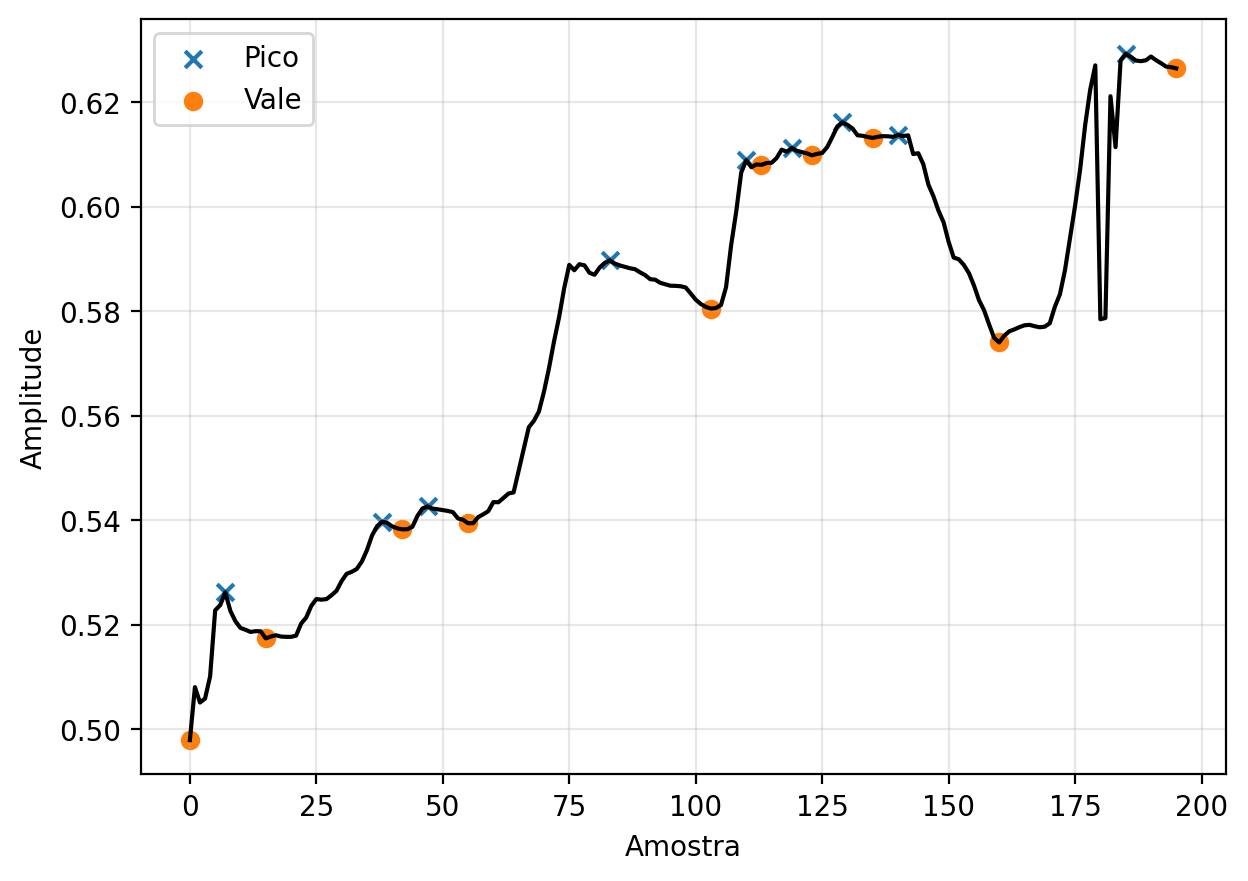

0.012875840067863464
[ 0.01351303  0.00291449  0.04707015  0.01913732  0.00234014  0.00491935
 -0.00242096  0.01553321]
[ 0.01946145  0.0208534   0.00116199  0.04105061  0.02749437  0.00181925
  0.00333393 -0.03911239  0.05240142]
n° de passos:  9
velocidade:  0.01773712662409763
velocidade em passos:  1.3775510204081634
foot off:  63.26530612244898


In [77]:
from findpeaks import findpeaks
fp = findpeaks(method='peakdetect', lookahead=5)

def plot_pv(results):
    #retorna os picos e vales apenas
    peak   = results['df'][results['df']['peak'] == True]
    valley = results['df'][results['df']['valley'] == True]

    #Mostra o gráfico
    plt.figure(dpi=200, figsize=(7,5))
    plt.grid(alpha=0.3)
    plt.plot(results['df']['x'], results['df']['y'], color='k')
    plt.scatter(peak['x'], peak['y'], label='Pico', marker='x')
    plt.scatter(valley['x'], valley['y'], label='Vale', marker='o')
    plt.xlabel('Amostra')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

    return peak, valley

results1 = fp.fit(foot29_x)
peak, valley = plot_pv(results1)

dist_peaks  = np.diff(peak['y'])
dist_valley = np.diff(valley['y'])

step_lenght = abs(np.average(dist_peaks))

print(step_lenght)
print(dist_peaks)
print(dist_valley)

n_passos = len(peak)
velocidade_m = (n_passos * step_lenght)/tx[-1]
velocidade_p = (n_passos)/tx[-1]
print("n° de passos: ", n_passos)
print("velocidade: ", velocidade_m)
print("velocidade em passos: ", velocidade_p)
picos = peak.y
amostra = peak.x
#step_lenght = (picos[-1] - picos[0])/len(picos)

def countX(lst, x): 
    count = 0
    for ele in lst: 
        if (ele == x): 
            count = count + 1
    return count 

foot29r = np.round(foot29_x-0.0005, 3)
nfoot_on = 0

for pico in picos:
    nfoot_on += countX(foot29r, round(pico-0.0005, 3))
    #foot_on += foot29_x
    nfoot_on += countX(foot29r, round(pico-0.0004, 3))
    #print(round(pico-0.0005, 3))
    
#print(nfoot_on)
#print(foot_on)
foot_off = ((len(foot29_x) - nfoot_on)/len(foot29_x)) *100
#print(len(foot29_x))
print("foot off: ", foot_off)

Obtenção do Centroide do Paralelogramo (Média entre as coordenadas dos vértices opostos)
(31x+30x/2,31y+30y/2)

In [78]:
centroidex = (foot31_x + foot30_x)/2
centroidey = (foot31_y + foot30_y)/2
centroide = (foot31_x + foot30_x)/2, (foot31_y + foot30_y)/2
print(centroidex)
print(centroidey)
transposta = list(map(lambda *i: [j for j in i], *centroide))
print(transposta)

#centroidex = transposta[:, 0]
#centroidey = transposta[:, 1]

[0.50833336 0.50184341 0.49322596 0.49924898 0.50362194 0.51256528
 0.51340315 0.51614642 0.5166502  0.51518652 0.51398185 0.51657474
 0.51555854 0.51753068 0.51727906 0.51611364 0.51744547 0.51804489
 0.52050024 0.52114347 0.5209603  0.52028984 0.52054092 0.520868
 0.52192771 0.52346483 0.52385047 0.52462634 0.52504268 0.52702433
 0.52669811 0.527403   0.52779311 0.52809969 0.52867997 0.52831393
 0.52873418 0.52860078 0.52861714 0.5283328  0.52827781 0.52816585
 0.52744973 0.52645928 0.52614161 0.52664316 0.52763873 0.52876991
 0.52926025 0.52964923 0.53019825 0.53189892 0.53294763 0.53375354
 0.53646386 0.53972903 0.54200092 0.54419687 0.54476526 0.54488757
 0.54530093 0.54593316 0.54670349 0.5472388  0.5468592  0.54747921
 0.54984713 0.55256653 0.55633545 0.56026509 0.56446066 0.56807762
 0.57027057 0.57157573 0.57278338 0.57186258 0.57102346 0.5697391
 0.5693858  0.56987032 0.5695549  0.56896237 0.5701977  0.57198152
 0.57429263 0.57532355 0.57544449 0.5767588  0.57730338 0.5772399

Distância do CoG ao Centroide

[0.00661761 0.00463268 0.01309694 0.01018098 0.00734301 0.0016997
 0.00168201 0.00478004 0.00740721 0.00510534 0.00134959 0.00380608
 0.00349259 0.00708912 0.00933684 0.01145399 0.05968827 0.06159922
 0.06665632 0.06797431 0.06842759 0.0681048  0.06809782 0.06836986
 0.06959253 0.07011422 0.07022256 0.07111709 0.0701848  0.07229496
 0.07410047 0.0755678  0.07795979 0.08081336 0.08353923 0.08360708
 0.08428062 0.08420977 0.08464986 0.0868357  0.08956604 0.09186835
 0.0917625  0.09273249 0.08956292 0.08290325 0.08290192 0.08316701
 0.08477887 0.08866107 0.09458997 0.08604762 0.08931181 0.09020287
 0.09123115 0.09452153 0.09670671 0.09945024 0.10443208 0.10427773
 0.10424494 0.10486569 0.10521571 0.1059913  0.10663388 0.10531968
 0.10518352 0.10614156 0.11016895 0.11608875 0.12354743 0.12955863
 0.13205238 0.13519353 0.13360442 0.13142808 0.12978502 0.12803742
 0.1288526  0.12887145 0.12825753 0.12579835 0.12380164 0.12338117
 0.12499874 0.12454706 0.12768289 0.13129165 0.13718392 0.13924

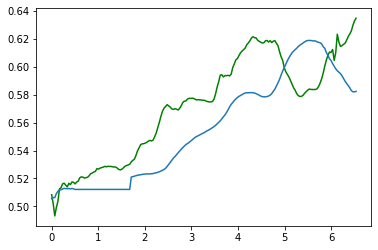

In [79]:
#Distância entre dois pontos
distancia_cog = np.sqrt((body_com_X-centroidex)**2) + ((body_com_Y-centroidey)**2)
print(distancia_cog)
print("distância média: ", np.average(distancia_cog))

for i in (distancia_cog):
    if(i != (len(distancia_cog)-1)):
        print(i, end=",")
    else: 
        print(i)

plt.plot(tx, centroidex, 'g')
plt.plot(tx, body_com_X)

Distância do CoG a borda da BoS

In [43]:
#Distância do ponto às 4 retas (usar o menor valor como distância)
from itertools import chain

norm = np.linalg.norm

# Creating points
p1 = np.array([foot31]) #ponta esquerda
p2 = np.array([foot29]) #calcanhar esquerdo
p3 = np.array([foot32]) #ponta direita
p4 = np.array([foot30]) #calcanhar direito
p5 = np.array([body_com]) #cog
'''
p1 = np.delete(foot31, 1, 1)
p2 = np.delete(foot29, 1, 1) #calcanhar esquerdo
p3 = np.delete(foot32, 1, 1) #ponta direita
p4 = np.delete(foot30, 1, 1) #calcanhar direito
p5 = np.delete(body_com, 1, 1) #cog
'''
# Finding distance of p3 from a 
# line connecting p1 and p2

dis12 = np.abs((np.cross(p2-p1, p1-p5))/norm(p2-p1))
dis13 = np.abs((np.cross(p3-p1, p1-p5))/norm(p3-p1))
dis24 = np.abs((np.cross(p2-p4, p4-p5))/norm(p2-p4))
dis34 = np.abs((np.cross(p3-p4, p4-p5))/norm(p3-p4))

#print(dis12)

#print(pp)

dis12x = dis12[:, :, 0]
dis13x = dis13[:, :, 0]
dis24x = dis24[:, :, 0]
dis34x = dis34[:, :, 0]

dis12y = dis12[:, :, 1]
dis13y = dis13[:, :, 1]
dis24y = dis24[:, :, 1]
dis34y = dis34[:, :, 1]

menor1x = np.minimum(dis12x, dis13x)
menor2x = np.minimum(dis24x, dis34x)
distanciax = np.minimum(menor1x, menor2x)
#print(distanciax)

menor1y = np.minimum(dis12y, dis13y)
menor2y = np.minimum(dis24y, dis34y)
distanciay = np.minimum(menor1y, menor2y)
#print(distanciay)

distancia_borda = np.minimum(distanciax, distanciay)
#print( distancia_borda)
distanciab_avg = np.average(distancia_borda)
distanciab_var = np.var(distancia_borda)
distanciab_desvio = np.std(distancia_borda)
print(distanciab_avg, distanciab_var, distanciab_desvio)
print("dstância até a borda: ", distanciab_avg)
'''
menor1 = np.minimum(dis12, dis13)
menor2 = np.minimum(dis24, dis34)
distanciab = np.minimum(menor1, menor2)

distanciab_avg = np.average(distanciab)
distanciab_var = np.var(distanciab)
distanciab_desvio = np.std(distanciab)
print(distanciab_avg, distanciab_var, distanciab_desvio)
'''

0.0001908334708088194 3.2091184706764005e-08 0.00017914012589803548
dstância até a borda:  0.0001908334708088194


'\nmenor1 = np.minimum(dis12, dis13)\nmenor2 = np.minimum(dis24, dis34)\ndistanciab = np.minimum(menor1, menor2)\n\ndistanciab_avg = np.average(distanciab)\ndistanciab_var = np.var(distanciab)\ndistanciab_desvio = np.std(distanciab)\nprint(distanciab_avg, distanciab_var, distanciab_desvio)\n'

In [44]:
import math
#foot29 foot30 foot31 foot32
lado_direito = foot31_y - foot29_y
lado_esquerdo = foot32_y - foot30_y
diagonal_b = np.sqrt((foot29_x-foot30_x)**2) + ((foot29_y-foot30_y)**2)
diagonal_c = np.sqrt((foot31_x-foot32_x)**2) + ((foot31_y-foot32_y)**2)
#print(diagonal_b)
#print(diagonal_c)
centroide = [(diagonal_b+diagonal_c)/2, (lado_direito)]
h = foot29_x - foot30_x

In [45]:
def calculate_area(c):

    '''
    Calculates the area of any quadrivaletral
    from a list of x,y coordinates in the following format:

    [[x1,y1],[x2,y2],[x3,y3],[x4,y4]]
    '''

    first = c[0][0]*c[1][1] + c[1][0]*c[2][1] + c[2][0]*c[3][1] + c[3][0]*c[0][1]

    second = c[1][0]*c[0][1] + c[2][0]*c[1][1] + c[3][0]*c[2][1] + c[0][0]*c[3][1]

    area = 0.5*(first - second)

    return area

p1 = np.delete(foot31, 1, 1)
p2 = np.delete(foot29, 1, 1) #calcanhar esquerdo
p3 = np.delete(foot32, 1, 1) #ponta direita
p4 = np.delete(foot30, 1, 1) #calcanhar direito
c = np.concatenate((p1,p2,p3,p4), axis = 1)
area = calculate_area(c)
print(p1)

[[ 4.86441314e-01  2.12192126e-02]
 [ 4.86808956e-01 -3.87334707e-03]
 [ 4.86798346e-01  5.16243884e-03]
 [ 4.86834049e-01  7.71889696e-03]
 [ 4.86836433e-01  7.04378029e-03]
 [ 4.86843586e-01  5.61667886e-03]
 [ 4.86826092e-01  3.49909579e-03]
 [ 4.86809552e-01  3.26530891e-03]
 [ 4.86808121e-01  2.27889279e-03]
 [ 4.86829758e-01  2.44124420e-03]
 [ 4.86834615e-01  3.17110727e-03]
 [ 4.86837536e-01  1.81328505e-04]
 [ 4.86843914e-01 -7.24951911e-04]
 [ 4.86844391e-01 -1.07958552e-03]
 [ 4.86845493e-01 -7.46114121e-04]
 [ 4.86862838e-01 -7.92985025e-04]
 [ 4.86864656e-01  7.87695870e-04]
 [ 4.86857474e-01  2.82082893e-03]
 [ 4.86817449e-01  3.26493150e-03]
 [ 4.86751854e-01  5.34589728e-03]
 [ 4.86629337e-01  5.35274995e-03]
 [ 4.86499786e-01  7.53156329e-03]
 [ 4.86393273e-01  8.29574931e-03]
 [ 4.86328125e-01  7.73477275e-03]
 [ 4.86310542e-01  7.44702527e-03]
 [ 4.86311048e-01  7.32786860e-03]
 [ 4.86313015e-01  6.67314883e-03]
 [ 4.86297190e-01  3.50980205e-03]
 [ 4.86301273e-01 -2

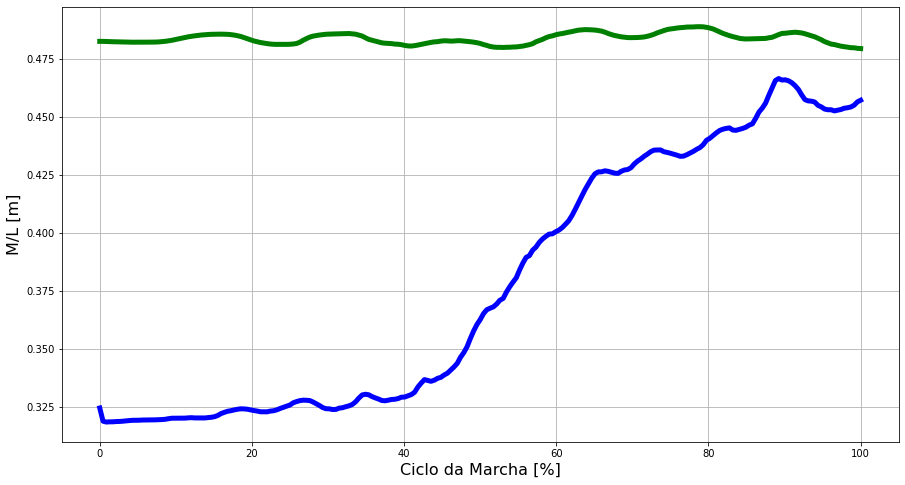

In [46]:
plt.figure(figsize=[15,8])
plt.plot(GaitCycle, body_com_Y, color = 'b', linewidth = 5)
plt.plot(GaitCycle, body_com_X, color = 'g', linewidth = 5)
#plt.plot(tx, foot_com_X1, color = 'b', linewidth = 5)
#plt.plot(foot_com_X1, foot_com_Y1, color = 'y', linewidth = 5)
plt.ylabel('M/L [m]', fontsize=16)
plt.xlabel('Ciclo da Marcha [%]', fontsize=16)
#plt.title('Excursão vertical do CoM na marcha', fontsize=16)
#plt.plot(ty1, foot_y12, 'go')
#plt.plot(tx1, foot_x12, 'ro')
#plt.plot(foot_xj2, foot_yj2, 'g')
#plt.plot(foot_xi2, foot_yi2, 'r')
#plt.plot(ty, foot29_y, 'go')
#plt.plot(ty, foot30_y, 'ro')
#plt.plot(foot_x12, foot_y12, 'ro')
plt.grid()
plt.show()

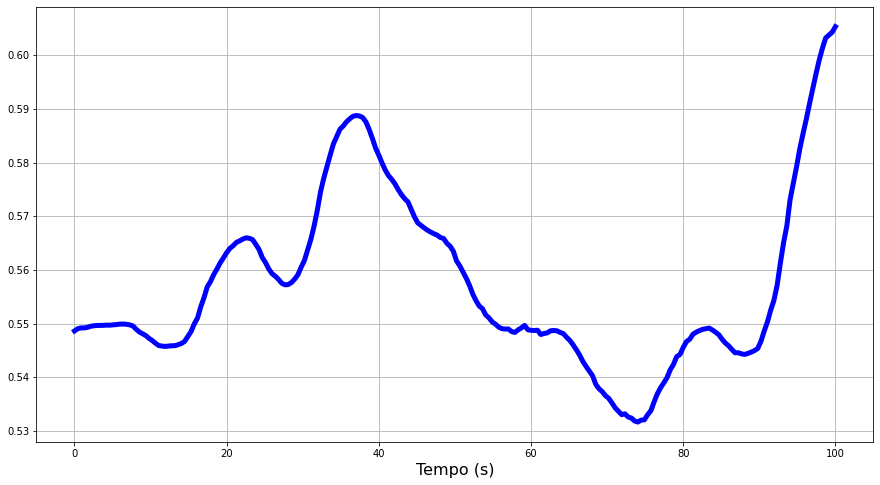

In [21]:
plt.figure(figsize=[15,8])
plt.plot(GaitCycle, body_com_X, color = 'b', linewidth = 5)
#plt.plot(tx, foot_com_X1, color = 'b', linewidth = 5)
#plt.plot(foot_com_X1, foot_com_Y1, color = 'y', linewidth = 5)
#plt.ylabel('A/P', fontsize=16)
plt.xlabel('Tempo (s)', fontsize=16)
#plt.title('Excursão vertical do CoM na marcha', fontsize=16)
#plt.plot(ty1, foot_y12, 'go')
#plt.plot(tx1, foot_x12, 'ro')
#plt.plot(foot_xj2, foot_yj2, 'g')
#plt.plot(foot_xi2, foot_yi2, 'r')
#plt.plot(tx, foot29_x, 'go')
#plt.plot(tx, foot30_x, 'ro')
#plt.plot(foot_x12, foot_y12, 'ro')
plt.grid()
plt.show()

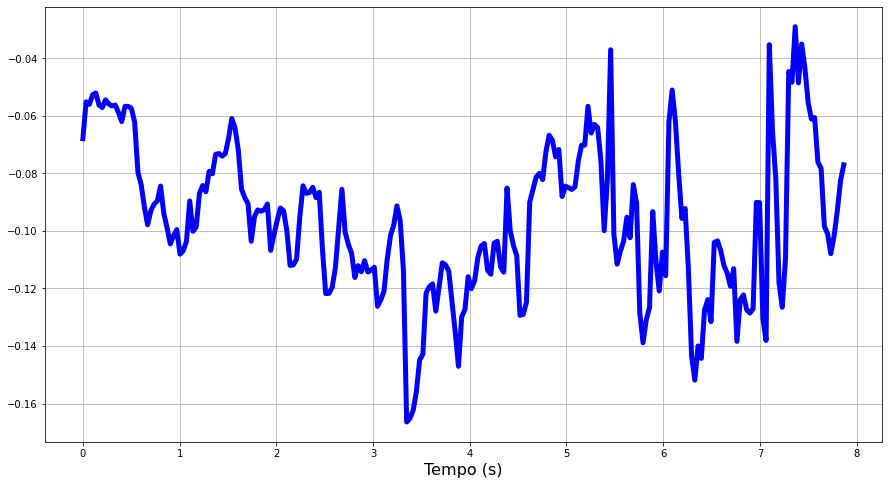

In [22]:

plt.figure(figsize=[15,8])
plt.plot(tz, body_com_Z, color = 'b', linewidth = 5)
#plt.plot(tx, foot_com_X1, color = 'b', linewidth = 5)
#plt.plot(foot_com_X1, foot_com_Y1, color = 'y', linewidth = 5)
#plt.ylabel('A/P', fontsize=16)
plt.xlabel('Tempo (s)', fontsize=16)
#plt.title('Excursão vertical do CoM na marcha', fontsize=16)
#plt.plot(ty1, foot_y12, 'go')
#plt.plot(tx1, foot_x12, 'ro')
#plt.plot(foot_xj2, foot_yj2, 'g')
#plt.plot(foot_xi2, foot_yi2, 'r')
#plt.plot(tx, foot29_x, 'go')
#plt.plot(tx, foot30_x, 'ro')
#plt.plot(foot_x12, foot_y12, 'ro')
plt.grid()
plt.show()

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


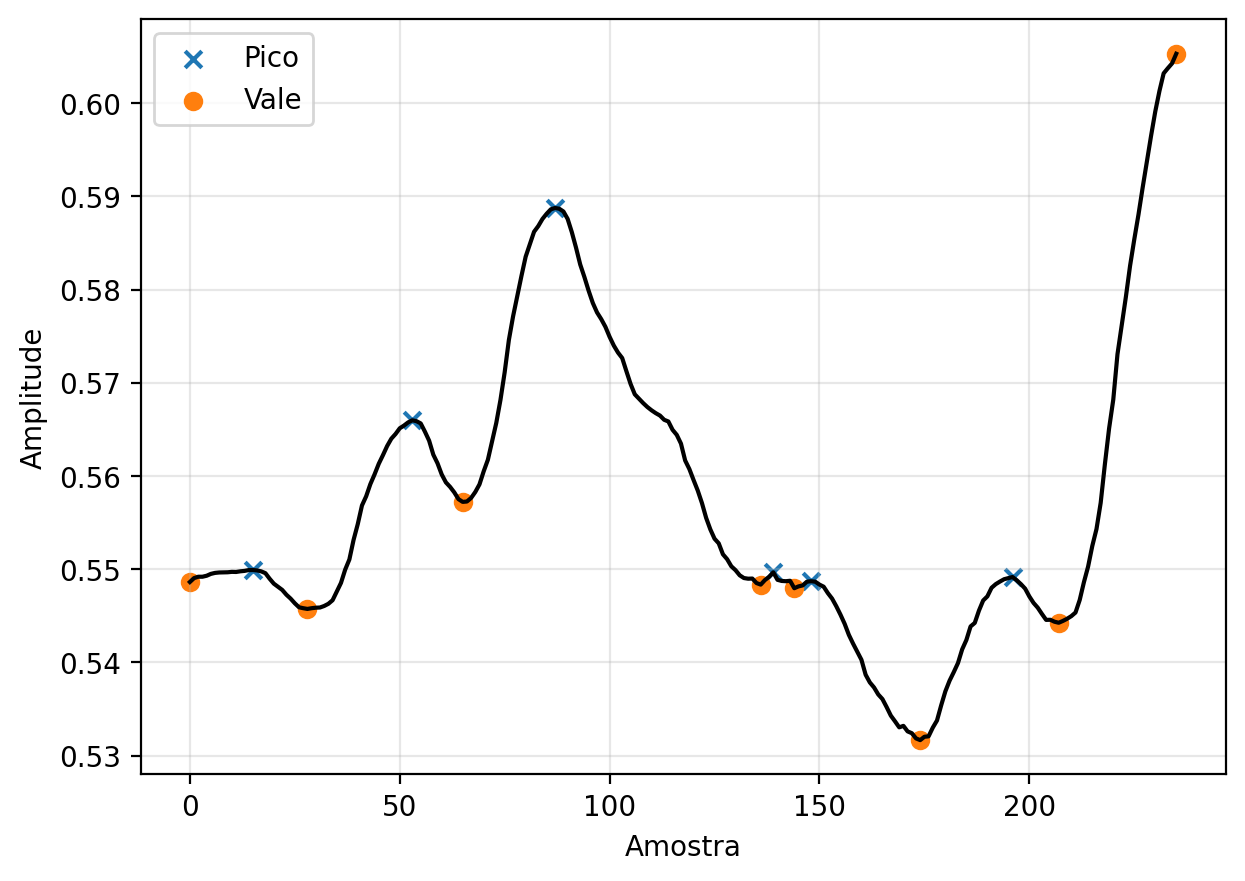

[38 34 52  9 48]
[28 37 71  8 30 33 28]


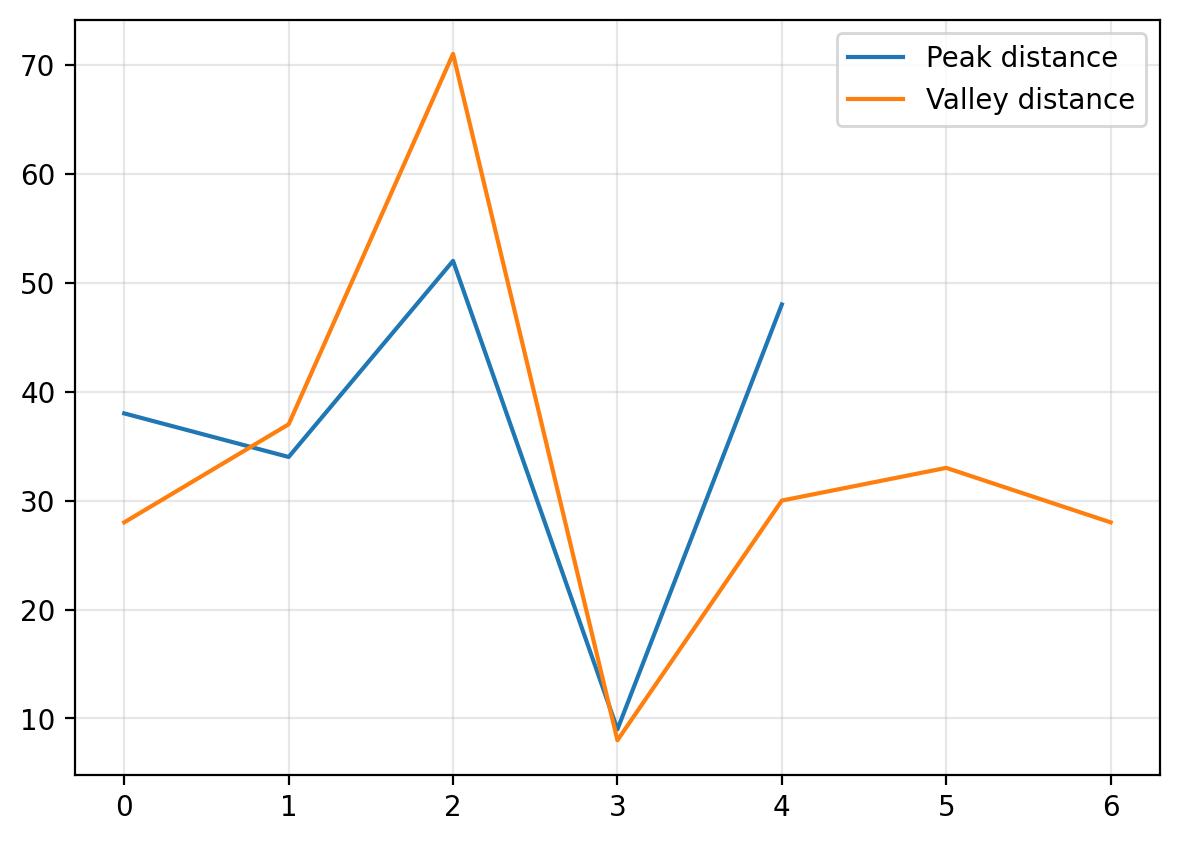

8


In [23]:


#Chama a função com os resultados obtidos anteriormente
#matriz = np.concatenate((tx, filteredx))
results = fp.fit(body_com_X)
peak, valley = plot_pv(results)

dist_peaks  = np.diff(peak['x'])
dist_valley = np.diff(valley['x'])

print(dist_peaks)
print(dist_valley)

plt.figure(dpi=200, figsize=(7,5))
plt.grid(alpha=0.3)
plt.plot(dist_peaks, label='Peak distance')
plt.plot(dist_valley, label='Valley distance')
plt.legend()
plt.show()

print(len(valley))

In [24]:
#print(2*filteredx[45]-filteredx[0])

# Filtragem

In [25]:
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

In [26]:
# apply a 2-pole lowpass filter at 0.15x Nyquist frequency (15 hz is half the max frequency of the video (30Hz))
bx, ax = scipy.signal.butter(2, 0.2)
filteredx = scipy.signal.filtfilt(bx, ax, body_com_X, axis=0)

by, ay = scipy.signal.butter(2, 0.2)
filteredy = scipy.signal.filtfilt(by, ay, body_com_Y, axis=0)

bz, az = scipy.signal.butter(2, 0.2)
filteredz = scipy.signal.filtfilt(bz, az, body_com_Z, axis=0)

b30z, a30z = scipy.signal.butter(2, 0.2)
filtered30z = scipy.signal.filtfilt(b30z, a30z, foot30_z, axis=0)

b29z, a29z = scipy.signal.butter(2, 0.2)
filtered29z = scipy.signal.filtfilt(b29z, a29z, foot29_z, axis=0)

b30y, a30y = scipy.signal.butter(2, 0.2)
filtered30y = scipy.signal.filtfilt(b30y, a30y, foot30_y, axis=0)

b29y, a29y = scipy.signal.butter(2, 0.2)
filtered29y = scipy.signal.filtfilt(b29y, a29y, foot29_y, axis=0)

b30x, a30x = scipy.signal.butter(2, 0.2)
filtered30x = scipy.signal.filtfilt(b30x, a30x, foot30_x, axis=0)

b29x, a29x = scipy.signal.butter(2, 0.2)
filtered29x = scipy.signal.filtfilt(b29x, a29x, foot29_x, axis=0)


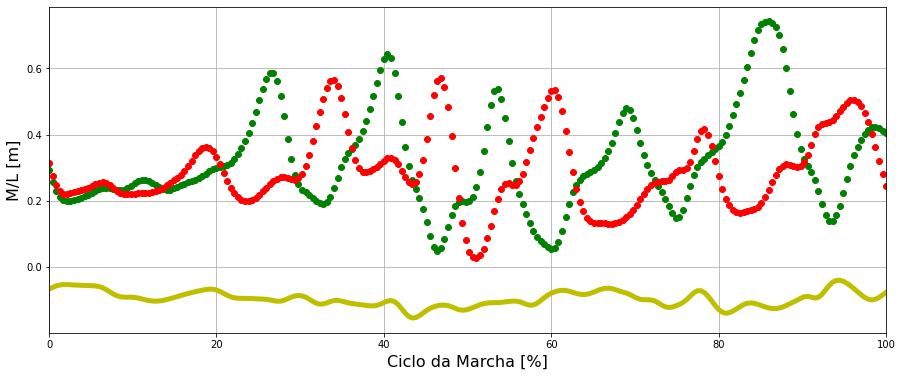

In [27]:
plt.figure(figsize=[15, 6])
plt.plot(GaitCycle, filteredz, color = 'y', linewidth = 5)
plt.ylabel('M/L [m]', fontsize=16)
plt.xlabel('Ciclo da Marcha [%]', fontsize=16)
plt.plot(GaitCycle, filtered30z, 'go')
plt.plot(GaitCycle, filtered29z, 'ro')
#plt.title('Excursão vertical com filtro Butterworth', fontsize=16)
plt.xlim(0, 100)
#plt.ylim(0.03, 0.07)
plt.grid()
plt.show()

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


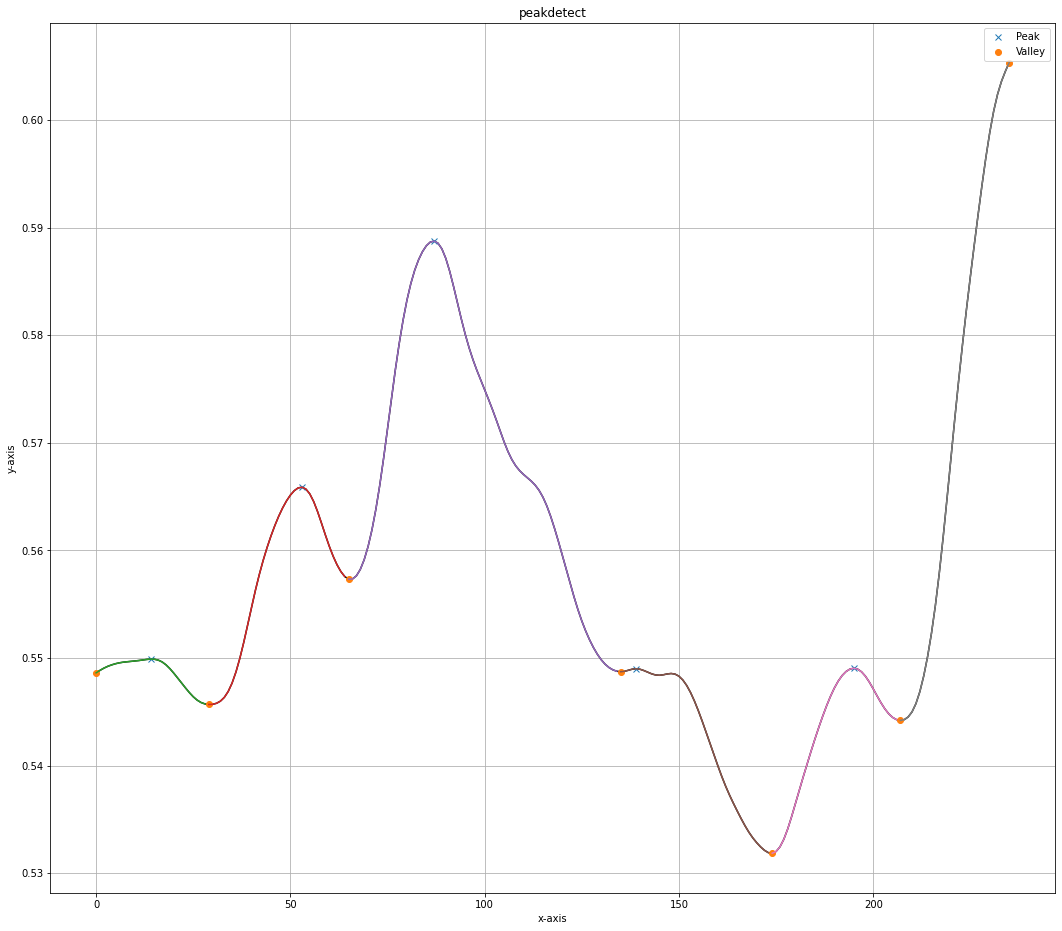

(None,
 <AxesSubplot:title={'center':'peakdetect'}, xlabel='x-axis', ylabel='y-axis'>)

In [28]:

results = fp.fit(filteredx)
fp.plot(figsize=(18,16))


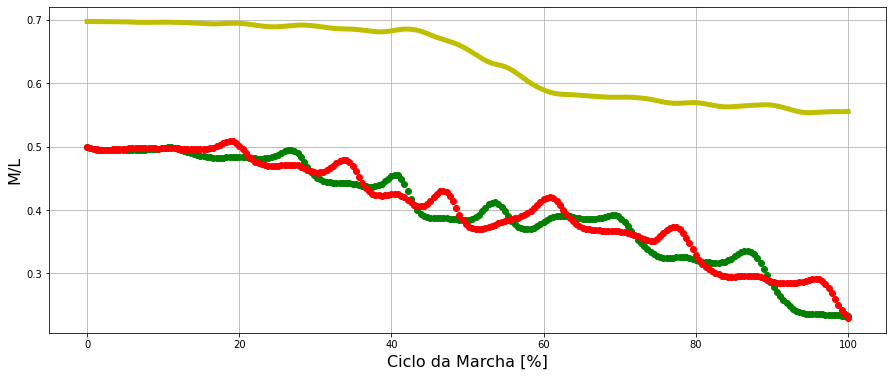

In [29]:
plt.figure(figsize=[15, 6])
plt.plot(GaitCycle, filteredy, color = 'y', linewidth = 5)
plt.ylabel('M/L', fontsize=16)
plt.xlabel('Ciclo da Marcha [%]', fontsize=16)
plt.plot(GaitCycle, filtered30y, 'go')
plt.plot(GaitCycle, filtered29y, 'ro')
#plt.ylim(0.6, 0.9)
#plt.title('', fontsize=16)
plt.grid()
plt.show()

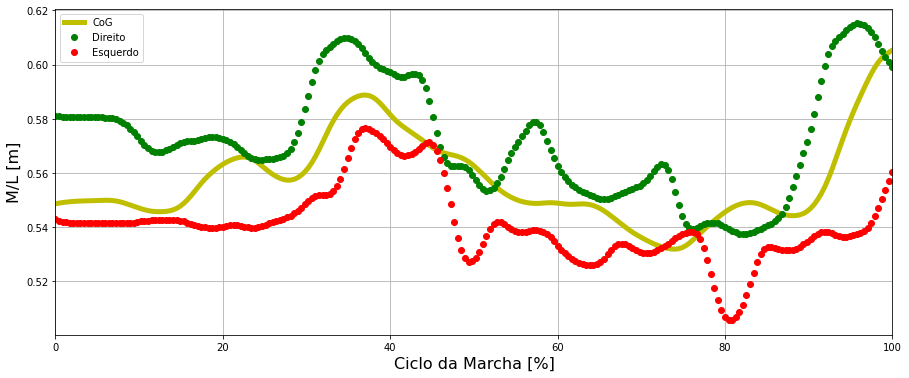

In [30]:
plt.figure(figsize=[15, 6])
plt.plot(GaitCycle, filteredx, color = 'y', linewidth = 5)
plt.ylabel('M/L [m]', fontsize=16)
plt.xlabel('Ciclo da Marcha [%]', fontsize=16)
plt.plot(GaitCycle, filtered30x, 'go')
plt.plot(GaitCycle, filtered29x, 'ro')
plt.xlim(0, 100)
plt.legend(['CoG', 'Direito', 'Esquerdo'])
#plt.title('Excursão vertical com filtro Butterworth', fontsize=16)
plt.grid()
plt.show()

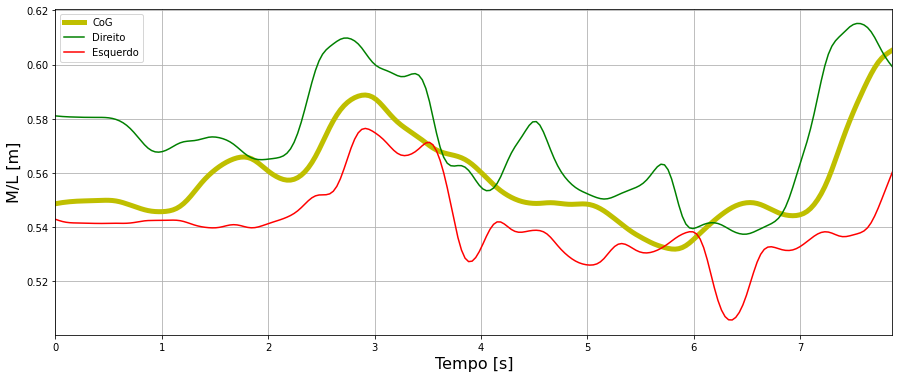

In [31]:
plt.figure(figsize=[15, 6])
plt.plot(tx, filteredx, color = 'y', linewidth = 5)
plt.ylabel('M/L [m]', fontsize=16)
plt.xlabel('Tempo [s]', fontsize=16)
plt.plot(tx, filtered30x, 'g')
plt.plot(tx, filtered29x, 'r')
plt.xlim(0, tx[-1])
plt.legend(['CoG', 'Direito', 'Esquerdo'])
#plt.title('Excursão vertical com filtro Butterworth', fontsize=16)
plt.grid()
plt.show()

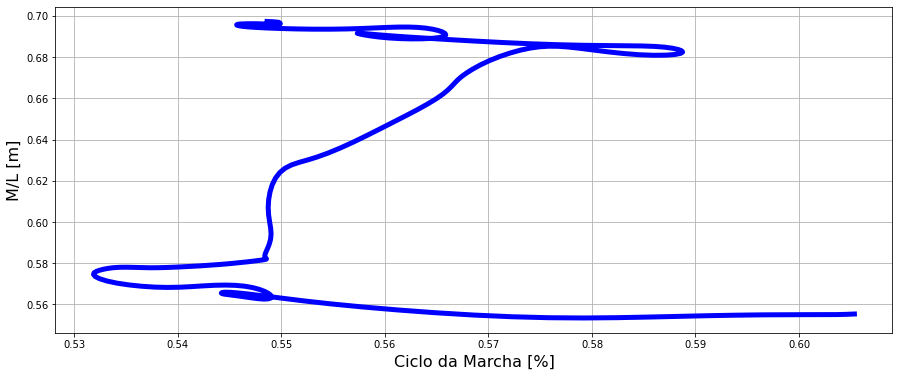

In [32]:
plt.figure(figsize=[15, 6])
#plt.plot(GaitCycle, filteredx, color = 'y', linewidth = 5)
plt.plot(filteredx, filteredy, color = 'b', linewidth = 5)
plt.ylabel('M/L [m]', fontsize=16)
plt.xlabel('Ciclo da Marcha [%]', fontsize=16)
#plt.plot(GaitCycle, filtered30x, 'go')
#plt.plot(GaitCycle, filtered29x, 'ro')
#plt.xlim(0, 100)
#plt.legend(['CoG', 'Direito', 'Esquerdo'])
#plt.title('Excursão vertical com filtro Butterworth', fontsize=16)
plt.grid()
plt.show()

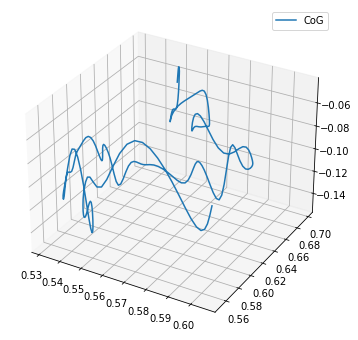

In [33]:
from mpl_toolkits.mplot3d import axes3d

ax = plt.figure(figsize=[15, 6]).add_subplot(projection='3d')

ax.plot(filteredx, filteredy, filteredz, label='CoG')
ax.legend()
plt.show()

ICC

In [80]:
#d1 = [0.041647894720598044,0.04394152567329708,0.04416179326104542,0.044143633262238725,0.04416823475484988,0.0441870173449818,0.04410465766968818,0.04398083416391325,0.04395654545191853,0.043903236312566075,0.04386544231849239,0.043884302013772775,0.04387820449120708,0.04384880988703942,0.043876807829655425,0.043878038047975305,0.04388300991273096,0.04389375846559332,0.043961822221485904,0.044080381005514195,0.04424608722370733,0.04439906601472493,0.044607732280672274,0.04490762260006808,0.04522229457393759,0.04551111622713517,0.0456559076693841,0.04532818702457293,0.044936801973749205,0.044703135930324975,0.044660447336647834,0.04470623928034382,0.04491908926377627,0.04548232502528574,0.04608526583279768,0.046487311042151314,0.04641770108352261,0.04637300328128388,0.04624135381601971,0.04606360274276524,0.04579098161505604,0.04543991659929975,0.04482460624003812,0.04436242692450019,0.04387471463438483,0.043309659196736544,0.042571147447309735,0.04293647140911698,0.04366086416972512,0.04447253309155727,0.045185551480691886,0.046911023937438165,0.04858153206163176,0.05019540757866663,0.052041664459176865,0.05348093758140915,0.053424780216298595,0.05194376797791313,0.051014976590680106,0.05133362033653621,0.05179356020819267,0.05113361953125194,0.05025537410111334,0.049239460387534115,0.04883754321845824,0.04854377801445696,0.047339983166593845,0.04717816063007906,0.0482333493762196,0.04921775061345968,0.05234188382835796,0.05616905677735969,0.058122354630749926,0.06051343708103348,0.06229829554781293,0.06275595395301066,0.06267094811816395,0.06231094090632616,0.06227410502917128,0.06192522437667576,0.0614473051983418,0.060487495486121826,0.05982591199243836,0.06001102879177375,0.060594514230016966,0.061559376467629316,0.06304293962514118,0.06462785720495166,0.06670661018780152,0.06951577030086142,0.07313860018340763,0.0751967676550959,0.0753545875840402,0.07275879890344965,0.07116787965884226,0.07099333301329223,0.0700270977113799,0.06870144708942863,0.06737420469218121,0.06685883528654203,0.06655810509850554,0.06497167478839665,0.06470937763714044,0.06440063583492481,0.06508485960869169,0.06674318123351217,0.07004078218924702,0.07349524682966331,0.07579232930536536,0.07818508229087237,0.07824564555104073,0.07797809303269955,0.07613759498971316,0.07398361310840999,0.07258871738250085,0.0710247019826587,0.0689356829297603,0.06676821684478157,0.06555169177491484,0.06394783142740701,0.06089129899306551,0.05984437631372347,0.059305979410264255,0.06029404272586546,0.06189396659723687,0.06297255239032021,0.06385934175336222,0.06449447478577643,0.06290134231242189,0.06114864561503469,0.05820466028668463,0.056263493965155675,0.05451132926972439,0.0526638664058709,0.051269693688068364,0.04967368417988144,0.04812966839082989,0.04652544101904688,0.045241733410608775,0.044520471885090514,0.04476783851617871,0.04450338055287881,0.04536379596808449,0.046621947899469156,0.0469093820511951,0.04639899229823887,0.044922088566714403,0.04371752247483047,0.04198851683777781,0.04016918603857929,0.03827129660187438,0.0365192696456402,0.035926113384240205,0.03596811800753477,0.03509103449777509,0.035655727689852416,0.036817253602479186,0.03744388551871112,0.03854960366171565,0.040836810031596844,0.0427422194533608,0.04459593489945874,0.046599445494735166,0.047711193438023915,0.047454619268902445,0.04629465650638799,0.04612661154597357,0.04583846797498362,0.04694755926050641,0.04677453009472457,0.046050327571000166,0.04496301029302419,0.04460642204842789,0.04511226222622985,0.045802660258368814,0.04722984438872239,0.050297985709238116,0.053824125293209193,0.05702188992611122,0.060000309462841475,0.06149715224267104,0.062346094814675554,0.06349748756632813,0.06394722944989359,0.06468367864414826,0.0640576091395918,0.06294399547160254,0.0614695947694891,0.0608857054379946,0.062351868423698734,0.06381509079226716,0.06450241535446442,0.06661836757312929,0.069143365625032,0.07176691880438893,0.07522032115613542,0.07974944889253378,0.08433205993541565,0.08837932576200086,0.09095620893445838,0.09145223090659456,0.09151171356709194,0.09153785279737191,0.09250205438238784,0.09136593463402627,0.09118869419060223,0.08998597946008824,0.09090405298598088,0.0922528272245025,0.09246083881866182,0.092525112659065,0.09300949450397414,0.09565432961798247,0.10088856315097884,0.10873315882604931,0.11837112947323264,0.12487400934628236,0.13229738628494317,0.13671905357566314,0.1393874053715402,0.13982087226114218,0.13894051990757486,0.13823213121459194,0.1376669709126724,0.13773593517194974,0.13689975235948754,0.13629109164311418,0.13558001350378043,0.13509799996552488,0.13482868439179532,0.13438942490587336,0.1335728100337265,0.13316695195235834]

#d2 = [0.05407972883769211,0.053877157984988856,0.05382939809747219,0.053812713878053156,0.05377338406592618,0.05351466256235529,0.053305600863326925,0.05323804129287059,0.05327387121989025,0.05325789783945843,0.053164774822471984,0.053119561363027444,0.05290813399773709,0.05286953234705033,0.0526739856333293,0.05295606655979688,0.05317897841358439,0.05302772025606256,0.052873167075456036,0.05312230513083577,0.05350350489825708,0.053072772708621034,0.05242525835379183,0.05237229096851871,0.051497927376802644,0.05097796997734766,0.050343625857201105,0.050111292707875205,0.05059297904980303,0.051206063319139225,0.05185424776696924,0.05239737535145673,0.05259115089001394,0.052613534922878215,0.05237217044078113,0.05233614783122408,0.05166823572141476,0.05070944795505492,0.05008664931305538,0.04804195119420666,0.046317280277539445,0.046705552696979936,0.04680832134862681,0.04784406028655778,0.04910940945412894,0.050602370740327945,0.053061849077256945,0.05497130151426853,0.0569066607362369,0.058622047200364236,0.060596125163921745,0.06253585362423675,0.06304378950746398,0.05997797225685071,0.060176327502975774,0.05956826086047496,0.058222732187080226,0.05691600248297956,0.05578712729688796,0.05468571833827219,0.052448753208599944,0.05124076502570026,0.05028772544922558,0.04948422708639362,0.04941378995013965,0.0517290809635636,0.054785964379323725,0.057909825097679175,0.06183404940995397,0.06301930017437204,0.06576424022136287,0.06716485845842732,0.06695135937244959,0.06855324225581862,0.06890122736267869,0.06597143717582232,0.06156353145741264,0.06190564476272485,0.06435209493134879,0.0648295277016505,0.06398445402222798,0.06361029801219412,0.06420163636420881,0.06604706057895607,0.06717096541584405,0.07010374924460039,0.07220496807218106,0.07246072012447802,0.07278906720997715,0.07199929325477826,0.07118354180881832,0.07047753032258104,0.07215153378151119,0.0741691064190254,0.0741393854613832,0.07390637345449903,0.07494682668024563,0.07693915554174369,0.08109902401147315,0.08786100671249761,0.09487853975601901,0.09821709434180059,0.09927449803404359,0.09908169217439813,0.10300372562713568,0.1018598463292029,0.09308301708319984,0.08476199987262915,0.08299827692962762,0.08428598861539206,0.08816613058216807,0.09151185798076532,0.09599587911481657,0.10217036769465658,0.10673864802495416,0.10695977365596399,0.10651929565526909,0.10512110318354914,0.10116534333089412,0.09039078240749165,0.08618497052093578,0.08272451805785054,0.075629418410002,0.06802193104709044,0.06569085733839332,0.06348752035556654,0.06568041766557414,0.06981020595305087,0.07264401267216122,0.07413039351717507,0.07503192347583565,0.07371221250321587,0.07345717387854946,0.0731097356450872,0.072747975903398,0.07013505885683963,0.06676943022201914,0.0618548765562203,0.05672637169823065,0.05246383281262041,0.047296211447621334,0.04336101391107603,0.04095384164734367,0.044724509816270255,0.04543341221505054,0.04720612930251606,0.048177407035208626,0.050259210037356346,0.051346455263468406,0.05298849923777167,0.05207092910828284,0.04921659971304696,0.046567920077336046,0.04465172650174186,0.04558767112011817,0.04652761883988936,0.04693868809181337,0.04959525721265043,0.05138780568619713,0.051872221169291174,0.053274363199246055,0.05446125676403884,0.05405757991975412,0.05461881928570149,0.0558508897595162,0.05780031009636951,0.060204813254504726,0.06408708952624312,0.06844404604083483,0.07164472556339191,0.07349976577917675,0.07545784754572162,0.0758745574592144,0.07340625290384678,0.0743407694691917,0.0687454242345687,0.06387448934325299,0.061362807021746145,0.05707388343819737,0.057209121080016655,0.05754652483716622,0.058144122847463106,0.06035145460677709,0.06365953108560521,0.07202243407932345,0.08035447223890917,0.08492370428774709,0.08915512913886114,0.09235529755588982,0.09555210563914515,0.09303396868133733,0.08665318873833255,0.0819938702890844,0.080258461624397,0.08124563951229499,0.08066224497341036,0.08163321133889488,0.08024630688632209,0.07794566338637861,0.07676787863445533,0.07392187706147849,0.07327609206875985,0.0729943129467884,0.07266006968716879,0.07229126233493283,0.07352322822600871,0.0754264776568389,0.07855116161997151,0.08655034841498295,0.09287029925924759,0.09823174839653707,0.10133661756287184,0.10427574939190383,0.10673152227372369,0.10810925184557013,0.10948109034567372,0.11395901782643374,0.11506340364441679,0.11050505735780784,0.10648726118879763,0.10321269906711339,0.09804178587372152,0.09662788350380107,0.09765983434698887,0.10128840546063081,0.10504075441677606,0.10888757179633334,0.11349238885486682,0.11704158286282774,0.1207225358603819,0.12491664902989323,0.1293251508549736,0.13497660263826639,0.13527511296871053,0.1359517853623927,0.1370234785614301]

d1 = [0.0468323120021179,0.04560584290354095,0.04511190479663952,0.04472779943125586,0.04443709646454405,0.04394574817279532,0.04355470956449487,0.0440559439101238,0.04395716490994734,0.043838956581634156,0.04389125614517812,0.043796158481229586,0.04337216449024967,0.04292009817289625,0.04281998483494701,0.04296127411145125,0.04303324993168064,0.04293983629893586,0.04249572512445633,0.04204122987040136,0.04178785139995381,0.04129974708820726,0.0402720403405337,0.03921735221250353,0.04042531860134437,0.04227295889397452,0.04461233449572949,0.04673661354734674,0.0494444558069648,0.05226488324334974,0.055120091843361085,0.05684234401147881,0.05831739098943085,0.05962651420979336,0.05874231205311552,0.05755765883965032,0.05807447498425894,0.058044195070211226,0.056093956268251005,0.055017893175576205,0.055134873873087326,0.05531023047550967,0.05506844331879762,0.054530400700348446,0.05296757717124333,0.05118571284234483,0.047332739803390526,0.04393902313684613,0.03976167529121618,0.0426562497620094,0.045312746156435504,0.04625095592296135,0.04726019205392454,0.0476278441719071,0.04804026788033638,0.049006625351264835,0.05167094118956351,0.055292628683121195,0.05905025863038475,0.06145201898181832,0.0633953902281919,0.06411302205696492,0.06316514740990595,0.05851527332227316,0.05520200890705637,0.05415850483049507,0.05481987467293243,0.055908335969554225,0.05506434429771317,0.05510836617566544,0.05499264540773669,0.05386938765051106,0.05200259829623112,0.05054084886080464,0.04778127181862763,0.05162444361525703,0.05737766037197441,0.06181277475682106,0.06727571308620989,0.0702925349494163,0.07291022731122743,0.0745198037452138,0.07612898678815253,0.07640481309499615,0.07610428380004369,0.07522658143433328,0.07821695520291817,0.07175552014829228,0.06313820812674727,0.05814920585895494,0.054873930490695555,0.054480491385383495,0.05708285850197671,0.05845521171179139,0.06185932975510709,0.06517288326129145,0.0724470530778767,0.0795527851413208,0.08602232933947491,0.09083150393569264,0.09343281673850093,0.09430821108693527,0.09417648775374936,0.09466955078637639,0.09499913738528015,0.09358487019263886,0.09148518125821749,0.08908870836073501,0.08788790318303168,0.08649253400930108,0.08458179356616079,0.0801476264347575,0.07077370567242154,0.06611505749356449,0.07059711536211132,0.07941143752725159,0.08326701809060627,0.08795402019545172,0.09055292795700781,0.0913786600189617,0.09195560230199372,0.09469236002835366,0.0940354175768548,0.09576920895779566,0.09832415544256312,0.09659458419911741,0.09355293744074379,0.0907350782438439,0.08570361052513464,0.0815008321125216,0.0830400451045982,0.08113188304810605,0.08133647429590658,0.08453712189671567,0.08677340942467507,0.09017318302721984,0.09738264616238348,0.10164179321171898,0.11029031626555481,0.11274316525986869,0.11512109206283279,0.11673224254156063,0.12279000577485101,0.12394485975996734,0.12197113392529955,0.11946773188923548,0.1212334944924261,0.12050913757840773,0.11510401755950508,0.10793452607439287,0.10061132747689099,0.09479004662486862,0.099175994027849,0.10513538687912526,0.10787881852182073,0.11378088941229512,0.12322839855295052,0.13673225905645042,0.14774496186094843,0.15012578644944563,0.14496822005861507,0.14641321680229052,0.14357394237264876,0.14069623173329204,0.13736453319619896,0.13406523344904037,0.13867065664634898,0.12659927057635767,0.13411941299135702,0.1358506552379218,0.1376456770305528,0.13576284507104852,0.149333035218098,0.15494706444074097,0.15822615416698727,0.1700834516353937,0.17282666851057205,0.18114492130859136,0.18386670033849406,0.1798173560014497,0.16933029705540878,0.1758802306225904,0.16938625966851836,0.16846494250925612,0.16976889325569777,0.1745377738350354,0.17887672515724057,0.18084369518342608,0.1821513150543406,0.18342075395008126,0.18718975054562637,0.18991341681737078,0.19237417227050657,0.1924054718476851,0.19304872174898063,0.19446006754528958,0.18994033423288245,0.1826768238591307,0.1733663435637142,0.15631548085485736,0.1471985563530183,0.13920747150602558,0.1303765152118474,0.12701955130617787,0.12131139250986532,0.11259299691477856,0.10717601860024238,0.1075381412935308,0.10826683721828682,0.10638450738807356,0.10542256381622467,0.10748640956743803,0.1083101730368429,0.10661645905231291,0.10440002399845152,0.10043398585662117,0.10318113007607643,0.1021721915752371,0.10250940919269605,0.10123446877796184,0.10072212699189231,0.10043563496162049,0.10096018824051918,0.09951212531480097,0.09114090392217898,0.08625626941006516,0.07916984671762717,0.08571938044168996,0.09374692587344739,0.10148065763951346,0.10595768180274814,0.11330577092793213,0.11398503574804825,0.11367607333979153,0.11223200799083587,0.10880014952841512,0.10506394567767391,0.10894289159837171,0.11340152774391744,0.11597089198796227,0.1179429594792399,0.12071964441790599,0.1231267877417178,0.12382654215819659,0.1254623018734704,0.12893920419238375,0.13328517212338223,0.13861730753373727,0.14552731983137174,0.15030335942052003,0.15559999147276915,0.1577183129211865,0.15761841557891376,0.161062380436086,0.15835141136196104,0.1546355947165951,0.15128839842885222,0.1479732736618036,0.14487292413547928,0.1429614724406411,0.14109084232357175,0.13936384601042473,0.13721192226669526,0.1352281961349438,0.1327292606994055,0.13137884190404733,0.130601825276912,0.1305097335861433,0.1296892326238001]

d2 = [0.006617611262493009,0.004632682532421355,0.01309693513052626,0.0101809789178377,0.007343009697799204,0.0016997020983027956,0.0016820134811423193,0.004780036401834414,0.0074072093122739685,0.005105339229369526,0.0013495916443584987,0.003806076840847687,0.0034925878315549366,0.0070891150001207645,0.00933683824587336,0.01145398855394825,0.059688265166191926,0.06159922042221338,0.06665631951852857,0.06797431376969679,0.06842759140785601,0.06810480352990365,0.06809781594891992,0.06836985692935939,0.06959253160973325,0.0701142188042913,0.07022255916096785,0.07111709100178085,0.07018479544701503,0.07229496145254358,0.07410046710225424,0.07556780425034976,0.07795978896696307,0.08081335542816814,0.08353923318394925,0.08360708080703039,0.08428062281409243,0.08420976922236033,0.08464986265774531,0.08683570321963997,0.08956603549278935,0.09186834870450904,0.0917624990252381,0.09273249355500594,0.08956292100591896,0.08290325241579898,0.08290192399480101,0.08316701084343266,0.08477886849632398,0.08866106815188397,0.09458996846977401,0.08604762391357525,0.08931180599162458,0.09020287383846491,0.09123114823390972,0.09452153308661344,0.09670671415011929,0.09945024296124717,0.1044320757331978,0.10427773283783205,0.10424494397910528,0.10486568795734606,0.10521571186108021,0.10599129710978134,0.1066338775983907,0.10531967724646506,0.10518352173878218,0.10614156229792157,0.11016895310233316,0.11608874881940053,0.1235474274670799,0.1295586261267463,0.13205238488548815,0.13519353169045223,0.13360441779410603,0.13142807922520905,0.1297850156126878,0.1280374203239732,0.1288526034671944,0.12887145130935818,0.12825752835284646,0.12579834780706733,0.12380164062508281,0.12338116742810264,0.12499874478756547,0.12454706407381097,0.12768288557330124,0.1312916547590624,0.13718391941521885,0.13924261849123498,0.14063334425926666,0.1399712985721306,0.139065329624463,0.1370271440198506,0.13569941230240418,0.13447813565675343,0.13374052579582174,0.13420100157685827,0.13274122429515528,0.13073420515407203,0.12927953471871334,0.12931110302886717,0.12997618129299757,0.1334391779437263,0.13861397959966165,0.1461941002623675,0.15592885821094565,0.16172723443125173,0.16833847452087664,0.16782243251766335,0.1649493102347738,0.16795809956183427,0.1655522850173365,0.1652210315915676,0.16121274676905994,0.16121759704635727,0.15764905233568016,0.15570894355437856,0.15925566099246394,0.15990391137666501,0.17009439828601433,0.17847420391661853,0.18485792098289097,0.18942647028908052,0.1935280207983383,0.20026431247177173,0.20457643192281313,0.20820294038087436,0.21165583170685126,0.2150620856384626,0.21100977270882235,0.20864844507884264,0.20559094415317203,0.2029958977232217,0.19912991103048086,0.19326541829072877,0.18984963730151982,0.18662425038131042,0.18507763976110148,0.18377170831429282,0.18669012332024804,0.18370512979474296,0.18013063079620167,0.17768409910945435,0.16680927573278623,0.15809561945553718,0.14879580638147397,0.14162903650157702,0.13159851841332149,0.11929318552497176,0.11845196578603728,0.11994141730301434,0.12171534582512115,0.12160298101091292,0.12031156369473069,0.11853157764850322,0.121183106105855,0.12391721923964501,0.12407938086682246,0.12597815087691872,0.13152258062304562,0.13504576508864963,0.13777532564307376,0.1386543632780339,0.13817363123544757,0.13835513872071284,0.13372560799412836,0.13372157328770368,0.13599283479880803,0.1346770413185336,0.13191797433467886,0.12867763462881612,0.12628308685911538,0.12152005560837109,0.11663823668098566,0.11396155310243321,0.10713931628513748,0.1014264805999112,0.1046684149431493,0.10188921577233713,0.11245202468856734,0.10505443074439903,0.10958730876678449,0.12156359012139034,0.1115533184124019,0.10712716062051181,0.10753707606660387,0.10872999771725739,0.10969903730310215,0.11385484496292925,0.11611858897174933,0.11813018154593857,0.12291089613762811,0.13450351086711088,0.14276042021728486,0.14713889698302757]

In [81]:
freq_amostragem = 30 # frames por segundo

td = np.linspace(0, len(d1) / freq_amostragem, len(d1))

In [82]:
tam1 = np.size(d1)
tam2 = np.size(d2)
#tam3 = np.size(filtered3)
#print(np.concatenate((t1, t2, t3), axis=None))
#print(np.ones(tam1)*2)
nteste = np.concatenate(((np.ones(tam1), (np.ones(tam2)*2))))
ndeslocamento = np.concatenate((d1, d2), axis=None)
ntempo = np.concatenate((td, td), axis=None)
nj = np.ones(np.size(nteste))
mm = np.concatenate((list(range(tam1)), list(range(tam2))), axis=None)

print(np.size(nteste))
print(np.size(ndeslocamento))
print(np.size(mm))
print(np.size(ntempo))
#print(mm)

465
465
465
538


In [83]:
import pandas as pd
df = pd.DataFrame({'teste': mm, 'video': nteste, 'deslocamento': ndeslocamento, 'tempo': nteste})
df.head()

,teste,video,deslocamento,tempo
0,0,1.0,0.046832,1.0
1,1,1.0,0.045606,1.0
2,2,1.0,0.045112,1.0
3,3,1.0,0.044728,1.0
4,4,1.0,0.044437,1.0


In [84]:
import pingouin as pg

icc = pg.intraclass_corr(data=df, targets='teste', raters='video', ratings='tempo', nan_policy='omit')

icc.set_index('Type')

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,-1.0,0.0,195,196,1.0,"[-1.0, -1.0]"
ICC2,Single random raters,0.0,NaN,195,195,NaN,"[nan, nan]"
ICC3,Single fixed raters,NaN,NaN,195,195,NaN,"[nan, nan]"
ICC1k,Average raters absolute,-inf,0.0,195,196,1.0,"[-inf, -inf]"
ICC2k,Average random raters,0.0,NaN,195,195,NaN,"[nan, nan]"
ICC3k,Average fixed raters,NaN,NaN,195,195,NaN,"[nan, nan]"


In [85]:
icc = pg.intraclass_corr(data=df, targets='teste', raters='video', ratings='deslocamento', nan_policy='omit')

icc.set_index('Type')

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,0.262881,1.713265,195,196,9.280778e-05,"[0.13, 0.39]"
ICC2,Single random raters,0.321859,2.242422,195,195,1.368282e-08,"[0.13, 0.48]"
ICC3,Single fixed raters,0.383177,2.242422,195,195,1.368282e-08,"[0.26, 0.5]"
ICC1k,Average raters absolute,0.416319,1.713265,195,196,9.280778e-05,"[0.23, 0.56]"
ICC2k,Average random raters,0.486980,2.242422,195,195,1.368282e-08,"[0.22, 0.65]"
ICC3k,Average fixed raters,0.554054,2.242422,195,195,1.368282e-08,"[0.41, 0.66]"
